In [1]:
# IMPORTING LIBRARIES AND MODULES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, warnings, random, string
from pickle import dump, load
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
import keras
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.applications.inception_v3 import InceptionV3 , preprocess_input
from keras.models import Model, load_model
from tensorflow.keras.layers import add
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

2023-08-30 22:35:04.703145: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-30 22:35:04.785022: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-30 22:35:04.787641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 22:35:06.944482: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from nltk import FreqDist
from nltk.translate.bleu_score import sentence_bleu

In [4]:
# DATA ANALYSIS
inputDir = 'Flickr/'

In [5]:
def loadCaptionsDictionary(path):
    file = open(path, 'r')
    captions = file.read().split('\n')
    descriptions = {}
    for text in captions[1:]:
        values = text.split(',')
        img, caption = values[0].split('.')[0], "".join(values[1:])
        if img not in descriptions:
            descriptions[img] = [caption]
        else:
            descriptions[img].append(caption)
    file.close()
    return descriptions

descriptions = loadCaptionsDictionary(inputDir + 'captions.txt')

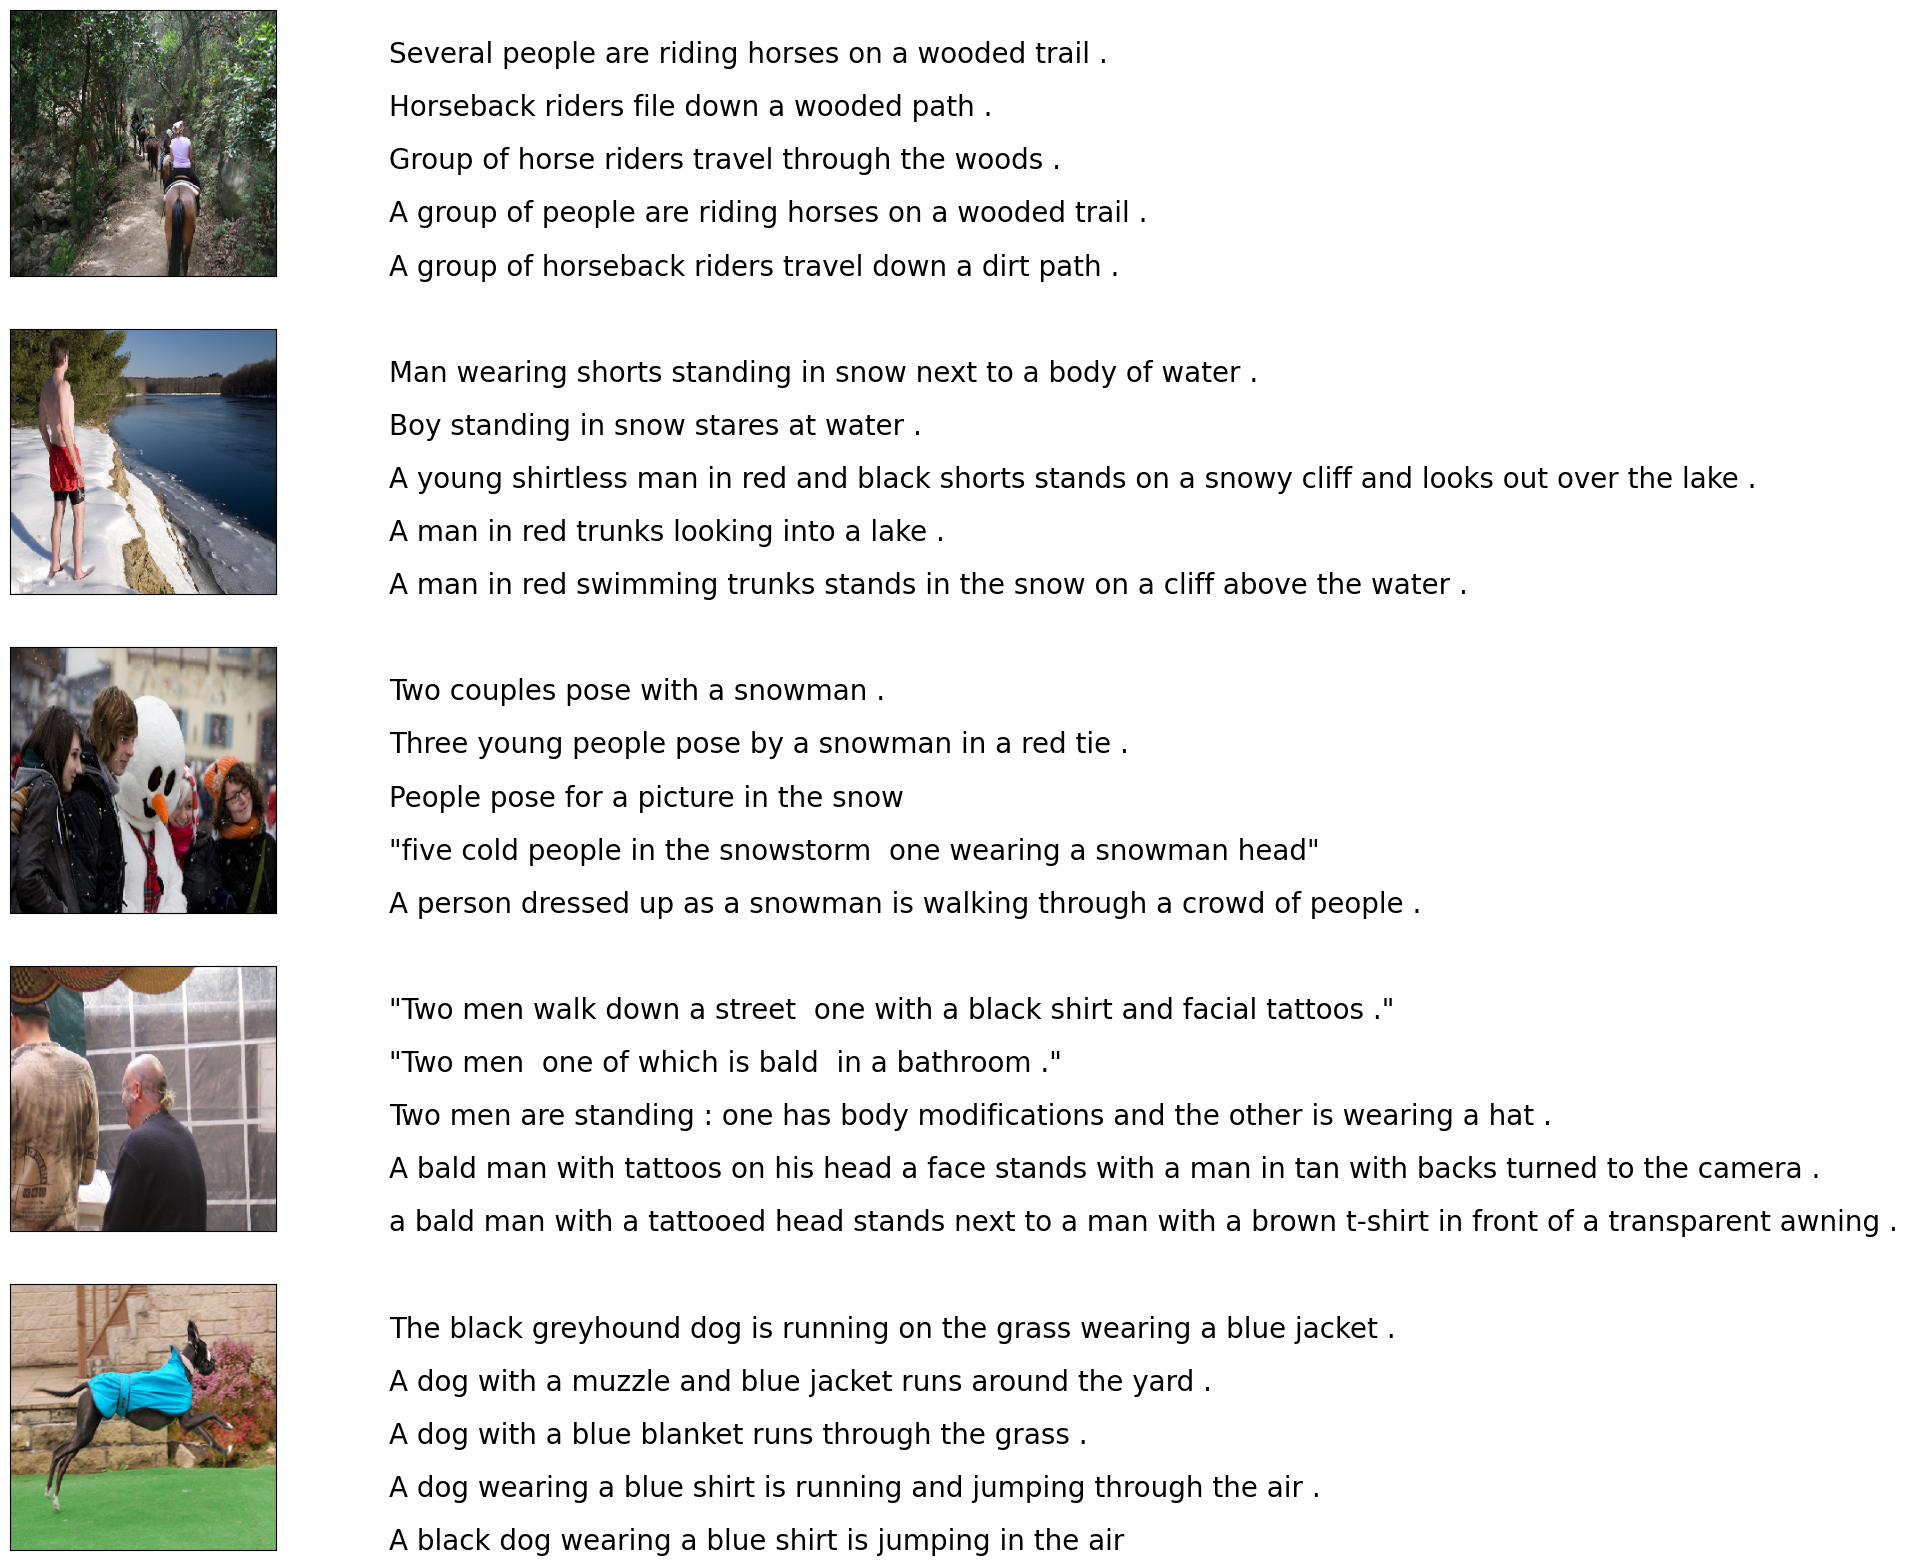

In [6]:
npic = 5
imgSize = 299
targetSize = (imgSize, imgSize)
path = inputDir + "Images/"
fig = plt.figure(figsize=(10,20))

count = 1
for img in os.listdir(path)[:npic]:
    
    filename = path + img
    captions = list(descriptions[img.split(".")[0]])
    imageLoad = load_img(filename, target_size=targetSize)
    
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(imageLoad)
    count += 1
    
    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=20)
    count += 1
plt.show()

In [7]:
# TEXT PROCESSING AND ANALYSIS
def textCleaning(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for img, caption in descriptions.items():
        for i, imgText in enumerate(caption):
            imgText.replace("-", " ")
            text = [word.lower() for word in imgText.split()]
            text = [word.translate(table) for word in text]
            text = [word for word in text if(len(word) > 1)]
            text = [word for word in text if(word.isalpha())]
            imgText = " ".join(text)
            descriptions[img][i] = imgText
    return descriptions

descriptions = textCleaning(descriptions)

In [8]:
def corpusAndVocab(descriptions):
    corpus = ""
    for imgText in descriptions.values():
        for text in imgText:
            corpus += " "+text
    vocab = set(corpus.split())
    return corpus, vocab

corpus, vocab = corpusAndVocab(descriptions)
print("Number of unique words = {}".format(len(vocab)))

Number of unique words = 8763


In [9]:
freqDist = FreqDist(corpus.split())
dfsub = pd.DataFrame(columns = ["word", "count"])
mostCommon = freqDist.most_common()
words, counts = [], []
for i in range(len(freqDist)):
    words.append(mostCommon[i][0])
    counts.append(mostCommon[i][1])
dfsub["word"], dfsub["count"] = words, counts

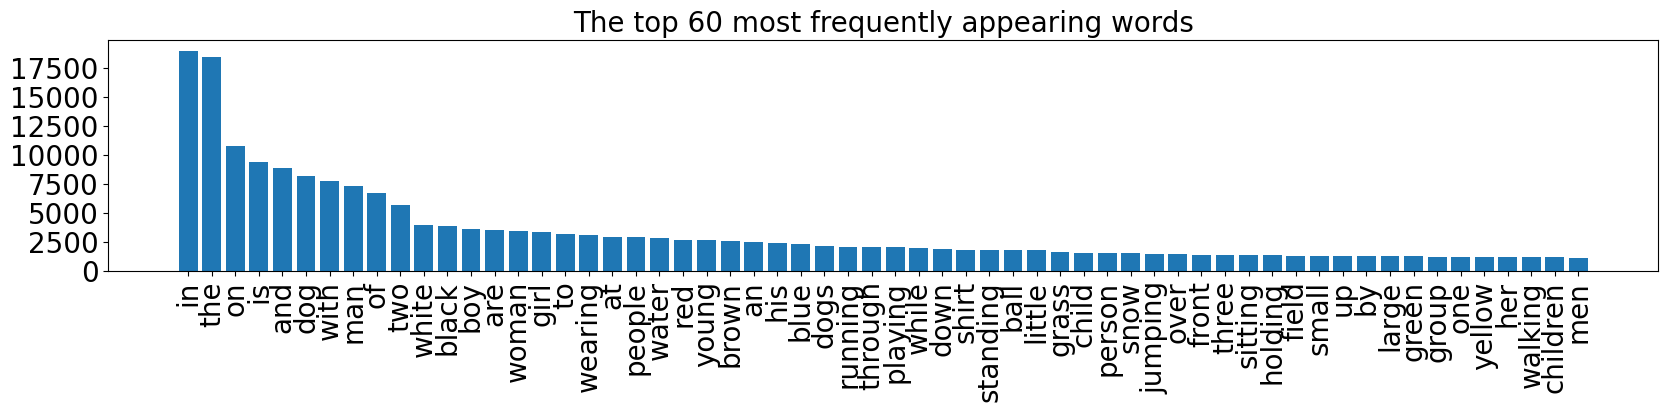

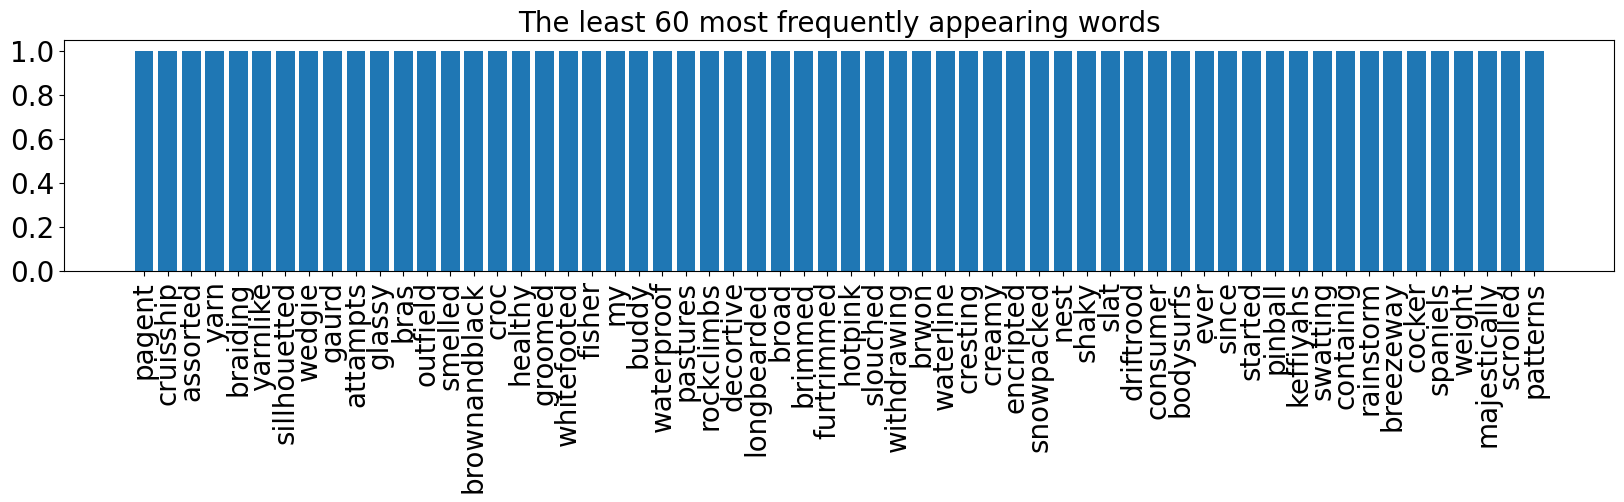

In [10]:
def plthist(dfsub, title):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()
    
plthist(dfsub.iloc[:60], "The top 60 most frequently appearing words")
plthist(dfsub.iloc[-60:], "The least 60 most frequently appearing words")

In [11]:
def saveDescriptions(descriptions, filename):
    lines = list()
    for key, descList in descriptions.items():
        for i, desc in enumerate(descList):
            descriptions[key][i] = desc = "<startseq> " + desc + " <endseq>"
            lines.append(key + '\t' + desc)
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()
    
saveDescriptions(descriptions, "ImageDescriptionsList.txt")

In [12]:
# TRAIN-VAL-TEST SPLIT
# Test set - First 10 images and captions
# Validation set - Next 5 images and captions
# Training set - The remaining images and captions
dfImgCaption = pd.DataFrame()
dfImgCaption['ImageName'] = list(descriptions.keys())[:-1]
temps = list(descriptions.values())[:-1]
dfImgCaption['Caption'] = [temps[i][random.randint(0,4)] for i in range(len(temps))]
dfImgCaption.head()

ImageName                                            Caption
0  1000268201_693b08cb0e  <startseq> little girl climbing the stairs to ...
1  1001773457_577c3a7d70  <startseq> black dog and spotted dog are fight...
2  1002674143_1b742ab4b8  <startseq> small girl in the grass plays with ...
3  1003163366_44323f5815  <startseq> man sleeping on bench outside with ...
4  1007129816_e794419615  <startseq> man with glasses is wearing beer ca...

In [13]:
testImages = np.asarray(dfImgCaption['ImageName'][:10], dtype = np.dtype(object))
testCaptions = np.asarray(dfImgCaption['Caption'][:10], dtype = np.dtype(object))
valImages = np.asarray(dfImgCaption['ImageName'][10:15], dtype = np.dtype(object))
valCaptions = np.asarray(dfImgCaption['Caption'][10:15], dtype = np.dtype(object))
trainImages = np.asarray(dfImgCaption['ImageName'][15:], dtype = np.dtype(object))
trainCaptions = np.asarray(dfImgCaption['Caption'][15:], dtype = np.dtype(object))

In [14]:
# FEATURE EXTRACTION
cnnModel = InceptionV3(weights = 'imagenet')
for layer in cnnModel.layers:
    layer.trainable = False
cnnModel = Model(inputs = cnnModel.input, outputs = cnnModel.get_layer('avg_pool').output)
cnnModel.summary()

2023-08-30 22:35:14.431922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-30 22:35:14.435568: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [15]:
def extractFeatures(model, images, img_size):
    features = {}
    for img in tqdm(images):
        picture = load_img(inputDir + "Images/" + img + ".jpg", target_size = (imgSize, imgSize))
        picture = img_to_array(picture)
        picture = np.expand_dims(picture, axis = 0)
        picture = preprocess_input(picture)
        features[img] = model.predict(picture).reshape(2048,)
    
    return features

In [16]:
XtrainFeatures = extractFeatures(cnnModel, trainImages, 299)

  0%|                                                  | 0/8076 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  0%|                                        | 1/8076 [00:03<7:02:05,  3.14s/it]

1/1 [==============================] - 0s 102ms/step


  0%|                                        | 2/8076 [00:03<3:09:08,  1.41s/it]

1/1 [==============================] - 0s 90ms/step


  0%|                                        | 3/8076 [00:03<1:54:39,  1.17it/s]

1/1 [==============================] - 0s 95ms/step


  0%|                                        | 4/8076 [00:03<1:19:28,  1.69it/s]

1/1 [==============================] - 0s 106ms/step


  0%|                                        | 5/8076 [00:03<1:00:15,  2.23it/s]

1/1 [==============================] - 0s 98ms/step


  0%|                                          | 6/8076 [00:04<48:55,  2.75it/s]

1/1 [==============================] - 0s 97ms/step


  0%|                                          | 7/8076 [00:04<41:53,  3.21it/s]

1/1 [==============================] - 0s 92ms/step


  0%|                                          | 8/8076 [00:04<36:47,  3.66it/s]

1/1 [==============================] - 0s 83ms/step


  0%|                                          | 9/8076 [00:04<32:59,  4.08it/s]

1/1 [==============================] - 0s 113ms/step


  0%|                                         | 10/8076 [00:04<31:10,  4.31it/s]

1/1 [==============================] - 0s 97ms/step


  0%|                                         | 11/8076 [00:05<30:00,  4.48it/s]

1/1 [==============================] - 0s 96ms/step


  0%|                                         | 12/8076 [00:05<29:01,  4.63it/s]

1/1 [==============================] - 0s 88ms/step


  0%|                                         | 13/8076 [00:05<28:01,  4.79it/s]

1/1 [==============================] - 0s 81ms/step


  0%|                                         | 14/8076 [00:05<27:08,  4.95it/s]

1/1 [==============================] - 0s 84ms/step


  0%|                                         | 15/8076 [00:05<26:51,  5.00it/s]

1/1 [==============================] - 0s 86ms/step


  0%|                                         | 16/8076 [00:06<26:03,  5.15it/s]

1/1 [==============================] - 0s 80ms/step


  0%|                                         | 17/8076 [00:06<25:34,  5.25it/s]

1/1 [==============================] - 0s 76ms/step


  0%|                                         | 18/8076 [00:06<24:45,  5.42it/s]

1/1 [==============================] - 0s 93ms/step


  0%|                                         | 19/8076 [00:06<25:02,  5.36it/s]

1/1 [==============================] - 0s 87ms/step


  0%|                                         | 20/8076 [00:06<24:52,  5.40it/s]

1/1 [==============================] - 0s 88ms/step


  0%|                                         | 21/8076 [00:06<23:26,  5.73it/s]

1/1 [==============================] - 0s 87ms/step


  0%|                                         | 22/8076 [00:07<24:07,  5.56it/s]

1/1 [==============================] - 0s 86ms/step


  0%|                                         | 23/8076 [00:07<24:47,  5.41it/s]

1/1 [==============================] - 0s 88ms/step


  0%|                                         | 24/8076 [00:07<24:54,  5.39it/s]

1/1 [==============================] - 0s 85ms/step


  0%|▏                                        | 25/8076 [00:07<24:51,  5.40it/s]

1/1 [==============================] - 0s 79ms/step


  0%|▏                                        | 26/8076 [00:07<24:24,  5.49it/s]

1/1 [==============================] - 0s 83ms/step


  0%|▏                                        | 27/8076 [00:08<24:00,  5.59it/s]

1/1 [==============================] - 0s 74ms/step


  0%|▏                                        | 28/8076 [00:08<23:29,  5.71it/s]

1/1 [==============================] - 0s 80ms/step


  0%|▏                                        | 29/8076 [00:08<23:39,  5.67it/s]

1/1 [==============================] - 0s 85ms/step


  0%|▏                                        | 30/8076 [00:08<23:44,  5.65it/s]

1/1 [==============================] - 0s 89ms/step


  0%|▏                                        | 31/8076 [00:08<24:27,  5.48it/s]

1/1 [==============================] - 0s 95ms/step


  0%|▏                                        | 32/8076 [00:08<24:57,  5.37it/s]

1/1 [==============================] - 0s 88ms/step


  0%|▏                                        | 33/8076 [00:09<24:56,  5.37it/s]

1/1 [==============================] - 0s 84ms/step


  0%|▏                                        | 34/8076 [00:09<24:20,  5.51it/s]

1/1 [==============================] - 0s 83ms/step


  0%|▏                                        | 35/8076 [00:09<24:07,  5.56it/s]

1/1 [==============================] - 0s 78ms/step


  0%|▏                                        | 36/8076 [00:09<23:50,  5.62it/s]

1/1 [==============================] - 0s 80ms/step


  0%|▏                                        | 37/8076 [00:09<23:36,  5.68it/s]

1/1 [==============================] - 0s 81ms/step


  0%|▏                                        | 38/8076 [00:09<23:23,  5.73it/s]

1/1 [==============================] - 0s 88ms/step


  0%|▏                                        | 39/8076 [00:10<24:17,  5.51it/s]

1/1 [==============================] - 0s 86ms/step


  0%|▏                                        | 40/8076 [00:10<23:35,  5.68it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▏                                        | 41/8076 [00:10<23:21,  5.73it/s]

1/1 [==============================] - 0s 81ms/step


  1%|▏                                        | 42/8076 [00:10<23:22,  5.73it/s]

1/1 [==============================] - 0s 76ms/step


  1%|▏                                        | 43/8076 [00:10<23:05,  5.80it/s]

1/1 [==============================] - 0s 90ms/step


  1%|▏                                        | 44/8076 [00:11<23:37,  5.67it/s]

1/1 [==============================] - 0s 88ms/step


  1%|▏                                        | 45/8076 [00:11<23:59,  5.58it/s]

1/1 [==============================] - 0s 87ms/step


  1%|▏                                        | 46/8076 [00:11<24:15,  5.52it/s]

1/1 [==============================] - 0s 83ms/step


  1%|▏                                        | 47/8076 [00:11<24:31,  5.46it/s]

1/1 [==============================] - 0s 76ms/step


  1%|▏                                        | 48/8076 [00:11<23:56,  5.59it/s]

1/1 [==============================] - 0s 96ms/step


  1%|▏                                        | 49/8076 [00:11<24:15,  5.51it/s]

1/1 [==============================] - 0s 76ms/step


  1%|▎                                        | 50/8076 [00:12<23:47,  5.62it/s]

1/1 [==============================] - 0s 83ms/step


  1%|▎                                        | 51/8076 [00:12<23:40,  5.65it/s]

1/1 [==============================] - 0s 82ms/step


  1%|▎                                        | 52/8076 [00:12<23:25,  5.71it/s]

1/1 [==============================] - 0s 84ms/step


  1%|▎                                        | 53/8076 [00:12<23:36,  5.66it/s]

1/1 [==============================] - 0s 97ms/step


  1%|▎                                        | 54/8076 [00:12<24:22,  5.48it/s]

1/1 [==============================] - 0s 111ms/step


  1%|▎                                        | 55/8076 [00:13<26:09,  5.11it/s]

1/1 [==============================] - 0s 89ms/step


  1%|▎                                        | 56/8076 [00:13<25:46,  5.19it/s]

1/1 [==============================] - 0s 92ms/step


  1%|▎                                        | 57/8076 [00:13<25:27,  5.25it/s]

1/1 [==============================] - 0s 109ms/step


  1%|▎                                        | 58/8076 [00:13<26:18,  5.08it/s]

1/1 [==============================] - 0s 86ms/step


  1%|▎                                        | 59/8076 [00:13<26:11,  5.10it/s]

1/1 [==============================] - 0s 101ms/step


  1%|▎                                        | 60/8076 [00:14<26:42,  5.00it/s]

1/1 [==============================] - 0s 80ms/step


  1%|▎                                        | 61/8076 [00:14<26:07,  5.11it/s]

1/1 [==============================] - 0s 84ms/step


  1%|▎                                        | 62/8076 [00:14<25:25,  5.25it/s]

1/1 [==============================] - 0s 85ms/step


  1%|▎                                        | 63/8076 [00:14<25:45,  5.19it/s]

1/1 [==============================] - 0s 87ms/step


  1%|▎                                        | 64/8076 [00:14<25:16,  5.28it/s]

1/1 [==============================] - 0s 110ms/step


  1%|▎                                        | 65/8076 [00:15<26:02,  5.13it/s]

1/1 [==============================] - 0s 110ms/step


  1%|▎                                        | 66/8076 [00:15<26:58,  4.95it/s]

1/1 [==============================] - 0s 106ms/step


  1%|▎                                        | 67/8076 [00:15<27:40,  4.82it/s]

1/1 [==============================] - 0s 107ms/step


  1%|▎                                        | 68/8076 [00:15<28:10,  4.74it/s]

1/1 [==============================] - 0s 81ms/step


  1%|▎                                        | 69/8076 [00:15<26:49,  4.97it/s]

1/1 [==============================] - 0s 82ms/step


  1%|▎                                        | 70/8076 [00:16<26:05,  5.11it/s]

1/1 [==============================] - 0s 90ms/step


  1%|▎                                        | 71/8076 [00:16<26:08,  5.10it/s]

1/1 [==============================] - 0s 82ms/step


  1%|▎                                        | 72/8076 [00:16<25:23,  5.25it/s]

1/1 [==============================] - 0s 82ms/step


  1%|▎                                        | 73/8076 [00:16<24:41,  5.40it/s]

1/1 [==============================] - 0s 81ms/step


  1%|▍                                        | 74/8076 [00:16<24:22,  5.47it/s]

1/1 [==============================] - 0s 97ms/step


  1%|▍                                        | 75/8076 [00:16<24:47,  5.38it/s]

1/1 [==============================] - 0s 91ms/step


  1%|▍                                        | 76/8076 [00:17<24:48,  5.38it/s]

1/1 [==============================] - 0s 82ms/step


  1%|▍                                        | 77/8076 [00:17<24:31,  5.44it/s]

1/1 [==============================] - 0s 91ms/step


  1%|▍                                        | 78/8076 [00:17<24:20,  5.48it/s]

1/1 [==============================] - 0s 87ms/step


  1%|▍                                        | 79/8076 [00:17<24:52,  5.36it/s]

1/1 [==============================] - 0s 86ms/step


  1%|▍                                        | 80/8076 [00:17<25:06,  5.31it/s]

1/1 [==============================] - 0s 81ms/step


  1%|▍                                        | 81/8076 [00:18<24:33,  5.43it/s]

1/1 [==============================] - 0s 85ms/step


  1%|▍                                        | 82/8076 [00:18<24:23,  5.46it/s]

1/1 [==============================] - 0s 96ms/step


  1%|▍                                        | 83/8076 [00:18<25:05,  5.31it/s]

1/1 [==============================] - 0s 91ms/step


  1%|▍                                        | 84/8076 [00:18<25:22,  5.25it/s]

1/1 [==============================] - 0s 81ms/step


  1%|▍                                        | 85/8076 [00:18<24:58,  5.33it/s]

1/1 [==============================] - 0s 77ms/step


  1%|▍                                        | 86/8076 [00:18<24:18,  5.48it/s]

1/1 [==============================] - 0s 86ms/step


  1%|▍                                        | 87/8076 [00:19<24:45,  5.38it/s]

1/1 [==============================] - 0s 87ms/step


  1%|▍                                        | 88/8076 [00:19<24:41,  5.39it/s]

1/1 [==============================] - 0s 81ms/step


  1%|▍                                        | 89/8076 [00:19<24:15,  5.49it/s]

1/1 [==============================] - 0s 75ms/step


  1%|▍                                        | 90/8076 [00:19<24:11,  5.50it/s]

1/1 [==============================] - 0s 80ms/step


  1%|▍                                        | 91/8076 [00:19<24:01,  5.54it/s]

1/1 [==============================] - 0s 82ms/step


  1%|▍                                        | 92/8076 [00:20<23:42,  5.61it/s]

1/1 [==============================] - 0s 82ms/step


  1%|▍                                        | 93/8076 [00:20<23:36,  5.64it/s]

1/1 [==============================] - 0s 82ms/step


  1%|▍                                        | 94/8076 [00:20<23:42,  5.61it/s]

1/1 [==============================] - 0s 87ms/step


  1%|▍                                        | 95/8076 [00:20<24:03,  5.53it/s]

1/1 [==============================] - 0s 90ms/step


  1%|▍                                        | 96/8076 [00:20<23:43,  5.61it/s]

1/1 [==============================] - 0s 95ms/step


  1%|▍                                        | 97/8076 [00:20<24:10,  5.50it/s]

1/1 [==============================] - 0s 87ms/step


  1%|▍                                        | 98/8076 [00:21<24:12,  5.49it/s]

1/1 [==============================] - 0s 87ms/step


  1%|▌                                        | 99/8076 [00:21<23:52,  5.57it/s]

1/1 [==============================] - 0s 81ms/step


  1%|▍                                       | 100/8076 [00:21<23:47,  5.59it/s]

1/1 [==============================] - 0s 89ms/step


  1%|▌                                       | 101/8076 [00:21<23:55,  5.56it/s]

1/1 [==============================] - 0s 84ms/step


  1%|▌                                       | 102/8076 [00:21<23:51,  5.57it/s]

1/1 [==============================] - 0s 89ms/step


  1%|▌                                       | 103/8076 [00:22<24:28,  5.43it/s]

1/1 [==============================] - 0s 81ms/step


  1%|▌                                       | 104/8076 [00:22<23:57,  5.55it/s]

1/1 [==============================] - 0s 81ms/step


  1%|▌                                       | 105/8076 [00:22<23:44,  5.59it/s]

1/1 [==============================] - 0s 101ms/step


  1%|▌                                       | 106/8076 [00:22<24:26,  5.43it/s]

1/1 [==============================] - 0s 86ms/step


  1%|▌                                       | 107/8076 [00:22<24:35,  5.40it/s]

1/1 [==============================] - 0s 88ms/step


  1%|▌                                       | 108/8076 [00:22<24:47,  5.36it/s]

1/1 [==============================] - 0s 91ms/step


  1%|▌                                       | 109/8076 [00:23<24:50,  5.34it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▌                                       | 110/8076 [00:23<24:56,  5.32it/s]

1/1 [==============================] - 0s 88ms/step


  1%|▌                                       | 111/8076 [00:23<25:14,  5.26it/s]

1/1 [==============================] - 0s 81ms/step


  1%|▌                                       | 112/8076 [00:23<24:52,  5.34it/s]

1/1 [==============================] - 0s 81ms/step


  1%|▌                                       | 113/8076 [00:23<24:27,  5.43it/s]

1/1 [==============================] - 0s 81ms/step


  1%|▌                                       | 114/8076 [00:24<24:16,  5.47it/s]

1/1 [==============================] - 0s 85ms/step


  1%|▌                                       | 115/8076 [00:24<24:02,  5.52it/s]

1/1 [==============================] - 0s 81ms/step


  1%|▌                                       | 116/8076 [00:24<23:44,  5.59it/s]

1/1 [==============================] - 0s 83ms/step


  1%|▌                                       | 117/8076 [00:24<23:40,  5.60it/s]

1/1 [==============================] - 0s 91ms/step


  1%|▌                                       | 118/8076 [00:24<24:03,  5.51it/s]

1/1 [==============================] - 0s 82ms/step


  1%|▌                                       | 119/8076 [00:25<24:17,  5.46it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▌                                       | 120/8076 [00:25<24:29,  5.41it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▌                                       | 121/8076 [00:25<24:41,  5.37it/s]

1/1 [==============================] - 0s 86ms/step


  2%|▌                                       | 122/8076 [00:25<24:25,  5.43it/s]

1/1 [==============================] - 0s 84ms/step


  2%|▌                                       | 123/8076 [00:25<24:25,  5.43it/s]

1/1 [==============================] - 0s 89ms/step


  2%|▌                                       | 124/8076 [00:25<24:23,  5.44it/s]

1/1 [==============================] - 0s 80ms/step


  2%|▌                                       | 125/8076 [00:26<24:03,  5.51it/s]

1/1 [==============================] - 0s 87ms/step


  2%|▌                                       | 126/8076 [00:26<23:59,  5.52it/s]

1/1 [==============================] - 0s 88ms/step


  2%|▋                                       | 127/8076 [00:26<24:34,  5.39it/s]

1/1 [==============================] - 0s 97ms/step


  2%|▋                                       | 128/8076 [00:26<24:58,  5.30it/s]

1/1 [==============================] - 0s 86ms/step


  2%|▋                                       | 129/8076 [00:26<24:45,  5.35it/s]

1/1 [==============================] - 0s 78ms/step


  2%|▋                                       | 130/8076 [00:27<24:08,  5.49it/s]

1/1 [==============================] - 0s 84ms/step


  2%|▋                                       | 131/8076 [00:27<24:10,  5.48it/s]

1/1 [==============================] - 0s 85ms/step


  2%|▋                                       | 132/8076 [00:27<24:16,  5.46it/s]

1/1 [==============================] - 0s 85ms/step


  2%|▋                                       | 133/8076 [00:27<24:09,  5.48it/s]

1/1 [==============================] - 0s 88ms/step


  2%|▋                                       | 134/8076 [00:27<24:32,  5.39it/s]

1/1 [==============================] - 0s 89ms/step


  2%|▋                                       | 135/8076 [00:27<25:01,  5.29it/s]

1/1 [==============================] - 0s 86ms/step


  2%|▋                                       | 136/8076 [00:28<24:50,  5.33it/s]

1/1 [==============================] - 0s 83ms/step


  2%|▋                                       | 137/8076 [00:28<24:16,  5.45it/s]

1/1 [==============================] - 0s 83ms/step


  2%|▋                                       | 138/8076 [00:28<24:08,  5.48it/s]

1/1 [==============================] - 0s 82ms/step


  2%|▋                                       | 139/8076 [00:28<23:57,  5.52it/s]

1/1 [==============================] - 0s 85ms/step


  2%|▋                                       | 140/8076 [00:28<23:52,  5.54it/s]

1/1 [==============================] - 0s 79ms/step


  2%|▋                                       | 141/8076 [00:29<23:45,  5.56it/s]

1/1 [==============================] - 0s 83ms/step


  2%|▋                                       | 142/8076 [00:29<23:42,  5.58it/s]

1/1 [==============================] - 0s 88ms/step


  2%|▋                                       | 143/8076 [00:29<24:35,  5.37it/s]

1/1 [==============================] - 0s 79ms/step


  2%|▋                                       | 144/8076 [00:29<24:24,  5.41it/s]

1/1 [==============================] - 0s 85ms/step


  2%|▋                                       | 145/8076 [00:29<24:20,  5.43it/s]

1/1 [==============================] - 0s 80ms/step


  2%|▋                                       | 146/8076 [00:29<23:48,  5.55it/s]

1/1 [==============================] - 0s 83ms/step


  2%|▋                                       | 147/8076 [00:30<24:01,  5.50it/s]

1/1 [==============================] - 0s 81ms/step


  2%|▋                                       | 148/8076 [00:30<23:49,  5.54it/s]

1/1 [==============================] - 0s 92ms/step


  2%|▋                                       | 149/8076 [00:30<24:02,  5.50it/s]

1/1 [==============================] - 0s 83ms/step


  2%|▋                                       | 150/8076 [00:30<23:37,  5.59it/s]

1/1 [==============================] - 0s 84ms/step


  2%|▋                                       | 151/8076 [00:30<23:54,  5.52it/s]

1/1 [==============================] - 0s 89ms/step


  2%|▊                                       | 152/8076 [00:31<24:05,  5.48it/s]

1/1 [==============================] - 0s 85ms/step


  2%|▊                                       | 153/8076 [00:31<23:56,  5.52it/s]

1/1 [==============================] - 0s 82ms/step


  2%|▊                                       | 154/8076 [00:31<23:43,  5.56it/s]

1/1 [==============================] - 0s 85ms/step


  2%|▊                                       | 155/8076 [00:31<23:41,  5.57it/s]

1/1 [==============================] - 0s 82ms/step


  2%|▊                                       | 156/8076 [00:31<23:46,  5.55it/s]

1/1 [==============================] - 0s 77ms/step


  2%|▊                                       | 157/8076 [00:31<23:31,  5.61it/s]

1/1 [==============================] - 0s 80ms/step


  2%|▊                                       | 158/8076 [00:32<23:33,  5.60it/s]

1/1 [==============================] - 0s 79ms/step


  2%|▊                                       | 159/8076 [00:32<23:52,  5.53it/s]

1/1 [==============================] - 0s 90ms/step


  2%|▊                                       | 160/8076 [00:32<23:57,  5.51it/s]

1/1 [==============================] - 0s 82ms/step


  2%|▊                                       | 161/8076 [00:32<23:45,  5.55it/s]

1/1 [==============================] - 0s 84ms/step


  2%|▊                                       | 162/8076 [00:32<23:47,  5.54it/s]

1/1 [==============================] - 0s 86ms/step


  2%|▊                                       | 163/8076 [00:33<23:44,  5.55it/s]

1/1 [==============================] - 0s 80ms/step


  2%|▊                                       | 164/8076 [00:33<23:31,  5.61it/s]

1/1 [==============================] - 0s 90ms/step


  2%|▊                                       | 165/8076 [00:33<23:38,  5.58it/s]

1/1 [==============================] - 0s 111ms/step


  2%|▊                                       | 166/8076 [00:33<25:08,  5.24it/s]

1/1 [==============================] - 0s 85ms/step


  2%|▊                                       | 167/8076 [00:33<25:27,  5.18it/s]

1/1 [==============================] - 0s 105ms/step


  2%|▊                                       | 168/8076 [00:34<26:29,  4.97it/s]

1/1 [==============================] - 0s 95ms/step


  2%|▊                                       | 169/8076 [00:34<26:32,  4.97it/s]

1/1 [==============================] - 0s 90ms/step


  2%|▊                                       | 170/8076 [00:34<26:16,  5.02it/s]

1/1 [==============================] - 0s 92ms/step


  2%|▊                                       | 171/8076 [00:34<26:06,  5.05it/s]

1/1 [==============================] - 0s 103ms/step


  2%|▊                                       | 172/8076 [00:34<26:52,  4.90it/s]

1/1 [==============================] - 0s 109ms/step


  2%|▊                                       | 173/8076 [00:35<27:15,  4.83it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▊                                       | 174/8076 [00:35<27:09,  4.85it/s]

1/1 [==============================] - 0s 104ms/step


  2%|▊                                       | 175/8076 [00:35<27:43,  4.75it/s]

1/1 [==============================] - 0s 108ms/step


  2%|▊                                       | 176/8076 [00:35<27:58,  4.71it/s]

1/1 [==============================] - 0s 107ms/step


  2%|▉                                       | 177/8076 [00:35<28:11,  4.67it/s]

1/1 [==============================] - 0s 100ms/step


  2%|▉                                       | 178/8076 [00:36<27:26,  4.80it/s]

1/1 [==============================] - 0s 101ms/step


  2%|▉                                       | 179/8076 [00:36<26:50,  4.90it/s]

1/1 [==============================] - 0s 87ms/step


  2%|▉                                       | 180/8076 [00:36<26:03,  5.05it/s]

1/1 [==============================] - 0s 87ms/step


  2%|▉                                       | 181/8076 [00:36<25:24,  5.18it/s]

1/1 [==============================] - 0s 80ms/step


  2%|▉                                       | 182/8076 [00:36<24:44,  5.32it/s]

1/1 [==============================] - 0s 87ms/step


  2%|▉                                       | 183/8076 [00:37<24:41,  5.33it/s]

1/1 [==============================] - 0s 85ms/step


  2%|▉                                       | 184/8076 [00:37<24:10,  5.44it/s]

1/1 [==============================] - 0s 89ms/step


  2%|▉                                       | 185/8076 [00:37<24:18,  5.41it/s]

1/1 [==============================] - 0s 85ms/step


  2%|▉                                       | 186/8076 [00:37<24:13,  5.43it/s]

1/1 [==============================] - 0s 89ms/step


  2%|▉                                       | 187/8076 [00:37<24:18,  5.41it/s]

1/1 [==============================] - 0s 89ms/step


  2%|▉                                       | 188/8076 [00:37<24:18,  5.41it/s]

1/1 [==============================] - 0s 90ms/step


  2%|▉                                       | 189/8076 [00:38<24:31,  5.36it/s]

1/1 [==============================] - 0s 84ms/step


  2%|▉                                       | 190/8076 [00:38<24:17,  5.41it/s]

1/1 [==============================] - 0s 84ms/step


  2%|▉                                       | 191/8076 [00:38<24:29,  5.37it/s]

1/1 [==============================] - 0s 104ms/step


  2%|▉                                       | 192/8076 [00:38<25:03,  5.25it/s]

1/1 [==============================] - 0s 80ms/step


  2%|▉                                       | 193/8076 [00:38<24:34,  5.35it/s]

1/1 [==============================] - 0s 81ms/step


  2%|▉                                       | 194/8076 [00:39<24:19,  5.40it/s]

1/1 [==============================] - 0s 90ms/step


  2%|▉                                       | 195/8076 [00:39<24:20,  5.40it/s]

1/1 [==============================] - 0s 87ms/step


  2%|▉                                       | 196/8076 [00:39<23:48,  5.51it/s]

1/1 [==============================] - 0s 85ms/step


  2%|▉                                       | 197/8076 [00:39<24:07,  5.44it/s]

1/1 [==============================] - 0s 91ms/step


  2%|▉                                       | 198/8076 [00:39<24:18,  5.40it/s]

1/1 [==============================] - 0s 87ms/step


  2%|▉                                       | 199/8076 [00:39<24:53,  5.27it/s]

1/1 [==============================] - 0s 114ms/step


  2%|▉                                       | 200/8076 [00:40<44:23,  2.96it/s]

1/1 [==============================] - 0s 99ms/step


  2%|▉                                       | 201/8076 [00:40<39:13,  3.35it/s]

1/1 [==============================] - 0s 96ms/step


  3%|█                                       | 202/8076 [00:41<35:03,  3.74it/s]

1/1 [==============================] - 0s 117ms/step


  3%|█                                       | 203/8076 [00:41<33:12,  3.95it/s]

1/1 [==============================] - 0s 111ms/step


  3%|█                                       | 204/8076 [00:41<34:45,  3.78it/s]

1/1 [==============================] - 0s 109ms/step


  3%|█                                       | 205/8076 [00:41<33:19,  3.94it/s]

1/1 [==============================] - 0s 88ms/step


  3%|█                                       | 206/8076 [00:42<31:12,  4.20it/s]

1/1 [==============================] - 0s 102ms/step


  3%|█                                       | 207/8076 [00:42<29:44,  4.41it/s]

1/1 [==============================] - 0s 100ms/step


  3%|█                                       | 208/8076 [00:42<28:58,  4.52it/s]

1/1 [==============================] - 0s 114ms/step


  3%|█                                       | 209/8076 [00:42<29:05,  4.51it/s]

1/1 [==============================] - 0s 111ms/step


  3%|█                                       | 210/8076 [00:42<28:58,  4.53it/s]

1/1 [==============================] - 0s 96ms/step


  3%|█                                       | 211/8076 [00:43<28:18,  4.63it/s]

1/1 [==============================] - 0s 93ms/step


  3%|█                                       | 212/8076 [00:43<27:39,  4.74it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                       | 213/8076 [00:43<27:13,  4.82it/s]

1/1 [==============================] - 0s 90ms/step


  3%|█                                       | 214/8076 [00:43<26:35,  4.93it/s]

1/1 [==============================] - 0s 93ms/step


  3%|█                                       | 215/8076 [00:43<26:07,  5.02it/s]

1/1 [==============================] - 0s 92ms/step


  3%|█                                       | 216/8076 [00:44<26:57,  4.86it/s]

1/1 [==============================] - 0s 88ms/step


  3%|█                                       | 217/8076 [00:44<26:36,  4.92it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█                                       | 218/8076 [00:44<26:38,  4.91it/s]

1/1 [==============================] - 0s 93ms/step


  3%|█                                       | 219/8076 [00:44<26:20,  4.97it/s]

1/1 [==============================] - 0s 84ms/step


  3%|█                                       | 220/8076 [00:44<25:30,  5.13it/s]

1/1 [==============================] - 0s 88ms/step


  3%|█                                       | 221/8076 [00:45<25:27,  5.14it/s]

1/1 [==============================] - 0s 96ms/step


  3%|█                                       | 222/8076 [00:45<25:17,  5.17it/s]

1/1 [==============================] - 0s 87ms/step


  3%|█                                       | 223/8076 [00:45<25:02,  5.23it/s]

1/1 [==============================] - 0s 92ms/step


  3%|█                                       | 224/8076 [00:45<25:28,  5.14it/s]

1/1 [==============================] - 0s 103ms/step


  3%|█                                       | 225/8076 [00:45<25:27,  5.14it/s]

1/1 [==============================] - 0s 101ms/step


  3%|█                                       | 226/8076 [00:46<25:47,  5.07it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                       | 227/8076 [00:46<25:47,  5.07it/s]

1/1 [==============================] - 0s 101ms/step


  3%|█▏                                      | 228/8076 [00:46<25:59,  5.03it/s]

1/1 [==============================] - 0s 89ms/step


  3%|█▏                                      | 229/8076 [00:46<25:23,  5.15it/s]

1/1 [==============================] - 0s 81ms/step


  3%|█▏                                      | 230/8076 [00:46<24:39,  5.30it/s]

1/1 [==============================] - 0s 89ms/step


  3%|█▏                                      | 231/8076 [00:46<24:37,  5.31it/s]

1/1 [==============================] - 0s 87ms/step


  3%|█▏                                      | 232/8076 [00:47<25:02,  5.22it/s]

1/1 [==============================] - 0s 92ms/step


  3%|█▏                                      | 233/8076 [00:47<25:12,  5.18it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▏                                      | 234/8076 [00:47<25:27,  5.13it/s]

1/1 [==============================] - 0s 78ms/step


  3%|█▏                                      | 235/8076 [00:47<24:39,  5.30it/s]

1/1 [==============================] - 0s 92ms/step


  3%|█▏                                      | 236/8076 [00:47<24:49,  5.26it/s]

1/1 [==============================] - 0s 93ms/step


  3%|█▏                                      | 237/8076 [00:48<24:48,  5.27it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                      | 238/8076 [00:48<24:48,  5.27it/s]

1/1 [==============================] - 0s 91ms/step


  3%|█▏                                      | 239/8076 [00:48<24:50,  5.26it/s]

1/1 [==============================] - 0s 96ms/step


  3%|█▏                                      | 240/8076 [00:48<25:43,  5.08it/s]

1/1 [==============================] - 0s 90ms/step


  3%|█▏                                      | 241/8076 [00:48<25:34,  5.10it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                      | 242/8076 [00:49<25:15,  5.17it/s]

1/1 [==============================] - 0s 83ms/step


  3%|█▏                                      | 243/8076 [00:49<24:56,  5.24it/s]

1/1 [==============================] - 0s 91ms/step


  3%|█▏                                      | 244/8076 [00:49<24:58,  5.23it/s]

1/1 [==============================] - 0s 90ms/step


  3%|█▏                                      | 245/8076 [00:49<24:55,  5.24it/s]

1/1 [==============================] - 0s 91ms/step


  3%|█▏                                      | 246/8076 [00:49<25:06,  5.20it/s]

1/1 [==============================] - 0s 85ms/step


  3%|█▏                                      | 247/8076 [00:50<24:43,  5.28it/s]

1/1 [==============================] - 0s 81ms/step


  3%|█▏                                      | 248/8076 [00:50<24:57,  5.23it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                      | 249/8076 [00:50<25:03,  5.21it/s]

1/1 [==============================] - 0s 79ms/step


  3%|█▏                                      | 250/8076 [00:50<24:34,  5.31it/s]

1/1 [==============================] - 0s 91ms/step


  3%|█▏                                      | 251/8076 [00:50<24:36,  5.30it/s]

1/1 [==============================] - 0s 89ms/step


  3%|█▏                                      | 252/8076 [00:50<24:28,  5.33it/s]

1/1 [==============================] - 0s 83ms/step


  3%|█▎                                      | 253/8076 [00:51<24:10,  5.39it/s]

1/1 [==============================] - 0s 93ms/step


  3%|█▎                                      | 254/8076 [00:51<24:18,  5.36it/s]

1/1 [==============================] - 0s 103ms/step


  3%|█▎                                      | 255/8076 [00:51<25:02,  5.20it/s]

1/1 [==============================] - 0s 86ms/step


  3%|█▎                                      | 256/8076 [00:51<25:09,  5.18it/s]

1/1 [==============================] - 0s 88ms/step


  3%|█▎                                      | 257/8076 [00:51<25:05,  5.19it/s]

1/1 [==============================] - 0s 98ms/step


  3%|█▎                                      | 258/8076 [00:52<25:16,  5.15it/s]

1/1 [==============================] - 0s 97ms/step


  3%|█▎                                      | 259/8076 [00:52<28:04,  4.64it/s]

1/1 [==============================] - 0s 96ms/step


  3%|█▎                                      | 260/8076 [00:52<27:28,  4.74it/s]

1/1 [==============================] - 0s 90ms/step


  3%|█▎                                      | 261/8076 [00:52<26:26,  4.93it/s]

1/1 [==============================] - 0s 85ms/step


  3%|█▎                                      | 262/8076 [00:52<25:43,  5.06it/s]

1/1 [==============================] - 0s 85ms/step


  3%|█▎                                      | 263/8076 [00:53<25:15,  5.15it/s]

1/1 [==============================] - 0s 92ms/step


  3%|█▎                                      | 264/8076 [00:53<25:43,  5.06it/s]

1/1 [==============================] - 0s 83ms/step


  3%|█▎                                      | 265/8076 [00:53<25:04,  5.19it/s]

1/1 [==============================] - 0s 103ms/step


  3%|█▎                                      | 266/8076 [00:53<25:20,  5.14it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▎                                      | 267/8076 [00:53<25:30,  5.10it/s]

1/1 [==============================] - 0s 106ms/step


  3%|█▎                                      | 268/8076 [00:54<26:10,  4.97it/s]

1/1 [==============================] - 0s 90ms/step


  3%|█▎                                      | 269/8076 [00:54<25:52,  5.03it/s]

1/1 [==============================] - 0s 91ms/step


  3%|█▎                                      | 270/8076 [00:54<25:39,  5.07it/s]

1/1 [==============================] - 0s 102ms/step


  3%|█▎                                      | 271/8076 [00:54<25:40,  5.07it/s]

1/1 [==============================] - 0s 112ms/step


  3%|█▎                                      | 272/8076 [00:54<26:50,  4.85it/s]

1/1 [==============================] - 0s 107ms/step


  3%|█▎                                      | 273/8076 [00:55<26:57,  4.83it/s]

1/1 [==============================] - 0s 91ms/step


  3%|█▎                                      | 274/8076 [00:55<26:39,  4.88it/s]

1/1 [==============================] - 0s 98ms/step


  3%|█▎                                      | 275/8076 [00:55<26:21,  4.93it/s]

1/1 [==============================] - 0s 99ms/step


  3%|█▎                                      | 276/8076 [00:55<26:45,  4.86it/s]

1/1 [==============================] - 0s 91ms/step


  3%|█▎                                      | 277/8076 [00:56<26:30,  4.90it/s]

1/1 [==============================] - 0s 87ms/step


  3%|█▍                                      | 278/8076 [00:56<26:06,  4.98it/s]

1/1 [==============================] - 0s 96ms/step


  3%|█▍                                      | 279/8076 [00:56<25:41,  5.06it/s]

1/1 [==============================] - 0s 101ms/step


  3%|█▍                                      | 280/8076 [00:56<26:29,  4.90it/s]

1/1 [==============================] - 0s 81ms/step


  3%|█▍                                      | 281/8076 [00:56<25:47,  5.04it/s]

1/1 [==============================] - 0s 83ms/step


  3%|█▍                                      | 282/8076 [00:56<25:09,  5.16it/s]

1/1 [==============================] - 0s 92ms/step


  4%|█▍                                      | 283/8076 [00:57<24:48,  5.24it/s]

1/1 [==============================] - 0s 84ms/step


  4%|█▍                                      | 284/8076 [00:57<24:24,  5.32it/s]

1/1 [==============================] - 0s 80ms/step


  4%|█▍                                      | 285/8076 [00:57<24:18,  5.34it/s]

1/1 [==============================] - 0s 98ms/step


  4%|█▍                                      | 286/8076 [00:57<24:27,  5.31it/s]

1/1 [==============================] - 0s 88ms/step


  4%|█▍                                      | 287/8076 [00:57<24:18,  5.34it/s]

1/1 [==============================] - 0s 87ms/step


  4%|█▍                                      | 288/8076 [00:58<24:44,  5.24it/s]

1/1 [==============================] - 0s 99ms/step


  4%|█▍                                      | 289/8076 [00:58<25:13,  5.15it/s]

1/1 [==============================] - 0s 104ms/step


  4%|█▍                                      | 290/8076 [00:58<25:39,  5.06it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▍                                      | 291/8076 [00:58<25:39,  5.06it/s]

1/1 [==============================] - 0s 99ms/step


  4%|█▍                                      | 292/8076 [00:58<25:51,  5.02it/s]

1/1 [==============================] - 0s 85ms/step


  4%|█▍                                      | 293/8076 [00:59<25:23,  5.11it/s]

1/1 [==============================] - 0s 97ms/step


  4%|█▍                                      | 294/8076 [00:59<25:11,  5.15it/s]

1/1 [==============================] - 0s 90ms/step


  4%|█▍                                      | 295/8076 [00:59<24:53,  5.21it/s]

1/1 [==============================] - 0s 96ms/step


  4%|█▍                                      | 296/8076 [00:59<25:21,  5.11it/s]

1/1 [==============================] - 0s 98ms/step


  4%|█▍                                      | 297/8076 [00:59<25:29,  5.09it/s]

1/1 [==============================] - 0s 108ms/step


  4%|█▍                                      | 298/8076 [01:00<25:52,  5.01it/s]

1/1 [==============================] - 0s 83ms/step


  4%|█▍                                      | 299/8076 [01:00<25:00,  5.18it/s]

1/1 [==============================] - 0s 87ms/step


  4%|█▍                                      | 300/8076 [01:00<24:58,  5.19it/s]

1/1 [==============================] - 0s 89ms/step


  4%|█▍                                      | 301/8076 [01:00<24:37,  5.26it/s]

1/1 [==============================] - 0s 89ms/step


  4%|█▍                                      | 302/8076 [01:00<24:25,  5.31it/s]

1/1 [==============================] - 0s 90ms/step


  4%|█▌                                      | 303/8076 [01:01<24:11,  5.35it/s]

1/1 [==============================] - 0s 91ms/step


  4%|█▌                                      | 304/8076 [01:01<25:03,  5.17it/s]

1/1 [==============================] - 0s 101ms/step


  4%|█▌                                      | 305/8076 [01:01<25:25,  5.09it/s]

1/1 [==============================] - 0s 91ms/step


  4%|█▌                                      | 306/8076 [01:01<25:26,  5.09it/s]

1/1 [==============================] - 0s 98ms/step


  4%|█▌                                      | 307/8076 [01:01<25:43,  5.03it/s]

1/1 [==============================] - 0s 92ms/step


  4%|█▌                                      | 308/8076 [01:02<25:45,  5.03it/s]

1/1 [==============================] - 0s 89ms/step


  4%|█▌                                      | 309/8076 [01:02<25:12,  5.13it/s]

1/1 [==============================] - 0s 88ms/step


  4%|█▌                                      | 310/8076 [01:02<24:47,  5.22it/s]

1/1 [==============================] - 0s 86ms/step


  4%|█▌                                      | 311/8076 [01:02<24:30,  5.28it/s]

1/1 [==============================] - 0s 87ms/step


  4%|█▌                                      | 312/8076 [01:02<24:53,  5.20it/s]

1/1 [==============================] - 0s 84ms/step


  4%|█▌                                      | 313/8076 [01:02<24:48,  5.22it/s]

1/1 [==============================] - 0s 85ms/step


  4%|█▌                                      | 314/8076 [01:03<24:30,  5.28it/s]

1/1 [==============================] - 0s 79ms/step


  4%|█▌                                      | 315/8076 [01:03<24:09,  5.35it/s]

1/1 [==============================] - 0s 90ms/step


  4%|█▌                                      | 316/8076 [01:03<24:11,  5.35it/s]

1/1 [==============================] - 0s 85ms/step


  4%|█▌                                      | 317/8076 [01:03<23:57,  5.40it/s]

1/1 [==============================] - 0s 87ms/step


  4%|█▌                                      | 318/8076 [01:03<24:00,  5.39it/s]

1/1 [==============================] - 0s 78ms/step


  4%|█▌                                      | 319/8076 [01:04<23:43,  5.45it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▌                                      | 320/8076 [01:04<24:55,  5.19it/s]

1/1 [==============================] - 0s 103ms/step


  4%|█▌                                      | 321/8076 [01:04<25:16,  5.11it/s]

1/1 [==============================] - 0s 98ms/step


  4%|█▌                                      | 322/8076 [01:04<25:32,  5.06it/s]

1/1 [==============================] - 0s 91ms/step


  4%|█▌                                      | 323/8076 [01:04<25:18,  5.11it/s]

1/1 [==============================] - 0s 90ms/step


  4%|█▌                                      | 324/8076 [01:05<24:51,  5.20it/s]

1/1 [==============================] - 0s 82ms/step


  4%|█▌                                      | 325/8076 [01:05<24:04,  5.36it/s]

1/1 [==============================] - 0s 82ms/step


  4%|█▌                                      | 326/8076 [01:05<23:47,  5.43it/s]

1/1 [==============================] - 0s 83ms/step


  4%|█▌                                      | 327/8076 [01:05<23:42,  5.45it/s]

1/1 [==============================] - 0s 82ms/step


  4%|█▌                                      | 328/8076 [01:05<24:10,  5.34it/s]

1/1 [==============================] - 0s 101ms/step


  4%|█▋                                      | 329/8076 [01:06<27:54,  4.63it/s]

1/1 [==============================] - 0s 101ms/step


  4%|█▋                                      | 330/8076 [01:06<27:19,  4.72it/s]

1/1 [==============================] - 0s 88ms/step


  4%|█▋                                      | 331/8076 [01:06<25:54,  4.98it/s]

1/1 [==============================] - 0s 80ms/step


  4%|█▋                                      | 332/8076 [01:06<24:44,  5.22it/s]

1/1 [==============================] - 0s 93ms/step


  4%|█▋                                      | 333/8076 [01:06<24:41,  5.23it/s]

1/1 [==============================] - 0s 97ms/step


  4%|█▋                                      | 334/8076 [01:07<25:07,  5.13it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▋                                      | 335/8076 [01:07<25:06,  5.14it/s]

1/1 [==============================] - 0s 100ms/step


  4%|█▋                                      | 336/8076 [01:07<25:59,  4.96it/s]

1/1 [==============================] - 0s 87ms/step


  4%|█▋                                      | 337/8076 [01:07<25:36,  5.04it/s]

1/1 [==============================] - 0s 85ms/step


  4%|█▋                                      | 338/8076 [01:07<24:55,  5.17it/s]

1/1 [==============================] - 0s 76ms/step


  4%|█▋                                      | 339/8076 [01:07<24:41,  5.22it/s]

1/1 [==============================] - 0s 89ms/step


  4%|█▋                                      | 340/8076 [01:08<24:24,  5.28it/s]

1/1 [==============================] - 0s 86ms/step


  4%|█▋                                      | 341/8076 [01:08<24:01,  5.37it/s]

1/1 [==============================] - 0s 76ms/step


  4%|█▋                                      | 342/8076 [01:08<23:39,  5.45it/s]

1/1 [==============================] - 0s 87ms/step


  4%|█▋                                      | 343/8076 [01:08<23:44,  5.43it/s]

1/1 [==============================] - 0s 86ms/step


  4%|█▋                                      | 344/8076 [01:08<24:56,  5.17it/s]

1/1 [==============================] - 0s 99ms/step


  4%|█▋                                      | 345/8076 [01:09<28:04,  4.59it/s]

1/1 [==============================] - 0s 108ms/step


  4%|█▋                                      | 346/8076 [01:09<28:06,  4.58it/s]

1/1 [==============================] - 0s 85ms/step


  4%|█▋                                      | 347/8076 [01:09<26:42,  4.82it/s]

1/1 [==============================] - 0s 89ms/step


  4%|█▋                                      | 348/8076 [01:09<25:44,  5.00it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▋                                      | 349/8076 [01:09<25:12,  5.11it/s]

1/1 [==============================] - 0s 83ms/step


  4%|█▋                                      | 350/8076 [01:10<24:44,  5.21it/s]

1/1 [==============================] - 0s 86ms/step


  4%|█▋                                      | 351/8076 [01:10<24:15,  5.31it/s]

1/1 [==============================] - 0s 99ms/step


  4%|█▋                                      | 352/8076 [01:10<25:02,  5.14it/s]

1/1 [==============================] - 0s 92ms/step


  4%|█▋                                      | 353/8076 [01:10<25:05,  5.13it/s]

1/1 [==============================] - 0s 87ms/step


  4%|█▊                                      | 354/8076 [01:10<24:53,  5.17it/s]

1/1 [==============================] - 0s 88ms/step


  4%|█▊                                      | 355/8076 [01:11<24:26,  5.26it/s]

1/1 [==============================] - 0s 83ms/step


  4%|█▊                                      | 356/8076 [01:11<24:10,  5.32it/s]

1/1 [==============================] - 0s 84ms/step


  4%|█▊                                      | 357/8076 [01:11<23:53,  5.38it/s]

1/1 [==============================] - 0s 81ms/step


  4%|█▊                                      | 358/8076 [01:11<23:39,  5.44it/s]

1/1 [==============================] - 0s 107ms/step


  4%|█▊                                      | 359/8076 [01:11<24:26,  5.26it/s]

1/1 [==============================] - 0s 99ms/step


  4%|█▊                                      | 360/8076 [01:12<25:52,  4.97it/s]

1/1 [==============================] - 0s 87ms/step


  4%|█▊                                      | 361/8076 [01:12<25:27,  5.05it/s]

1/1 [==============================] - 0s 87ms/step


  4%|█▊                                      | 362/8076 [01:12<24:48,  5.18it/s]

1/1 [==============================] - 0s 108ms/step


  4%|█▊                                      | 363/8076 [01:12<25:18,  5.08it/s]

1/1 [==============================] - 0s 100ms/step


  5%|█▊                                      | 364/8076 [01:12<26:03,  4.93it/s]

1/1 [==============================] - 0s 99ms/step


  5%|█▊                                      | 365/8076 [01:13<26:18,  4.89it/s]

1/1 [==============================] - 0s 99ms/step


  5%|█▊                                      | 366/8076 [01:13<26:18,  4.89it/s]

1/1 [==============================] - 0s 92ms/step


  5%|█▊                                      | 367/8076 [01:13<26:05,  4.92it/s]

1/1 [==============================] - 0s 86ms/step


  5%|█▊                                      | 368/8076 [01:13<26:17,  4.89it/s]

1/1 [==============================] - 0s 103ms/step


  5%|█▊                                      | 369/8076 [01:13<26:20,  4.88it/s]

1/1 [==============================] - 0s 87ms/step


  5%|█▊                                      | 370/8076 [01:14<25:50,  4.97it/s]

1/1 [==============================] - 0s 78ms/step


  5%|█▊                                      | 371/8076 [01:14<25:14,  5.09it/s]

1/1 [==============================] - 0s 108ms/step


  5%|█▊                                      | 372/8076 [01:14<25:34,  5.02it/s]

1/1 [==============================] - 0s 100ms/step


  5%|█▊                                      | 373/8076 [01:14<25:55,  4.95it/s]

1/1 [==============================] - 0s 79ms/step


  5%|█▊                                      | 374/8076 [01:14<25:10,  5.10it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                      | 375/8076 [01:15<24:45,  5.18it/s]

1/1 [==============================] - 0s 90ms/step


  5%|█▊                                      | 376/8076 [01:15<25:03,  5.12it/s]

1/1 [==============================] - 0s 90ms/step


  5%|█▊                                      | 377/8076 [01:15<24:54,  5.15it/s]

1/1 [==============================] - 0s 98ms/step


  5%|█▊                                      | 378/8076 [01:15<24:57,  5.14it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▉                                      | 379/8076 [01:15<24:42,  5.19it/s]

1/1 [==============================] - 0s 75ms/step


  5%|█▉                                      | 380/8076 [01:16<24:05,  5.32it/s]

1/1 [==============================] - 0s 84ms/step


  5%|█▉                                      | 381/8076 [01:16<23:45,  5.40it/s]

1/1 [==============================] - 0s 91ms/step


  5%|█▉                                      | 382/8076 [01:16<23:52,  5.37it/s]

1/1 [==============================] - 0s 88ms/step


  5%|█▉                                      | 383/8076 [01:16<24:04,  5.33it/s]

1/1 [==============================] - 0s 91ms/step


  5%|█▉                                      | 384/8076 [01:16<24:47,  5.17it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                      | 385/8076 [01:16<24:50,  5.16it/s]

1/1 [==============================] - 0s 93ms/step


  5%|█▉                                      | 386/8076 [01:17<24:43,  5.18it/s]

1/1 [==============================] - 0s 89ms/step


  5%|█▉                                      | 387/8076 [01:17<24:17,  5.27it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                      | 388/8076 [01:17<24:39,  5.20it/s]

1/1 [==============================] - 0s 89ms/step


  5%|█▉                                      | 389/8076 [01:17<24:31,  5.23it/s]

1/1 [==============================] - 0s 90ms/step


  5%|█▉                                      | 390/8076 [01:17<24:31,  5.22it/s]

1/1 [==============================] - 0s 83ms/step


  5%|█▉                                      | 391/8076 [01:18<24:19,  5.27it/s]

1/1 [==============================] - 0s 89ms/step


  5%|█▉                                      | 392/8076 [01:18<24:38,  5.20it/s]

1/1 [==============================] - 0s 96ms/step


  5%|█▉                                      | 393/8076 [01:18<24:35,  5.21it/s]

1/1 [==============================] - 0s 82ms/step


  5%|█▉                                      | 394/8076 [01:18<24:08,  5.30it/s]

1/1 [==============================] - 0s 88ms/step


  5%|█▉                                      | 395/8076 [01:18<23:50,  5.37it/s]

1/1 [==============================] - 0s 87ms/step


  5%|█▉                                      | 396/8076 [01:19<23:46,  5.39it/s]

1/1 [==============================] - 0s 86ms/step


  5%|█▉                                      | 397/8076 [01:19<23:38,  5.41it/s]

1/1 [==============================] - 0s 90ms/step


  5%|█▉                                      | 398/8076 [01:19<23:36,  5.42it/s]

1/1 [==============================] - 0s 84ms/step


  5%|█▉                                      | 399/8076 [01:19<23:35,  5.42it/s]

1/1 [==============================] - 0s 88ms/step


  5%|█▉                                      | 400/8076 [01:19<24:06,  5.31it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▉                                      | 401/8076 [01:20<27:16,  4.69it/s]

1/1 [==============================] - 0s 85ms/step


  5%|█▉                                      | 402/8076 [01:20<25:55,  4.93it/s]

1/1 [==============================] - 0s 82ms/step


  5%|█▉                                      | 403/8076 [01:20<25:03,  5.10it/s]

1/1 [==============================] - 0s 87ms/step


  5%|██                                      | 404/8076 [01:20<24:42,  5.17it/s]

1/1 [==============================] - 0s 85ms/step


  5%|██                                      | 405/8076 [01:20<24:34,  5.20it/s]

1/1 [==============================] - 0s 100ms/step


  5%|██                                      | 406/8076 [01:20<24:32,  5.21it/s]

1/1 [==============================] - 0s 91ms/step


  5%|██                                      | 407/8076 [01:21<24:20,  5.25it/s]

1/1 [==============================] - 0s 96ms/step


  5%|██                                      | 408/8076 [01:21<24:48,  5.15it/s]

1/1 [==============================] - 0s 90ms/step


  5%|██                                      | 409/8076 [01:21<24:26,  5.23it/s]

1/1 [==============================] - 0s 83ms/step


  5%|██                                      | 410/8076 [01:21<23:57,  5.33it/s]

1/1 [==============================] - 0s 84ms/step


  5%|██                                      | 411/8076 [01:21<23:58,  5.33it/s]

1/1 [==============================] - 0s 91ms/step


  5%|██                                      | 412/8076 [01:22<23:59,  5.32it/s]

1/1 [==============================] - 0s 87ms/step


  5%|██                                      | 413/8076 [01:22<23:55,  5.34it/s]

1/1 [==============================] - 0s 79ms/step


  5%|██                                      | 414/8076 [01:22<23:29,  5.43it/s]

1/1 [==============================] - 0s 80ms/step


  5%|██                                      | 415/8076 [01:22<23:31,  5.43it/s]

1/1 [==============================] - 0s 88ms/step


  5%|██                                      | 416/8076 [01:22<24:08,  5.29it/s]

1/1 [==============================] - 0s 84ms/step


  5%|██                                      | 417/8076 [01:23<23:58,  5.32it/s]

1/1 [==============================] - 0s 86ms/step


  5%|██                                      | 418/8076 [01:23<23:33,  5.42it/s]

1/1 [==============================] - 0s 81ms/step


  5%|██                                      | 419/8076 [01:23<23:28,  5.44it/s]

1/1 [==============================] - 0s 84ms/step


  5%|██                                      | 420/8076 [01:23<23:27,  5.44it/s]

1/1 [==============================] - 0s 89ms/step


  5%|██                                      | 421/8076 [01:23<22:55,  5.56it/s]

1/1 [==============================] - 0s 93ms/step


  5%|██                                      | 422/8076 [01:23<23:24,  5.45it/s]

1/1 [==============================] - 0s 113ms/step


  5%|██                                      | 423/8076 [01:24<24:27,  5.21it/s]

1/1 [==============================] - 0s 98ms/step


  5%|██                                      | 424/8076 [01:24<25:23,  5.02it/s]

1/1 [==============================] - 0s 90ms/step


  5%|██                                      | 425/8076 [01:24<24:37,  5.18it/s]

1/1 [==============================] - 0s 83ms/step


  5%|██                                      | 426/8076 [01:24<24:27,  5.21it/s]

1/1 [==============================] - 0s 86ms/step


  5%|██                                      | 427/8076 [01:24<24:20,  5.24it/s]

1/1 [==============================] - 0s 96ms/step


  5%|██                                      | 428/8076 [01:25<24:33,  5.19it/s]

1/1 [==============================] - 0s 87ms/step


  5%|██                                      | 429/8076 [01:25<24:30,  5.20it/s]

1/1 [==============================] - 0s 86ms/step


  5%|██▏                                     | 430/8076 [01:25<24:08,  5.28it/s]

1/1 [==============================] - 0s 89ms/step


  5%|██▏                                     | 431/8076 [01:25<24:10,  5.27it/s]

1/1 [==============================] - 0s 88ms/step


  5%|██▏                                     | 432/8076 [01:25<24:25,  5.21it/s]

1/1 [==============================] - 0s 94ms/step


  5%|██▏                                     | 433/8076 [01:26<24:25,  5.22it/s]

1/1 [==============================] - 0s 91ms/step


  5%|██▏                                     | 434/8076 [01:26<24:20,  5.23it/s]

1/1 [==============================] - 0s 87ms/step


  5%|██▏                                     | 435/8076 [01:26<24:00,  5.30it/s]

1/1 [==============================] - 0s 82ms/step


  5%|██▏                                     | 436/8076 [01:26<23:53,  5.33it/s]

1/1 [==============================] - 0s 92ms/step


  5%|██▏                                     | 437/8076 [01:26<23:54,  5.33it/s]

1/1 [==============================] - 0s 88ms/step


  5%|██▏                                     | 438/8076 [01:27<23:58,  5.31it/s]

1/1 [==============================] - 0s 83ms/step


  5%|██▏                                     | 439/8076 [01:27<23:50,  5.34it/s]

1/1 [==============================] - 0s 86ms/step


  5%|██▏                                     | 440/8076 [01:27<24:08,  5.27it/s]

1/1 [==============================] - 0s 82ms/step


  5%|██▏                                     | 441/8076 [01:27<23:47,  5.35it/s]

1/1 [==============================] - 0s 90ms/step


  5%|██▏                                     | 442/8076 [01:27<23:36,  5.39it/s]

1/1 [==============================] - 0s 91ms/step


  5%|██▏                                     | 443/8076 [01:27<23:38,  5.38it/s]

1/1 [==============================] - 0s 105ms/step


  5%|██▏                                     | 444/8076 [01:28<24:56,  5.10it/s]

1/1 [==============================] - 0s 106ms/step


  6%|██▏                                     | 445/8076 [01:28<25:33,  4.98it/s]

1/1 [==============================] - 0s 106ms/step


  6%|██▏                                     | 446/8076 [01:28<25:46,  4.93it/s]

1/1 [==============================] - 0s 97ms/step


  6%|██▏                                     | 447/8076 [01:28<25:32,  4.98it/s]

1/1 [==============================] - 0s 106ms/step


  6%|██▏                                     | 448/8076 [01:29<26:39,  4.77it/s]

1/1 [==============================] - 0s 106ms/step


  6%|██▏                                     | 449/8076 [01:29<26:28,  4.80it/s]

1/1 [==============================] - 0s 86ms/step


  6%|██▏                                     | 450/8076 [01:29<25:56,  4.90it/s]

1/1 [==============================] - 0s 87ms/step


  6%|██▏                                     | 451/8076 [01:29<25:24,  5.00it/s]

1/1 [==============================] - 0s 90ms/step


  6%|██▏                                     | 452/8076 [01:29<25:06,  5.06it/s]

1/1 [==============================] - 0s 84ms/step


  6%|██▏                                     | 453/8076 [01:29<24:36,  5.16it/s]

1/1 [==============================] - 0s 86ms/step


  6%|██▏                                     | 454/8076 [01:30<24:29,  5.19it/s]

1/1 [==============================] - 0s 106ms/step


  6%|██▎                                     | 455/8076 [01:30<25:02,  5.07it/s]

1/1 [==============================] - 0s 87ms/step


  6%|██▎                                     | 456/8076 [01:30<25:13,  5.03it/s]

1/1 [==============================] - 0s 102ms/step


  6%|██▎                                     | 457/8076 [01:30<25:26,  4.99it/s]

1/1 [==============================] - 0s 103ms/step


  6%|██▎                                     | 458/8076 [01:31<25:55,  4.90it/s]

1/1 [==============================] - 0s 88ms/step


  6%|██▎                                     | 459/8076 [01:31<25:27,  4.99it/s]

1/1 [==============================] - 0s 90ms/step


  6%|██▎                                     | 460/8076 [01:31<24:53,  5.10it/s]

1/1 [==============================] - 0s 93ms/step


  6%|██▎                                     | 461/8076 [01:31<24:38,  5.15it/s]

1/1 [==============================] - 0s 90ms/step


  6%|██▎                                     | 462/8076 [01:31<24:54,  5.09it/s]

1/1 [==============================] - 0s 84ms/step


  6%|██▎                                     | 463/8076 [01:31<24:21,  5.21it/s]

1/1 [==============================] - 0s 93ms/step


  6%|██▎                                     | 464/8076 [01:32<25:02,  5.07it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                     | 465/8076 [01:32<24:22,  5.20it/s]

1/1 [==============================] - 0s 86ms/step


  6%|██▎                                     | 466/8076 [01:32<23:56,  5.30it/s]

1/1 [==============================] - 0s 87ms/step


  6%|██▎                                     | 467/8076 [01:32<23:47,  5.33it/s]

1/1 [==============================] - 0s 97ms/step


  6%|██▎                                     | 468/8076 [01:32<24:04,  5.27it/s]

1/1 [==============================] - 0s 98ms/step


  6%|██▎                                     | 469/8076 [01:33<24:37,  5.15it/s]

1/1 [==============================] - 0s 84ms/step


  6%|██▎                                     | 470/8076 [01:33<24:11,  5.24it/s]

1/1 [==============================] - 0s 89ms/step


  6%|██▎                                     | 471/8076 [01:33<23:54,  5.30it/s]

1/1 [==============================] - 0s 90ms/step


  6%|██▎                                     | 472/8076 [01:33<24:16,  5.22it/s]

1/1 [==============================] - 0s 84ms/step


  6%|██▎                                     | 473/8076 [01:33<23:59,  5.28it/s]

1/1 [==============================] - 0s 86ms/step


  6%|██▎                                     | 474/8076 [01:34<23:42,  5.35it/s]

1/1 [==============================] - 0s 87ms/step


  6%|██▎                                     | 475/8076 [01:34<23:47,  5.32it/s]

1/1 [==============================] - 0s 91ms/step


  6%|██▎                                     | 476/8076 [01:34<23:57,  5.29it/s]

1/1 [==============================] - 0s 88ms/step


  6%|██▎                                     | 477/8076 [01:34<23:57,  5.29it/s]

1/1 [==============================] - 0s 85ms/step


  6%|██▎                                     | 478/8076 [01:34<23:53,  5.30it/s]

1/1 [==============================] - 0s 91ms/step


  6%|██▎                                     | 479/8076 [01:34<23:54,  5.29it/s]

1/1 [==============================] - 0s 96ms/step


  6%|██▍                                     | 480/8076 [01:35<24:44,  5.12it/s]

1/1 [==============================] - 0s 86ms/step


  6%|██▍                                     | 481/8076 [01:35<24:13,  5.22it/s]

1/1 [==============================] - 0s 88ms/step


  6%|██▍                                     | 482/8076 [01:35<23:56,  5.28it/s]

1/1 [==============================] - 0s 109ms/step


  6%|██▍                                     | 483/8076 [01:35<24:41,  5.13it/s]

1/1 [==============================] - 0s 101ms/step


  6%|██▍                                     | 484/8076 [01:35<25:06,  5.04it/s]

1/1 [==============================] - 0s 103ms/step


  6%|██▍                                     | 485/8076 [01:36<25:22,  4.99it/s]

1/1 [==============================] - 0s 89ms/step


  6%|██▍                                     | 486/8076 [01:36<24:40,  5.13it/s]

1/1 [==============================] - 0s 79ms/step


  6%|██▍                                     | 487/8076 [01:36<22:46,  5.55it/s]

1/1 [==============================] - 0s 86ms/step


  6%|██▍                                     | 488/8076 [01:36<23:33,  5.37it/s]

1/1 [==============================] - 0s 90ms/step


  6%|██▍                                     | 489/8076 [01:36<23:37,  5.35it/s]

1/1 [==============================] - 0s 84ms/step


  6%|██▍                                     | 490/8076 [01:37<23:28,  5.39it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▍                                     | 491/8076 [01:37<26:33,  4.76it/s]

1/1 [==============================] - 0s 98ms/step


  6%|██▍                                     | 492/8076 [01:37<26:05,  4.84it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                     | 493/8076 [01:37<25:45,  4.91it/s]

1/1 [==============================] - 0s 84ms/step


  6%|██▍                                     | 494/8076 [01:37<24:41,  5.12it/s]

1/1 [==============================] - 0s 88ms/step


  6%|██▍                                     | 495/8076 [01:38<24:10,  5.23it/s]

1/1 [==============================] - 0s 90ms/step


  6%|██▍                                     | 496/8076 [01:38<24:43,  5.11it/s]

1/1 [==============================] - 0s 85ms/step


  6%|██▍                                     | 497/8076 [01:38<24:20,  5.19it/s]

1/1 [==============================] - 0s 86ms/step


  6%|██▍                                     | 498/8076 [01:38<23:46,  5.31it/s]

1/1 [==============================] - 0s 92ms/step


  6%|██▍                                     | 499/8076 [01:38<23:30,  5.37it/s]

1/1 [==============================] - 0s 85ms/step


  6%|██▍                                     | 500/8076 [01:39<23:16,  5.42it/s]

1/1 [==============================] - 0s 86ms/step


  6%|██▍                                     | 501/8076 [01:39<23:15,  5.43it/s]

1/1 [==============================] - 0s 80ms/step


  6%|██▍                                     | 502/8076 [01:39<23:04,  5.47it/s]

1/1 [==============================] - 0s 83ms/step


  6%|██▍                                     | 503/8076 [01:39<22:46,  5.54it/s]

1/1 [==============================] - 0s 86ms/step


  6%|██▍                                     | 504/8076 [01:39<23:42,  5.32it/s]

1/1 [==============================] - 0s 92ms/step


  6%|██▌                                     | 505/8076 [01:39<24:02,  5.25it/s]

1/1 [==============================] - 0s 85ms/step


  6%|██▌                                     | 506/8076 [01:40<23:40,  5.33it/s]

1/1 [==============================] - 0s 88ms/step


  6%|██▌                                     | 507/8076 [01:40<23:30,  5.37it/s]

1/1 [==============================] - 0s 80ms/step


  6%|██▌                                     | 508/8076 [01:40<23:16,  5.42it/s]

1/1 [==============================] - 0s 92ms/step


  6%|██▌                                     | 509/8076 [01:40<26:21,  4.78it/s]

1/1 [==============================] - 0s 80ms/step


  6%|██▌                                     | 510/8076 [01:40<25:18,  4.98it/s]

1/1 [==============================] - 0s 86ms/step


  6%|██▌                                     | 511/8076 [01:41<24:31,  5.14it/s]

1/1 [==============================] - 0s 90ms/step


  6%|██▌                                     | 512/8076 [01:41<24:44,  5.09it/s]

1/1 [==============================] - 0s 84ms/step


  6%|██▌                                     | 513/8076 [01:41<24:13,  5.20it/s]

1/1 [==============================] - 0s 83ms/step


  6%|██▌                                     | 514/8076 [01:41<23:47,  5.30it/s]

1/1 [==============================] - 0s 82ms/step


  6%|██▌                                     | 515/8076 [01:41<23:23,  5.39it/s]

1/1 [==============================] - 0s 87ms/step


  6%|██▌                                     | 516/8076 [01:42<23:15,  5.42it/s]

1/1 [==============================] - 0s 79ms/step


  6%|██▌                                     | 517/8076 [01:42<22:59,  5.48it/s]

1/1 [==============================] - 0s 83ms/step


  6%|██▌                                     | 518/8076 [01:42<22:56,  5.49it/s]

1/1 [==============================] - 0s 89ms/step


  6%|██▌                                     | 519/8076 [01:42<23:12,  5.43it/s]

1/1 [==============================] - 0s 92ms/step


  6%|██▌                                     | 520/8076 [01:42<23:53,  5.27it/s]

1/1 [==============================] - 0s 84ms/step


  6%|██▌                                     | 521/8076 [01:43<23:15,  5.41it/s]

1/1 [==============================] - 0s 84ms/step


  6%|██▌                                     | 522/8076 [01:43<23:12,  5.42it/s]

1/1 [==============================] - 0s 83ms/step


  6%|██▌                                     | 523/8076 [01:43<23:05,  5.45it/s]

1/1 [==============================] - 0s 88ms/step


  6%|██▌                                     | 524/8076 [01:43<23:09,  5.43it/s]

1/1 [==============================] - 0s 82ms/step


  7%|██▌                                     | 525/8076 [01:43<22:59,  5.47it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▌                                     | 526/8076 [01:43<23:24,  5.38it/s]

1/1 [==============================] - 0s 107ms/step


  7%|██▌                                     | 527/8076 [01:44<24:21,  5.17it/s]

1/1 [==============================] - 0s 92ms/step


  7%|██▌                                     | 528/8076 [01:44<24:54,  5.05it/s]

1/1 [==============================] - 0s 83ms/step


  7%|██▌                                     | 529/8076 [01:44<24:04,  5.22it/s]

1/1 [==============================] - 0s 93ms/step


  7%|██▋                                     | 530/8076 [01:44<24:00,  5.24it/s]

1/1 [==============================] - 0s 82ms/step


  7%|██▋                                     | 531/8076 [01:44<23:28,  5.36it/s]

1/1 [==============================] - 0s 84ms/step


  7%|██▋                                     | 532/8076 [01:45<23:12,  5.42it/s]

1/1 [==============================] - 0s 88ms/step


  7%|██▋                                     | 533/8076 [01:45<23:01,  5.46it/s]

1/1 [==============================] - 0s 82ms/step


  7%|██▋                                     | 534/8076 [01:45<22:44,  5.53it/s]

1/1 [==============================] - 0s 87ms/step


  7%|██▋                                     | 535/8076 [01:45<22:41,  5.54it/s]

1/1 [==============================] - 0s 86ms/step


  7%|██▋                                     | 536/8076 [01:45<23:15,  5.40it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▋                                     | 537/8076 [01:45<23:35,  5.32it/s]

1/1 [==============================] - 0s 101ms/step


  7%|██▋                                     | 538/8076 [01:46<24:03,  5.22it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▋                                     | 539/8076 [01:46<23:20,  5.38it/s]

1/1 [==============================] - 0s 92ms/step


  7%|██▋                                     | 540/8076 [01:46<23:35,  5.32it/s]

1/1 [==============================] - 0s 96ms/step


  7%|██▋                                     | 541/8076 [01:46<24:11,  5.19it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▋                                     | 542/8076 [01:46<24:31,  5.12it/s]

1/1 [==============================] - 0s 90ms/step


  7%|██▋                                     | 543/8076 [01:47<24:24,  5.14it/s]

1/1 [==============================] - 0s 87ms/step


  7%|██▋                                     | 544/8076 [01:47<24:32,  5.11it/s]

1/1 [==============================] - 0s 85ms/step


  7%|██▋                                     | 545/8076 [01:47<24:11,  5.19it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▋                                     | 546/8076 [01:47<24:19,  5.16it/s]

1/1 [==============================] - 0s 85ms/step


  7%|██▋                                     | 547/8076 [01:47<23:59,  5.23it/s]

1/1 [==============================] - 0s 87ms/step


  7%|██▋                                     | 548/8076 [01:48<23:30,  5.34it/s]

1/1 [==============================] - 0s 79ms/step


  7%|██▋                                     | 549/8076 [01:48<23:15,  5.39it/s]

1/1 [==============================] - 0s 86ms/step


  7%|██▋                                     | 550/8076 [01:48<23:09,  5.42it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▋                                     | 551/8076 [01:48<23:28,  5.34it/s]

1/1 [==============================] - 0s 89ms/step


  7%|██▋                                     | 552/8076 [01:48<23:54,  5.24it/s]

1/1 [==============================] - 0s 98ms/step


  7%|██▋                                     | 553/8076 [01:49<24:10,  5.19it/s]

1/1 [==============================] - 0s 83ms/step


  7%|██▋                                     | 554/8076 [01:49<23:54,  5.24it/s]

1/1 [==============================] - 0s 83ms/step


  7%|██▋                                     | 555/8076 [01:49<23:25,  5.35it/s]

1/1 [==============================] - 0s 90ms/step


  7%|██▊                                     | 556/8076 [01:49<23:12,  5.40it/s]

1/1 [==============================] - 0s 88ms/step


  7%|██▊                                     | 557/8076 [01:49<23:08,  5.42it/s]

1/1 [==============================] - 0s 85ms/step


  7%|██▊                                     | 558/8076 [01:49<23:06,  5.42it/s]

1/1 [==============================] - 0s 90ms/step


  7%|██▊                                     | 559/8076 [01:50<23:11,  5.40it/s]

1/1 [==============================] - 0s 86ms/step


  7%|██▊                                     | 560/8076 [01:50<23:44,  5.28it/s]

1/1 [==============================] - 0s 92ms/step


  7%|██▊                                     | 561/8076 [01:50<23:44,  5.28it/s]

1/1 [==============================] - 0s 83ms/step


  7%|██▊                                     | 562/8076 [01:50<23:34,  5.31it/s]

1/1 [==============================] - 0s 85ms/step


  7%|██▊                                     | 563/8076 [01:50<23:24,  5.35it/s]

1/1 [==============================] - 0s 100ms/step


  7%|██▊                                     | 564/8076 [01:51<23:47,  5.26it/s]

1/1 [==============================] - 0s 102ms/step


  7%|██▊                                     | 565/8076 [01:51<24:21,  5.14it/s]

1/1 [==============================] - 0s 82ms/step


  7%|██▊                                     | 566/8076 [01:51<23:39,  5.29it/s]

1/1 [==============================] - 0s 88ms/step


  7%|██▊                                     | 567/8076 [01:51<23:31,  5.32it/s]

1/1 [==============================] - 0s 92ms/step


  7%|██▊                                     | 568/8076 [01:51<24:10,  5.18it/s]

1/1 [==============================] - 0s 98ms/step


  7%|██▊                                     | 569/8076 [01:52<24:27,  5.11it/s]

1/1 [==============================] - 0s 83ms/step


  7%|██▊                                     | 570/8076 [01:52<23:52,  5.24it/s]

1/1 [==============================] - 0s 88ms/step


  7%|██▊                                     | 571/8076 [01:52<23:48,  5.25it/s]

1/1 [==============================] - 0s 83ms/step


  7%|██▊                                     | 572/8076 [01:52<23:19,  5.36it/s]

1/1 [==============================] - 0s 84ms/step


  7%|██▊                                     | 573/8076 [01:52<22:59,  5.44it/s]

1/1 [==============================] - 0s 87ms/step


  7%|██▊                                     | 574/8076 [01:52<23:06,  5.41it/s]

1/1 [==============================] - 0s 90ms/step


  7%|██▊                                     | 575/8076 [01:53<23:13,  5.38it/s]

1/1 [==============================] - 0s 97ms/step


  7%|██▊                                     | 576/8076 [01:53<23:49,  5.25it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▊                                     | 577/8076 [01:53<23:46,  5.26it/s]

1/1 [==============================] - 0s 83ms/step


  7%|██▊                                     | 578/8076 [01:53<23:21,  5.35it/s]

1/1 [==============================] - 0s 86ms/step


  7%|██▊                                     | 579/8076 [01:53<23:20,  5.35it/s]

1/1 [==============================] - 0s 99ms/step


  7%|██▊                                     | 580/8076 [01:54<23:47,  5.25it/s]

1/1 [==============================] - 0s 88ms/step


  7%|██▉                                     | 581/8076 [01:54<23:28,  5.32it/s]

1/1 [==============================] - 0s 84ms/step


  7%|██▉                                     | 582/8076 [01:54<23:22,  5.35it/s]

1/1 [==============================] - 0s 81ms/step


  7%|██▉                                     | 583/8076 [01:54<23:28,  5.32it/s]

1/1 [==============================] - 0s 87ms/step


  7%|██▉                                     | 584/8076 [01:54<24:11,  5.16it/s]

1/1 [==============================] - 0s 81ms/step


  7%|██▉                                     | 585/8076 [01:55<23:42,  5.27it/s]

1/1 [==============================] - 0s 96ms/step


  7%|██▉                                     | 586/8076 [01:55<23:49,  5.24it/s]

1/1 [==============================] - 0s 98ms/step


  7%|██▉                                     | 587/8076 [01:55<24:12,  5.16it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▉                                     | 588/8076 [01:55<24:00,  5.20it/s]

1/1 [==============================] - 0s 89ms/step


  7%|██▉                                     | 589/8076 [01:55<23:24,  5.33it/s]

1/1 [==============================] - 0s 80ms/step


  7%|██▉                                     | 590/8076 [01:56<23:13,  5.37it/s]

1/1 [==============================] - 0s 79ms/step


  7%|██▉                                     | 591/8076 [01:56<22:47,  5.47it/s]

1/1 [==============================] - 0s 88ms/step


  7%|██▉                                     | 592/8076 [01:56<23:08,  5.39it/s]

1/1 [==============================] - 0s 83ms/step


  7%|██▉                                     | 593/8076 [01:56<22:40,  5.50it/s]

1/1 [==============================] - 0s 82ms/step


  7%|██▉                                     | 594/8076 [01:56<22:39,  5.50it/s]

1/1 [==============================] - 0s 76ms/step


  7%|██▉                                     | 595/8076 [01:56<22:10,  5.62it/s]

1/1 [==============================] - 0s 86ms/step


  7%|██▉                                     | 596/8076 [01:57<22:12,  5.61it/s]

1/1 [==============================] - 0s 90ms/step


  7%|██▉                                     | 597/8076 [01:57<22:31,  5.53it/s]

1/1 [==============================] - 0s 86ms/step


  7%|██▉                                     | 598/8076 [01:57<22:01,  5.66it/s]

1/1 [==============================] - 0s 81ms/step


  7%|██▉                                     | 599/8076 [01:57<22:08,  5.63it/s]

1/1 [==============================] - 0s 85ms/step


  7%|██▉                                     | 600/8076 [01:57<22:46,  5.47it/s]

1/1 [==============================] - 0s 82ms/step


  7%|██▉                                     | 601/8076 [01:58<22:43,  5.48it/s]

1/1 [==============================] - 0s 81ms/step


  7%|██▉                                     | 602/8076 [01:58<22:31,  5.53it/s]

1/1 [==============================] - 0s 82ms/step


  7%|██▉                                     | 603/8076 [01:58<22:13,  5.60it/s]

1/1 [==============================] - 0s 81ms/step


  7%|██▉                                     | 604/8076 [01:58<21:57,  5.67it/s]

1/1 [==============================] - 0s 83ms/step


  7%|██▉                                     | 605/8076 [01:58<22:03,  5.65it/s]

1/1 [==============================] - 0s 88ms/step


  8%|███                                     | 606/8076 [01:58<22:07,  5.63it/s]

1/1 [==============================] - 0s 87ms/step


  8%|███                                     | 607/8076 [01:59<22:32,  5.52it/s]

1/1 [==============================] - 0s 87ms/step


  8%|███                                     | 608/8076 [01:59<23:42,  5.25it/s]

1/1 [==============================] - 0s 94ms/step


  8%|███                                     | 609/8076 [01:59<24:00,  5.18it/s]

1/1 [==============================] - 0s 86ms/step


  8%|███                                     | 610/8076 [01:59<23:43,  5.24it/s]

1/1 [==============================] - 0s 89ms/step


  8%|███                                     | 611/8076 [01:59<23:26,  5.31it/s]

1/1 [==============================] - 0s 89ms/step


  8%|███                                     | 612/8076 [02:00<23:38,  5.26it/s]

1/1 [==============================] - 0s 94ms/step


  8%|███                                     | 613/8076 [02:00<23:42,  5.25it/s]

1/1 [==============================] - 0s 83ms/step


  8%|███                                     | 614/8076 [02:00<23:30,  5.29it/s]

1/1 [==============================] - 0s 91ms/step


  8%|███                                     | 615/8076 [02:00<23:25,  5.31it/s]

1/1 [==============================] - 0s 98ms/step


  8%|███                                     | 616/8076 [02:00<24:16,  5.12it/s]

1/1 [==============================] - 0s 89ms/step


  8%|███                                     | 617/8076 [02:01<24:02,  5.17it/s]

1/1 [==============================] - 0s 85ms/step


  8%|███                                     | 618/8076 [02:01<23:19,  5.33it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███                                     | 619/8076 [02:01<24:07,  5.15it/s]

1/1 [==============================] - 0s 87ms/step


  8%|███                                     | 620/8076 [02:01<24:01,  5.17it/s]

1/1 [==============================] - 0s 87ms/step


  8%|███                                     | 621/8076 [02:01<23:42,  5.24it/s]

1/1 [==============================] - 0s 89ms/step


  8%|███                                     | 622/8076 [02:01<23:28,  5.29it/s]

1/1 [==============================] - 0s 80ms/step


  8%|███                                     | 623/8076 [02:02<23:29,  5.29it/s]

1/1 [==============================] - 0s 94ms/step


  8%|███                                     | 624/8076 [02:02<24:14,  5.12it/s]

1/1 [==============================] - 0s 83ms/step


  8%|███                                     | 625/8076 [02:02<23:51,  5.20it/s]

1/1 [==============================] - 0s 87ms/step


  8%|███                                     | 626/8076 [02:02<23:37,  5.26it/s]

1/1 [==============================] - 0s 86ms/step


  8%|███                                     | 627/8076 [02:02<23:24,  5.31it/s]

1/1 [==============================] - 0s 84ms/step


  8%|███                                     | 628/8076 [02:03<23:24,  5.30it/s]

1/1 [==============================] - 0s 89ms/step


  8%|███                                     | 629/8076 [02:03<23:02,  5.39it/s]

1/1 [==============================] - 0s 86ms/step


  8%|███                                     | 630/8076 [02:03<22:36,  5.49it/s]

1/1 [==============================] - 0s 90ms/step


  8%|███▏                                    | 631/8076 [02:03<22:45,  5.45it/s]

1/1 [==============================] - 0s 81ms/step


  8%|███▏                                    | 632/8076 [02:03<23:15,  5.34it/s]

1/1 [==============================] - 0s 94ms/step


  8%|███▏                                    | 633/8076 [02:04<23:17,  5.33it/s]

1/1 [==============================] - 0s 96ms/step


  8%|███▏                                    | 634/8076 [02:04<23:43,  5.23it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███▏                                    | 635/8076 [02:04<24:04,  5.15it/s]

1/1 [==============================] - 0s 93ms/step


  8%|███▏                                    | 636/8076 [02:04<23:50,  5.20it/s]

1/1 [==============================] - 0s 85ms/step


  8%|███▏                                    | 637/8076 [02:04<23:41,  5.23it/s]

1/1 [==============================] - 0s 95ms/step


  8%|███▏                                    | 638/8076 [02:04<23:33,  5.26it/s]

1/1 [==============================] - 0s 83ms/step


  8%|███▏                                    | 639/8076 [02:05<23:17,  5.32it/s]

1/1 [==============================] - 0s 88ms/step


  8%|███▏                                    | 640/8076 [02:05<23:37,  5.25it/s]

1/1 [==============================] - 0s 86ms/step


  8%|███▏                                    | 641/8076 [02:05<23:27,  5.28it/s]

1/1 [==============================] - 0s 84ms/step


  8%|███▏                                    | 642/8076 [02:05<23:11,  5.34it/s]

1/1 [==============================] - 0s 92ms/step


  8%|███▏                                    | 643/8076 [02:05<23:15,  5.33it/s]

1/1 [==============================] - 0s 91ms/step


  8%|███▏                                    | 644/8076 [02:06<23:01,  5.38it/s]

1/1 [==============================] - 0s 98ms/step


  8%|███▏                                    | 645/8076 [02:06<23:39,  5.24it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                    | 646/8076 [02:06<26:49,  4.62it/s]

1/1 [==============================] - 0s 92ms/step


  8%|███▏                                    | 647/8076 [02:06<25:57,  4.77it/s]

1/1 [==============================] - 0s 85ms/step


  8%|███▏                                    | 648/8076 [02:06<25:36,  4.83it/s]

1/1 [==============================] - 0s 81ms/step


  8%|███▏                                    | 649/8076 [02:07<24:42,  5.01it/s]

1/1 [==============================] - 0s 90ms/step


  8%|███▏                                    | 650/8076 [02:07<24:10,  5.12it/s]

1/1 [==============================] - 0s 86ms/step


  8%|███▏                                    | 651/8076 [02:07<24:03,  5.14it/s]

1/1 [==============================] - 0s 89ms/step


  8%|███▏                                    | 652/8076 [02:07<23:59,  5.16it/s]

1/1 [==============================] - 0s 84ms/step


  8%|███▏                                    | 653/8076 [02:07<23:27,  5.28it/s]

1/1 [==============================] - 0s 86ms/step


  8%|███▏                                    | 654/8076 [02:08<23:10,  5.34it/s]

1/1 [==============================] - 0s 87ms/step


  8%|███▏                                    | 655/8076 [02:08<23:05,  5.36it/s]

1/1 [==============================] - 0s 94ms/step


  8%|███▏                                    | 656/8076 [02:08<23:40,  5.22it/s]

1/1 [==============================] - 0s 87ms/step


  8%|███▎                                    | 657/8076 [02:08<23:10,  5.33it/s]

1/1 [==============================] - 0s 84ms/step


  8%|███▎                                    | 658/8076 [02:08<23:14,  5.32it/s]

1/1 [==============================] - 0s 86ms/step


  8%|███▎                                    | 659/8076 [02:09<23:01,  5.37it/s]

1/1 [==============================] - 0s 86ms/step


  8%|███▎                                    | 660/8076 [02:09<22:54,  5.40it/s]

1/1 [==============================] - 0s 84ms/step


  8%|███▎                                    | 661/8076 [02:09<22:43,  5.44it/s]

1/1 [==============================] - 0s 87ms/step


  8%|███▎                                    | 662/8076 [02:09<22:45,  5.43it/s]

1/1 [==============================] - 0s 90ms/step


  8%|███▎                                    | 663/8076 [02:09<22:50,  5.41it/s]

1/1 [==============================] - 0s 87ms/step


  8%|███▎                                    | 664/8076 [02:09<23:25,  5.27it/s]

1/1 [==============================] - 0s 84ms/step


  8%|███▎                                    | 665/8076 [02:10<23:10,  5.33it/s]

1/1 [==============================] - 0s 82ms/step


  8%|███▎                                    | 666/8076 [02:10<22:50,  5.41it/s]

1/1 [==============================] - 0s 96ms/step


  8%|███▎                                    | 667/8076 [02:10<22:52,  5.40it/s]

1/1 [==============================] - 0s 85ms/step


  8%|███▎                                    | 668/8076 [02:10<22:25,  5.51it/s]

1/1 [==============================] - 0s 89ms/step


  8%|███▎                                    | 669/8076 [02:10<22:22,  5.52it/s]

1/1 [==============================] - 0s 82ms/step


  8%|███▎                                    | 670/8076 [02:11<22:34,  5.47it/s]

1/1 [==============================] - 0s 81ms/step


  8%|███▎                                    | 671/8076 [02:11<22:09,  5.57it/s]

1/1 [==============================] - 0s 81ms/step


  8%|███▎                                    | 672/8076 [02:11<22:32,  5.48it/s]

1/1 [==============================] - 0s 87ms/step


  8%|███▎                                    | 673/8076 [02:11<22:26,  5.50it/s]

1/1 [==============================] - 0s 96ms/step


  8%|███▎                                    | 674/8076 [02:11<22:46,  5.41it/s]

1/1 [==============================] - 0s 82ms/step


  8%|███▎                                    | 675/8076 [02:11<22:34,  5.47it/s]

1/1 [==============================] - 0s 93ms/step


  8%|███▎                                    | 676/8076 [02:12<22:58,  5.37it/s]

1/1 [==============================] - 0s 88ms/step


  8%|███▎                                    | 677/8076 [02:12<23:06,  5.34it/s]

1/1 [==============================] - 0s 84ms/step


  8%|███▎                                    | 678/8076 [02:12<23:04,  5.35it/s]

1/1 [==============================] - 0s 83ms/step


  8%|███▎                                    | 679/8076 [02:12<22:49,  5.40it/s]

1/1 [==============================] - 0s 104ms/step


  8%|███▎                                    | 680/8076 [02:12<24:00,  5.13it/s]

1/1 [==============================] - 0s 87ms/step


  8%|███▎                                    | 681/8076 [02:13<23:45,  5.19it/s]

1/1 [==============================] - 0s 88ms/step


  8%|███▍                                    | 682/8076 [02:13<23:34,  5.23it/s]

1/1 [==============================] - 0s 87ms/step


  8%|███▍                                    | 683/8076 [02:13<23:17,  5.29it/s]

1/1 [==============================] - 0s 94ms/step


  8%|███▍                                    | 684/8076 [02:13<23:18,  5.29it/s]

1/1 [==============================] - 0s 86ms/step


  8%|███▍                                    | 685/8076 [02:13<23:20,  5.28it/s]

1/1 [==============================] - 0s 91ms/step


  8%|███▍                                    | 686/8076 [02:14<23:25,  5.26it/s]

1/1 [==============================] - 0s 80ms/step


  9%|███▍                                    | 687/8076 [02:14<22:59,  5.36it/s]

1/1 [==============================] - 0s 93ms/step


  9%|███▍                                    | 688/8076 [02:14<23:45,  5.18it/s]

1/1 [==============================] - 0s 87ms/step


  9%|███▍                                    | 689/8076 [02:14<23:43,  5.19it/s]

1/1 [==============================] - 0s 88ms/step


  9%|███▍                                    | 690/8076 [02:14<23:30,  5.24it/s]

1/1 [==============================] - 0s 87ms/step


  9%|███▍                                    | 691/8076 [02:15<23:08,  5.32it/s]

1/1 [==============================] - 0s 83ms/step


  9%|███▍                                    | 692/8076 [02:15<22:48,  5.39it/s]

1/1 [==============================] - 0s 89ms/step


  9%|███▍                                    | 693/8076 [02:15<22:35,  5.45it/s]

1/1 [==============================] - 0s 89ms/step


  9%|███▍                                    | 694/8076 [02:15<22:52,  5.38it/s]

1/1 [==============================] - 0s 86ms/step


  9%|███▍                                    | 695/8076 [02:15<22:46,  5.40it/s]

1/1 [==============================] - 0s 86ms/step


  9%|███▍                                    | 696/8076 [02:15<23:12,  5.30it/s]

1/1 [==============================] - 0s 102ms/step


  9%|███▍                                    | 697/8076 [02:16<23:45,  5.18it/s]

1/1 [==============================] - 0s 95ms/step


  9%|███▍                                    | 698/8076 [02:16<23:49,  5.16it/s]

1/1 [==============================] - 0s 91ms/step


  9%|███▍                                    | 699/8076 [02:16<23:36,  5.21it/s]

1/1 [==============================] - 0s 80ms/step


  9%|███▍                                    | 700/8076 [02:16<23:04,  5.33it/s]

1/1 [==============================] - 0s 79ms/step


  9%|███▍                                    | 701/8076 [02:16<22:27,  5.47it/s]

1/1 [==============================] - 0s 91ms/step


  9%|███▍                                    | 702/8076 [02:17<22:51,  5.38it/s]

1/1 [==============================] - 0s 85ms/step


  9%|███▍                                    | 703/8076 [02:17<23:02,  5.33it/s]

1/1 [==============================] - 0s 88ms/step


  9%|███▍                                    | 704/8076 [02:17<23:29,  5.23it/s]

1/1 [==============================] - 0s 91ms/step


  9%|███▍                                    | 705/8076 [02:17<23:11,  5.30it/s]

1/1 [==============================] - 0s 82ms/step


  9%|███▍                                    | 706/8076 [02:17<22:56,  5.35it/s]

1/1 [==============================] - 0s 86ms/step


  9%|███▌                                    | 707/8076 [02:18<22:36,  5.43it/s]

1/1 [==============================] - 0s 82ms/step


  9%|███▌                                    | 708/8076 [02:18<22:41,  5.41it/s]

1/1 [==============================] - 0s 82ms/step


  9%|███▌                                    | 709/8076 [02:18<22:36,  5.43it/s]

1/1 [==============================] - 0s 86ms/step


  9%|███▌                                    | 710/8076 [02:18<22:37,  5.43it/s]

1/1 [==============================] - 0s 90ms/step


  9%|███▌                                    | 711/8076 [02:18<22:34,  5.44it/s]

1/1 [==============================] - 0s 87ms/step


  9%|███▌                                    | 712/8076 [02:18<23:01,  5.33it/s]

1/1 [==============================] - 0s 85ms/step


  9%|███▌                                    | 713/8076 [02:19<22:51,  5.37it/s]

1/1 [==============================] - 0s 80ms/step


  9%|███▌                                    | 714/8076 [02:19<22:22,  5.48it/s]

1/1 [==============================] - 0s 86ms/step


  9%|███▌                                    | 715/8076 [02:19<22:15,  5.51it/s]

1/1 [==============================] - 0s 83ms/step


  9%|███▌                                    | 716/8076 [02:19<22:20,  5.49it/s]

1/1 [==============================] - 0s 87ms/step


  9%|███▌                                    | 717/8076 [02:19<22:19,  5.49it/s]

1/1 [==============================] - 0s 79ms/step


  9%|███▌                                    | 718/8076 [02:20<22:13,  5.52it/s]

1/1 [==============================] - 0s 86ms/step


  9%|███▌                                    | 719/8076 [02:20<22:01,  5.57it/s]

1/1 [==============================] - 0s 90ms/step


  9%|███▌                                    | 720/8076 [02:20<22:57,  5.34it/s]

1/1 [==============================] - 0s 85ms/step


  9%|███▌                                    | 721/8076 [02:20<22:29,  5.45it/s]

1/1 [==============================] - 0s 83ms/step


  9%|███▌                                    | 722/8076 [02:20<22:29,  5.45it/s]

1/1 [==============================] - 0s 88ms/step


  9%|███▌                                    | 723/8076 [02:20<22:36,  5.42it/s]

1/1 [==============================] - 0s 79ms/step


  9%|███▌                                    | 724/8076 [02:21<22:16,  5.50it/s]

1/1 [==============================] - 0s 86ms/step


  9%|███▌                                    | 725/8076 [02:21<22:17,  5.50it/s]

1/1 [==============================] - 0s 83ms/step


  9%|███▌                                    | 726/8076 [02:21<22:22,  5.48it/s]

1/1 [==============================] - 0s 84ms/step


  9%|███▌                                    | 727/8076 [02:21<22:14,  5.51it/s]

1/1 [==============================] - 0s 85ms/step


  9%|███▌                                    | 728/8076 [02:21<22:32,  5.43it/s]

1/1 [==============================] - 0s 85ms/step


  9%|███▌                                    | 729/8076 [02:22<22:29,  5.45it/s]

1/1 [==============================] - 0s 84ms/step


  9%|███▌                                    | 730/8076 [02:22<22:19,  5.48it/s]

1/1 [==============================] - 0s 91ms/step


  9%|███▌                                    | 731/8076 [02:22<22:30,  5.44it/s]

1/1 [==============================] - 0s 79ms/step


  9%|███▋                                    | 732/8076 [02:22<22:09,  5.52it/s]

1/1 [==============================] - 0s 90ms/step


  9%|███▋                                    | 733/8076 [02:22<22:05,  5.54it/s]

1/1 [==============================] - 0s 89ms/step


  9%|███▋                                    | 734/8076 [02:22<22:15,  5.50it/s]

1/1 [==============================] - 0s 83ms/step


  9%|███▋                                    | 735/8076 [02:23<22:17,  5.49it/s]

1/1 [==============================] - 0s 88ms/step


  9%|███▋                                    | 736/8076 [02:23<22:39,  5.40it/s]

1/1 [==============================] - 0s 87ms/step


  9%|███▋                                    | 737/8076 [02:23<22:27,  5.45it/s]

1/1 [==============================] - 0s 82ms/step


  9%|███▋                                    | 738/8076 [02:23<22:19,  5.48it/s]

1/1 [==============================] - 0s 82ms/step


  9%|███▋                                    | 739/8076 [02:23<22:30,  5.43it/s]

1/1 [==============================] - 0s 82ms/step


  9%|███▋                                    | 740/8076 [02:24<22:13,  5.50it/s]

1/1 [==============================] - 0s 96ms/step


  9%|███▋                                    | 741/8076 [02:24<22:37,  5.40it/s]

1/1 [==============================] - 0s 89ms/step


  9%|███▋                                    | 742/8076 [02:24<22:43,  5.38it/s]

1/1 [==============================] - 0s 89ms/step


  9%|███▋                                    | 743/8076 [02:24<22:54,  5.33it/s]

1/1 [==============================] - 0s 95ms/step


  9%|███▋                                    | 744/8076 [02:24<23:34,  5.18it/s]

1/1 [==============================] - 0s 90ms/step


  9%|███▋                                    | 745/8076 [02:25<23:25,  5.22it/s]

1/1 [==============================] - 0s 88ms/step


  9%|███▋                                    | 746/8076 [02:25<23:03,  5.30it/s]

1/1 [==============================] - 0s 84ms/step


  9%|███▋                                    | 747/8076 [02:25<22:58,  5.32it/s]

1/1 [==============================] - 0s 82ms/step


  9%|███▋                                    | 748/8076 [02:25<22:46,  5.36it/s]

1/1 [==============================] - 0s 94ms/step


  9%|███▋                                    | 749/8076 [02:25<22:40,  5.38it/s]

1/1 [==============================] - 0s 88ms/step


  9%|███▋                                    | 750/8076 [02:25<23:04,  5.29it/s]

1/1 [==============================] - 0s 87ms/step


  9%|███▋                                    | 751/8076 [02:26<22:51,  5.34it/s]

1/1 [==============================] - 0s 101ms/step


  9%|███▋                                    | 752/8076 [02:26<23:25,  5.21it/s]

1/1 [==============================] - 0s 91ms/step


  9%|███▋                                    | 753/8076 [02:26<23:40,  5.15it/s]

1/1 [==============================] - 0s 94ms/step


  9%|███▋                                    | 754/8076 [02:26<23:33,  5.18it/s]

1/1 [==============================] - 0s 94ms/step


  9%|███▋                                    | 755/8076 [02:26<23:39,  5.16it/s]

1/1 [==============================] - 0s 88ms/step


  9%|███▋                                    | 756/8076 [02:27<23:18,  5.24it/s]

1/1 [==============================] - 0s 87ms/step


  9%|███▋                                    | 757/8076 [02:27<23:22,  5.22it/s]

1/1 [==============================] - 0s 101ms/step


  9%|███▊                                    | 758/8076 [02:27<23:37,  5.16it/s]

1/1 [==============================] - 0s 102ms/step


  9%|███▊                                    | 759/8076 [02:27<23:59,  5.08it/s]

1/1 [==============================] - 0s 88ms/step


  9%|███▊                                    | 760/8076 [02:27<24:20,  5.01it/s]

1/1 [==============================] - 0s 89ms/step


  9%|███▊                                    | 761/8076 [02:28<24:00,  5.08it/s]

1/1 [==============================] - 0s 85ms/step


  9%|███▊                                    | 762/8076 [02:28<23:33,  5.17it/s]

1/1 [==============================] - 0s 88ms/step


  9%|███▊                                    | 763/8076 [02:28<23:13,  5.25it/s]

1/1 [==============================] - 0s 90ms/step


  9%|███▊                                    | 764/8076 [02:28<23:08,  5.27it/s]

1/1 [==============================] - 0s 90ms/step


  9%|███▊                                    | 765/8076 [02:28<22:54,  5.32it/s]

1/1 [==============================] - 0s 96ms/step


  9%|███▊                                    | 766/8076 [02:29<22:53,  5.32it/s]

1/1 [==============================] - 0s 89ms/step


  9%|███▊                                    | 767/8076 [02:29<22:54,  5.32it/s]

1/1 [==============================] - 0s 101ms/step


 10%|███▊                                    | 768/8076 [02:29<23:58,  5.08it/s]

1/1 [==============================] - 0s 86ms/step


 10%|███▊                                    | 769/8076 [02:29<23:31,  5.18it/s]

1/1 [==============================] - 0s 97ms/step


 10%|███▊                                    | 770/8076 [02:29<26:05,  4.67it/s]

1/1 [==============================] - 0s 82ms/step


 10%|███▊                                    | 771/8076 [02:30<25:01,  4.86it/s]

1/1 [==============================] - 0s 87ms/step


 10%|███▊                                    | 772/8076 [02:30<23:59,  5.07it/s]

1/1 [==============================] - 0s 83ms/step


 10%|███▊                                    | 773/8076 [02:30<23:18,  5.22it/s]

1/1 [==============================] - 0s 96ms/step


 10%|███▊                                    | 774/8076 [02:30<23:37,  5.15it/s]

1/1 [==============================] - 0s 92ms/step


 10%|███▊                                    | 775/8076 [02:30<23:26,  5.19it/s]

1/1 [==============================] - 0s 92ms/step


 10%|███▊                                    | 776/8076 [02:31<24:10,  5.03it/s]

1/1 [==============================] - 0s 93ms/step


 10%|███▊                                    | 777/8076 [02:31<23:56,  5.08it/s]

1/1 [==============================] - 0s 84ms/step


 10%|███▊                                    | 778/8076 [02:31<23:27,  5.19it/s]

1/1 [==============================] - 0s 93ms/step


 10%|███▊                                    | 779/8076 [02:31<23:29,  5.18it/s]

1/1 [==============================] - 0s 86ms/step


 10%|███▊                                    | 780/8076 [02:31<23:14,  5.23it/s]

1/1 [==============================] - 0s 87ms/step


 10%|███▊                                    | 781/8076 [02:31<23:21,  5.21it/s]

1/1 [==============================] - 0s 83ms/step


 10%|███▊                                    | 782/8076 [02:32<23:00,  5.28it/s]

1/1 [==============================] - 0s 98ms/step


 10%|███▉                                    | 783/8076 [02:32<23:09,  5.25it/s]

1/1 [==============================] - 0s 92ms/step


 10%|███▉                                    | 784/8076 [02:32<23:38,  5.14it/s]

1/1 [==============================] - 0s 92ms/step


 10%|███▉                                    | 785/8076 [02:32<26:30,  4.58it/s]

1/1 [==============================] - 0s 103ms/step


 10%|███▉                                    | 786/8076 [02:33<26:10,  4.64it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▉                                    | 787/8076 [02:33<26:19,  4.61it/s]

1/1 [==============================] - 0s 93ms/step


 10%|███▉                                    | 788/8076 [02:33<25:51,  4.70it/s]

1/1 [==============================] - 0s 99ms/step


 10%|███▉                                    | 789/8076 [02:33<25:11,  4.82it/s]

1/1 [==============================] - 0s 88ms/step


 10%|███▉                                    | 790/8076 [02:33<24:39,  4.92it/s]

1/1 [==============================] - 0s 88ms/step


 10%|███▉                                    | 791/8076 [02:34<24:03,  5.05it/s]

1/1 [==============================] - 0s 96ms/step


 10%|███▉                                    | 792/8076 [02:34<24:15,  5.01it/s]

1/1 [==============================] - 0s 90ms/step


 10%|███▉                                    | 793/8076 [02:34<23:49,  5.09it/s]

1/1 [==============================] - 0s 110ms/step


 10%|███▉                                    | 794/8076 [02:34<24:49,  4.89it/s]

1/1 [==============================] - 0s 111ms/step


 10%|███▉                                    | 795/8076 [02:34<25:34,  4.74it/s]

1/1 [==============================] - 0s 89ms/step


 10%|███▉                                    | 796/8076 [02:35<25:03,  4.84it/s]

1/1 [==============================] - 0s 98ms/step


 10%|███▉                                    | 797/8076 [02:35<24:42,  4.91it/s]

1/1 [==============================] - 0s 100ms/step


 10%|███▉                                    | 798/8076 [02:35<24:22,  4.98it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▉                                    | 799/8076 [02:35<24:43,  4.91it/s]

1/1 [==============================] - 0s 98ms/step


 10%|███▉                                    | 800/8076 [02:35<24:55,  4.87it/s]

1/1 [==============================] - 0s 93ms/step


 10%|███▉                                    | 801/8076 [02:36<24:35,  4.93it/s]

1/1 [==============================] - 0s 83ms/step


 10%|███▉                                    | 802/8076 [02:36<23:33,  5.15it/s]

1/1 [==============================] - 0s 89ms/step


 10%|███▉                                    | 803/8076 [02:36<23:14,  5.22it/s]

1/1 [==============================] - 0s 85ms/step


 10%|███▉                                    | 804/8076 [02:36<22:48,  5.31it/s]

1/1 [==============================] - 0s 95ms/step


 10%|███▉                                    | 805/8076 [02:36<22:57,  5.28it/s]

1/1 [==============================] - 0s 91ms/step


 10%|███▉                                    | 806/8076 [02:36<23:07,  5.24it/s]

1/1 [==============================] - 0s 87ms/step


 10%|███▉                                    | 807/8076 [02:37<22:53,  5.29it/s]

1/1 [==============================] - 0s 93ms/step


 10%|████                                    | 808/8076 [02:37<23:39,  5.12it/s]

1/1 [==============================] - 0s 84ms/step


 10%|████                                    | 809/8076 [02:37<22:58,  5.27it/s]

1/1 [==============================] - 0s 79ms/step


 10%|████                                    | 810/8076 [02:37<22:38,  5.35it/s]

1/1 [==============================] - 0s 92ms/step


 10%|████                                    | 811/8076 [02:37<22:38,  5.35it/s]

1/1 [==============================] - 0s 96ms/step


 10%|████                                    | 812/8076 [02:38<23:09,  5.23it/s]

1/1 [==============================] - 0s 85ms/step


 10%|████                                    | 813/8076 [02:38<22:46,  5.31it/s]

1/1 [==============================] - 0s 84ms/step


 10%|████                                    | 814/8076 [02:38<22:36,  5.35it/s]

1/1 [==============================] - 0s 82ms/step


 10%|████                                    | 815/8076 [02:38<22:21,  5.41it/s]

1/1 [==============================] - 0s 87ms/step


 10%|████                                    | 816/8076 [02:38<22:58,  5.27it/s]

1/1 [==============================] - 0s 98ms/step


 10%|████                                    | 817/8076 [02:39<23:14,  5.21it/s]

1/1 [==============================] - 0s 85ms/step


 10%|████                                    | 818/8076 [02:39<22:56,  5.27it/s]

1/1 [==============================] - 0s 84ms/step


 10%|████                                    | 819/8076 [02:39<22:32,  5.37it/s]

1/1 [==============================] - 0s 89ms/step


 10%|████                                    | 820/8076 [02:39<22:02,  5.49it/s]

1/1 [==============================] - 0s 89ms/step


 10%|████                                    | 821/8076 [02:39<22:11,  5.45it/s]

1/1 [==============================] - 0s 81ms/step


 10%|████                                    | 822/8076 [02:39<22:08,  5.46it/s]

1/1 [==============================] - 0s 81ms/step


 10%|████                                    | 823/8076 [02:40<22:05,  5.47it/s]

1/1 [==============================] - 0s 85ms/step


 10%|████                                    | 824/8076 [02:40<22:38,  5.34it/s]

1/1 [==============================] - 0s 79ms/step


 10%|████                                    | 825/8076 [02:40<22:19,  5.41it/s]

1/1 [==============================] - 0s 85ms/step


 10%|████                                    | 826/8076 [02:40<22:23,  5.40it/s]

1/1 [==============================] - 0s 83ms/step


 10%|████                                    | 827/8076 [02:40<22:17,  5.42it/s]

1/1 [==============================] - 0s 86ms/step


 10%|████                                    | 828/8076 [02:41<22:23,  5.39it/s]

1/1 [==============================] - 0s 94ms/step


 10%|████                                    | 829/8076 [02:41<22:39,  5.33it/s]

1/1 [==============================] - 0s 86ms/step


 10%|████                                    | 830/8076 [02:41<22:42,  5.32it/s]

1/1 [==============================] - 0s 90ms/step


 10%|████                                    | 831/8076 [02:41<22:46,  5.30it/s]

1/1 [==============================] - 0s 87ms/step


 10%|████                                    | 832/8076 [02:41<23:13,  5.20it/s]

1/1 [==============================] - 0s 88ms/step


 10%|████▏                                   | 833/8076 [02:42<23:06,  5.22it/s]

1/1 [==============================] - 0s 85ms/step


 10%|████▏                                   | 834/8076 [02:42<22:53,  5.27it/s]

1/1 [==============================] - 0s 83ms/step


 10%|████▏                                   | 835/8076 [02:42<22:36,  5.34it/s]

1/1 [==============================] - 0s 84ms/step


 10%|████▏                                   | 836/8076 [02:42<22:32,  5.35it/s]

1/1 [==============================] - 0s 81ms/step


 10%|████▏                                   | 837/8076 [02:42<22:18,  5.41it/s]

1/1 [==============================] - 0s 85ms/step


 10%|████▏                                   | 838/8076 [02:42<22:18,  5.41it/s]

1/1 [==============================] - 0s 95ms/step


 10%|████▏                                   | 839/8076 [02:43<22:26,  5.37it/s]

1/1 [==============================] - 0s 83ms/step


 10%|████▏                                   | 840/8076 [02:43<22:27,  5.37it/s]

1/1 [==============================] - 0s 89ms/step


 10%|████▏                                   | 841/8076 [02:43<22:32,  5.35it/s]

1/1 [==============================] - 0s 85ms/step


 10%|████▏                                   | 842/8076 [02:43<22:22,  5.39it/s]

1/1 [==============================] - 0s 89ms/step


 10%|████▏                                   | 843/8076 [02:43<22:17,  5.41it/s]

1/1 [==============================] - 0s 90ms/step


 10%|████▏                                   | 844/8076 [02:44<22:45,  5.30it/s]

1/1 [==============================] - 0s 94ms/step


 10%|████▏                                   | 845/8076 [02:44<22:55,  5.26it/s]

1/1 [==============================] - 0s 97ms/step


 10%|████▏                                   | 846/8076 [02:44<23:15,  5.18it/s]

1/1 [==============================] - 0s 84ms/step


 10%|████▏                                   | 847/8076 [02:44<23:00,  5.24it/s]

1/1 [==============================] - 0s 90ms/step


 11%|████▏                                   | 848/8076 [02:44<23:34,  5.11it/s]

1/1 [==============================] - 0s 89ms/step


 11%|████▏                                   | 849/8076 [02:45<23:03,  5.22it/s]

1/1 [==============================] - 0s 84ms/step


 11%|████▏                                   | 850/8076 [02:45<23:02,  5.23it/s]

1/1 [==============================] - 0s 84ms/step


 11%|████▏                                   | 851/8076 [02:45<22:35,  5.33it/s]

1/1 [==============================] - 0s 100ms/step


 11%|████▏                                   | 852/8076 [02:45<22:59,  5.24it/s]

1/1 [==============================] - 0s 104ms/step


 11%|████▏                                   | 853/8076 [02:45<23:23,  5.15it/s]

1/1 [==============================] - 0s 101ms/step


 11%|████▏                                   | 854/8076 [02:46<23:52,  5.04it/s]

1/1 [==============================] - 0s 82ms/step


 11%|████▏                                   | 855/8076 [02:46<23:35,  5.10it/s]

1/1 [==============================] - 0s 88ms/step


 11%|████▏                                   | 856/8076 [02:46<23:51,  5.04it/s]

1/1 [==============================] - 0s 94ms/step


 11%|████▏                                   | 857/8076 [02:46<23:53,  5.04it/s]

1/1 [==============================] - 0s 93ms/step


 11%|████▏                                   | 858/8076 [02:46<23:43,  5.07it/s]

1/1 [==============================] - 0s 84ms/step


 11%|████▎                                   | 859/8076 [02:47<23:11,  5.19it/s]

1/1 [==============================] - 0s 94ms/step


 11%|████▎                                   | 860/8076 [02:47<23:04,  5.21it/s]

1/1 [==============================] - 0s 82ms/step


 11%|████▎                                   | 861/8076 [02:47<22:46,  5.28it/s]

1/1 [==============================] - 0s 92ms/step


 11%|████▎                                   | 862/8076 [02:47<22:48,  5.27it/s]

1/1 [==============================] - 0s 91ms/step


 11%|████▎                                   | 863/8076 [02:47<22:43,  5.29it/s]

1/1 [==============================] - 0s 89ms/step


 11%|████▎                                   | 864/8076 [02:47<23:17,  5.16it/s]

1/1 [==============================] - 0s 95ms/step


 11%|████▎                                   | 865/8076 [02:48<23:21,  5.15it/s]

1/1 [==============================] - 0s 82ms/step


 11%|████▎                                   | 866/8076 [02:48<22:59,  5.23it/s]

1/1 [==============================] - 0s 92ms/step


 11%|████▎                                   | 867/8076 [02:48<22:54,  5.24it/s]

1/1 [==============================] - 0s 87ms/step


 11%|████▎                                   | 868/8076 [02:48<22:45,  5.28it/s]

1/1 [==============================] - 0s 89ms/step


 11%|████▎                                   | 869/8076 [02:48<22:44,  5.28it/s]

1/1 [==============================] - 0s 87ms/step


 11%|████▎                                   | 870/8076 [02:49<22:38,  5.31it/s]

1/1 [==============================] - 0s 95ms/step


 11%|████▎                                   | 871/8076 [02:49<22:41,  5.29it/s]

1/1 [==============================] - 0s 88ms/step


 11%|████▎                                   | 872/8076 [02:49<23:15,  5.16it/s]

1/1 [==============================] - 0s 97ms/step


 11%|████▎                                   | 873/8076 [02:49<23:19,  5.15it/s]

1/1 [==============================] - 0s 78ms/step


 11%|████▎                                   | 874/8076 [02:49<22:48,  5.26it/s]

1/1 [==============================] - 0s 99ms/step


 11%|████▎                                   | 875/8076 [02:50<22:58,  5.22it/s]

1/1 [==============================] - 0s 97ms/step


 11%|████▎                                   | 876/8076 [02:50<23:01,  5.21it/s]

1/1 [==============================] - 0s 89ms/step


 11%|████▎                                   | 877/8076 [02:50<22:51,  5.25it/s]

1/1 [==============================] - 0s 93ms/step


 11%|████▎                                   | 878/8076 [02:50<22:33,  5.32it/s]

1/1 [==============================] - 0s 95ms/step


 11%|████▎                                   | 879/8076 [02:50<22:53,  5.24it/s]

1/1 [==============================] - 0s 95ms/step


 11%|████▎                                   | 880/8076 [02:51<23:33,  5.09it/s]

1/1 [==============================] - 0s 85ms/step


 11%|████▎                                   | 881/8076 [02:51<22:59,  5.21it/s]

1/1 [==============================] - 0s 80ms/step


 11%|████▎                                   | 882/8076 [02:51<22:27,  5.34it/s]

1/1 [==============================] - 0s 90ms/step


 11%|████▎                                   | 883/8076 [02:51<22:28,  5.33it/s]

1/1 [==============================] - 0s 90ms/step


 11%|████▍                                   | 884/8076 [02:51<22:35,  5.30it/s]

1/1 [==============================] - 0s 84ms/step


 11%|████▍                                   | 885/8076 [02:51<22:16,  5.38it/s]

1/1 [==============================] - 0s 83ms/step


 11%|████▍                                   | 886/8076 [02:52<22:16,  5.38it/s]

1/1 [==============================] - 0s 83ms/step


 11%|████▍                                   | 887/8076 [02:52<22:03,  5.43it/s]

1/1 [==============================] - 0s 97ms/step


 11%|████▍                                   | 888/8076 [02:52<22:46,  5.26it/s]

1/1 [==============================] - 0s 89ms/step


 11%|████▍                                   | 889/8076 [02:52<22:50,  5.24it/s]

1/1 [==============================] - 0s 91ms/step


 11%|████▍                                   | 890/8076 [02:52<22:53,  5.23it/s]

1/1 [==============================] - 0s 85ms/step


 11%|████▍                                   | 891/8076 [02:53<22:43,  5.27it/s]

1/1 [==============================] - 0s 92ms/step


 11%|████▍                                   | 892/8076 [02:53<22:35,  5.30it/s]

1/1 [==============================] - 0s 88ms/step


 11%|████▍                                   | 893/8076 [02:53<22:34,  5.30it/s]

1/1 [==============================] - 0s 85ms/step


 11%|████▍                                   | 894/8076 [02:53<22:27,  5.33it/s]

1/1 [==============================] - 0s 86ms/step


 11%|████▍                                   | 895/8076 [02:53<22:16,  5.37it/s]

1/1 [==============================] - 0s 90ms/step


 11%|████▍                                   | 896/8076 [02:54<22:28,  5.33it/s]

1/1 [==============================] - 0s 93ms/step


 11%|████▍                                   | 897/8076 [02:54<22:37,  5.29it/s]

1/1 [==============================] - 0s 98ms/step


 11%|████▍                                   | 898/8076 [02:54<23:06,  5.18it/s]

1/1 [==============================] - 0s 87ms/step


 11%|████▍                                   | 899/8076 [02:54<22:58,  5.21it/s]

1/1 [==============================] - 0s 89ms/step


 11%|████▍                                   | 900/8076 [02:54<22:37,  5.29it/s]

1/1 [==============================] - 0s 86ms/step


 11%|████▍                                   | 901/8076 [02:54<22:40,  5.27it/s]

1/1 [==============================] - 0s 82ms/step


 11%|████▍                                   | 902/8076 [02:55<22:22,  5.34it/s]

1/1 [==============================] - 0s 92ms/step


 11%|████▍                                   | 903/8076 [02:55<22:19,  5.35it/s]

1/1 [==============================] - 0s 102ms/step


 11%|████▍                                   | 904/8076 [02:55<23:10,  5.16it/s]

1/1 [==============================] - 0s 92ms/step


 11%|████▍                                   | 905/8076 [02:55<23:12,  5.15it/s]

1/1 [==============================] - 0s 86ms/step


 11%|████▍                                   | 906/8076 [02:55<22:50,  5.23it/s]

1/1 [==============================] - 0s 83ms/step


 11%|████▍                                   | 907/8076 [02:56<22:29,  5.31it/s]

1/1 [==============================] - 0s 101ms/step


 11%|████▍                                   | 908/8076 [02:56<22:52,  5.22it/s]

1/1 [==============================] - 0s 90ms/step


 11%|████▌                                   | 909/8076 [02:56<22:34,  5.29it/s]

1/1 [==============================] - 0s 85ms/step


 11%|████▌                                   | 910/8076 [02:56<22:30,  5.30it/s]

1/1 [==============================] - 0s 91ms/step


 11%|████▌                                   | 911/8076 [02:56<22:26,  5.32it/s]

1/1 [==============================] - 0s 85ms/step


 11%|████▌                                   | 912/8076 [02:57<22:50,  5.23it/s]

1/1 [==============================] - 0s 85ms/step


 11%|████▌                                   | 913/8076 [02:57<22:31,  5.30it/s]

1/1 [==============================] - 0s 93ms/step


 11%|████▌                                   | 914/8076 [02:57<22:13,  5.37it/s]

1/1 [==============================] - 0s 84ms/step


 11%|████▌                                   | 915/8076 [02:57<22:07,  5.39it/s]

1/1 [==============================] - 0s 85ms/step


 11%|████▌                                   | 916/8076 [02:57<22:05,  5.40it/s]

1/1 [==============================] - 0s 86ms/step


 11%|████▌                                   | 917/8076 [02:57<21:51,  5.46it/s]

1/1 [==============================] - 0s 91ms/step


 11%|████▌                                   | 918/8076 [02:58<22:05,  5.40it/s]

1/1 [==============================] - 0s 88ms/step


 11%|████▌                                   | 919/8076 [02:58<22:15,  5.36it/s]

1/1 [==============================] - 0s 90ms/step


 11%|████▌                                   | 920/8076 [02:58<22:22,  5.33it/s]

1/1 [==============================] - 0s 88ms/step


 11%|████▌                                   | 921/8076 [02:58<22:20,  5.34it/s]

1/1 [==============================] - 0s 86ms/step


 11%|████▌                                   | 922/8076 [02:58<22:13,  5.37it/s]

1/1 [==============================] - 0s 85ms/step


 11%|████▌                                   | 923/8076 [02:59<22:10,  5.38it/s]

1/1 [==============================] - 0s 87ms/step


 11%|████▌                                   | 924/8076 [02:59<22:06,  5.39it/s]

1/1 [==============================] - 0s 84ms/step


 11%|████▌                                   | 925/8076 [02:59<22:07,  5.39it/s]

1/1 [==============================] - 0s 84ms/step


 11%|████▌                                   | 926/8076 [02:59<21:58,  5.42it/s]

1/1 [==============================] - 0s 89ms/step


 11%|████▌                                   | 927/8076 [02:59<22:04,  5.40it/s]

1/1 [==============================] - 0s 86ms/step


 11%|████▌                                   | 928/8076 [03:00<22:33,  5.28it/s]

1/1 [==============================] - 0s 83ms/step


 12%|████▌                                   | 929/8076 [03:00<22:24,  5.31it/s]

1/1 [==============================] - 0s 84ms/step


 12%|████▌                                   | 930/8076 [03:00<22:17,  5.34it/s]

1/1 [==============================] - 0s 82ms/step


 12%|████▌                                   | 931/8076 [03:00<21:56,  5.43it/s]

1/1 [==============================] - 0s 90ms/step


 12%|████▌                                   | 932/8076 [03:00<22:05,  5.39it/s]

1/1 [==============================] - 0s 88ms/step


 12%|████▌                                   | 933/8076 [03:00<22:05,  5.39it/s]

1/1 [==============================] - 0s 83ms/step


 12%|████▋                                   | 934/8076 [03:01<21:59,  5.41it/s]

1/1 [==============================] - 0s 81ms/step


 12%|████▋                                   | 935/8076 [03:01<22:00,  5.41it/s]

1/1 [==============================] - 0s 83ms/step


 12%|████▋                                   | 936/8076 [03:01<22:11,  5.36it/s]

1/1 [==============================] - 0s 93ms/step


 12%|████▋                                   | 937/8076 [03:01<22:18,  5.33it/s]

1/1 [==============================] - 0s 88ms/step


 12%|████▋                                   | 938/8076 [03:01<22:19,  5.33it/s]

1/1 [==============================] - 0s 86ms/step


 12%|████▋                                   | 939/8076 [03:02<22:03,  5.39it/s]

1/1 [==============================] - 0s 78ms/step


 12%|████▋                                   | 940/8076 [03:02<21:40,  5.49it/s]

1/1 [==============================] - 0s 86ms/step


 12%|████▋                                   | 941/8076 [03:02<21:21,  5.57it/s]

1/1 [==============================] - 0s 83ms/step


 12%|████▋                                   | 942/8076 [03:02<21:23,  5.56it/s]

1/1 [==============================] - 0s 104ms/step


 12%|████▋                                   | 943/8076 [03:02<22:02,  5.40it/s]

1/1 [==============================] - 0s 85ms/step


 12%|████▋                                   | 944/8076 [03:03<22:39,  5.25it/s]

1/1 [==============================] - 0s 90ms/step


 12%|████▋                                   | 945/8076 [03:03<22:44,  5.23it/s]

1/1 [==============================] - 0s 100ms/step


 12%|████▋                                   | 946/8076 [03:03<23:11,  5.12it/s]

1/1 [==============================] - 0s 83ms/step


 12%|████▋                                   | 947/8076 [03:03<22:16,  5.33it/s]

1/1 [==============================] - 0s 90ms/step


 12%|████▋                                   | 948/8076 [03:03<22:21,  5.31it/s]

1/1 [==============================] - 0s 87ms/step


 12%|████▋                                   | 949/8076 [03:03<22:09,  5.36it/s]

1/1 [==============================] - 0s 100ms/step


 12%|████▋                                   | 950/8076 [03:04<22:35,  5.26it/s]

1/1 [==============================] - 0s 86ms/step


 12%|████▋                                   | 951/8076 [03:04<22:45,  5.22it/s]

1/1 [==============================] - 0s 90ms/step


 12%|████▋                                   | 952/8076 [03:04<23:02,  5.15it/s]

1/1 [==============================] - 0s 80ms/step


 12%|████▋                                   | 953/8076 [03:04<22:03,  5.38it/s]

1/1 [==============================] - 0s 56ms/step


 12%|████▋                                   | 954/8076 [03:04<20:45,  5.72it/s]

1/1 [==============================] - 0s 83ms/step


 12%|████▋                                   | 955/8076 [03:05<20:58,  5.66it/s]

1/1 [==============================] - 0s 87ms/step


 12%|████▋                                   | 956/8076 [03:05<20:36,  5.76it/s]

1/1 [==============================] - 0s 80ms/step


 12%|████▋                                   | 957/8076 [03:05<20:23,  5.82it/s]

1/1 [==============================] - 0s 83ms/step


 12%|████▋                                   | 958/8076 [03:05<20:23,  5.82it/s]

1/1 [==============================] - 0s 89ms/step


 12%|████▋                                   | 959/8076 [03:05<20:50,  5.69it/s]

1/1 [==============================] - 0s 97ms/step


 12%|████▊                                   | 960/8076 [03:06<44:08,  2.69it/s]

1/1 [==============================] - 0s 102ms/step


 12%|████▊                                   | 961/8076 [03:06<38:16,  3.10it/s]

1/1 [==============================] - 0s 96ms/step


 12%|████▊                                   | 962/8076 [03:06<34:09,  3.47it/s]

1/1 [==============================] - 0s 103ms/step


 12%|████▊                                   | 963/8076 [03:07<31:17,  3.79it/s]

1/1 [==============================] - 0s 97ms/step


 12%|████▊                                   | 964/8076 [03:07<29:02,  4.08it/s]

1/1 [==============================] - 0s 98ms/step


 12%|████▊                                   | 965/8076 [03:07<27:52,  4.25it/s]

1/1 [==============================] - 0s 97ms/step


 12%|████▊                                   | 966/8076 [03:07<26:45,  4.43it/s]

1/1 [==============================] - 0s 101ms/step


 12%|████▊                                   | 967/8076 [03:08<26:18,  4.50it/s]

1/1 [==============================] - 0s 95ms/step


 12%|████▊                                   | 968/8076 [03:08<26:02,  4.55it/s]

1/1 [==============================] - 0s 98ms/step


 12%|████▊                                   | 969/8076 [03:08<25:22,  4.67it/s]

1/1 [==============================] - 0s 101ms/step


 12%|████▊                                   | 970/8076 [03:08<25:07,  4.71it/s]

1/1 [==============================] - 0s 104ms/step


 12%|████▊                                   | 971/8076 [03:08<25:03,  4.73it/s]

1/1 [==============================] - 0s 98ms/step


 12%|████▊                                   | 972/8076 [03:09<24:40,  4.80it/s]

1/1 [==============================] - 0s 104ms/step


 12%|████▊                                   | 973/8076 [03:09<24:14,  4.88it/s]

1/1 [==============================] - 0s 96ms/step


 12%|████▊                                   | 974/8076 [03:09<23:51,  4.96it/s]

1/1 [==============================] - 0s 90ms/step


 12%|████▊                                   | 975/8076 [03:09<23:32,  5.03it/s]

1/1 [==============================] - 0s 98ms/step


 12%|████▊                                   | 976/8076 [03:09<24:08,  4.90it/s]

1/1 [==============================] - 0s 101ms/step


 12%|████▊                                   | 977/8076 [03:10<24:15,  4.88it/s]

1/1 [==============================] - 0s 97ms/step


 12%|████▊                                   | 978/8076 [03:10<24:10,  4.89it/s]

1/1 [==============================] - 0s 99ms/step


 12%|████▊                                   | 979/8076 [03:10<23:54,  4.95it/s]

1/1 [==============================] - 0s 104ms/step


 12%|████▊                                   | 980/8076 [03:10<24:08,  4.90it/s]

1/1 [==============================] - 0s 101ms/step


 12%|████▊                                   | 981/8076 [03:10<24:17,  4.87it/s]

1/1 [==============================] - 0s 98ms/step


 12%|████▊                                   | 982/8076 [03:11<23:56,  4.94it/s]

1/1 [==============================] - 0s 102ms/step


 12%|████▊                                   | 983/8076 [03:11<23:44,  4.98it/s]

1/1 [==============================] - 0s 104ms/step


 12%|████▊                                   | 984/8076 [03:11<24:36,  4.80it/s]

1/1 [==============================] - 0s 102ms/step


 12%|████▉                                   | 985/8076 [03:11<24:36,  4.80it/s]

1/1 [==============================] - 0s 100ms/step


 12%|████▉                                   | 986/8076 [03:11<24:36,  4.80it/s]

1/1 [==============================] - 0s 108ms/step


 12%|████▉                                   | 987/8076 [03:12<24:56,  4.74it/s]

1/1 [==============================] - 0s 104ms/step


 12%|████▉                                   | 988/8076 [03:12<24:29,  4.82it/s]

1/1 [==============================] - 0s 104ms/step


 12%|████▉                                   | 989/8076 [03:12<24:14,  4.87it/s]

1/1 [==============================] - 0s 101ms/step


 12%|████▉                                   | 990/8076 [03:12<23:53,  4.94it/s]

1/1 [==============================] - 0s 102ms/step


 12%|████▉                                   | 991/8076 [03:12<23:35,  5.01it/s]

1/1 [==============================] - 0s 105ms/step


 12%|████▉                                   | 992/8076 [03:13<24:14,  4.87it/s]

1/1 [==============================] - 0s 109ms/step


 12%|████▉                                   | 993/8076 [03:13<24:10,  4.88it/s]

1/1 [==============================] - 0s 94ms/step


 12%|████▉                                   | 994/8076 [03:13<23:39,  4.99it/s]

1/1 [==============================] - 0s 108ms/step


 12%|████▉                                   | 995/8076 [03:13<23:53,  4.94it/s]

1/1 [==============================] - 0s 102ms/step


 12%|████▉                                   | 996/8076 [03:13<23:59,  4.92it/s]

1/1 [==============================] - 0s 96ms/step


 12%|████▉                                   | 997/8076 [03:14<23:29,  5.02it/s]

1/1 [==============================] - 0s 98ms/step


 12%|████▉                                   | 998/8076 [03:14<23:35,  5.00it/s]

1/1 [==============================] - 0s 99ms/step


 12%|████▉                                   | 999/8076 [03:14<23:34,  5.00it/s]

1/1 [==============================] - 0s 104ms/step


 12%|████▊                                  | 1000/8076 [03:14<24:07,  4.89it/s]

1/1 [==============================] - 0s 106ms/step


 12%|████▊                                  | 1001/8076 [03:14<23:54,  4.93it/s]

1/1 [==============================] - 0s 102ms/step


 12%|████▊                                  | 1002/8076 [03:15<23:45,  4.96it/s]

1/1 [==============================] - 0s 103ms/step


 12%|████▊                                  | 1003/8076 [03:15<23:56,  4.92it/s]

1/1 [==============================] - 0s 104ms/step


 12%|████▊                                  | 1004/8076 [03:15<23:55,  4.93it/s]

1/1 [==============================] - 0s 103ms/step


 12%|████▊                                  | 1005/8076 [03:15<24:01,  4.91it/s]

1/1 [==============================] - 0s 106ms/step


 12%|████▊                                  | 1006/8076 [03:15<24:05,  4.89it/s]

1/1 [==============================] - 0s 98ms/step


 12%|████▊                                  | 1007/8076 [03:16<23:53,  4.93it/s]

1/1 [==============================] - 0s 112ms/step


 12%|████▊                                  | 1008/8076 [03:16<24:47,  4.75it/s]

1/1 [==============================] - 0s 106ms/step


 12%|████▊                                  | 1009/8076 [03:16<24:41,  4.77it/s]

1/1 [==============================] - 0s 106ms/step


 13%|████▉                                  | 1010/8076 [03:16<24:35,  4.79it/s]

1/1 [==============================] - 0s 103ms/step


 13%|████▉                                  | 1011/8076 [03:17<24:23,  4.83it/s]

1/1 [==============================] - 0s 102ms/step


 13%|████▉                                  | 1012/8076 [03:17<24:07,  4.88it/s]

1/1 [==============================] - 0s 86ms/step


 13%|████▉                                  | 1013/8076 [03:17<23:30,  5.01it/s]

1/1 [==============================] - 0s 96ms/step


 13%|████▉                                  | 1014/8076 [03:17<23:22,  5.04it/s]

1/1 [==============================] - 0s 85ms/step


 13%|████▉                                  | 1015/8076 [03:17<22:44,  5.18it/s]

1/1 [==============================] - 0s 91ms/step


 13%|████▉                                  | 1016/8076 [03:17<23:07,  5.09it/s]

1/1 [==============================] - 0s 85ms/step


 13%|████▉                                  | 1017/8076 [03:18<22:58,  5.12it/s]

1/1 [==============================] - 0s 92ms/step


 13%|████▉                                  | 1018/8076 [03:18<22:42,  5.18it/s]

1/1 [==============================] - 0s 95ms/step


 13%|████▉                                  | 1019/8076 [03:18<22:52,  5.14it/s]

1/1 [==============================] - 0s 97ms/step


 13%|████▉                                  | 1020/8076 [03:18<22:59,  5.12it/s]

1/1 [==============================] - 0s 93ms/step


 13%|████▉                                  | 1021/8076 [03:18<23:07,  5.08it/s]

1/1 [==============================] - 0s 91ms/step


 13%|████▉                                  | 1022/8076 [03:19<23:00,  5.11it/s]

1/1 [==============================] - 0s 83ms/step


 13%|████▉                                  | 1023/8076 [03:19<22:53,  5.14it/s]

1/1 [==============================] - 0s 97ms/step


 13%|████▉                                  | 1024/8076 [03:19<23:39,  4.97it/s]

1/1 [==============================] - 0s 105ms/step


 13%|████▉                                  | 1025/8076 [03:19<23:57,  4.91it/s]

1/1 [==============================] - 0s 101ms/step


 13%|████▉                                  | 1026/8076 [03:19<23:29,  5.00it/s]

1/1 [==============================] - 0s 96ms/step


 13%|████▉                                  | 1027/8076 [03:20<23:12,  5.06it/s]

1/1 [==============================] - 0s 86ms/step


 13%|████▉                                  | 1028/8076 [03:20<23:01,  5.10it/s]

1/1 [==============================] - 0s 86ms/step


 13%|████▉                                  | 1029/8076 [03:20<22:54,  5.13it/s]

1/1 [==============================] - 0s 88ms/step


 13%|████▉                                  | 1030/8076 [03:20<22:35,  5.20it/s]

1/1 [==============================] - 0s 96ms/step


 13%|████▉                                  | 1031/8076 [03:20<22:37,  5.19it/s]

1/1 [==============================] - 0s 100ms/step


 13%|████▉                                  | 1032/8076 [03:21<23:19,  5.03it/s]

1/1 [==============================] - 0s 99ms/step


 13%|████▉                                  | 1033/8076 [03:21<23:44,  4.94it/s]

1/1 [==============================] - 0s 87ms/step


 13%|████▉                                  | 1034/8076 [03:21<23:26,  5.01it/s]

1/1 [==============================] - 0s 97ms/step


 13%|████▉                                  | 1035/8076 [03:21<23:18,  5.04it/s]

1/1 [==============================] - 0s 89ms/step


 13%|█████                                  | 1036/8076 [03:21<22:58,  5.11it/s]

1/1 [==============================] - 0s 91ms/step


 13%|█████                                  | 1037/8076 [03:22<22:30,  5.21it/s]

1/1 [==============================] - 0s 82ms/step


 13%|█████                                  | 1038/8076 [03:22<22:06,  5.30it/s]

1/1 [==============================] - 0s 99ms/step


 13%|█████                                  | 1039/8076 [03:22<22:16,  5.26it/s]

1/1 [==============================] - 0s 99ms/step


 13%|█████                                  | 1040/8076 [03:22<22:36,  5.18it/s]

1/1 [==============================] - 0s 91ms/step


 13%|█████                                  | 1041/8076 [03:22<22:36,  5.18it/s]

1/1 [==============================] - 0s 86ms/step


 13%|█████                                  | 1042/8076 [03:23<22:21,  5.24it/s]

1/1 [==============================] - 0s 82ms/step


 13%|█████                                  | 1043/8076 [03:23<21:45,  5.39it/s]

1/1 [==============================] - 0s 86ms/step


 13%|█████                                  | 1044/8076 [03:23<21:40,  5.41it/s]

1/1 [==============================] - 0s 86ms/step


 13%|█████                                  | 1045/8076 [03:23<21:52,  5.36it/s]

1/1 [==============================] - 0s 87ms/step


 13%|█████                                  | 1046/8076 [03:23<21:57,  5.34it/s]

1/1 [==============================] - 0s 86ms/step


 13%|█████                                  | 1047/8076 [03:23<21:44,  5.39it/s]

1/1 [==============================] - 0s 92ms/step


 13%|█████                                  | 1048/8076 [03:24<22:11,  5.28it/s]

1/1 [==============================] - 0s 88ms/step


 13%|█████                                  | 1049/8076 [03:24<21:58,  5.33it/s]

1/1 [==============================] - 0s 89ms/step


 13%|█████                                  | 1050/8076 [03:24<22:00,  5.32it/s]

1/1 [==============================] - 0s 94ms/step


 13%|█████                                  | 1051/8076 [03:24<25:02,  4.68it/s]

1/1 [==============================] - 0s 82ms/step


 13%|█████                                  | 1052/8076 [03:25<23:43,  4.93it/s]

1/1 [==============================] - 0s 83ms/step


 13%|█████                                  | 1053/8076 [03:25<22:52,  5.12it/s]

1/1 [==============================] - 0s 96ms/step


 13%|█████                                  | 1054/8076 [03:25<22:41,  5.16it/s]

1/1 [==============================] - 0s 84ms/step


 13%|█████                                  | 1055/8076 [03:25<22:19,  5.24it/s]

1/1 [==============================] - 0s 86ms/step


 13%|█████                                  | 1056/8076 [03:25<22:44,  5.15it/s]

1/1 [==============================] - 0s 85ms/step


 13%|█████                                  | 1057/8076 [03:25<22:31,  5.19it/s]

1/1 [==============================] - 0s 86ms/step


 13%|█████                                  | 1058/8076 [03:26<22:09,  5.28it/s]

1/1 [==============================] - 0s 83ms/step


 13%|█████                                  | 1059/8076 [03:26<21:53,  5.34it/s]

1/1 [==============================] - 0s 82ms/step


 13%|█████                                  | 1060/8076 [03:26<21:42,  5.39it/s]

1/1 [==============================] - 0s 87ms/step


 13%|█████                                  | 1061/8076 [03:26<21:34,  5.42it/s]

1/1 [==============================] - 0s 91ms/step


 13%|█████▏                                 | 1062/8076 [03:26<21:31,  5.43it/s]

1/1 [==============================] - 0s 84ms/step


 13%|█████▏                                 | 1063/8076 [03:27<21:14,  5.50it/s]

1/1 [==============================] - 0s 91ms/step


 13%|█████▏                                 | 1064/8076 [03:27<21:46,  5.37it/s]

1/1 [==============================] - 0s 86ms/step


 13%|█████▏                                 | 1065/8076 [03:27<21:48,  5.36it/s]

1/1 [==============================] - 0s 84ms/step


 13%|█████▏                                 | 1066/8076 [03:27<21:37,  5.40it/s]

1/1 [==============================] - 0s 89ms/step


 13%|█████▏                                 | 1067/8076 [03:27<21:37,  5.40it/s]

1/1 [==============================] - 0s 82ms/step


 13%|█████▏                                 | 1068/8076 [03:27<21:16,  5.49it/s]

1/1 [==============================] - 0s 82ms/step


 13%|█████▏                                 | 1069/8076 [03:28<21:13,  5.50it/s]

1/1 [==============================] - 0s 96ms/step


 13%|█████▏                                 | 1070/8076 [03:28<21:33,  5.42it/s]

1/1 [==============================] - 0s 84ms/step


 13%|█████▏                                 | 1071/8076 [03:28<21:23,  5.46it/s]

1/1 [==============================] - 0s 87ms/step


 13%|█████▏                                 | 1072/8076 [03:28<21:44,  5.37it/s]

1/1 [==============================] - 0s 83ms/step


 13%|█████▏                                 | 1073/8076 [03:28<21:34,  5.41it/s]

1/1 [==============================] - 0s 84ms/step


 13%|█████▏                                 | 1074/8076 [03:29<21:16,  5.49it/s]

1/1 [==============================] - 0s 87ms/step


 13%|█████▏                                 | 1075/8076 [03:29<21:20,  5.47it/s]

1/1 [==============================] - 0s 88ms/step


 13%|█████▏                                 | 1076/8076 [03:29<21:37,  5.39it/s]

1/1 [==============================] - 0s 86ms/step


 13%|█████▏                                 | 1077/8076 [03:29<21:36,  5.40it/s]

1/1 [==============================] - 0s 83ms/step


 13%|█████▏                                 | 1078/8076 [03:29<21:31,  5.42it/s]

1/1 [==============================] - 0s 83ms/step


 13%|█████▏                                 | 1079/8076 [03:29<21:25,  5.44it/s]

1/1 [==============================] - 0s 89ms/step


 13%|█████▏                                 | 1080/8076 [03:30<22:08,  5.26it/s]

1/1 [==============================] - 0s 92ms/step


 13%|█████▏                                 | 1081/8076 [03:30<21:58,  5.31it/s]

1/1 [==============================] - 0s 85ms/step


 13%|█████▏                                 | 1082/8076 [03:30<21:51,  5.33it/s]

1/1 [==============================] - 0s 85ms/step


 13%|█████▏                                 | 1083/8076 [03:30<21:36,  5.40it/s]

1/1 [==============================] - 0s 90ms/step


 13%|█████▏                                 | 1084/8076 [03:30<21:33,  5.40it/s]

1/1 [==============================] - 0s 91ms/step


 13%|█████▏                                 | 1085/8076 [03:31<21:27,  5.43it/s]

1/1 [==============================] - 0s 87ms/step


 13%|█████▏                                 | 1086/8076 [03:31<21:11,  5.50it/s]

1/1 [==============================] - 0s 88ms/step


 13%|█████▏                                 | 1087/8076 [03:31<21:11,  5.50it/s]

1/1 [==============================] - 0s 88ms/step


 13%|█████▎                                 | 1088/8076 [03:31<21:52,  5.32it/s]

1/1 [==============================] - 0s 87ms/step


 13%|█████▎                                 | 1089/8076 [03:31<21:57,  5.30it/s]

1/1 [==============================] - 0s 81ms/step


 13%|█████▎                                 | 1090/8076 [03:32<21:38,  5.38it/s]

1/1 [==============================] - 0s 91ms/step


 14%|█████▎                                 | 1091/8076 [03:32<21:29,  5.41it/s]

1/1 [==============================] - 0s 90ms/step


 14%|█████▎                                 | 1092/8076 [03:32<21:34,  5.40it/s]

1/1 [==============================] - 0s 86ms/step


 14%|█████▎                                 | 1093/8076 [03:32<21:44,  5.35it/s]

1/1 [==============================] - 0s 86ms/step


 14%|█████▎                                 | 1094/8076 [03:32<21:33,  5.40it/s]

1/1 [==============================] - 0s 81ms/step


 14%|█████▎                                 | 1095/8076 [03:32<21:23,  5.44it/s]

1/1 [==============================] - 0s 84ms/step


 14%|█████▎                                 | 1096/8076 [03:33<21:41,  5.36it/s]

1/1 [==============================] - 0s 91ms/step


 14%|█████▎                                 | 1097/8076 [03:33<21:44,  5.35it/s]

1/1 [==============================] - 0s 90ms/step


 14%|█████▎                                 | 1098/8076 [03:33<21:39,  5.37it/s]

1/1 [==============================] - 0s 84ms/step


 14%|█████▎                                 | 1099/8076 [03:33<21:23,  5.44it/s]

1/1 [==============================] - 0s 84ms/step


 14%|█████▎                                 | 1100/8076 [03:33<21:14,  5.47it/s]

1/1 [==============================] - 0s 93ms/step


 14%|█████▎                                 | 1101/8076 [03:34<21:27,  5.42it/s]

1/1 [==============================] - 0s 88ms/step


 14%|█████▎                                 | 1102/8076 [03:34<21:31,  5.40it/s]

1/1 [==============================] - 0s 87ms/step


 14%|█████▎                                 | 1103/8076 [03:34<21:17,  5.46it/s]

1/1 [==============================] - 0s 85ms/step


 14%|█████▎                                 | 1104/8076 [03:34<21:48,  5.33it/s]

1/1 [==============================] - 0s 97ms/step


 14%|█████▎                                 | 1105/8076 [03:34<22:08,  5.25it/s]

1/1 [==============================] - 0s 80ms/step


 14%|█████▎                                 | 1106/8076 [03:35<21:45,  5.34it/s]

1/1 [==============================] - 0s 89ms/step


 14%|█████▎                                 | 1107/8076 [03:35<21:46,  5.33it/s]

1/1 [==============================] - 0s 80ms/step


 14%|█████▎                                 | 1108/8076 [03:35<21:22,  5.43it/s]

1/1 [==============================] - 0s 87ms/step


 14%|█████▎                                 | 1109/8076 [03:35<21:15,  5.46it/s]

1/1 [==============================] - 0s 80ms/step


 14%|█████▎                                 | 1110/8076 [03:35<20:56,  5.54it/s]

1/1 [==============================] - 0s 82ms/step


 14%|█████▎                                 | 1111/8076 [03:35<21:06,  5.50it/s]

1/1 [==============================] - 0s 87ms/step


 14%|█████▎                                 | 1112/8076 [03:36<21:42,  5.35it/s]

1/1 [==============================] - 0s 81ms/step


 14%|█████▎                                 | 1113/8076 [03:36<21:22,  5.43it/s]

1/1 [==============================] - 0s 90ms/step


 14%|█████▍                                 | 1114/8076 [03:36<21:24,  5.42it/s]

1/1 [==============================] - 0s 80ms/step


 14%|█████▍                                 | 1115/8076 [03:36<21:08,  5.49it/s]

1/1 [==============================] - 0s 79ms/step


 14%|█████▍                                 | 1116/8076 [03:36<21:01,  5.52it/s]

1/1 [==============================] - 0s 86ms/step


 14%|█████▍                                 | 1117/8076 [03:37<21:07,  5.49it/s]

1/1 [==============================] - 0s 87ms/step


 14%|█████▍                                 | 1118/8076 [03:37<20:57,  5.53it/s]

1/1 [==============================] - 0s 81ms/step


 14%|█████▍                                 | 1119/8076 [03:37<20:55,  5.54it/s]

1/1 [==============================] - 0s 84ms/step


 14%|█████▍                                 | 1120/8076 [03:37<21:19,  5.44it/s]

1/1 [==============================] - 0s 93ms/step


 14%|█████▍                                 | 1121/8076 [03:37<21:36,  5.37it/s]

1/1 [==============================] - 0s 87ms/step


 14%|█████▍                                 | 1122/8076 [03:37<21:20,  5.43it/s]

1/1 [==============================] - 0s 86ms/step


 14%|█████▍                                 | 1123/8076 [03:38<21:20,  5.43it/s]

1/1 [==============================] - 0s 84ms/step


 14%|█████▍                                 | 1124/8076 [03:38<21:33,  5.37it/s]

1/1 [==============================] - 0s 92ms/step


 14%|█████▍                                 | 1125/8076 [03:38<21:35,  5.37it/s]

1/1 [==============================] - 0s 107ms/step


 14%|█████▍                                 | 1126/8076 [03:38<22:11,  5.22it/s]

1/1 [==============================] - 0s 117ms/step


 14%|█████▍                                 | 1127/8076 [03:38<23:04,  5.02it/s]

1/1 [==============================] - 0s 132ms/step


 14%|█████▍                                 | 1128/8076 [03:39<25:00,  4.63it/s]

1/1 [==============================] - 0s 119ms/step


 14%|█████▍                                 | 1129/8076 [03:39<25:20,  4.57it/s]

1/1 [==============================] - 0s 113ms/step


 14%|█████▍                                 | 1130/8076 [03:39<25:15,  4.58it/s]

1/1 [==============================] - 0s 99ms/step


 14%|█████▍                                 | 1131/8076 [03:39<24:29,  4.73it/s]

1/1 [==============================] - 0s 94ms/step


 14%|█████▍                                 | 1132/8076 [03:40<23:57,  4.83it/s]

1/1 [==============================] - 0s 94ms/step


 14%|█████▍                                 | 1133/8076 [03:40<23:20,  4.96it/s]

1/1 [==============================] - 0s 96ms/step


 14%|█████▍                                 | 1134/8076 [03:40<22:59,  5.03it/s]

1/1 [==============================] - 0s 94ms/step


 14%|█████▍                                 | 1135/8076 [03:40<22:39,  5.11it/s]

1/1 [==============================] - 0s 111ms/step


 14%|█████▍                                 | 1136/8076 [03:40<23:41,  4.88it/s]

1/1 [==============================] - 0s 117ms/step


 14%|█████▍                                 | 1137/8076 [03:41<24:35,  4.70it/s]

1/1 [==============================] - 0s 107ms/step


 14%|█████▍                                 | 1138/8076 [03:41<27:13,  4.25it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█████▌                                 | 1139/8076 [03:41<26:00,  4.44it/s]

1/1 [==============================] - 0s 94ms/step


 14%|█████▌                                 | 1140/8076 [03:41<27:40,  4.18it/s]

1/1 [==============================] - 0s 81ms/step


 14%|█████▌                                 | 1141/8076 [03:41<25:42,  4.50it/s]

1/1 [==============================] - 0s 85ms/step


 14%|█████▌                                 | 1142/8076 [03:42<24:10,  4.78it/s]

1/1 [==============================] - 0s 78ms/step


 14%|█████▌                                 | 1143/8076 [03:42<23:02,  5.02it/s]

1/1 [==============================] - 0s 91ms/step


 14%|█████▌                                 | 1144/8076 [03:42<22:57,  5.03it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▌                                 | 1145/8076 [03:42<23:04,  5.01it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█████▌                                 | 1146/8076 [03:42<23:14,  4.97it/s]

1/1 [==============================] - 0s 90ms/step


 14%|█████▌                                 | 1147/8076 [03:43<25:48,  4.48it/s]

1/1 [==============================] - 0s 88ms/step


 14%|█████▌                                 | 1148/8076 [03:43<24:25,  4.73it/s]

1/1 [==============================] - 0s 94ms/step


 14%|█████▌                                 | 1149/8076 [03:43<23:38,  4.88it/s]

1/1 [==============================] - 0s 81ms/step


 14%|█████▌                                 | 1150/8076 [03:43<22:59,  5.02it/s]

1/1 [==============================] - 0s 96ms/step


 14%|█████▌                                 | 1151/8076 [03:43<22:38,  5.10it/s]

1/1 [==============================] - 0s 96ms/step


 14%|█████▌                                 | 1152/8076 [03:44<22:50,  5.05it/s]

1/1 [==============================] - 0s 95ms/step


 14%|█████▌                                 | 1153/8076 [03:44<22:35,  5.11it/s]

1/1 [==============================] - 0s 86ms/step


 14%|█████▌                                 | 1154/8076 [03:44<22:24,  5.15it/s]

1/1 [==============================] - 0s 87ms/step


 14%|█████▌                                 | 1155/8076 [03:44<22:02,  5.23it/s]

1/1 [==============================] - 0s 96ms/step


 14%|█████▌                                 | 1156/8076 [03:44<22:14,  5.19it/s]

1/1 [==============================] - 0s 83ms/step


 14%|█████▌                                 | 1157/8076 [03:45<21:44,  5.30it/s]

1/1 [==============================] - 0s 91ms/step


 14%|█████▌                                 | 1158/8076 [03:45<21:51,  5.27it/s]

1/1 [==============================] - 0s 81ms/step


 14%|█████▌                                 | 1159/8076 [03:45<21:18,  5.41it/s]

1/1 [==============================] - 0s 96ms/step


 14%|█████▌                                 | 1160/8076 [03:45<22:20,  5.16it/s]

1/1 [==============================] - 0s 96ms/step


 14%|█████▌                                 | 1161/8076 [03:45<22:42,  5.07it/s]

1/1 [==============================] - 0s 88ms/step


 14%|█████▌                                 | 1162/8076 [03:46<22:41,  5.08it/s]

1/1 [==============================] - 0s 96ms/step


 14%|█████▌                                 | 1163/8076 [03:46<22:28,  5.13it/s]

1/1 [==============================] - 0s 88ms/step


 14%|█████▌                                 | 1164/8076 [03:46<22:14,  5.18it/s]

1/1 [==============================] - 0s 86ms/step


 14%|█████▋                                 | 1165/8076 [03:46<21:40,  5.32it/s]

1/1 [==============================] - 0s 81ms/step


 14%|█████▋                                 | 1166/8076 [03:46<21:48,  5.28it/s]

1/1 [==============================] - 0s 84ms/step


 14%|█████▋                                 | 1167/8076 [03:47<21:30,  5.36it/s]

1/1 [==============================] - 0s 81ms/step


 14%|█████▋                                 | 1168/8076 [03:47<21:46,  5.29it/s]

1/1 [==============================] - 0s 88ms/step


 14%|█████▋                                 | 1169/8076 [03:47<21:37,  5.33it/s]

1/1 [==============================] - 0s 84ms/step


 14%|█████▋                                 | 1170/8076 [03:47<21:33,  5.34it/s]

1/1 [==============================] - 0s 88ms/step


 14%|█████▋                                 | 1171/8076 [03:47<21:27,  5.36it/s]

1/1 [==============================] - 0s 100ms/step


 15%|█████▋                                 | 1172/8076 [03:47<21:45,  5.29it/s]

1/1 [==============================] - 0s 86ms/step


 15%|█████▋                                 | 1173/8076 [03:48<21:31,  5.35it/s]

1/1 [==============================] - 0s 90ms/step


 15%|█████▋                                 | 1174/8076 [03:48<21:28,  5.36it/s]

1/1 [==============================] - 0s 91ms/step


 15%|█████▋                                 | 1175/8076 [03:48<21:37,  5.32it/s]

1/1 [==============================] - 0s 88ms/step


 15%|█████▋                                 | 1176/8076 [03:48<22:04,  5.21it/s]

1/1 [==============================] - 0s 92ms/step


 15%|█████▋                                 | 1177/8076 [03:48<22:06,  5.20it/s]

1/1 [==============================] - 0s 79ms/step


 15%|█████▋                                 | 1178/8076 [03:49<21:48,  5.27it/s]

1/1 [==============================] - 0s 94ms/step


 15%|█████▋                                 | 1179/8076 [03:49<21:48,  5.27it/s]

1/1 [==============================] - 0s 92ms/step


 15%|█████▋                                 | 1180/8076 [03:49<21:46,  5.28it/s]

1/1 [==============================] - 0s 87ms/step


 15%|█████▋                                 | 1181/8076 [03:49<21:38,  5.31it/s]

1/1 [==============================] - 0s 82ms/step


 15%|█████▋                                 | 1182/8076 [03:49<21:28,  5.35it/s]

1/1 [==============================] - 0s 88ms/step


 15%|█████▋                                 | 1183/8076 [03:50<21:14,  5.41it/s]

1/1 [==============================] - 0s 86ms/step


 15%|█████▋                                 | 1184/8076 [03:50<21:46,  5.27it/s]

1/1 [==============================] - 0s 85ms/step


 15%|█████▋                                 | 1185/8076 [03:50<21:41,  5.30it/s]

1/1 [==============================] - 0s 86ms/step


 15%|█████▋                                 | 1186/8076 [03:50<21:46,  5.27it/s]

1/1 [==============================] - 0s 84ms/step


 15%|█████▋                                 | 1187/8076 [03:50<21:33,  5.33it/s]

1/1 [==============================] - 0s 88ms/step


 15%|█████▋                                 | 1188/8076 [03:50<21:11,  5.42it/s]

1/1 [==============================] - 0s 85ms/step


 15%|█████▋                                 | 1189/8076 [03:51<21:00,  5.46it/s]

1/1 [==============================] - 0s 104ms/step


 15%|█████▋                                 | 1190/8076 [03:51<21:40,  5.30it/s]

1/1 [==============================] - 0s 89ms/step


 15%|█████▊                                 | 1191/8076 [03:51<21:40,  5.29it/s]

1/1 [==============================] - 0s 83ms/step


 15%|█████▊                                 | 1192/8076 [03:51<21:43,  5.28it/s]

1/1 [==============================] - 0s 96ms/step


 15%|█████▊                                 | 1193/8076 [03:51<21:54,  5.24it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█████▊                                 | 1194/8076 [03:52<21:59,  5.22it/s]

1/1 [==============================] - 0s 89ms/step


 15%|█████▊                                 | 1195/8076 [03:52<21:57,  5.22it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▊                                 | 1196/8076 [03:52<22:20,  5.13it/s]

1/1 [==============================] - 0s 99ms/step


 15%|█████▊                                 | 1197/8076 [03:52<22:36,  5.07it/s]

1/1 [==============================] - 0s 108ms/step


 15%|█████▊                                 | 1198/8076 [03:52<23:09,  4.95it/s]

1/1 [==============================] - 0s 83ms/step


 15%|█████▊                                 | 1199/8076 [03:53<22:30,  5.09it/s]

1/1 [==============================] - 0s 94ms/step


 15%|█████▊                                 | 1200/8076 [03:53<22:41,  5.05it/s]

1/1 [==============================] - 0s 107ms/step


 15%|█████▊                                 | 1201/8076 [03:53<23:24,  4.89it/s]

1/1 [==============================] - 0s 85ms/step


 15%|█████▊                                 | 1202/8076 [03:53<22:52,  5.01it/s]

1/1 [==============================] - 0s 82ms/step


 15%|█████▊                                 | 1203/8076 [03:53<22:14,  5.15it/s]

1/1 [==============================] - 0s 91ms/step


 15%|█████▊                                 | 1204/8076 [03:54<22:02,  5.19it/s]

1/1 [==============================] - 0s 87ms/step


 15%|█████▊                                 | 1205/8076 [03:54<21:44,  5.27it/s]

1/1 [==============================] - 0s 85ms/step


 15%|█████▊                                 | 1206/8076 [03:54<21:23,  5.35it/s]

1/1 [==============================] - 0s 81ms/step


 15%|█████▊                                 | 1207/8076 [03:54<21:11,  5.40it/s]

1/1 [==============================] - 0s 108ms/step


 15%|█████▊                                 | 1208/8076 [03:54<22:44,  5.03it/s]

1/1 [==============================] - 0s 114ms/step


 15%|█████▊                                 | 1209/8076 [03:55<23:32,  4.86it/s]

1/1 [==============================] - 0s 99ms/step


 15%|█████▊                                 | 1210/8076 [03:55<23:44,  4.82it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█████▊                                 | 1211/8076 [03:55<26:01,  4.40it/s]

1/1 [==============================] - 0s 84ms/step


 15%|█████▊                                 | 1212/8076 [03:55<24:26,  4.68it/s]

1/1 [==============================] - 0s 96ms/step


 15%|█████▊                                 | 1213/8076 [03:55<23:39,  4.83it/s]

1/1 [==============================] - 0s 90ms/step


 15%|█████▊                                 | 1214/8076 [03:56<22:58,  4.98it/s]

1/1 [==============================] - 0s 84ms/step


 15%|█████▊                                 | 1215/8076 [03:56<22:18,  5.13it/s]

1/1 [==============================] - 0s 89ms/step


 15%|█████▊                                 | 1216/8076 [03:56<22:25,  5.10it/s]

1/1 [==============================] - 0s 90ms/step


 15%|█████▉                                 | 1217/8076 [03:56<22:17,  5.13it/s]

1/1 [==============================] - 0s 92ms/step


 15%|█████▉                                 | 1218/8076 [03:56<22:03,  5.18it/s]

1/1 [==============================] - 0s 99ms/step


 15%|█████▉                                 | 1219/8076 [03:57<22:10,  5.16it/s]

1/1 [==============================] - 0s 89ms/step


 15%|█████▉                                 | 1220/8076 [03:57<22:03,  5.18it/s]

1/1 [==============================] - 0s 83ms/step


 15%|█████▉                                 | 1221/8076 [03:57<21:35,  5.29it/s]

1/1 [==============================] - 0s 82ms/step


 15%|█████▉                                 | 1222/8076 [03:57<21:25,  5.33it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▉                                 | 1223/8076 [03:57<21:39,  5.27it/s]

1/1 [==============================] - 0s 91ms/step


 15%|█████▉                                 | 1224/8076 [03:58<21:58,  5.20it/s]

1/1 [==============================] - 0s 93ms/step


 15%|█████▉                                 | 1225/8076 [03:58<21:51,  5.22it/s]

1/1 [==============================] - 0s 85ms/step


 15%|█████▉                                 | 1226/8076 [03:58<21:15,  5.37it/s]

1/1 [==============================] - 0s 80ms/step


 15%|█████▉                                 | 1227/8076 [03:58<21:00,  5.44it/s]

1/1 [==============================] - 0s 83ms/step


 15%|█████▉                                 | 1228/8076 [03:58<20:53,  5.46it/s]

1/1 [==============================] - 0s 84ms/step


 15%|█████▉                                 | 1229/8076 [03:58<20:43,  5.51it/s]

1/1 [==============================] - 0s 78ms/step


 15%|█████▉                                 | 1230/8076 [03:59<20:21,  5.60it/s]

1/1 [==============================] - 0s 91ms/step


 15%|█████▉                                 | 1231/8076 [03:59<20:56,  5.45it/s]

1/1 [==============================] - 0s 91ms/step


 15%|█████▉                                 | 1232/8076 [03:59<21:22,  5.34it/s]

1/1 [==============================] - 0s 86ms/step


 15%|█████▉                                 | 1233/8076 [03:59<21:15,  5.37it/s]

1/1 [==============================] - 0s 94ms/step


 15%|█████▉                                 | 1234/8076 [03:59<21:31,  5.30it/s]

1/1 [==============================] - 0s 91ms/step


 15%|█████▉                                 | 1235/8076 [04:00<21:30,  5.30it/s]

1/1 [==============================] - 0s 88ms/step


 15%|█████▉                                 | 1236/8076 [04:00<21:23,  5.33it/s]

1/1 [==============================] - 0s 81ms/step


 15%|█████▉                                 | 1237/8076 [04:00<21:14,  5.37it/s]

1/1 [==============================] - 0s 94ms/step


 15%|█████▉                                 | 1238/8076 [04:00<21:17,  5.35it/s]

1/1 [==============================] - 0s 89ms/step


 15%|█████▉                                 | 1239/8076 [04:00<21:18,  5.35it/s]

1/1 [==============================] - 0s 92ms/step


 15%|█████▉                                 | 1240/8076 [04:01<22:03,  5.17it/s]

1/1 [==============================] - 0s 88ms/step


 15%|█████▉                                 | 1241/8076 [04:01<21:55,  5.20it/s]

1/1 [==============================] - 0s 84ms/step


 15%|█████▉                                 | 1242/8076 [04:01<21:33,  5.29it/s]

1/1 [==============================] - 0s 88ms/step


 15%|██████                                 | 1243/8076 [04:01<21:20,  5.34it/s]

1/1 [==============================] - 0s 87ms/step


 15%|██████                                 | 1244/8076 [04:01<21:25,  5.32it/s]

1/1 [==============================] - 0s 82ms/step


 15%|██████                                 | 1245/8076 [04:01<21:14,  5.36it/s]

1/1 [==============================] - 0s 81ms/step


 15%|██████                                 | 1246/8076 [04:02<20:46,  5.48it/s]

1/1 [==============================] - 0s 89ms/step


 15%|██████                                 | 1247/8076 [04:02<21:08,  5.38it/s]

1/1 [==============================] - 0s 85ms/step


 15%|██████                                 | 1248/8076 [04:02<21:43,  5.24it/s]

1/1 [==============================] - 0s 85ms/step


 15%|██████                                 | 1249/8076 [04:02<21:41,  5.24it/s]

1/1 [==============================] - 0s 97ms/step


 15%|██████                                 | 1250/8076 [04:02<24:32,  4.64it/s]

1/1 [==============================] - 0s 86ms/step


 15%|██████                                 | 1251/8076 [04:03<23:23,  4.86it/s]

1/1 [==============================] - 0s 75ms/step


 16%|██████                                 | 1252/8076 [04:03<22:25,  5.07it/s]

1/1 [==============================] - 0s 86ms/step


 16%|██████                                 | 1253/8076 [04:03<22:19,  5.10it/s]

1/1 [==============================] - 0s 87ms/step


 16%|██████                                 | 1254/8076 [04:03<22:05,  5.15it/s]

1/1 [==============================] - 0s 85ms/step


 16%|██████                                 | 1255/8076 [04:03<21:48,  5.21it/s]

1/1 [==============================] - 0s 95ms/step


 16%|██████                                 | 1256/8076 [04:04<22:26,  5.07it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                 | 1257/8076 [04:04<22:13,  5.11it/s]

1/1 [==============================] - 0s 83ms/step


 16%|██████                                 | 1258/8076 [04:04<21:37,  5.26it/s]

1/1 [==============================] - 0s 87ms/step


 16%|██████                                 | 1259/8076 [04:04<21:35,  5.26it/s]

1/1 [==============================] - 0s 91ms/step


 16%|██████                                 | 1260/8076 [04:04<21:28,  5.29it/s]

1/1 [==============================] - 0s 80ms/step


 16%|██████                                 | 1261/8076 [04:05<21:14,  5.35it/s]

1/1 [==============================] - 0s 80ms/step


 16%|██████                                 | 1262/8076 [04:05<20:58,  5.41it/s]

1/1 [==============================] - 0s 88ms/step


 16%|██████                                 | 1263/8076 [04:05<20:54,  5.43it/s]

1/1 [==============================] - 0s 87ms/step


 16%|██████                                 | 1264/8076 [04:05<21:17,  5.33it/s]

1/1 [==============================] - 0s 81ms/step


 16%|██████                                 | 1265/8076 [04:05<21:00,  5.41it/s]

1/1 [==============================] - 0s 80ms/step


 16%|██████                                 | 1266/8076 [04:05<20:48,  5.46it/s]

1/1 [==============================] - 0s 90ms/step


 16%|██████                                 | 1267/8076 [04:06<20:59,  5.41it/s]

1/1 [==============================] - 0s 85ms/step


 16%|██████                                 | 1268/8076 [04:06<20:50,  5.44it/s]

1/1 [==============================] - 0s 84ms/step


 16%|██████▏                                | 1269/8076 [04:06<21:01,  5.40it/s]

1/1 [==============================] - 0s 89ms/step


 16%|██████▏                                | 1270/8076 [04:06<20:53,  5.43it/s]

1/1 [==============================] - 0s 91ms/step


 16%|██████▏                                | 1271/8076 [04:06<20:56,  5.42it/s]

1/1 [==============================] - 0s 92ms/step


 16%|██████▏                                | 1272/8076 [04:07<21:28,  5.28it/s]

1/1 [==============================] - 0s 82ms/step


 16%|██████▏                                | 1273/8076 [04:07<21:14,  5.34it/s]

1/1 [==============================] - 0s 93ms/step


 16%|██████▏                                | 1274/8076 [04:07<21:25,  5.29it/s]

1/1 [==============================] - 0s 81ms/step


 16%|██████▏                                | 1275/8076 [04:07<21:17,  5.32it/s]

1/1 [==============================] - 0s 101ms/step


 16%|██████▏                                | 1276/8076 [04:07<21:35,  5.25it/s]

1/1 [==============================] - 0s 91ms/step


 16%|██████▏                                | 1277/8076 [04:08<21:33,  5.26it/s]

1/1 [==============================] - 0s 87ms/step


 16%|██████▏                                | 1278/8076 [04:08<21:34,  5.25it/s]

1/1 [==============================] - 0s 94ms/step


 16%|██████▏                                | 1279/8076 [04:08<21:53,  5.18it/s]

1/1 [==============================] - 0s 94ms/step


 16%|██████▏                                | 1280/8076 [04:08<22:13,  5.10it/s]

1/1 [==============================] - 0s 110ms/step


 16%|██████▏                                | 1281/8076 [04:08<23:02,  4.91it/s]

1/1 [==============================] - 0s 101ms/step


 16%|██████▏                                | 1282/8076 [04:09<22:49,  4.96it/s]

1/1 [==============================] - 0s 95ms/step


 16%|██████▏                                | 1283/8076 [04:09<22:39,  4.99it/s]

1/1 [==============================] - 0s 100ms/step


 16%|██████▏                                | 1284/8076 [04:09<22:35,  5.01it/s]

1/1 [==============================] - 0s 121ms/step


 16%|██████▏                                | 1285/8076 [04:09<23:16,  4.86it/s]

1/1 [==============================] - 0s 110ms/step


 16%|██████▏                                | 1286/8076 [04:09<23:52,  4.74it/s]

1/1 [==============================] - 0s 94ms/step


 16%|██████▏                                | 1287/8076 [04:10<23:23,  4.84it/s]

1/1 [==============================] - 0s 104ms/step


 16%|██████▏                                | 1288/8076 [04:10<23:57,  4.72it/s]

1/1 [==============================] - 0s 103ms/step


 16%|██████▏                                | 1289/8076 [04:10<23:42,  4.77it/s]

1/1 [==============================] - 0s 98ms/step


 16%|██████▏                                | 1290/8076 [04:10<23:23,  4.84it/s]

1/1 [==============================] - 0s 104ms/step


 16%|██████▏                                | 1291/8076 [04:10<23:03,  4.90it/s]

1/1 [==============================] - 0s 105ms/step


 16%|██████▏                                | 1292/8076 [04:11<22:54,  4.93it/s]

1/1 [==============================] - 0s 103ms/step


 16%|██████▏                                | 1293/8076 [04:11<22:51,  4.95it/s]

1/1 [==============================] - 0s 100ms/step


 16%|██████▏                                | 1294/8076 [04:11<22:44,  4.97it/s]

1/1 [==============================] - 0s 103ms/step


 16%|██████▎                                | 1295/8076 [04:11<22:43,  4.97it/s]

1/1 [==============================] - 0s 100ms/step


 16%|██████▎                                | 1296/8076 [04:11<23:08,  4.88it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████▎                                | 1297/8076 [04:12<22:41,  4.98it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████▎                                | 1298/8076 [04:12<22:34,  5.00it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▎                                | 1299/8076 [04:12<22:05,  5.11it/s]

1/1 [==============================] - 0s 94ms/step


 16%|██████▎                                | 1300/8076 [04:12<22:04,  5.12it/s]

1/1 [==============================] - 0s 95ms/step


 16%|██████▎                                | 1301/8076 [04:12<21:50,  5.17it/s]

1/1 [==============================] - 0s 98ms/step


 16%|██████▎                                | 1302/8076 [04:13<21:49,  5.17it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▎                                | 1303/8076 [04:13<21:46,  5.18it/s]

1/1 [==============================] - 0s 106ms/step


 16%|██████▎                                | 1304/8076 [04:13<22:54,  4.93it/s]

1/1 [==============================] - 0s 106ms/step


 16%|██████▎                                | 1305/8076 [04:13<23:05,  4.89it/s]

1/1 [==============================] - 0s 112ms/step


 16%|██████▎                                | 1306/8076 [04:13<23:41,  4.76it/s]

1/1 [==============================] - 0s 98ms/step


 16%|██████▎                                | 1307/8076 [04:14<23:06,  4.88it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████▎                                | 1308/8076 [04:14<22:45,  4.96it/s]

1/1 [==============================] - 0s 99ms/step


 16%|██████▎                                | 1309/8076 [04:14<22:36,  4.99it/s]

1/1 [==============================] - 0s 98ms/step


 16%|██████▎                                | 1310/8076 [04:14<22:35,  4.99it/s]

1/1 [==============================] - 0s 101ms/step


 16%|██████▎                                | 1311/8076 [04:14<22:19,  5.05it/s]

1/1 [==============================] - 0s 99ms/step


 16%|██████▎                                | 1312/8076 [04:15<23:01,  4.90it/s]

1/1 [==============================] - 0s 88ms/step


 16%|██████▎                                | 1313/8076 [04:15<22:39,  4.97it/s]

1/1 [==============================] - 0s 95ms/step


 16%|██████▎                                | 1314/8076 [04:15<22:20,  5.04it/s]

1/1 [==============================] - 0s 100ms/step


 16%|██████▎                                | 1315/8076 [04:15<22:20,  5.04it/s]

1/1 [==============================] - 0s 105ms/step


 16%|██████▎                                | 1316/8076 [04:15<22:29,  5.01it/s]

1/1 [==============================] - 0s 103ms/step


 16%|██████▎                                | 1317/8076 [04:16<22:21,  5.04it/s]

1/1 [==============================] - 0s 105ms/step


 16%|██████▎                                | 1318/8076 [04:16<22:19,  5.04it/s]

1/1 [==============================] - 0s 101ms/step


 16%|██████▎                                | 1319/8076 [04:16<22:16,  5.06it/s]

1/1 [==============================] - 0s 94ms/step


 16%|██████▎                                | 1320/8076 [04:16<22:38,  4.97it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▍                                | 1321/8076 [04:16<22:43,  4.96it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████▍                                | 1322/8076 [04:17<22:42,  4.96it/s]

1/1 [==============================] - 0s 99ms/step


 16%|██████▍                                | 1323/8076 [04:17<22:39,  4.97it/s]

1/1 [==============================] - 0s 110ms/step


 16%|██████▍                                | 1324/8076 [04:17<22:39,  4.97it/s]

1/1 [==============================] - 0s 118ms/step


 16%|██████▍                                | 1325/8076 [04:17<23:00,  4.89it/s]

1/1 [==============================] - 0s 120ms/step


 16%|██████▍                                | 1326/8076 [04:17<23:21,  4.82it/s]

1/1 [==============================] - 0s 104ms/step


 16%|██████▍                                | 1327/8076 [04:18<23:18,  4.83it/s]

1/1 [==============================] - 0s 111ms/step


 16%|██████▍                                | 1328/8076 [04:18<24:00,  4.68it/s]

1/1 [==============================] - 0s 90ms/step


 16%|██████▍                                | 1329/8076 [04:18<23:24,  4.80it/s]

1/1 [==============================] - 0s 99ms/step


 16%|██████▍                                | 1330/8076 [04:18<23:13,  4.84it/s]

1/1 [==============================] - 0s 90ms/step


 16%|██████▍                                | 1331/8076 [04:18<23:01,  4.88it/s]

1/1 [==============================] - 0s 90ms/step


 16%|██████▍                                | 1332/8076 [04:19<22:17,  5.04it/s]

1/1 [==============================] - 0s 102ms/step


 17%|██████▍                                | 1333/8076 [04:19<22:09,  5.07it/s]

1/1 [==============================] - 0s 103ms/step


 17%|██████▍                                | 1334/8076 [04:19<22:17,  5.04it/s]

1/1 [==============================] - 0s 119ms/step


 17%|██████▍                                | 1335/8076 [04:19<23:05,  4.86it/s]

1/1 [==============================] - 0s 112ms/step


 17%|██████▍                                | 1336/8076 [04:20<23:58,  4.68it/s]

1/1 [==============================] - 0s 101ms/step


 17%|██████▍                                | 1337/8076 [04:20<23:32,  4.77it/s]

1/1 [==============================] - 0s 101ms/step


 17%|██████▍                                | 1338/8076 [04:20<22:57,  4.89it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▍                                | 1339/8076 [04:20<22:30,  4.99it/s]

1/1 [==============================] - 0s 105ms/step


 17%|██████▍                                | 1340/8076 [04:20<22:26,  5.00it/s]

1/1 [==============================] - 0s 101ms/step


 17%|██████▍                                | 1341/8076 [04:20<22:24,  5.01it/s]

1/1 [==============================] - 0s 101ms/step


 17%|██████▍                                | 1342/8076 [04:21<22:20,  5.02it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                                | 1343/8076 [04:21<22:15,  5.04it/s]

1/1 [==============================] - 0s 104ms/step


 17%|██████▍                                | 1344/8076 [04:21<22:58,  4.88it/s]

1/1 [==============================] - 0s 99ms/step


 17%|██████▍                                | 1345/8076 [04:21<22:51,  4.91it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                                | 1346/8076 [04:22<22:41,  4.94it/s]

1/1 [==============================] - 0s 101ms/step


 17%|██████▌                                | 1347/8076 [04:22<22:33,  4.97it/s]

1/1 [==============================] - 0s 99ms/step


 17%|██████▌                                | 1348/8076 [04:22<22:23,  5.01it/s]

1/1 [==============================] - 0s 89ms/step


 17%|██████▌                                | 1349/8076 [04:22<22:05,  5.08it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▌                                | 1350/8076 [04:22<22:34,  4.97it/s]

1/1 [==============================] - 0s 104ms/step


 17%|██████▌                                | 1351/8076 [04:23<22:36,  4.96it/s]

1/1 [==============================] - 0s 114ms/step


 17%|██████▌                                | 1352/8076 [04:23<23:36,  4.75it/s]

1/1 [==============================] - 0s 102ms/step


 17%|██████▌                                | 1353/8076 [04:23<23:00,  4.87it/s]

1/1 [==============================] - 0s 108ms/step


 17%|██████▌                                | 1354/8076 [04:23<23:01,  4.87it/s]

1/1 [==============================] - 0s 101ms/step


 17%|██████▌                                | 1355/8076 [04:23<23:00,  4.87it/s]

1/1 [==============================] - 0s 107ms/step


 17%|██████▌                                | 1356/8076 [04:24<23:01,  4.86it/s]

1/1 [==============================] - 0s 102ms/step


 17%|██████▌                                | 1357/8076 [04:24<22:51,  4.90it/s]

1/1 [==============================] - 0s 106ms/step


 17%|██████▌                                | 1358/8076 [04:24<22:55,  4.88it/s]

1/1 [==============================] - 0s 93ms/step


 17%|██████▌                                | 1359/8076 [04:24<22:31,  4.97it/s]

1/1 [==============================] - 0s 95ms/step


 17%|██████▌                                | 1360/8076 [04:24<22:49,  4.90it/s]

1/1 [==============================] - 0s 105ms/step


 17%|██████▌                                | 1361/8076 [04:25<23:18,  4.80it/s]

1/1 [==============================] - 0s 118ms/step


 17%|██████▌                                | 1362/8076 [04:25<23:41,  4.72it/s]

1/1 [==============================] - 0s 108ms/step


 17%|██████▌                                | 1363/8076 [04:25<23:42,  4.72it/s]

1/1 [==============================] - 0s 98ms/step


 17%|██████▌                                | 1364/8076 [04:25<23:05,  4.84it/s]

1/1 [==============================] - 0s 99ms/step


 17%|██████▌                                | 1365/8076 [04:25<22:53,  4.89it/s]

1/1 [==============================] - 0s 105ms/step


 17%|██████▌                                | 1366/8076 [04:26<23:06,  4.84it/s]

1/1 [==============================] - 0s 102ms/step


 17%|██████▌                                | 1367/8076 [04:26<22:54,  4.88it/s]

1/1 [==============================] - 0s 100ms/step


 17%|██████▌                                | 1368/8076 [04:26<23:26,  4.77it/s]

1/1 [==============================] - 0s 100ms/step


 17%|██████▌                                | 1369/8076 [04:26<23:30,  4.76it/s]

1/1 [==============================] - 0s 98ms/step


 17%|██████▌                                | 1370/8076 [04:26<23:12,  4.81it/s]

1/1 [==============================] - 0s 99ms/step


 17%|██████▌                                | 1371/8076 [04:27<22:46,  4.91it/s]

1/1 [==============================] - 0s 95ms/step


 17%|██████▋                                | 1372/8076 [04:27<22:30,  4.96it/s]

1/1 [==============================] - 0s 93ms/step


 17%|██████▋                                | 1373/8076 [04:27<22:14,  5.02it/s]

1/1 [==============================] - 0s 99ms/step


 17%|██████▋                                | 1374/8076 [04:27<22:16,  5.02it/s]

1/1 [==============================] - 0s 95ms/step


 17%|██████▋                                | 1375/8076 [04:27<22:10,  5.04it/s]

1/1 [==============================] - 0s 100ms/step


 17%|██████▋                                | 1376/8076 [04:28<22:51,  4.88it/s]

1/1 [==============================] - 0s 94ms/step


 17%|██████▋                                | 1377/8076 [04:28<22:35,  4.94it/s]

1/1 [==============================] - 0s 99ms/step


 17%|██████▋                                | 1378/8076 [04:28<22:40,  4.92it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▋                                | 1379/8076 [04:28<22:02,  5.06it/s]

1/1 [==============================] - 0s 99ms/step


 17%|██████▋                                | 1380/8076 [04:28<21:58,  5.08it/s]

1/1 [==============================] - 0s 106ms/step


 17%|██████▋                                | 1381/8076 [04:29<22:37,  4.93it/s]

1/1 [==============================] - 0s 100ms/step


 17%|██████▋                                | 1382/8076 [04:29<22:27,  4.97it/s]

1/1 [==============================] - 0s 99ms/step


 17%|██████▋                                | 1383/8076 [04:29<23:03,  4.84it/s]

1/1 [==============================] - 0s 99ms/step


 17%|██████▋                                | 1384/8076 [04:29<23:08,  4.82it/s]

1/1 [==============================] - 0s 103ms/step


 17%|██████▋                                | 1385/8076 [04:29<22:51,  4.88it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▋                                | 1386/8076 [04:30<22:40,  4.92it/s]

1/1 [==============================] - 0s 102ms/step


 17%|██████▋                                | 1387/8076 [04:30<22:36,  4.93it/s]

1/1 [==============================] - 0s 114ms/step


 17%|██████▋                                | 1388/8076 [04:30<22:46,  4.89it/s]

1/1 [==============================] - 0s 106ms/step


 17%|██████▋                                | 1389/8076 [04:30<23:09,  4.81it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▋                                | 1390/8076 [04:31<22:56,  4.86it/s]

1/1 [==============================] - 0s 106ms/step


 17%|██████▋                                | 1391/8076 [04:31<23:08,  4.81it/s]

1/1 [==============================] - 0s 105ms/step


 17%|██████▋                                | 1392/8076 [04:31<23:20,  4.77it/s]

1/1 [==============================] - 0s 120ms/step


 17%|██████▋                                | 1393/8076 [04:31<23:47,  4.68it/s]

1/1 [==============================] - 0s 89ms/step


 17%|██████▋                                | 1394/8076 [04:31<23:01,  4.84it/s]

1/1 [==============================] - 0s 95ms/step


 17%|██████▋                                | 1395/8076 [04:32<21:58,  5.07it/s]

1/1 [==============================] - 0s 101ms/step


 17%|██████▋                                | 1396/8076 [04:32<21:53,  5.09it/s]

1/1 [==============================] - 0s 98ms/step


 17%|██████▋                                | 1397/8076 [04:32<21:35,  5.16it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▊                                | 1398/8076 [04:32<21:35,  5.15it/s]

1/1 [==============================] - 0s 107ms/step


 17%|██████▊                                | 1399/8076 [04:32<21:51,  5.09it/s]

1/1 [==============================] - 0s 45ms/step


 17%|██████▊                                | 1401/8076 [04:32<16:11,  6.87it/s]

1/1 [==============================] - 0s 55ms/step


 17%|██████▊                                | 1403/8076 [04:33<13:42,  8.11it/s]

1/1 [==============================] - 0s 51ms/step


 17%|██████▊                                | 1405/8076 [04:33<12:25,  8.94it/s]

1/1 [==============================] - 0s 46ms/step


 17%|██████▊                                | 1407/8076 [04:33<11:19,  9.81it/s]

1/1 [==============================] - 0s 42ms/step


 17%|██████▊                                | 1409/8076 [04:33<10:27, 10.62it/s]

1/1 [==============================] - 0s 50ms/step


 17%|██████▊                                | 1411/8076 [04:33<10:18, 10.78it/s]

1/1 [==============================] - 0s 41ms/step


 17%|██████▊                                | 1413/8076 [04:33<09:44, 11.40it/s]

1/1 [==============================] - 0s 40ms/step


 18%|██████▊                                | 1415/8076 [04:34<09:10, 12.10it/s]

1/1 [==============================] - 0s 40ms/step


 18%|██████▊                                | 1417/8076 [04:34<08:51, 12.52it/s]

1/1 [==============================] - 0s 40ms/step


 18%|██████▊                                | 1419/8076 [04:34<08:32, 12.98it/s]

1/1 [==============================] - 0s 42ms/step


 18%|██████▊                                | 1421/8076 [04:34<08:19, 13.32it/s]

1/1 [==============================] - 0s 44ms/step


 18%|██████▊                                | 1423/8076 [04:34<08:15, 13.42it/s]

1/1 [==============================] - 0s 42ms/step


 18%|██████▉                                | 1425/8076 [04:34<08:20, 13.29it/s]

1/1 [==============================] - 0s 39ms/step


 18%|██████▉                                | 1427/8076 [04:35<08:09, 13.58it/s]

1/1 [==============================] - 0s 38ms/step


 18%|██████▉                                | 1429/8076 [04:35<07:57, 13.93it/s]

1/1 [==============================] - 0s 42ms/step


 18%|██████▉                                | 1431/8076 [04:35<07:52, 14.08it/s]

1/1 [==============================] - 0s 47ms/step


 18%|██████▉                                | 1433/8076 [04:35<08:11, 13.52it/s]

1/1 [==============================] - 0s 46ms/step


 18%|██████▉                                | 1435/8076 [04:35<08:37, 12.82it/s]

1/1 [==============================] - 0s 46ms/step


 18%|██████▉                                | 1437/8076 [04:35<08:41, 12.74it/s]

1/1 [==============================] - 0s 43ms/step


 18%|██████▉                                | 1439/8076 [04:35<08:38, 12.81it/s]

1/1 [==============================] - 0s 46ms/step


 18%|██████▉                                | 1441/8076 [04:36<08:43, 12.66it/s]

1/1 [==============================] - 0s 47ms/step


 18%|██████▉                                | 1443/8076 [04:36<08:44, 12.65it/s]

1/1 [==============================] - 0s 49ms/step


 18%|██████▉                                | 1445/8076 [04:36<08:52, 12.44it/s]

1/1 [==============================] - 0s 52ms/step


 18%|██████▉                                | 1447/8076 [04:36<09:03, 12.19it/s]

1/1 [==============================] - 0s 53ms/step


 18%|██████▉                                | 1449/8076 [04:36<09:12, 11.99it/s]

1/1 [==============================] - 0s 48ms/step


 18%|███████                                | 1451/8076 [04:36<09:12, 11.99it/s]

1/1 [==============================] - 0s 51ms/step


 18%|███████                                | 1453/8076 [04:37<09:19, 11.84it/s]

1/1 [==============================] - 0s 52ms/step


 18%|███████                                | 1455/8076 [04:37<09:44, 11.33it/s]

1/1 [==============================] - 0s 50ms/step


 18%|███████                                | 1457/8076 [04:37<09:37, 11.46it/s]

1/1 [==============================] - 0s 48ms/step


 18%|███████                                | 1459/8076 [04:37<09:39, 11.43it/s]

1/1 [==============================] - 0s 48ms/step


 18%|███████                                | 1461/8076 [04:37<09:33, 11.54it/s]

1/1 [==============================] - 0s 48ms/step


 18%|███████                                | 1463/8076 [04:37<09:37, 11.46it/s]

1/1 [==============================] - 0s 48ms/step


 18%|███████                                | 1465/8076 [04:38<09:38, 11.43it/s]

1/1 [==============================] - 0s 44ms/step


 18%|███████                                | 1467/8076 [04:38<09:16, 11.87it/s]

1/1 [==============================] - 0s 42ms/step


 18%|███████                                | 1469/8076 [04:38<08:56, 12.31it/s]

1/1 [==============================] - 0s 39ms/step


 18%|███████                                | 1471/8076 [04:38<08:32, 12.89it/s]

1/1 [==============================] - 0s 39ms/step


 18%|███████                                | 1473/8076 [04:38<08:15, 13.32it/s]

1/1 [==============================] - 0s 38ms/step


 18%|███████                                | 1475/8076 [04:38<07:59, 13.77it/s]

1/1 [==============================] - 0s 39ms/step


 18%|███████▏                               | 1477/8076 [04:39<07:48, 14.09it/s]

1/1 [==============================] - 0s 41ms/step


 18%|███████▏                               | 1479/8076 [04:39<07:42, 14.27it/s]

1/1 [==============================] - 0s 40ms/step


 18%|███████▏                               | 1481/8076 [04:39<07:46, 14.14it/s]

1/1 [==============================] - 0s 39ms/step


 18%|███████▏                               | 1483/8076 [04:39<07:40, 14.31it/s]

1/1 [==============================] - 0s 41ms/step


 18%|███████▏                               | 1485/8076 [04:39<07:38, 14.38it/s]

1/1 [==============================] - 0s 43ms/step


 18%|███████▏                               | 1487/8076 [04:39<07:45, 14.16it/s]

1/1 [==============================] - 0s 45ms/step


 18%|███████▏                               | 1489/8076 [04:39<08:04, 13.59it/s]

1/1 [==============================] - 0s 45ms/step


 18%|███████▏                               | 1491/8076 [04:40<08:11, 13.39it/s]

1/1 [==============================] - 0s 42ms/step


 18%|███████▏                               | 1493/8076 [04:40<08:16, 13.27it/s]

1/1 [==============================] - 0s 46ms/step


 19%|███████▏                               | 1495/8076 [04:40<08:17, 13.23it/s]

1/1 [==============================] - 0s 48ms/step


 19%|███████▏                               | 1497/8076 [04:40<08:37, 12.72it/s]

1/1 [==============================] - 0s 51ms/step


 19%|███████▏                               | 1499/8076 [04:40<08:58, 12.21it/s]

1/1 [==============================] - 0s 49ms/step


 19%|███████▏                               | 1501/8076 [04:40<09:13, 11.88it/s]

1/1 [==============================] - 0s 49ms/step


 19%|███████▎                               | 1503/8076 [04:41<09:16, 11.81it/s]

1/1 [==============================] - 0s 47ms/step


 19%|███████▎                               | 1505/8076 [04:41<09:21, 11.71it/s]

1/1 [==============================] - 0s 44ms/step


 19%|███████▎                               | 1507/8076 [04:41<09:03, 12.09it/s]

1/1 [==============================] - 0s 43ms/step


 19%|███████▎                               | 1509/8076 [04:41<08:47, 12.46it/s]

1/1 [==============================] - 0s 46ms/step


 19%|███████▎                               | 1511/8076 [04:41<08:40, 12.61it/s]

1/1 [==============================] - 0s 47ms/step


 19%|███████▎                               | 1513/8076 [04:41<08:45, 12.49it/s]

1/1 [==============================] - 0s 44ms/step


 19%|███████▎                               | 1515/8076 [04:41<08:40, 12.61it/s]

1/1 [==============================] - 0s 41ms/step


 19%|███████▎                               | 1517/8076 [04:42<08:29, 12.88it/s]

1/1 [==============================] - 0s 39ms/step


 19%|███████▎                               | 1519/8076 [04:42<08:14, 13.27it/s]

1/1 [==============================] - 0s 39ms/step


 19%|███████▎                               | 1521/8076 [04:42<08:03, 13.55it/s]

1/1 [==============================] - 0s 38ms/step


 19%|███████▎                               | 1523/8076 [04:42<07:51, 13.91it/s]

1/1 [==============================] - 0s 39ms/step


 19%|███████▎                               | 1525/8076 [04:42<07:40, 14.23it/s]

1/1 [==============================] - 0s 39ms/step


 19%|███████▎                               | 1527/8076 [04:42<07:35, 14.38it/s]

1/1 [==============================] - 0s 41ms/step


 19%|███████▍                               | 1529/8076 [04:42<07:41, 14.18it/s]

1/1 [==============================] - 0s 41ms/step


 19%|███████▍                               | 1531/8076 [04:43<07:42, 14.16it/s]

1/1 [==============================] - 0s 42ms/step


 19%|███████▍                               | 1533/8076 [04:43<07:49, 13.94it/s]

1/1 [==============================] - 0s 44ms/step


 19%|███████▍                               | 1535/8076 [04:43<07:55, 13.76it/s]

1/1 [==============================] - 0s 43ms/step


 19%|███████▍                               | 1537/8076 [04:43<08:02, 13.56it/s]

1/1 [==============================] - 0s 43ms/step


 19%|███████▍                               | 1539/8076 [04:43<08:04, 13.49it/s]

1/1 [==============================] - 0s 43ms/step


 19%|███████▍                               | 1541/8076 [04:43<08:03, 13.53it/s]

1/1 [==============================] - 0s 43ms/step


 19%|███████▍                               | 1543/8076 [04:43<08:02, 13.53it/s]

1/1 [==============================] - 0s 41ms/step


 19%|███████▍                               | 1545/8076 [04:44<08:05, 13.45it/s]

1/1 [==============================] - 0s 40ms/step


 19%|███████▍                               | 1547/8076 [04:44<07:56, 13.70it/s]

1/1 [==============================] - 0s 39ms/step


 19%|███████▍                               | 1549/8076 [04:44<07:46, 14.00it/s]

1/1 [==============================] - 0s 40ms/step


 19%|███████▍                               | 1551/8076 [04:44<07:40, 14.18it/s]

1/1 [==============================] - 0s 43ms/step


 19%|███████▍                               | 1553/8076 [04:44<07:46, 13.98it/s]

1/1 [==============================] - 0s 43ms/step


 19%|███████▌                               | 1555/8076 [04:44<07:53, 13.78it/s]

1/1 [==============================] - 0s 47ms/step


 19%|███████▌                               | 1557/8076 [04:45<08:05, 13.42it/s]

1/1 [==============================] - 0s 47ms/step


 19%|███████▌                               | 1559/8076 [04:45<08:15, 13.15it/s]

1/1 [==============================] - 0s 58ms/step


 19%|███████▌                               | 1561/8076 [04:45<09:23, 11.56it/s]

1/1 [==============================] - 0s 48ms/step


 19%|███████▌                               | 1563/8076 [04:45<09:34, 11.33it/s]

1/1 [==============================] - 0s 51ms/step


 19%|███████▌                               | 1565/8076 [04:45<09:23, 11.55it/s]

1/1 [==============================] - 0s 49ms/step


 19%|███████▌                               | 1567/8076 [04:45<09:25, 11.50it/s]

1/1 [==============================] - 0s 46ms/step


 19%|███████▌                               | 1569/8076 [04:46<09:20, 11.62it/s]

1/1 [==============================] - 0s 53ms/step


 19%|███████▌                               | 1571/8076 [04:46<09:15, 11.72it/s]

1/1 [==============================] - 0s 46ms/step


 19%|███████▌                               | 1573/8076 [04:46<09:12, 11.77it/s]

1/1 [==============================] - 0s 53ms/step


 20%|███████▌                               | 1575/8076 [04:46<09:13, 11.74it/s]

1/1 [==============================] - 0s 48ms/step


 20%|███████▌                               | 1577/8076 [04:46<09:08, 11.86it/s]

1/1 [==============================] - 0s 52ms/step


 20%|███████▋                               | 1579/8076 [04:46<09:18, 11.64it/s]

1/1 [==============================] - 0s 47ms/step


 20%|███████▋                               | 1581/8076 [04:47<09:17, 11.65it/s]

1/1 [==============================] - 0s 44ms/step


 20%|███████▋                               | 1583/8076 [04:47<09:01, 12.00it/s]

1/1 [==============================] - 0s 42ms/step


 20%|███████▋                               | 1585/8076 [04:47<08:48, 12.29it/s]

1/1 [==============================] - 0s 41ms/step


 20%|███████▋                               | 1587/8076 [04:47<08:28, 12.75it/s]

1/1 [==============================] - 0s 43ms/step


 20%|███████▋                               | 1589/8076 [04:47<08:16, 13.08it/s]

1/1 [==============================] - 0s 42ms/step


 20%|███████▋                               | 1591/8076 [04:47<08:10, 13.23it/s]

1/1 [==============================] - 0s 45ms/step


 20%|███████▋                               | 1593/8076 [04:48<08:18, 13.01it/s]

1/1 [==============================] - 0s 45ms/step


 20%|███████▋                               | 1595/8076 [04:48<08:15, 13.09it/s]

1/1 [==============================] - 0s 43ms/step


 20%|███████▋                               | 1597/8076 [04:48<08:10, 13.21it/s]

1/1 [==============================] - 0s 50ms/step


 20%|███████▋                               | 1599/8076 [04:48<08:17, 13.02it/s]

1/1 [==============================] - 0s 50ms/step


 20%|███████▋                               | 1601/8076 [04:48<08:40, 12.44it/s]

1/1 [==============================] - 0s 50ms/step


 20%|███████▋                               | 1603/8076 [04:48<08:55, 12.09it/s]

1/1 [==============================] - 0s 53ms/step


 20%|███████▊                               | 1605/8076 [04:49<09:15, 11.66it/s]

1/1 [==============================] - 0s 50ms/step


 20%|███████▊                               | 1607/8076 [04:49<09:17, 11.61it/s]

1/1 [==============================] - 0s 50ms/step


 20%|███████▊                               | 1609/8076 [04:49<09:16, 11.63it/s]

1/1 [==============================] - 0s 48ms/step


 20%|███████▊                               | 1611/8076 [04:49<09:00, 11.96it/s]

1/1 [==============================] - 0s 42ms/step


 20%|███████▊                               | 1613/8076 [04:49<08:42, 12.37it/s]

1/1 [==============================] - 0s 48ms/step


 20%|███████▊                               | 1615/8076 [04:49<08:37, 12.47it/s]

1/1 [==============================] - 0s 48ms/step


 20%|███████▊                               | 1617/8076 [04:50<09:04, 11.87it/s]

1/1 [==============================] - 0s 48ms/step


 20%|███████▊                               | 1619/8076 [04:50<08:54, 12.07it/s]

1/1 [==============================] - 0s 53ms/step


 20%|███████▊                               | 1621/8076 [04:50<08:58, 12.00it/s]

1/1 [==============================] - 0s 55ms/step


 20%|███████▊                               | 1623/8076 [04:50<09:14, 11.63it/s]

1/1 [==============================] - 0s 45ms/step


 20%|███████▊                               | 1625/8076 [04:50<09:08, 11.76it/s]

1/1 [==============================] - 0s 42ms/step


 20%|███████▊                               | 1627/8076 [04:50<08:49, 12.19it/s]

1/1 [==============================] - 0s 42ms/step


 20%|███████▊                               | 1629/8076 [04:50<08:32, 12.59it/s]

1/1 [==============================] - 0s 42ms/step


 20%|███████▉                               | 1631/8076 [04:51<08:15, 13.00it/s]

1/1 [==============================] - 0s 40ms/step


 20%|███████▉                               | 1633/8076 [04:51<08:10, 13.13it/s]

1/1 [==============================] - 0s 40ms/step


 20%|███████▉                               | 1635/8076 [04:51<08:02, 13.34it/s]

1/1 [==============================] - 0s 39ms/step


 20%|███████▉                               | 1637/8076 [04:51<07:51, 13.66it/s]

1/1 [==============================] - 0s 40ms/step


 20%|███████▉                               | 1639/8076 [04:51<07:40, 13.98it/s]

1/1 [==============================] - 0s 39ms/step


 20%|███████▉                               | 1641/8076 [04:51<07:40, 13.97it/s]

1/1 [==============================] - 0s 42ms/step


 20%|███████▉                               | 1643/8076 [04:51<07:35, 14.11it/s]

1/1 [==============================] - 0s 41ms/step


 20%|███████▉                               | 1645/8076 [04:52<07:36, 14.09it/s]

1/1 [==============================] - 0s 43ms/step


 20%|███████▉                               | 1647/8076 [04:52<07:37, 14.04it/s]

1/1 [==============================] - 0s 44ms/step


 20%|███████▉                               | 1649/8076 [04:52<07:48, 13.73it/s]

1/1 [==============================] - 0s 45ms/step


 20%|███████▉                               | 1651/8076 [04:52<08:18, 12.88it/s]

1/1 [==============================] - 0s 41ms/step


 20%|███████▉                               | 1653/8076 [04:52<08:08, 13.14it/s]

1/1 [==============================] - 0s 39ms/step


 20%|███████▉                               | 1655/8076 [04:52<07:57, 13.46it/s]

1/1 [==============================] - 0s 50ms/step


 21%|████████                               | 1657/8076 [04:53<08:11, 13.06it/s]

1/1 [==============================] - 0s 51ms/step


 21%|████████                               | 1659/8076 [04:53<08:25, 12.69it/s]

1/1 [==============================] - 0s 47ms/step


 21%|████████                               | 1661/8076 [04:53<08:43, 12.25it/s]

1/1 [==============================] - 0s 44ms/step


 21%|████████                               | 1663/8076 [04:53<08:33, 12.50it/s]

1/1 [==============================] - 0s 49ms/step


 21%|████████                               | 1665/8076 [04:53<08:35, 12.45it/s]

1/1 [==============================] - 0s 46ms/step


 21%|████████                               | 1667/8076 [04:53<08:41, 12.28it/s]

1/1 [==============================] - 0s 44ms/step


 21%|████████                               | 1669/8076 [04:54<08:43, 12.25it/s]

1/1 [==============================] - 0s 43ms/step


 21%|████████                               | 1671/8076 [04:54<08:31, 12.52it/s]

1/1 [==============================] - 0s 44ms/step


 21%|████████                               | 1673/8076 [04:54<08:25, 12.66it/s]

1/1 [==============================] - 0s 40ms/step


 21%|████████                               | 1675/8076 [04:54<08:13, 12.97it/s]

1/1 [==============================] - 0s 46ms/step


 21%|████████                               | 1677/8076 [04:54<08:13, 12.96it/s]

1/1 [==============================] - 0s 47ms/step


 21%|████████                               | 1679/8076 [04:54<08:16, 12.88it/s]

1/1 [==============================] - 0s 46ms/step


 21%|████████                               | 1681/8076 [04:54<08:29, 12.56it/s]

1/1 [==============================] - 0s 43ms/step


 21%|████████▏                              | 1683/8076 [04:55<08:25, 12.64it/s]

1/1 [==============================] - 0s 46ms/step


 21%|████████▏                              | 1685/8076 [04:55<08:21, 12.76it/s]

1/1 [==============================] - 0s 44ms/step


 21%|████████▏                              | 1687/8076 [04:55<08:24, 12.67it/s]

1/1 [==============================] - 0s 44ms/step


 21%|████████▏                              | 1689/8076 [04:55<08:21, 12.74it/s]

1/1 [==============================] - 0s 50ms/step


 21%|████████▏                              | 1691/8076 [04:55<08:45, 12.15it/s]

1/1 [==============================] - 0s 50ms/step


 21%|████████▏                              | 1693/8076 [04:55<08:53, 11.97it/s]

1/1 [==============================] - 0s 53ms/step


 21%|████████▏                              | 1695/8076 [04:56<09:01, 11.79it/s]

1/1 [==============================] - 0s 51ms/step


 21%|████████▏                              | 1697/8076 [04:56<09:23, 11.33it/s]

1/1 [==============================] - 0s 48ms/step


 21%|████████▏                              | 1699/8076 [04:56<09:12, 11.55it/s]

1/1 [==============================] - 0s 47ms/step


 21%|████████▏                              | 1701/8076 [04:56<08:59, 11.81it/s]

1/1 [==============================] - 0s 47ms/step


 21%|████████▏                              | 1703/8076 [04:56<08:51, 11.98it/s]

1/1 [==============================] - 0s 49ms/step


 21%|████████▏                              | 1705/8076 [04:56<08:51, 11.99it/s]

1/1 [==============================] - 0s 46ms/step


 21%|████████▏                              | 1707/8076 [04:57<08:56, 11.87it/s]

1/1 [==============================] - 0s 43ms/step


 21%|████████▎                              | 1709/8076 [04:57<08:46, 12.08it/s]

1/1 [==============================] - 0s 43ms/step


 21%|████████▎                              | 1711/8076 [04:57<08:31, 12.45it/s]

1/1 [==============================] - 0s 47ms/step


 21%|████████▎                              | 1713/8076 [04:57<12:36,  8.41it/s]

1/1 [==============================] - 0s 43ms/step


 21%|████████▎                              | 1715/8076 [04:58<11:22,  9.32it/s]

1/1 [==============================] - 0s 45ms/step


 21%|████████▎                              | 1717/8076 [04:58<10:19, 10.26it/s]

1/1 [==============================] - 0s 45ms/step


 21%|████████▎                              | 1719/8076 [04:58<09:39, 10.97it/s]

1/1 [==============================] - 0s 53ms/step


 21%|████████▎                              | 1721/8076 [04:58<09:26, 11.21it/s]

1/1 [==============================] - 0s 52ms/step


 21%|████████▎                              | 1723/8076 [04:58<09:34, 11.05it/s]

1/1 [==============================] - 0s 58ms/step


 21%|████████▎                              | 1725/8076 [04:58<09:50, 10.76it/s]

1/1 [==============================] - 0s 55ms/step


 21%|████████▎                              | 1727/8076 [04:59<09:58, 10.62it/s]

1/1 [==============================] - 0s 47ms/step


 21%|████████▎                              | 1729/8076 [04:59<09:43, 10.88it/s]

1/1 [==============================] - 0s 45ms/step


 21%|████████▎                              | 1731/8076 [04:59<09:18, 11.37it/s]

1/1 [==============================] - 0s 41ms/step


 21%|████████▎                              | 1733/8076 [04:59<08:53, 11.90it/s]

1/1 [==============================] - 0s 40ms/step


 21%|████████▍                              | 1735/8076 [04:59<08:26, 12.51it/s]

1/1 [==============================] - 0s 40ms/step


 22%|████████▍                              | 1737/8076 [04:59<08:09, 12.94it/s]

1/1 [==============================] - 0s 40ms/step


 22%|████████▍                              | 1739/8076 [04:59<07:55, 13.33it/s]

1/1 [==============================] - 0s 41ms/step


 22%|████████▍                              | 1741/8076 [05:00<07:45, 13.61it/s]

1/1 [==============================] - 0s 45ms/step


 22%|████████▍                              | 1743/8076 [05:00<07:47, 13.56it/s]

1/1 [==============================] - 0s 44ms/step


 22%|████████▍                              | 1745/8076 [05:00<07:57, 13.25it/s]

1/1 [==============================] - 0s 40ms/step


 22%|████████▍                              | 1747/8076 [05:00<07:51, 13.43it/s]

1/1 [==============================] - 0s 39ms/step


 22%|████████▍                              | 1749/8076 [05:00<07:39, 13.77it/s]

1/1 [==============================] - 0s 45ms/step


 22%|████████▍                              | 1751/8076 [05:00<07:34, 13.91it/s]

1/1 [==============================] - 0s 53ms/step


 22%|████████▍                              | 1753/8076 [05:01<08:01, 13.12it/s]

1/1 [==============================] - 0s 55ms/step


 22%|████████▍                              | 1755/8076 [05:01<08:41, 12.11it/s]

1/1 [==============================] - 0s 51ms/step


 22%|████████▍                              | 1757/8076 [05:01<08:58, 11.74it/s]

1/1 [==============================] - 0s 44ms/step


 22%|████████▍                              | 1759/8076 [05:01<08:48, 11.95it/s]

1/1 [==============================] - 0s 40ms/step


 22%|████████▌                              | 1761/8076 [05:01<08:30, 12.36it/s]

1/1 [==============================] - 0s 38ms/step


 22%|████████▌                              | 1763/8076 [05:01<08:06, 12.98it/s]

1/1 [==============================] - 0s 39ms/step


 22%|████████▌                              | 1765/8076 [05:01<07:46, 13.53it/s]

1/1 [==============================] - 0s 40ms/step


 22%|████████▌                              | 1767/8076 [05:02<07:33, 13.92it/s]

1/1 [==============================] - 0s 43ms/step


 22%|████████▌                              | 1769/8076 [05:02<07:33, 13.91it/s]

1/1 [==============================] - 0s 44ms/step


 22%|████████▌                              | 1771/8076 [05:02<07:38, 13.74it/s]

1/1 [==============================] - 0s 43ms/step


 22%|████████▌                              | 1773/8076 [05:02<07:43, 13.60it/s]

1/1 [==============================] - 0s 40ms/step


 22%|████████▌                              | 1775/8076 [05:02<07:40, 13.68it/s]

1/1 [==============================] - 0s 39ms/step


 22%|████████▌                              | 1777/8076 [05:02<07:38, 13.73it/s]

1/1 [==============================] - 0s 39ms/step


 22%|████████▌                              | 1779/8076 [05:02<07:28, 14.05it/s]

1/1 [==============================] - 0s 40ms/step


 22%|████████▌                              | 1781/8076 [05:03<07:18, 14.36it/s]

1/1 [==============================] - 0s 42ms/step


 22%|████████▌                              | 1783/8076 [05:03<07:17, 14.38it/s]

1/1 [==============================] - 0s 43ms/step


 22%|████████▌                              | 1785/8076 [05:03<07:24, 14.14it/s]

1/1 [==============================] - 0s 46ms/step


 22%|████████▋                              | 1787/8076 [05:03<07:39, 13.68it/s]

1/1 [==============================] - 0s 46ms/step


 22%|████████▋                              | 1789/8076 [05:03<07:51, 13.32it/s]

1/1 [==============================] - 0s 43ms/step


 22%|████████▋                              | 1791/8076 [05:03<07:57, 13.17it/s]

1/1 [==============================] - 0s 43ms/step


 22%|████████▋                              | 1793/8076 [05:04<07:55, 13.22it/s]

1/1 [==============================] - 0s 41ms/step


 22%|████████▋                              | 1795/8076 [05:04<07:48, 13.40it/s]

1/1 [==============================] - 0s 39ms/step


 22%|████████▋                              | 1797/8076 [05:04<07:36, 13.77it/s]

1/1 [==============================] - 0s 38ms/step


 22%|████████▋                              | 1799/8076 [05:04<07:24, 14.13it/s]

1/1 [==============================] - 0s 38ms/step


 22%|████████▋                              | 1801/8076 [05:04<07:17, 14.33it/s]

1/1 [==============================] - 0s 39ms/step


 22%|████████▋                              | 1803/8076 [05:04<07:12, 14.51it/s]

1/1 [==============================] - 0s 38ms/step


 22%|████████▋                              | 1805/8076 [05:04<07:08, 14.64it/s]

1/1 [==============================] - 0s 38ms/step


 22%|████████▋                              | 1807/8076 [05:04<07:06, 14.71it/s]

1/1 [==============================] - 0s 41ms/step


 22%|████████▋                              | 1809/8076 [05:05<07:10, 14.55it/s]

1/1 [==============================] - 0s 41ms/step


 22%|████████▋                              | 1811/8076 [05:05<07:13, 14.47it/s]

1/1 [==============================] - 0s 39ms/step


 22%|████████▊                              | 1813/8076 [05:05<07:11, 14.50it/s]

1/1 [==============================] - 0s 40ms/step


 22%|████████▊                              | 1815/8076 [05:05<07:10, 14.53it/s]

1/1 [==============================] - 0s 42ms/step


 22%|████████▊                              | 1817/8076 [05:05<07:17, 14.30it/s]

1/1 [==============================] - 0s 42ms/step


 23%|████████▊                              | 1819/8076 [05:05<07:20, 14.20it/s]

1/1 [==============================] - 0s 41ms/step


 23%|████████▊                              | 1821/8076 [05:05<07:23, 14.09it/s]

1/1 [==============================] - 0s 38ms/step


 23%|████████▊                              | 1823/8076 [05:06<07:18, 14.25it/s]

1/1 [==============================] - 0s 41ms/step


 23%|████████▊                              | 1825/8076 [05:06<07:18, 14.26it/s]

1/1 [==============================] - 0s 40ms/step


 23%|████████▊                              | 1827/8076 [05:06<07:16, 14.32it/s]

1/1 [==============================] - 0s 39ms/step


 23%|████████▊                              | 1829/8076 [05:06<07:14, 14.38it/s]

1/1 [==============================] - 0s 39ms/step


 23%|████████▊                              | 1831/8076 [05:06<07:11, 14.49it/s]

1/1 [==============================] - 0s 40ms/step


 23%|████████▊                              | 1833/8076 [05:06<07:11, 14.47it/s]

1/1 [==============================] - 0s 39ms/step


 23%|████████▊                              | 1835/8076 [05:06<07:08, 14.56it/s]

1/1 [==============================] - 0s 41ms/step


 23%|████████▊                              | 1837/8076 [05:07<07:05, 14.65it/s]

1/1 [==============================] - 0s 41ms/step


 23%|████████▉                              | 1839/8076 [05:07<07:08, 14.56it/s]

1/1 [==============================] - 0s 42ms/step


 23%|████████▉                              | 1841/8076 [05:07<07:16, 14.30it/s]

1/1 [==============================] - 0s 42ms/step


 23%|████████▉                              | 1843/8076 [05:07<07:25, 14.00it/s]

1/1 [==============================] - 0s 41ms/step


 23%|████████▉                              | 1845/8076 [05:07<07:27, 13.92it/s]

1/1 [==============================] - 0s 39ms/step


 23%|████████▉                              | 1847/8076 [05:07<07:22, 14.08it/s]

1/1 [==============================] - 0s 40ms/step


 23%|████████▉                              | 1849/8076 [05:07<07:20, 14.14it/s]

1/1 [==============================] - 0s 41ms/step


 23%|████████▉                              | 1851/8076 [05:08<07:19, 14.15it/s]

1/1 [==============================] - 0s 40ms/step


 23%|████████▉                              | 1853/8076 [05:08<07:17, 14.21it/s]

1/1 [==============================] - 0s 42ms/step


 23%|████████▉                              | 1855/8076 [05:08<07:20, 14.12it/s]

1/1 [==============================] - 0s 46ms/step


 23%|████████▉                              | 1857/8076 [05:08<07:35, 13.66it/s]

1/1 [==============================] - 0s 44ms/step


 23%|████████▉                              | 1859/8076 [05:08<07:42, 13.44it/s]

1/1 [==============================] - 0s 44ms/step


 23%|████████▉                              | 1861/8076 [05:08<07:45, 13.35it/s]

1/1 [==============================] - 0s 42ms/step


 23%|████████▉                              | 1863/8076 [05:08<07:43, 13.42it/s]

1/1 [==============================] - 0s 41ms/step


 23%|█████████                              | 1865/8076 [05:09<07:43, 13.41it/s]

1/1 [==============================] - 0s 40ms/step


 23%|█████████                              | 1867/8076 [05:09<07:33, 13.69it/s]

1/1 [==============================] - 0s 38ms/step


 23%|█████████                              | 1869/8076 [05:09<07:19, 14.12it/s]

1/1 [==============================] - 0s 45ms/step


 23%|█████████                              | 1871/8076 [05:09<07:19, 14.11it/s]

1/1 [==============================] - 0s 47ms/step


 23%|█████████                              | 1873/8076 [05:09<07:36, 13.59it/s]

1/1 [==============================] - 0s 49ms/step


 23%|█████████                              | 1875/8076 [05:09<07:54, 13.08it/s]

1/1 [==============================] - 0s 43ms/step


 23%|█████████                              | 1877/8076 [05:09<07:56, 13.01it/s]

1/1 [==============================] - 0s 41ms/step


 23%|█████████                              | 1879/8076 [05:10<07:50, 13.16it/s]

1/1 [==============================] - 0s 41ms/step


 23%|█████████                              | 1881/8076 [05:10<07:46, 13.28it/s]

1/1 [==============================] - 0s 40ms/step


 23%|█████████                              | 1883/8076 [05:10<07:36, 13.55it/s]

1/1 [==============================] - 0s 38ms/step


 23%|█████████                              | 1885/8076 [05:10<07:28, 13.79it/s]

1/1 [==============================] - 0s 39ms/step


 23%|█████████                              | 1887/8076 [05:10<07:19, 14.07it/s]

1/1 [==============================] - 0s 40ms/step


 23%|█████████                              | 1889/8076 [05:10<07:20, 14.06it/s]

1/1 [==============================] - 0s 38ms/step


 23%|█████████▏                             | 1891/8076 [05:10<07:14, 14.25it/s]

1/1 [==============================] - 0s 38ms/step


 23%|█████████▏                             | 1893/8076 [05:11<07:07, 14.46it/s]

1/1 [==============================] - 0s 40ms/step


 23%|█████████▏                             | 1895/8076 [05:11<07:03, 14.61it/s]

1/1 [==============================] - 0s 40ms/step


 23%|█████████▏                             | 1897/8076 [05:11<07:06, 14.47it/s]

1/1 [==============================] - 0s 47ms/step


 24%|█████████▏                             | 1899/8076 [05:11<07:14, 14.22it/s]

1/1 [==============================] - 0s 46ms/step


 24%|█████████▏                             | 1901/8076 [05:11<07:29, 13.73it/s]

1/1 [==============================] - 0s 47ms/step


 24%|█████████▏                             | 1903/8076 [05:11<07:46, 13.24it/s]

1/1 [==============================] - 0s 44ms/step


 24%|█████████▏                             | 1905/8076 [05:12<07:52, 13.07it/s]

1/1 [==============================] - 0s 41ms/step


 24%|█████████▏                             | 1907/8076 [05:12<07:48, 13.16it/s]

1/1 [==============================] - 0s 40ms/step


 24%|█████████▏                             | 1909/8076 [05:12<07:37, 13.49it/s]

1/1 [==============================] - 0s 38ms/step


 24%|█████████▏                             | 1911/8076 [05:12<07:24, 13.88it/s]

1/1 [==============================] - 0s 38ms/step


 24%|█████████▏                             | 1913/8076 [05:12<07:15, 14.14it/s]

1/1 [==============================] - 0s 38ms/step


 24%|█████████▏                             | 1915/8076 [05:12<07:09, 14.33it/s]

1/1 [==============================] - 0s 38ms/step


 24%|█████████▎                             | 1917/8076 [05:12<07:04, 14.52it/s]

1/1 [==============================] - 0s 38ms/step


 24%|█████████▎                             | 1919/8076 [05:12<06:59, 14.66it/s]

1/1 [==============================] - 0s 39ms/step


 24%|█████████▎                             | 1921/8076 [05:13<07:02, 14.57it/s]

1/1 [==============================] - 0s 40ms/step


 24%|█████████▎                             | 1923/8076 [05:13<07:00, 14.65it/s]

1/1 [==============================] - 0s 39ms/step


 24%|█████████▎                             | 1925/8076 [05:13<06:57, 14.73it/s]

1/1 [==============================] - 0s 39ms/step


 24%|█████████▎                             | 1927/8076 [05:13<06:55, 14.78it/s]

1/1 [==============================] - 0s 41ms/step


 24%|█████████▎                             | 1929/8076 [05:13<07:03, 14.51it/s]

1/1 [==============================] - 0s 44ms/step


 24%|█████████▎                             | 1931/8076 [05:13<07:09, 14.30it/s]

1/1 [==============================] - 0s 46ms/step


 24%|█████████▎                             | 1933/8076 [05:13<07:23, 13.85it/s]

1/1 [==============================] - 0s 43ms/step


 24%|█████████▎                             | 1935/8076 [05:14<07:33, 13.55it/s]

1/1 [==============================] - 0s 46ms/step


 24%|█████████▎                             | 1937/8076 [05:14<07:43, 13.25it/s]

1/1 [==============================] - 0s 42ms/step


 24%|█████████▎                             | 1939/8076 [05:14<07:41, 13.30it/s]

1/1 [==============================] - 0s 40ms/step


 24%|█████████▎                             | 1941/8076 [05:14<07:33, 13.51it/s]

1/1 [==============================] - 0s 40ms/step


 24%|█████████▍                             | 1943/8076 [05:14<07:25, 13.76it/s]

1/1 [==============================] - 0s 40ms/step


 24%|█████████▍                             | 1945/8076 [05:14<07:22, 13.84it/s]

1/1 [==============================] - 0s 39ms/step


 24%|█████████▍                             | 1947/8076 [05:14<07:16, 14.05it/s]

1/1 [==============================] - 0s 44ms/step


 24%|█████████▍                             | 1949/8076 [05:15<07:12, 14.16it/s]

1/1 [==============================] - 0s 48ms/step


 24%|█████████▍                             | 1951/8076 [05:15<07:28, 13.67it/s]

1/1 [==============================] - 0s 50ms/step


 24%|█████████▍                             | 1953/8076 [05:15<07:53, 12.94it/s]

1/1 [==============================] - 0s 44ms/step


 24%|█████████▍                             | 1955/8076 [05:15<07:55, 12.87it/s]

1/1 [==============================] - 0s 41ms/step


 24%|█████████▍                             | 1957/8076 [05:15<07:48, 13.06it/s]

1/1 [==============================] - 0s 41ms/step


 24%|█████████▍                             | 1959/8076 [05:15<07:36, 13.40it/s]

1/1 [==============================] - 0s 40ms/step


 24%|█████████▍                             | 1961/8076 [05:16<07:29, 13.60it/s]

1/1 [==============================] - 0s 39ms/step


 24%|█████████▍                             | 1963/8076 [05:16<07:21, 13.84it/s]

1/1 [==============================] - 0s 39ms/step


 24%|█████████▍                             | 1965/8076 [05:16<07:12, 14.13it/s]

1/1 [==============================] - 0s 38ms/step


 24%|█████████▍                             | 1967/8076 [05:16<07:04, 14.38it/s]

1/1 [==============================] - 0s 41ms/step


 24%|█████████▌                             | 1969/8076 [05:16<07:05, 14.37it/s]

1/1 [==============================] - 0s 42ms/step


 24%|█████████▌                             | 1971/8076 [05:16<07:03, 14.40it/s]

1/1 [==============================] - 0s 40ms/step


 24%|█████████▌                             | 1973/8076 [05:16<07:03, 14.40it/s]

1/1 [==============================] - 0s 42ms/step


 24%|█████████▌                             | 1975/8076 [05:16<07:07, 14.27it/s]

1/1 [==============================] - 0s 42ms/step


 24%|█████████▌                             | 1977/8076 [05:17<07:16, 13.98it/s]

1/1 [==============================] - 0s 42ms/step


 25%|█████████▌                             | 1979/8076 [05:17<07:19, 13.86it/s]

1/1 [==============================] - 0s 39ms/step


 25%|█████████▌                             | 1981/8076 [05:17<07:13, 14.05it/s]

1/1 [==============================] - 0s 39ms/step


 25%|█████████▌                             | 1983/8076 [05:17<07:09, 14.19it/s]

1/1 [==============================] - 0s 41ms/step


 25%|█████████▌                             | 1985/8076 [05:17<07:12, 14.07it/s]

1/1 [==============================] - 0s 39ms/step


 25%|█████████▌                             | 1987/8076 [05:17<07:06, 14.27it/s]

1/1 [==============================] - 0s 40ms/step


 25%|█████████▌                             | 1989/8076 [05:17<07:01, 14.43it/s]

1/1 [==============================] - 0s 41ms/step


 25%|█████████▌                             | 1991/8076 [05:18<07:02, 14.41it/s]

1/1 [==============================] - 0s 46ms/step


 25%|█████████▌                             | 1993/8076 [05:18<07:14, 14.00it/s]

1/1 [==============================] - 0s 40ms/step


 25%|█████████▋                             | 1995/8076 [05:18<07:16, 13.93it/s]

1/1 [==============================] - 0s 38ms/step


 25%|█████████▋                             | 1997/8076 [05:18<07:10, 14.13it/s]

1/1 [==============================] - 0s 39ms/step


 25%|█████████▋                             | 1999/8076 [05:18<07:04, 14.32it/s]

1/1 [==============================] - 0s 39ms/step


 25%|█████████▋                             | 2001/8076 [05:18<07:03, 14.34it/s]

1/1 [==============================] - 0s 38ms/step


 25%|█████████▋                             | 2003/8076 [05:18<06:59, 14.48it/s]

1/1 [==============================] - 0s 39ms/step


 25%|█████████▋                             | 2005/8076 [05:19<06:54, 14.66it/s]

1/1 [==============================] - 0s 40ms/step


 25%|█████████▋                             | 2007/8076 [05:19<06:54, 14.66it/s]

1/1 [==============================] - 0s 40ms/step


 25%|█████████▋                             | 2009/8076 [05:19<06:57, 14.52it/s]

1/1 [==============================] - 0s 42ms/step


 25%|█████████▋                             | 2011/8076 [05:19<06:58, 14.48it/s]

1/1 [==============================] - 0s 42ms/step


 25%|█████████▋                             | 2013/8076 [05:19<07:03, 14.32it/s]

1/1 [==============================] - 0s 45ms/step


 25%|█████████▋                             | 2015/8076 [05:19<07:14, 13.94it/s]

1/1 [==============================] - 0s 42ms/step


 25%|█████████▋                             | 2017/8076 [05:19<07:23, 13.67it/s]

1/1 [==============================] - 0s 38ms/step


 25%|█████████▊                             | 2019/8076 [05:20<07:16, 13.88it/s]

1/1 [==============================] - 0s 50ms/step


 25%|█████████▊                             | 2021/8076 [05:20<07:18, 13.81it/s]

1/1 [==============================] - 0s 43ms/step


 25%|█████████▊                             | 2023/8076 [05:20<07:24, 13.61it/s]

1/1 [==============================] - 0s 44ms/step


 25%|█████████▊                             | 2025/8076 [05:20<07:39, 13.18it/s]

1/1 [==============================] - 0s 41ms/step


 25%|█████████▊                             | 2027/8076 [05:20<07:34, 13.29it/s]

1/1 [==============================] - 0s 40ms/step


 25%|█████████▊                             | 2029/8076 [05:20<07:24, 13.61it/s]

1/1 [==============================] - 0s 39ms/step


 25%|█████████▊                             | 2031/8076 [05:20<07:14, 13.90it/s]

1/1 [==============================] - 0s 46ms/step


 25%|█████████▊                             | 2033/8076 [05:21<07:21, 13.68it/s]

1/1 [==============================] - 0s 43ms/step


 25%|█████████▊                             | 2035/8076 [05:21<07:31, 13.39it/s]

1/1 [==============================] - 0s 44ms/step


 25%|█████████▊                             | 2037/8076 [05:21<07:36, 13.22it/s]

1/1 [==============================] - 0s 42ms/step


 25%|█████████▊                             | 2039/8076 [05:21<07:35, 13.25it/s]

1/1 [==============================] - 0s 45ms/step


 25%|█████████▊                             | 2041/8076 [05:21<07:44, 12.99it/s]

1/1 [==============================] - 0s 41ms/step


 25%|█████████▊                             | 2043/8076 [05:21<07:38, 13.15it/s]

1/1 [==============================] - 0s 42ms/step


 25%|█████████▉                             | 2045/8076 [05:22<07:37, 13.18it/s]

1/1 [==============================] - 0s 44ms/step


 25%|█████████▉                             | 2047/8076 [05:22<07:36, 13.21it/s]

1/1 [==============================] - 0s 45ms/step


 25%|█████████▉                             | 2049/8076 [05:22<07:45, 12.96it/s]

1/1 [==============================] - 0s 43ms/step


 25%|█████████▉                             | 2051/8076 [05:22<07:43, 12.99it/s]

1/1 [==============================] - 0s 44ms/step


 25%|█████████▉                             | 2053/8076 [05:22<07:39, 13.10it/s]

1/1 [==============================] - 0s 42ms/step


 25%|█████████▉                             | 2055/8076 [05:22<07:39, 13.12it/s]

1/1 [==============================] - 0s 43ms/step


 25%|█████████▉                             | 2057/8076 [05:22<07:40, 13.08it/s]

1/1 [==============================] - 0s 39ms/step


 25%|█████████▉                             | 2059/8076 [05:23<07:25, 13.51it/s]

1/1 [==============================] - 0s 38ms/step


 26%|█████████▉                             | 2061/8076 [05:23<07:12, 13.90it/s]

1/1 [==============================] - 0s 39ms/step


 26%|█████████▉                             | 2063/8076 [05:23<07:03, 14.20it/s]

1/1 [==============================] - 0s 41ms/step


 26%|█████████▉                             | 2065/8076 [05:23<07:04, 14.16it/s]

1/1 [==============================] - 0s 44ms/step


 26%|█████████▉                             | 2067/8076 [05:23<07:12, 13.88it/s]

1/1 [==============================] - 0s 44ms/step


 26%|█████████▉                             | 2069/8076 [05:23<07:26, 13.46it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██████████                             | 2071/8076 [05:23<07:32, 13.28it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██████████                             | 2073/8076 [05:24<07:34, 13.20it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██████████                             | 2075/8076 [05:24<07:31, 13.28it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██████████                             | 2077/8076 [05:24<07:29, 13.35it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██████████                             | 2079/8076 [05:24<07:25, 13.48it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██████████                             | 2081/8076 [05:24<07:30, 13.31it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██████████                             | 2083/8076 [05:24<07:29, 13.34it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██████████                             | 2085/8076 [05:25<07:24, 13.49it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██████████                             | 2087/8076 [05:25<07:17, 13.70it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██████████                             | 2089/8076 [05:25<07:12, 13.83it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██████████                             | 2091/8076 [05:25<07:06, 14.05it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██████████                             | 2093/8076 [05:25<07:07, 13.98it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██████████                             | 2095/8076 [05:25<07:15, 13.74it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██████████▏                            | 2097/8076 [05:25<07:20, 13.57it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██████████▏                            | 2099/8076 [05:26<07:17, 13.66it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██████████▏                            | 2101/8076 [05:26<07:09, 13.92it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██████████▏                            | 2103/8076 [05:26<07:07, 13.98it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██████████▏                            | 2105/8076 [05:26<07:13, 13.76it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██████████▏                            | 2107/8076 [05:26<07:16, 13.67it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██████████▏                            | 2109/8076 [05:26<07:19, 13.58it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██████████▏                            | 2111/8076 [05:26<07:22, 13.49it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██████████▏                            | 2113/8076 [05:27<07:28, 13.29it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██████████▏                            | 2115/8076 [05:27<07:47, 12.74it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██████████▏                            | 2117/8076 [05:27<07:51, 12.65it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██████████▏                            | 2119/8076 [05:27<07:45, 12.80it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██████████▏                            | 2121/8076 [05:27<07:58, 12.45it/s]

1/1 [==============================] - 0s 52ms/step


 26%|██████████▎                            | 2123/8076 [05:27<08:10, 12.15it/s]

1/1 [==============================] - 0s 47ms/step


 26%|██████████▎                            | 2125/8076 [05:28<08:13, 12.05it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██████████▎                            | 2127/8076 [05:28<08:02, 12.32it/s]

1/1 [==============================] - 0s 55ms/step


 26%|██████████▎                            | 2129/8076 [05:28<08:25, 11.77it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██████████▎                            | 2131/8076 [05:28<08:09, 12.13it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██████████▎                            | 2133/8076 [05:28<07:43, 12.83it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██████████▎                            | 2135/8076 [05:28<07:28, 13.23it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██████████▎                            | 2137/8076 [05:28<07:22, 13.41it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██████████▎                            | 2139/8076 [05:29<07:26, 13.29it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██████████▎                            | 2141/8076 [05:29<07:39, 12.92it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██████████▎                            | 2143/8076 [05:29<07:35, 13.04it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██████████▎                            | 2145/8076 [05:29<07:29, 13.20it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██████████▎                            | 2147/8076 [05:29<07:22, 13.40it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██████████▍                            | 2149/8076 [05:29<07:26, 13.28it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██████████▍                            | 2151/8076 [05:30<07:25, 13.31it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██████████▍                            | 2153/8076 [05:30<07:24, 13.32it/s]

1/1 [==============================] - 0s 48ms/step


 27%|██████████▍                            | 2155/8076 [05:30<07:32, 13.08it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██████████▍                            | 2157/8076 [05:30<07:48, 12.63it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██████████▍                            | 2159/8076 [05:30<07:51, 12.55it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██████████▍                            | 2161/8076 [05:30<07:51, 12.54it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██████████▍                            | 2163/8076 [05:31<07:50, 12.57it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██████████▍                            | 2165/8076 [05:31<07:50, 12.55it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██████████▍                            | 2167/8076 [05:31<07:46, 12.68it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██████████▍                            | 2169/8076 [05:31<07:46, 12.66it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██████████▍                            | 2171/8076 [05:31<07:39, 12.86it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██████████▍                            | 2173/8076 [05:31<07:34, 12.98it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██████████▌                            | 2175/8076 [05:31<07:30, 13.11it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██████████▌                            | 2177/8076 [05:32<07:31, 13.08it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██████████▌                            | 2179/8076 [05:32<07:28, 13.14it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██████████▌                            | 2181/8076 [05:32<07:23, 13.30it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██████████▌                            | 2183/8076 [05:32<07:18, 13.44it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██████████▌                            | 2185/8076 [05:32<07:17, 13.45it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██████████▌                            | 2187/8076 [05:32<07:15, 13.52it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██████████▌                            | 2189/8076 [05:32<07:14, 13.56it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██████████▌                            | 2191/8076 [05:33<07:10, 13.66it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██████████▌                            | 2193/8076 [05:33<07:15, 13.50it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██████████▌                            | 2195/8076 [05:33<07:29, 13.07it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██████████▌                            | 2197/8076 [05:33<07:33, 12.95it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██████████▌                            | 2199/8076 [05:33<07:34, 12.93it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██████████▋                            | 2201/8076 [05:33<07:37, 12.85it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██████████▋                            | 2203/8076 [05:34<07:31, 13.02it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██████████▋                            | 2205/8076 [05:34<07:26, 13.16it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██████████▋                            | 2207/8076 [05:34<07:24, 13.19it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██████████▋                            | 2209/8076 [05:34<07:31, 13.00it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██████████▋                            | 2211/8076 [05:34<07:31, 13.00it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██████████▋                            | 2213/8076 [05:34<07:27, 13.11it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██████████▋                            | 2215/8076 [05:34<07:30, 13.02it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██████████▋                            | 2217/8076 [05:35<07:29, 13.04it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██████████▋                            | 2219/8076 [05:35<07:24, 13.16it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██████████▋                            | 2221/8076 [05:35<07:27, 13.08it/s]

1/1 [==============================] - 0s 49ms/step


 28%|██████████▋                            | 2223/8076 [05:35<07:37, 12.80it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██████████▋                            | 2225/8076 [05:35<07:43, 12.61it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██████████▊                            | 2227/8076 [05:35<07:36, 12.81it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██████████▊                            | 2229/8076 [05:36<07:32, 12.91it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██████████▊                            | 2231/8076 [05:36<07:27, 13.05it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██████████▊                            | 2233/8076 [05:36<07:34, 12.87it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██████████▊                            | 2235/8076 [05:36<07:28, 13.01it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██████████▊                            | 2237/8076 [05:36<07:18, 13.30it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██████████▊                            | 2239/8076 [05:36<07:11, 13.53it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██████████▊                            | 2241/8076 [05:36<07:15, 13.38it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██████████▊                            | 2243/8076 [05:37<07:21, 13.20it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██████████▊                            | 2245/8076 [05:37<07:21, 13.22it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██████████▊                            | 2247/8076 [05:37<07:16, 13.37it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██████████▊                            | 2249/8076 [05:37<07:17, 13.33it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██████████▊                            | 2251/8076 [05:37<07:15, 13.37it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██████████▉                            | 2253/8076 [05:37<07:12, 13.47it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██████████▉                            | 2255/8076 [05:38<07:06, 13.64it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██████████▉                            | 2257/8076 [05:38<07:04, 13.70it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██████████▉                            | 2259/8076 [05:38<07:01, 13.79it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██████████▉                            | 2261/8076 [05:38<07:10, 13.51it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██████████▉                            | 2263/8076 [05:38<07:21, 13.16it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██████████▉                            | 2265/8076 [05:38<07:25, 13.04it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██████████▉                            | 2267/8076 [05:38<07:20, 13.20it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██████████▉                            | 2269/8076 [05:39<07:11, 13.44it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██████████▉                            | 2271/8076 [05:39<07:03, 13.71it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██████████▉                            | 2273/8076 [05:39<06:55, 13.98it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██████████▉                            | 2275/8076 [05:39<06:48, 14.21it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██████████▉                            | 2277/8076 [05:39<06:50, 14.14it/s]

1/1 [==============================] - 0s 44ms/step


 28%|███████████                            | 2279/8076 [05:39<06:59, 13.83it/s]

1/1 [==============================] - 0s 43ms/step


 28%|███████████                            | 2281/8076 [05:39<07:11, 13.44it/s]

1/1 [==============================] - 0s 41ms/step


 28%|███████████                            | 2283/8076 [05:40<07:09, 13.49it/s]

1/1 [==============================] - 0s 40ms/step


 28%|███████████                            | 2285/8076 [05:40<07:03, 13.68it/s]

1/1 [==============================] - 0s 39ms/step


 28%|███████████                            | 2287/8076 [05:40<06:57, 13.87it/s]

1/1 [==============================] - 0s 45ms/step


 28%|███████████                            | 2289/8076 [05:40<06:59, 13.79it/s]

1/1 [==============================] - 0s 47ms/step


 28%|███████████                            | 2291/8076 [05:40<07:08, 13.49it/s]

1/1 [==============================] - 0s 43ms/step


 28%|███████████                            | 2293/8076 [05:40<07:16, 13.25it/s]

1/1 [==============================] - 0s 43ms/step


 28%|███████████                            | 2295/8076 [05:40<07:13, 13.34it/s]

1/1 [==============================] - 0s 42ms/step


 28%|███████████                            | 2297/8076 [05:41<07:13, 13.34it/s]

1/1 [==============================] - 0s 40ms/step


 28%|███████████                            | 2299/8076 [05:41<07:07, 13.52it/s]

1/1 [==============================] - 0s 41ms/step


 28%|███████████                            | 2301/8076 [05:41<07:02, 13.66it/s]

1/1 [==============================] - 0s 41ms/step


 29%|███████████                            | 2303/8076 [05:41<07:02, 13.66it/s]

1/1 [==============================] - 0s 42ms/step


 29%|███████████▏                           | 2305/8076 [05:41<07:08, 13.47it/s]

1/1 [==============================] - 0s 46ms/step


 29%|███████████▏                           | 2307/8076 [05:41<07:14, 13.28it/s]

1/1 [==============================] - 0s 50ms/step


 29%|███████████▏                           | 2309/8076 [05:42<07:27, 12.89it/s]

1/1 [==============================] - 0s 49ms/step


 29%|███████████▏                           | 2311/8076 [05:42<07:39, 12.54it/s]

1/1 [==============================] - 0s 46ms/step


 29%|███████████▏                           | 2313/8076 [05:42<07:46, 12.37it/s]

1/1 [==============================] - 0s 44ms/step


 29%|███████████▏                           | 2315/8076 [05:42<08:04, 11.90it/s]

1/1 [==============================] - 0s 43ms/step


 29%|███████████▏                           | 2317/8076 [05:42<07:48, 12.29it/s]

1/1 [==============================] - 0s 44ms/step


 29%|███████████▏                           | 2319/8076 [05:42<07:40, 12.50it/s]

1/1 [==============================] - 0s 43ms/step


 29%|███████████▏                           | 2321/8076 [05:42<07:38, 12.56it/s]

1/1 [==============================] - 0s 41ms/step


 29%|███████████▏                           | 2323/8076 [05:43<07:26, 12.88it/s]

1/1 [==============================] - 0s 43ms/step


 29%|███████████▏                           | 2325/8076 [05:43<07:18, 13.12it/s]

1/1 [==============================] - 0s 45ms/step


 29%|███████████▏                           | 2327/8076 [05:43<07:18, 13.11it/s]

1/1 [==============================] - 0s 45ms/step


 29%|███████████▏                           | 2329/8076 [05:43<07:24, 12.94it/s]

1/1 [==============================] - 0s 40ms/step


 29%|███████████▎                           | 2331/8076 [05:43<07:15, 13.20it/s]

1/1 [==============================] - 0s 41ms/step


 29%|███████████▎                           | 2333/8076 [05:43<07:08, 13.42it/s]

1/1 [==============================] - 0s 45ms/step


 29%|███████████▎                           | 2335/8076 [05:44<07:08, 13.39it/s]

1/1 [==============================] - 0s 44ms/step


 29%|███████████▎                           | 2337/8076 [05:44<07:16, 13.15it/s]

1/1 [==============================] - 0s 41ms/step


 29%|███████████▎                           | 2339/8076 [05:44<07:12, 13.25it/s]

1/1 [==============================] - 0s 39ms/step


 29%|███████████▎                           | 2341/8076 [05:44<07:00, 13.65it/s]

1/1 [==============================] - 0s 40ms/step


 29%|███████████▎                           | 2343/8076 [05:44<06:49, 13.99it/s]

1/1 [==============================] - 0s 42ms/step


 29%|███████████▎                           | 2345/8076 [05:44<06:51, 13.92it/s]

1/1 [==============================] - 0s 44ms/step


 29%|███████████▎                           | 2347/8076 [05:44<06:58, 13.69it/s]

1/1 [==============================] - 0s 42ms/step


 29%|███████████▎                           | 2349/8076 [05:45<07:01, 13.58it/s]

1/1 [==============================] - 0s 41ms/step


 29%|███████████▎                           | 2351/8076 [05:45<07:04, 13.50it/s]

1/1 [==============================] - 0s 44ms/step


 29%|███████████▎                           | 2353/8076 [05:45<07:05, 13.44it/s]

1/1 [==============================] - 0s 44ms/step


 29%|███████████▎                           | 2355/8076 [05:45<07:05, 13.44it/s]

1/1 [==============================] - 0s 42ms/step


 29%|███████████▍                           | 2357/8076 [05:45<07:05, 13.45it/s]

1/1 [==============================] - 0s 40ms/step


 29%|███████████▍                           | 2359/8076 [05:45<07:03, 13.51it/s]

1/1 [==============================] - 0s 41ms/step


 29%|███████████▍                           | 2361/8076 [05:45<07:00, 13.58it/s]

1/1 [==============================] - 0s 43ms/step


 29%|███████████▍                           | 2363/8076 [05:46<06:56, 13.70it/s]

1/1 [==============================] - 0s 43ms/step


 29%|███████████▍                           | 2365/8076 [05:46<06:57, 13.69it/s]

1/1 [==============================] - 0s 43ms/step


 29%|███████████▍                           | 2367/8076 [05:46<07:05, 13.43it/s]

1/1 [==============================] - 0s 42ms/step


 29%|███████████▍                           | 2369/8076 [05:46<07:08, 13.31it/s]

1/1 [==============================] - 0s 43ms/step


 29%|███████████▍                           | 2371/8076 [05:46<07:08, 13.31it/s]

1/1 [==============================] - 0s 45ms/step


 29%|███████████▍                           | 2373/8076 [05:46<07:08, 13.31it/s]

1/1 [==============================] - 0s 42ms/step


 29%|███████████▍                           | 2375/8076 [05:46<07:08, 13.30it/s]

1/1 [==============================] - 0s 42ms/step


 29%|███████████▍                           | 2377/8076 [05:47<07:07, 13.33it/s]

1/1 [==============================] - 0s 43ms/step


 29%|███████████▍                           | 2379/8076 [05:47<07:03, 13.47it/s]

1/1 [==============================] - 0s 44ms/step


 29%|███████████▍                           | 2381/8076 [05:47<07:03, 13.43it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███████████▌                           | 2383/8076 [05:47<07:06, 13.34it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███████████▌                           | 2385/8076 [05:47<07:06, 13.34it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███████████▌                           | 2387/8076 [05:47<07:00, 13.51it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███████████▌                           | 2389/8076 [05:48<06:58, 13.58it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███████████▌                           | 2391/8076 [05:48<06:57, 13.61it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███████████▌                           | 2393/8076 [05:48<06:58, 13.59it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███████████▌                           | 2395/8076 [05:48<06:50, 13.84it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███████████▌                           | 2397/8076 [05:48<06:46, 13.98it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███████████▌                           | 2399/8076 [05:48<06:46, 13.95it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███████████▌                           | 2401/8076 [05:48<06:49, 13.87it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███████████▌                           | 2403/8076 [05:49<06:50, 13.82it/s]

1/1 [==============================] - 0s 45ms/step


 30%|███████████▌                           | 2405/8076 [05:49<06:58, 13.53it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███████████▌                           | 2407/8076 [05:49<07:04, 13.35it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███████████▋                           | 2409/8076 [05:49<07:05, 13.32it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███████████▋                           | 2411/8076 [05:49<07:08, 13.22it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███████████▋                           | 2413/8076 [05:49<07:04, 13.34it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███████████▋                           | 2415/8076 [05:49<07:00, 13.45it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███████████▋                           | 2417/8076 [05:50<07:01, 13.42it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███████████▋                           | 2419/8076 [05:50<07:00, 13.46it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███████████▋                           | 2421/8076 [05:50<06:55, 13.61it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███████████▋                           | 2423/8076 [05:50<06:51, 13.75it/s]

1/1 [==============================] - 0s 47ms/step


 30%|███████████▋                           | 2425/8076 [05:50<06:52, 13.69it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███████████▋                           | 2427/8076 [05:50<06:58, 13.50it/s]

1/1 [==============================] - 0s 48ms/step


 30%|███████████▋                           | 2429/8076 [05:50<07:12, 13.04it/s]

1/1 [==============================] - 0s 47ms/step


 30%|███████████▋                           | 2431/8076 [05:51<07:19, 12.84it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███████████▋                           | 2433/8076 [05:51<07:24, 12.70it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███████████▊                           | 2435/8076 [05:51<07:20, 12.81it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███████████▊                           | 2437/8076 [05:51<07:17, 12.88it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███████████▊                           | 2439/8076 [05:51<07:12, 13.02it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███████████▊                           | 2441/8076 [05:51<07:13, 13.01it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███████████▊                           | 2443/8076 [05:52<07:07, 13.18it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███████████▊                           | 2445/8076 [05:52<07:02, 13.32it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███████████▊                           | 2447/8076 [05:52<07:01, 13.35it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███████████▊                           | 2449/8076 [05:52<07:10, 13.08it/s]

1/1 [==============================] - 0s 45ms/step


 30%|███████████▊                           | 2451/8076 [05:52<10:33,  8.89it/s]

1/1 [==============================] - 0s 45ms/step


 30%|███████████▊                           | 2453/8076 [05:53<09:35,  9.77it/s]

1/1 [==============================] - 0s 48ms/step


 30%|███████████▊                           | 2455/8076 [05:53<08:58, 10.44it/s]

1/1 [==============================] - 0s 45ms/step


 30%|███████████▊                           | 2457/8076 [05:53<08:32, 10.97it/s]

1/1 [==============================] - 0s 47ms/step


 30%|███████████▊                           | 2459/8076 [05:53<08:18, 11.28it/s]

1/1 [==============================] - 0s 50ms/step


 30%|███████████▉                           | 2461/8076 [05:53<08:12, 11.41it/s]

1/1 [==============================] - 0s 51ms/step


 30%|███████████▉                           | 2463/8076 [05:53<08:08, 11.49it/s]

1/1 [==============================] - 0s 52ms/step


 31%|███████████▉                           | 2465/8076 [05:54<08:14, 11.35it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███████████▉                           | 2467/8076 [05:54<08:14, 11.34it/s]

1/1 [==============================] - 0s 49ms/step


 31%|███████████▉                           | 2469/8076 [05:54<08:05, 11.54it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███████████▉                           | 2471/8076 [05:54<07:57, 11.75it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███████████▉                           | 2473/8076 [05:54<07:52, 11.86it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███████████▉                           | 2475/8076 [05:54<07:48, 11.95it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███████████▉                           | 2477/8076 [05:55<07:41, 12.13it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███████████▉                           | 2479/8076 [05:55<07:37, 12.24it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███████████▉                           | 2481/8076 [05:55<07:40, 12.15it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███████████▉                           | 2483/8076 [05:55<07:43, 12.06it/s]

1/1 [==============================] - 0s 45ms/step


 31%|████████████                           | 2485/8076 [05:55<07:37, 12.23it/s]

1/1 [==============================] - 0s 46ms/step


 31%|████████████                           | 2487/8076 [05:55<07:32, 12.36it/s]

1/1 [==============================] - 0s 44ms/step


 31%|████████████                           | 2489/8076 [05:56<07:26, 12.52it/s]

1/1 [==============================] - 0s 43ms/step


 31%|████████████                           | 2491/8076 [05:56<07:29, 12.43it/s]

1/1 [==============================] - 0s 46ms/step


 31%|████████████                           | 2493/8076 [05:56<07:23, 12.58it/s]

1/1 [==============================] - 0s 44ms/step


 31%|████████████                           | 2495/8076 [05:56<07:20, 12.67it/s]

1/1 [==============================] - 0s 43ms/step


 31%|████████████                           | 2497/8076 [05:56<07:15, 12.81it/s]

1/1 [==============================] - 0s 45ms/step


 31%|████████████                           | 2499/8076 [05:56<07:16, 12.78it/s]

1/1 [==============================] - 0s 45ms/step


 31%|████████████                           | 2501/8076 [05:56<07:13, 12.85it/s]

1/1 [==============================] - 0s 43ms/step


 31%|████████████                           | 2503/8076 [05:57<07:09, 12.97it/s]

1/1 [==============================] - 0s 41ms/step


 31%|████████████                           | 2505/8076 [05:57<07:02, 13.19it/s]

1/1 [==============================] - 0s 43ms/step


 31%|████████████                           | 2507/8076 [05:57<07:02, 13.17it/s]

1/1 [==============================] - 0s 45ms/step


 31%|████████████                           | 2509/8076 [05:57<07:03, 13.16it/s]

1/1 [==============================] - 0s 43ms/step


 31%|████████████▏                          | 2511/8076 [05:57<07:05, 13.09it/s]

1/1 [==============================] - 0s 44ms/step


 31%|████████████▏                          | 2513/8076 [05:57<07:07, 13.01it/s]

1/1 [==============================] - 0s 43ms/step


 31%|████████████▏                          | 2515/8076 [05:58<07:08, 12.97it/s]

1/1 [==============================] - 0s 44ms/step


 31%|████████████▏                          | 2517/8076 [05:58<07:11, 12.89it/s]

1/1 [==============================] - 0s 45ms/step


 31%|████████████▏                          | 2519/8076 [05:58<07:11, 12.88it/s]

1/1 [==============================] - 0s 46ms/step


 31%|████████████▏                          | 2521/8076 [05:58<07:13, 12.82it/s]

1/1 [==============================] - 0s 46ms/step


 31%|████████████▏                          | 2523/8076 [05:58<07:21, 12.58it/s]

1/1 [==============================] - 0s 43ms/step


 31%|████████████▏                          | 2525/8076 [05:58<07:17, 12.69it/s]

1/1 [==============================] - 0s 41ms/step


 31%|████████████▏                          | 2527/8076 [05:58<07:07, 12.98it/s]

1/1 [==============================] - 0s 48ms/step


 31%|████████████▏                          | 2529/8076 [05:59<07:09, 12.92it/s]

1/1 [==============================] - 0s 48ms/step


 31%|████████████▏                          | 2531/8076 [05:59<07:23, 12.50it/s]

1/1 [==============================] - 0s 47ms/step


 31%|████████████▏                          | 2533/8076 [05:59<07:30, 12.32it/s]

1/1 [==============================] - 0s 47ms/step


 31%|████████████▏                          | 2535/8076 [05:59<07:29, 12.33it/s]

1/1 [==============================] - 0s 43ms/step


 31%|████████████▎                          | 2537/8076 [05:59<07:22, 12.52it/s]

1/1 [==============================] - 0s 44ms/step


 31%|████████████▎                          | 2539/8076 [05:59<07:18, 12.63it/s]

1/1 [==============================] - 0s 44ms/step


 31%|████████████▎                          | 2541/8076 [06:00<07:11, 12.82it/s]

1/1 [==============================] - 0s 44ms/step


 31%|████████████▎                          | 2543/8076 [06:00<07:11, 12.83it/s]

1/1 [==============================] - 0s 45ms/step


 32%|████████████▎                          | 2545/8076 [06:00<07:05, 12.98it/s]

1/1 [==============================] - 0s 46ms/step


 32%|████████████▎                          | 2547/8076 [06:00<07:10, 12.84it/s]

1/1 [==============================] - 0s 45ms/step


 32%|████████████▎                          | 2549/8076 [06:00<07:09, 12.87it/s]

1/1 [==============================] - 0s 42ms/step


 32%|████████████▎                          | 2551/8076 [06:00<07:03, 13.03it/s]

1/1 [==============================] - 0s 43ms/step


 32%|████████████▎                          | 2553/8076 [06:01<06:57, 13.23it/s]

1/1 [==============================] - 0s 43ms/step


 32%|████████████▎                          | 2555/8076 [06:01<06:58, 13.19it/s]

1/1 [==============================] - 0s 46ms/step


 32%|████████████▎                          | 2557/8076 [06:01<06:59, 13.15it/s]

1/1 [==============================] - 0s 42ms/step


 32%|████████████▎                          | 2559/8076 [06:01<06:56, 13.25it/s]

1/1 [==============================] - 0s 41ms/step


 32%|████████████▎                          | 2561/8076 [06:01<06:48, 13.50it/s]

1/1 [==============================] - 0s 42ms/step


 32%|████████████▍                          | 2563/8076 [06:01<06:45, 13.59it/s]

1/1 [==============================] - 0s 45ms/step


 32%|████████████▍                          | 2565/8076 [06:01<06:47, 13.52it/s]

1/1 [==============================] - 0s 44ms/step


 32%|████████████▍                          | 2567/8076 [06:02<06:53, 13.33it/s]

1/1 [==============================] - 0s 45ms/step


 32%|████████████▍                          | 2569/8076 [06:02<06:57, 13.20it/s]

1/1 [==============================] - 0s 43ms/step


 32%|████████████▍                          | 2571/8076 [06:02<06:59, 13.14it/s]

1/1 [==============================] - 0s 42ms/step


 32%|████████████▍                          | 2573/8076 [06:02<06:55, 13.26it/s]

1/1 [==============================] - 0s 41ms/step


 32%|████████████▍                          | 2575/8076 [06:02<06:50, 13.38it/s]

1/1 [==============================] - 0s 40ms/step


 32%|████████████▍                          | 2577/8076 [06:02<06:43, 13.62it/s]

1/1 [==============================] - 0s 46ms/step


 32%|████████████▍                          | 2579/8076 [06:02<06:44, 13.57it/s]

1/1 [==============================] - 0s 48ms/step


 32%|████████████▍                          | 2581/8076 [06:03<06:56, 13.20it/s]

1/1 [==============================] - 0s 51ms/step


 32%|████████████▍                          | 2583/8076 [06:03<07:12, 12.70it/s]

1/1 [==============================] - 0s 47ms/step


 32%|████████████▍                          | 2585/8076 [06:03<07:18, 12.53it/s]

1/1 [==============================] - 0s 46ms/step


 32%|████████████▍                          | 2587/8076 [06:03<07:24, 12.35it/s]

1/1 [==============================] - 0s 43ms/step


 32%|████████████▌                          | 2589/8076 [06:03<07:14, 12.63it/s]

1/1 [==============================] - 0s 42ms/step


 32%|████████████▌                          | 2591/8076 [06:03<07:06, 12.87it/s]

1/1 [==============================] - 0s 41ms/step


 32%|████████████▌                          | 2593/8076 [06:04<06:58, 13.09it/s]

1/1 [==============================] - 0s 40ms/step


 32%|████████████▌                          | 2595/8076 [06:04<06:52, 13.30it/s]

1/1 [==============================] - 0s 39ms/step


 32%|████████████▌                          | 2597/8076 [06:04<06:40, 13.67it/s]

1/1 [==============================] - 0s 40ms/step


 32%|████████████▌                          | 2599/8076 [06:04<06:34, 13.88it/s]

1/1 [==============================] - 0s 42ms/step


 32%|████████████▌                          | 2601/8076 [06:04<06:32, 13.96it/s]

1/1 [==============================] - 0s 44ms/step


 32%|████████████▌                          | 2603/8076 [06:04<06:37, 13.76it/s]

1/1 [==============================] - 0s 43ms/step


 32%|████████████▌                          | 2605/8076 [06:04<06:39, 13.69it/s]

1/1 [==============================] - 0s 42ms/step


 32%|████████████▌                          | 2607/8076 [06:05<06:41, 13.63it/s]

1/1 [==============================] - 0s 43ms/step


 32%|████████████▌                          | 2609/8076 [06:05<06:39, 13.69it/s]

1/1 [==============================] - 0s 43ms/step


 32%|████████████▌                          | 2611/8076 [06:05<06:44, 13.51it/s]

1/1 [==============================] - 0s 42ms/step


 32%|████████████▌                          | 2613/8076 [06:05<06:44, 13.49it/s]

1/1 [==============================] - 0s 42ms/step


 32%|████████████▋                          | 2615/8076 [06:05<06:42, 13.56it/s]

1/1 [==============================] - 0s 42ms/step


 32%|████████████▋                          | 2617/8076 [06:05<06:41, 13.61it/s]

1/1 [==============================] - 0s 43ms/step


 32%|████████████▋                          | 2619/8076 [06:05<06:45, 13.46it/s]

1/1 [==============================] - 0s 42ms/step


 32%|████████████▋                          | 2621/8076 [06:06<06:46, 13.43it/s]

1/1 [==============================] - 0s 42ms/step


 32%|████████████▋                          | 2623/8076 [06:06<06:47, 13.40it/s]

1/1 [==============================] - 0s 42ms/step


 33%|████████████▋                          | 2625/8076 [06:06<06:45, 13.44it/s]

1/1 [==============================] - 0s 40ms/step


 33%|████████████▋                          | 2627/8076 [06:06<06:43, 13.52it/s]

1/1 [==============================] - 0s 42ms/step


 33%|████████████▋                          | 2629/8076 [06:06<06:37, 13.70it/s]

1/1 [==============================] - 0s 43ms/step


 33%|████████████▋                          | 2631/8076 [06:06<06:40, 13.59it/s]

1/1 [==============================] - 0s 49ms/step


 33%|████████████▋                          | 2633/8076 [06:07<06:52, 13.20it/s]

1/1 [==============================] - 0s 52ms/step


 33%|████████████▋                          | 2635/8076 [06:07<07:16, 12.45it/s]

1/1 [==============================] - 0s 49ms/step


 33%|████████████▋                          | 2637/8076 [06:07<07:27, 12.14it/s]

1/1 [==============================] - 0s 44ms/step


 33%|████████████▋                          | 2639/8076 [06:07<07:25, 12.21it/s]

1/1 [==============================] - 0s 41ms/step


 33%|████████████▊                          | 2641/8076 [06:07<07:12, 12.56it/s]

1/1 [==============================] - 0s 40ms/step


 33%|████████████▊                          | 2643/8076 [06:07<06:57, 13.02it/s]

1/1 [==============================] - 0s 39ms/step


 33%|████████████▊                          | 2645/8076 [06:07<06:41, 13.53it/s]

1/1 [==============================] - 0s 40ms/step


 33%|████████████▊                          | 2647/8076 [06:08<06:32, 13.83it/s]

1/1 [==============================] - 0s 47ms/step


 33%|████████████▊                          | 2649/8076 [06:08<06:37, 13.66it/s]

1/1 [==============================] - 0s 48ms/step


 33%|████████████▊                          | 2651/8076 [06:08<06:57, 13.00it/s]

1/1 [==============================] - 0s 49ms/step


 33%|████████████▊                          | 2653/8076 [06:08<07:08, 12.65it/s]

1/1 [==============================] - 0s 45ms/step


 33%|████████████▊                          | 2655/8076 [06:08<07:07, 12.68it/s]

1/1 [==============================] - 0s 49ms/step


 33%|████████████▊                          | 2657/8076 [06:08<07:05, 12.72it/s]

1/1 [==============================] - 0s 45ms/step


 33%|████████████▊                          | 2659/8076 [06:09<07:08, 12.63it/s]

1/1 [==============================] - 0s 44ms/step


 33%|████████████▊                          | 2661/8076 [06:09<07:06, 12.69it/s]

1/1 [==============================] - 0s 42ms/step


 33%|████████████▊                          | 2663/8076 [06:09<07:01, 12.83it/s]

1/1 [==============================] - 0s 40ms/step


 33%|████████████▊                          | 2665/8076 [06:09<06:50, 13.18it/s]

1/1 [==============================] - 0s 42ms/step


 33%|████████████▉                          | 2667/8076 [06:09<06:48, 13.25it/s]

1/1 [==============================] - 0s 44ms/step


 33%|████████████▉                          | 2669/8076 [06:09<06:49, 13.21it/s]

1/1 [==============================] - 0s 43ms/step


 33%|████████████▉                          | 2671/8076 [06:09<06:47, 13.27it/s]

1/1 [==============================] - 0s 45ms/step


 33%|████████████▉                          | 2673/8076 [06:10<06:51, 13.14it/s]

1/1 [==============================] - 0s 47ms/step


 33%|████████████▉                          | 2675/8076 [06:10<07:03, 12.74it/s]

1/1 [==============================] - 0s 44ms/step


 33%|████████████▉                          | 2677/8076 [06:10<07:08, 12.61it/s]

1/1 [==============================] - 0s 44ms/step


 33%|████████████▉                          | 2679/8076 [06:10<07:06, 12.64it/s]

1/1 [==============================] - 0s 44ms/step


 33%|████████████▉                          | 2681/8076 [06:10<07:02, 12.77it/s]

1/1 [==============================] - 0s 46ms/step


 33%|████████████▉                          | 2683/8076 [06:10<07:02, 12.76it/s]

1/1 [==============================] - 0s 45ms/step


 33%|████████████▉                          | 2685/8076 [06:11<07:00, 12.81it/s]

1/1 [==============================] - 0s 43ms/step


 33%|████████████▉                          | 2687/8076 [06:11<06:58, 12.87it/s]

1/1 [==============================] - 0s 43ms/step


 33%|████████████▉                          | 2689/8076 [06:11<06:54, 12.99it/s]

1/1 [==============================] - 0s 45ms/step


 33%|████████████▉                          | 2691/8076 [06:11<06:54, 12.98it/s]

1/1 [==============================] - 0s 44ms/step


 33%|█████████████                          | 2693/8076 [06:11<06:54, 12.98it/s]

1/1 [==============================] - 0s 44ms/step


 33%|█████████████                          | 2695/8076 [06:11<06:52, 13.03it/s]

1/1 [==============================] - 0s 44ms/step


 33%|█████████████                          | 2697/8076 [06:11<06:51, 13.06it/s]

1/1 [==============================] - 0s 43ms/step


 33%|█████████████                          | 2699/8076 [06:12<06:52, 13.02it/s]

1/1 [==============================] - 0s 41ms/step


 33%|█████████████                          | 2701/8076 [06:12<06:49, 13.13it/s]

1/1 [==============================] - 0s 43ms/step


 33%|█████████████                          | 2703/8076 [06:12<06:45, 13.26it/s]

1/1 [==============================] - 0s 44ms/step


 33%|█████████████                          | 2705/8076 [06:12<06:46, 13.21it/s]

1/1 [==============================] - 0s 43ms/step


 34%|█████████████                          | 2707/8076 [06:12<06:51, 13.06it/s]

1/1 [==============================] - 0s 42ms/step


 34%|█████████████                          | 2709/8076 [06:12<06:46, 13.19it/s]

1/1 [==============================] - 0s 43ms/step


 34%|█████████████                          | 2711/8076 [06:13<06:43, 13.30it/s]

1/1 [==============================] - 0s 42ms/step


 34%|█████████████                          | 2713/8076 [06:13<06:39, 13.44it/s]

1/1 [==============================] - 0s 40ms/step


 34%|█████████████                          | 2715/8076 [06:13<06:40, 13.37it/s]

1/1 [==============================] - 0s 46ms/step


 34%|█████████████                          | 2717/8076 [06:13<06:43, 13.27it/s]

1/1 [==============================] - 0s 50ms/step


 34%|█████████████▏                         | 2719/8076 [06:13<07:01, 12.71it/s]

1/1 [==============================] - 0s 51ms/step


 34%|█████████████▏                         | 2721/8076 [06:13<07:10, 12.45it/s]

1/1 [==============================] - 0s 48ms/step


 34%|█████████████▏                         | 2723/8076 [06:14<07:19, 12.17it/s]

1/1 [==============================] - 0s 45ms/step


 34%|█████████████▏                         | 2725/8076 [06:14<07:15, 12.29it/s]

1/1 [==============================] - 0s 44ms/step


 34%|█████████████▏                         | 2727/8076 [06:14<07:07, 12.51it/s]

1/1 [==============================] - 0s 43ms/step


 34%|█████████████▏                         | 2729/8076 [06:14<06:59, 12.74it/s]

1/1 [==============================] - 0s 44ms/step


 34%|█████████████▏                         | 2731/8076 [06:14<06:59, 12.73it/s]

1/1 [==============================] - 0s 45ms/step


 34%|█████████████▏                         | 2733/8076 [06:14<06:56, 12.84it/s]

1/1 [==============================] - 0s 45ms/step


 34%|█████████████▏                         | 2735/8076 [06:14<06:55, 12.86it/s]

1/1 [==============================] - 0s 43ms/step


 34%|█████████████▏                         | 2737/8076 [06:15<06:53, 12.91it/s]

1/1 [==============================] - 0s 43ms/step


 34%|█████████████▏                         | 2739/8076 [06:15<06:51, 12.96it/s]

1/1 [==============================] - 0s 44ms/step


 34%|█████████████▏                         | 2741/8076 [06:15<06:47, 13.10it/s]

1/1 [==============================] - 0s 43ms/step


 34%|█████████████▏                         | 2743/8076 [06:15<06:45, 13.14it/s]

1/1 [==============================] - 0s 43ms/step


 34%|█████████████▎                         | 2745/8076 [06:15<06:45, 13.14it/s]

1/1 [==============================] - 0s 43ms/step


 34%|█████████████▎                         | 2747/8076 [06:15<06:47, 13.09it/s]

1/1 [==============================] - 0s 48ms/step


 34%|█████████████▎                         | 2749/8076 [06:15<06:48, 13.05it/s]

1/1 [==============================] - 0s 44ms/step


 34%|█████████████▎                         | 2751/8076 [06:16<06:51, 12.95it/s]

1/1 [==============================] - 0s 43ms/step


 34%|█████████████▎                         | 2753/8076 [06:16<06:48, 13.04it/s]

1/1 [==============================] - 0s 43ms/step


 34%|█████████████▎                         | 2755/8076 [06:16<06:46, 13.08it/s]

1/1 [==============================] - 0s 41ms/step


 34%|█████████████▎                         | 2757/8076 [06:16<06:39, 13.31it/s]

1/1 [==============================] - 0s 40ms/step


 34%|█████████████▎                         | 2759/8076 [06:16<06:31, 13.58it/s]

1/1 [==============================] - 0s 40ms/step


 34%|█████████████▎                         | 2761/8076 [06:16<06:25, 13.80it/s]

1/1 [==============================] - 0s 42ms/step


 34%|█████████████▎                         | 2763/8076 [06:17<06:29, 13.64it/s]

1/1 [==============================] - 0s 44ms/step


 34%|█████████████▎                         | 2765/8076 [06:17<06:36, 13.40it/s]

1/1 [==============================] - 0s 43ms/step


 34%|█████████████▎                         | 2767/8076 [06:17<06:38, 13.31it/s]

1/1 [==============================] - 0s 42ms/step


 34%|█████████████▎                         | 2769/8076 [06:17<06:38, 13.31it/s]

1/1 [==============================] - 0s 47ms/step


 34%|█████████████▍                         | 2771/8076 [06:17<06:41, 13.23it/s]

1/1 [==============================] - 0s 44ms/step


 34%|█████████████▍                         | 2773/8076 [06:17<06:41, 13.22it/s]

1/1 [==============================] - 0s 43ms/step


 34%|█████████████▍                         | 2775/8076 [06:17<06:40, 13.24it/s]

1/1 [==============================] - 0s 42ms/step


 34%|█████████████▍                         | 2777/8076 [06:18<06:37, 13.33it/s]

1/1 [==============================] - 0s 48ms/step


 34%|█████████████▍                         | 2779/8076 [06:18<06:52, 12.85it/s]

1/1 [==============================] - 0s 45ms/step


 34%|█████████████▍                         | 2781/8076 [06:18<06:56, 12.70it/s]

1/1 [==============================] - 0s 42ms/step


 34%|█████████████▍                         | 2783/8076 [06:18<06:54, 12.76it/s]

1/1 [==============================] - 0s 43ms/step


 34%|█████████████▍                         | 2785/8076 [06:18<06:50, 12.87it/s]

1/1 [==============================] - 0s 50ms/step


 35%|█████████████▍                         | 2787/8076 [06:18<07:00, 12.57it/s]

1/1 [==============================] - 0s 48ms/step


 35%|█████████████▍                         | 2789/8076 [06:19<07:06, 12.40it/s]

1/1 [==============================] - 0s 45ms/step


 35%|█████████████▍                         | 2791/8076 [06:19<07:05, 12.43it/s]

1/1 [==============================] - 0s 48ms/step


 35%|█████████████▍                         | 2793/8076 [06:19<07:05, 12.42it/s]

1/1 [==============================] - 0s 48ms/step


 35%|█████████████▍                         | 2795/8076 [06:19<07:14, 12.16it/s]

1/1 [==============================] - 0s 53ms/step


 35%|█████████████▌                         | 2797/8076 [06:19<07:21, 11.95it/s]

1/1 [==============================] - 0s 50ms/step


 35%|█████████████▌                         | 2799/8076 [06:19<07:24, 11.86it/s]

1/1 [==============================] - 0s 51ms/step


 35%|█████████████▌                         | 2801/8076 [06:20<07:32, 11.66it/s]

1/1 [==============================] - 0s 49ms/step


 35%|█████████████▌                         | 2803/8076 [06:20<07:34, 11.61it/s]

1/1 [==============================] - 0s 47ms/step


 35%|█████████████▌                         | 2805/8076 [06:20<07:27, 11.78it/s]

1/1 [==============================] - 0s 48ms/step


 35%|█████████████▌                         | 2807/8076 [06:20<07:21, 11.92it/s]

1/1 [==============================] - 0s 48ms/step


 35%|█████████████▌                         | 2809/8076 [06:20<07:24, 11.85it/s]

1/1 [==============================] - 0s 50ms/step


 35%|█████████████▌                         | 2811/8076 [06:20<07:32, 11.63it/s]

1/1 [==============================] - 0s 51ms/step


 35%|█████████████▌                         | 2813/8076 [06:21<07:36, 11.54it/s]

1/1 [==============================] - 0s 49ms/step


 35%|█████████████▌                         | 2815/8076 [06:21<07:32, 11.61it/s]

1/1 [==============================] - 0s 48ms/step


 35%|█████████████▌                         | 2817/8076 [06:21<07:31, 11.65it/s]

1/1 [==============================] - 0s 51ms/step


 35%|█████████████▌                         | 2819/8076 [06:21<07:34, 11.56it/s]

1/1 [==============================] - 0s 49ms/step


 35%|█████████████▌                         | 2821/8076 [06:21<07:31, 11.64it/s]

1/1 [==============================] - 0s 48ms/step


 35%|█████████████▋                         | 2823/8076 [06:21<07:27, 11.74it/s]

1/1 [==============================] - 0s 46ms/step


 35%|█████████████▋                         | 2825/8076 [06:22<07:26, 11.76it/s]

1/1 [==============================] - 0s 48ms/step


 35%|█████████████▋                         | 2827/8076 [06:22<07:23, 11.83it/s]

1/1 [==============================] - 0s 49ms/step


 35%|█████████████▋                         | 2829/8076 [06:22<07:20, 11.92it/s]

1/1 [==============================] - 0s 50ms/step


 35%|█████████████▋                         | 2831/8076 [06:22<07:22, 11.85it/s]

1/1 [==============================] - 0s 47ms/step


 35%|█████████████▋                         | 2833/8076 [06:22<07:18, 11.95it/s]

1/1 [==============================] - 0s 44ms/step


 35%|█████████████▋                         | 2835/8076 [06:22<07:14, 12.08it/s]

1/1 [==============================] - 0s 47ms/step


 35%|█████████████▋                         | 2837/8076 [06:23<07:05, 12.32it/s]

1/1 [==============================] - 0s 47ms/step


 35%|█████████████▋                         | 2839/8076 [06:23<07:02, 12.39it/s]

1/1 [==============================] - 0s 45ms/step


 35%|█████████████▋                         | 2841/8076 [06:23<07:01, 12.41it/s]

1/1 [==============================] - 0s 45ms/step


 35%|█████████████▋                         | 2843/8076 [06:23<07:02, 12.38it/s]

1/1 [==============================] - 0s 43ms/step


 35%|█████████████▋                         | 2845/8076 [06:23<06:56, 12.57it/s]

1/1 [==============================] - 0s 41ms/step


 35%|█████████████▋                         | 2847/8076 [06:23<06:44, 12.93it/s]

1/1 [==============================] - 0s 43ms/step


 35%|█████████████▊                         | 2849/8076 [06:24<06:40, 13.07it/s]

1/1 [==============================] - 0s 45ms/step


 35%|█████████████▊                         | 2851/8076 [06:24<06:42, 12.97it/s]

1/1 [==============================] - 0s 48ms/step


 35%|█████████████▊                         | 2853/8076 [06:24<06:50, 12.74it/s]

1/1 [==============================] - 0s 45ms/step


 35%|█████████████▊                         | 2855/8076 [06:24<06:56, 12.55it/s]

1/1 [==============================] - 0s 49ms/step


 35%|█████████████▊                         | 2857/8076 [06:24<06:57, 12.51it/s]

1/1 [==============================] - 0s 50ms/step


 35%|█████████████▊                         | 2859/8076 [06:24<07:07, 12.21it/s]

1/1 [==============================] - 0s 49ms/step


 35%|█████████████▊                         | 2861/8076 [06:25<07:13, 12.03it/s]

1/1 [==============================] - 0s 48ms/step


 35%|█████████████▊                         | 2863/8076 [06:25<07:13, 12.02it/s]

1/1 [==============================] - 0s 49ms/step


 35%|█████████████▊                         | 2865/8076 [06:25<07:15, 11.98it/s]

1/1 [==============================] - 0s 48ms/step


 36%|█████████████▊                         | 2867/8076 [06:25<07:25, 11.70it/s]

1/1 [==============================] - 0s 49ms/step


 36%|█████████████▊                         | 2869/8076 [06:25<07:16, 11.92it/s]

1/1 [==============================] - 0s 47ms/step


 36%|█████████████▊                         | 2871/8076 [06:25<07:14, 11.99it/s]

1/1 [==============================] - 0s 49ms/step


 36%|█████████████▊                         | 2873/8076 [06:26<07:29, 11.59it/s]

1/1 [==============================] - 0s 43ms/step


 36%|█████████████▉                         | 2875/8076 [06:26<07:17, 11.88it/s]

1/1 [==============================] - 0s 47ms/step


 36%|█████████████▉                         | 2877/8076 [06:26<07:10, 12.07it/s]

1/1 [==============================] - 0s 46ms/step


 36%|█████████████▉                         | 2879/8076 [06:26<07:06, 12.20it/s]

1/1 [==============================] - 0s 46ms/step


 36%|█████████████▉                         | 2881/8076 [06:26<07:02, 12.30it/s]

1/1 [==============================] - 0s 47ms/step


 36%|█████████████▉                         | 2883/8076 [06:26<07:05, 12.20it/s]

1/1 [==============================] - 0s 43ms/step


 36%|█████████████▉                         | 2885/8076 [06:27<06:57, 12.44it/s]

1/1 [==============================] - 0s 42ms/step


 36%|█████████████▉                         | 2887/8076 [06:27<06:50, 12.63it/s]

1/1 [==============================] - 0s 44ms/step


 36%|█████████████▉                         | 2889/8076 [06:27<06:43, 12.84it/s]

1/1 [==============================] - 0s 44ms/step


 36%|█████████████▉                         | 2891/8076 [06:27<06:44, 12.82it/s]

1/1 [==============================] - 0s 43ms/step


 36%|█████████████▉                         | 2893/8076 [06:27<06:44, 12.81it/s]

1/1 [==============================] - 0s 42ms/step


 36%|█████████████▉                         | 2895/8076 [06:27<06:37, 13.04it/s]

1/1 [==============================] - 0s 44ms/step


 36%|█████████████▉                         | 2897/8076 [06:27<06:34, 13.13it/s]

1/1 [==============================] - 0s 41ms/step


 36%|█████████████▉                         | 2899/8076 [06:28<06:35, 13.08it/s]

1/1 [==============================] - 0s 42ms/step


 36%|██████████████                         | 2901/8076 [06:28<06:25, 13.41it/s]

1/1 [==============================] - 0s 39ms/step


 36%|██████████████                         | 2903/8076 [06:28<06:18, 13.66it/s]

1/1 [==============================] - 0s 40ms/step


 36%|██████████████                         | 2905/8076 [06:28<06:12, 13.89it/s]

1/1 [==============================] - 0s 46ms/step


 36%|██████████████                         | 2907/8076 [06:28<06:18, 13.64it/s]

1/1 [==============================] - 0s 44ms/step


 36%|██████████████                         | 2909/8076 [06:28<06:24, 13.43it/s]

1/1 [==============================] - 0s 47ms/step


 36%|██████████████                         | 2911/8076 [06:28<06:32, 13.17it/s]

1/1 [==============================] - 0s 43ms/step


 36%|██████████████                         | 2913/8076 [06:29<06:32, 13.14it/s]

1/1 [==============================] - 0s 49ms/step


 36%|██████████████                         | 2915/8076 [06:29<06:36, 13.00it/s]

1/1 [==============================] - 0s 40ms/step


 36%|██████████████                         | 2917/8076 [06:29<06:27, 13.31it/s]

1/1 [==============================] - 0s 43ms/step


 36%|██████████████                         | 2919/8076 [06:29<06:28, 13.29it/s]

1/1 [==============================] - 0s 44ms/step


 36%|██████████████                         | 2921/8076 [06:29<06:27, 13.31it/s]

1/1 [==============================] - 0s 42ms/step


 36%|██████████████                         | 2923/8076 [06:29<06:30, 13.20it/s]

1/1 [==============================] - 0s 43ms/step


 36%|██████████████▏                        | 2925/8076 [06:30<06:29, 13.22it/s]

1/1 [==============================] - 0s 47ms/step


 36%|██████████████▏                        | 2927/8076 [06:30<06:31, 13.17it/s]

1/1 [==============================] - 0s 47ms/step


 36%|██████████████▏                        | 2929/8076 [06:30<06:39, 12.90it/s]

1/1 [==============================] - 0s 49ms/step


 36%|██████████████▏                        | 2931/8076 [06:30<06:50, 12.54it/s]

1/1 [==============================] - 0s 48ms/step


 36%|██████████████▏                        | 2933/8076 [06:30<06:52, 12.48it/s]

1/1 [==============================] - 0s 48ms/step


 36%|██████████████▏                        | 2935/8076 [06:30<06:54, 12.40it/s]

1/1 [==============================] - 0s 49ms/step


 36%|██████████████▏                        | 2937/8076 [06:31<06:55, 12.38it/s]

1/1 [==============================] - 0s 48ms/step


 36%|██████████████▏                        | 2939/8076 [06:31<07:01, 12.20it/s]

1/1 [==============================] - 0s 48ms/step


 36%|██████████████▏                        | 2941/8076 [06:31<07:00, 12.21it/s]

1/1 [==============================] - 0s 47ms/step


 36%|██████████████▏                        | 2943/8076 [06:31<07:00, 12.20it/s]

1/1 [==============================] - 0s 47ms/step


 36%|██████████████▏                        | 2945/8076 [06:31<07:00, 12.21it/s]

1/1 [==============================] - 0s 48ms/step


 36%|██████████████▏                        | 2947/8076 [06:31<07:01, 12.16it/s]

1/1 [==============================] - 0s 48ms/step


 37%|██████████████▏                        | 2949/8076 [06:31<07:02, 12.14it/s]

1/1 [==============================] - 0s 47ms/step


 37%|██████████████▎                        | 2951/8076 [06:32<06:59, 12.21it/s]

1/1 [==============================] - 0s 43ms/step


 37%|██████████████▎                        | 2953/8076 [06:32<06:52, 12.41it/s]

1/1 [==============================] - 0s 44ms/step


 37%|██████████████▎                        | 2955/8076 [06:32<06:47, 12.55it/s]

1/1 [==============================] - 0s 44ms/step


 37%|██████████████▎                        | 2957/8076 [06:32<06:38, 12.83it/s]

1/1 [==============================] - 0s 43ms/step


 37%|██████████████▎                        | 2959/8076 [06:32<06:34, 12.97it/s]

1/1 [==============================] - 0s 42ms/step


 37%|██████████████▎                        | 2961/8076 [06:32<06:28, 13.18it/s]

1/1 [==============================] - 0s 45ms/step


 37%|██████████████▎                        | 2963/8076 [06:33<06:30, 13.09it/s]

1/1 [==============================] - 0s 44ms/step


 37%|██████████████▎                        | 2965/8076 [06:33<06:27, 13.20it/s]

1/1 [==============================] - 0s 43ms/step


 37%|██████████████▎                        | 2967/8076 [06:33<06:26, 13.23it/s]

1/1 [==============================] - 0s 41ms/step


 37%|██████████████▎                        | 2969/8076 [06:33<06:20, 13.43it/s]

1/1 [==============================] - 0s 42ms/step


 37%|██████████████▎                        | 2971/8076 [06:33<06:19, 13.45it/s]

1/1 [==============================] - 0s 43ms/step


 37%|██████████████▎                        | 2973/8076 [06:33<06:15, 13.60it/s]

1/1 [==============================] - 0s 42ms/step


 37%|██████████████▎                        | 2975/8076 [06:33<06:14, 13.62it/s]

1/1 [==============================] - 0s 46ms/step


 37%|██████████████▍                        | 2977/8076 [06:34<06:17, 13.50it/s]

1/1 [==============================] - 0s 47ms/step


 37%|██████████████▍                        | 2979/8076 [06:34<06:26, 13.18it/s]

1/1 [==============================] - 0s 44ms/step


 37%|██████████████▍                        | 2981/8076 [06:34<06:28, 13.11it/s]

1/1 [==============================] - 0s 41ms/step


 37%|██████████████▍                        | 2983/8076 [06:34<06:22, 13.33it/s]

1/1 [==============================] - 0s 39ms/step


 37%|██████████████▍                        | 2985/8076 [06:34<06:14, 13.58it/s]

1/1 [==============================] - 0s 39ms/step


 37%|██████████████▍                        | 2987/8076 [06:34<06:07, 13.84it/s]

1/1 [==============================] - 0s 41ms/step


 37%|██████████████▍                        | 2989/8076 [06:34<06:03, 13.99it/s]

1/1 [==============================] - 0s 44ms/step


 37%|██████████████▍                        | 2991/8076 [06:35<06:04, 13.96it/s]

1/1 [==============================] - 0s 45ms/step


 37%|██████████████▍                        | 2993/8076 [06:35<06:08, 13.78it/s]

1/1 [==============================] - 0s 43ms/step


 37%|██████████████▍                        | 2995/8076 [06:35<06:17, 13.47it/s]

1/1 [==============================] - 0s 42ms/step


 37%|██████████████▍                        | 2997/8076 [06:35<06:16, 13.48it/s]

1/1 [==============================] - 0s 42ms/step


 37%|██████████████▍                        | 2999/8076 [06:35<06:13, 13.61it/s]

1/1 [==============================] - 0s 44ms/step


 37%|██████████████▍                        | 3001/8076 [06:35<06:13, 13.58it/s]

1/1 [==============================] - 0s 43ms/step


 37%|██████████████▌                        | 3003/8076 [06:36<06:18, 13.39it/s]

1/1 [==============================] - 0s 42ms/step


 37%|██████████████▌                        | 3005/8076 [06:36<06:17, 13.45it/s]

1/1 [==============================] - 0s 41ms/step


 37%|██████████████▌                        | 3007/8076 [06:36<06:12, 13.60it/s]

1/1 [==============================] - 0s 42ms/step


 37%|██████████████▌                        | 3009/8076 [06:36<06:08, 13.74it/s]

1/1 [==============================] - 0s 42ms/step


 37%|██████████████▌                        | 3011/8076 [06:36<06:08, 13.74it/s]

1/1 [==============================] - 0s 42ms/step


 37%|██████████████▌                        | 3013/8076 [06:36<06:10, 13.68it/s]

1/1 [==============================] - 0s 42ms/step


 37%|██████████████▌                        | 3015/8076 [06:36<06:09, 13.70it/s]

1/1 [==============================] - 0s 43ms/step


 37%|██████████████▌                        | 3017/8076 [06:37<06:10, 13.64it/s]

1/1 [==============================] - 0s 42ms/step


 37%|██████████████▌                        | 3019/8076 [06:37<06:12, 13.58it/s]

1/1 [==============================] - 0s 43ms/step


 37%|██████████████▌                        | 3021/8076 [06:37<06:08, 13.72it/s]

1/1 [==============================] - 0s 42ms/step


 37%|██████████████▌                        | 3023/8076 [06:37<06:07, 13.75it/s]

1/1 [==============================] - 0s 46ms/step


 37%|██████████████▌                        | 3025/8076 [06:37<06:14, 13.50it/s]

1/1 [==============================] - 0s 48ms/step


 37%|██████████████▌                        | 3027/8076 [06:37<06:24, 13.14it/s]

1/1 [==============================] - 0s 45ms/step


 38%|██████████████▋                        | 3029/8076 [06:37<06:28, 12.98it/s]

1/1 [==============================] - 0s 43ms/step


 38%|██████████████▋                        | 3031/8076 [06:38<06:26, 13.07it/s]

1/1 [==============================] - 0s 46ms/step


 38%|██████████████▋                        | 3033/8076 [06:38<06:33, 12.83it/s]

1/1 [==============================] - 0s 43ms/step


 38%|██████████████▋                        | 3035/8076 [06:38<06:30, 12.91it/s]

1/1 [==============================] - 0s 40ms/step


 38%|██████████████▋                        | 3037/8076 [06:38<06:21, 13.19it/s]

1/1 [==============================] - 0s 45ms/step


 38%|██████████████▋                        | 3039/8076 [06:38<06:17, 13.33it/s]

1/1 [==============================] - 0s 44ms/step


 38%|██████████████▋                        | 3041/8076 [06:38<06:16, 13.36it/s]

1/1 [==============================] - 0s 46ms/step


 38%|██████████████▋                        | 3043/8076 [06:39<06:25, 13.07it/s]

1/1 [==============================] - 0s 46ms/step


 38%|██████████████▋                        | 3045/8076 [06:39<06:30, 12.89it/s]

1/1 [==============================] - 0s 46ms/step


 38%|██████████████▋                        | 3047/8076 [06:39<06:33, 12.79it/s]

1/1 [==============================] - 0s 45ms/step


 38%|██████████████▋                        | 3049/8076 [06:39<06:31, 12.85it/s]

1/1 [==============================] - 0s 46ms/step


 38%|██████████████▋                        | 3051/8076 [06:39<06:33, 12.77it/s]

1/1 [==============================] - 0s 47ms/step


 38%|██████████████▋                        | 3053/8076 [06:39<06:34, 12.73it/s]

1/1 [==============================] - 0s 48ms/step


 38%|██████████████▊                        | 3055/8076 [06:39<06:36, 12.66it/s]

1/1 [==============================] - 0s 47ms/step


 38%|██████████████▊                        | 3057/8076 [06:40<06:39, 12.57it/s]

1/1 [==============================] - 0s 46ms/step


 38%|██████████████▊                        | 3059/8076 [06:40<06:43, 12.42it/s]

1/1 [==============================] - 0s 47ms/step


 38%|██████████████▊                        | 3061/8076 [06:40<06:43, 12.42it/s]

1/1 [==============================] - 0s 46ms/step


 38%|██████████████▊                        | 3063/8076 [06:40<06:41, 12.49it/s]

1/1 [==============================] - 0s 45ms/step


 38%|██████████████▊                        | 3065/8076 [06:40<06:37, 12.61it/s]

1/1 [==============================] - 0s 47ms/step


 38%|██████████████▊                        | 3067/8076 [06:40<06:41, 12.49it/s]

1/1 [==============================] - 0s 46ms/step


 38%|██████████████▊                        | 3069/8076 [06:41<06:39, 12.53it/s]

1/1 [==============================] - 0s 48ms/step


 38%|██████████████▊                        | 3071/8076 [06:41<06:38, 12.56it/s]

1/1 [==============================] - 0s 48ms/step


 38%|██████████████▊                        | 3073/8076 [06:41<06:41, 12.47it/s]

1/1 [==============================] - 0s 45ms/step


 38%|██████████████▊                        | 3075/8076 [06:41<06:43, 12.38it/s]

1/1 [==============================] - 0s 49ms/step


 38%|██████████████▊                        | 3077/8076 [06:41<06:42, 12.42it/s]

1/1 [==============================] - 0s 49ms/step


 38%|██████████████▊                        | 3079/8076 [06:41<06:48, 12.24it/s]

1/1 [==============================] - 0s 48ms/step


 38%|██████████████▉                        | 3081/8076 [06:42<06:49, 12.19it/s]

1/1 [==============================] - 0s 49ms/step


 38%|██████████████▉                        | 3083/8076 [06:42<06:53, 12.06it/s]

1/1 [==============================] - 0s 47ms/step


 38%|██████████████▉                        | 3085/8076 [06:42<06:50, 12.15it/s]

1/1 [==============================] - 0s 47ms/step


 38%|██████████████▉                        | 3087/8076 [06:42<06:47, 12.23it/s]

1/1 [==============================] - 0s 47ms/step


 38%|██████████████▉                        | 3089/8076 [06:42<06:48, 12.21it/s]

1/1 [==============================] - 0s 47ms/step


 38%|██████████████▉                        | 3091/8076 [06:42<06:50, 12.15it/s]

1/1 [==============================] - 0s 44ms/step


 38%|██████████████▉                        | 3093/8076 [06:43<06:41, 12.41it/s]

1/1 [==============================] - 0s 47ms/step


 38%|██████████████▉                        | 3095/8076 [06:43<06:39, 12.46it/s]

1/1 [==============================] - 0s 43ms/step


 38%|██████████████▉                        | 3097/8076 [06:43<06:37, 12.53it/s]

1/1 [==============================] - 0s 48ms/step


 38%|██████████████▉                        | 3099/8076 [06:43<06:41, 12.39it/s]

1/1 [==============================] - 0s 47ms/step


 38%|██████████████▉                        | 3101/8076 [06:43<06:40, 12.41it/s]

1/1 [==============================] - 0s 47ms/step


 38%|██████████████▉                        | 3103/8076 [06:43<06:39, 12.45it/s]

1/1 [==============================] - 0s 46ms/step


 38%|██████████████▉                        | 3105/8076 [06:44<06:36, 12.54it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███████████████                        | 3107/8076 [06:44<06:28, 12.78it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███████████████                        | 3109/8076 [06:44<06:18, 13.13it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███████████████                        | 3111/8076 [06:44<06:13, 13.29it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████                        | 3113/8076 [06:44<06:10, 13.38it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███████████████                        | 3115/8076 [06:44<06:16, 13.18it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███████████████                        | 3117/8076 [06:44<06:22, 12.97it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███████████████                        | 3119/8076 [06:45<06:27, 12.80it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███████████████                        | 3121/8076 [06:45<06:27, 12.77it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███████████████                        | 3123/8076 [06:45<06:29, 12.71it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████                        | 3125/8076 [06:45<06:21, 12.99it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███████████████                        | 3127/8076 [06:45<06:13, 13.26it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███████████████                        | 3129/8076 [06:45<06:10, 13.34it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███████████████                        | 3131/8076 [06:45<06:12, 13.28it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███████████████▏                       | 3133/8076 [06:46<06:03, 13.59it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███████████████▏                       | 3135/8076 [06:46<06:00, 13.72it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███████████████▏                       | 3137/8076 [06:46<06:00, 13.71it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███████████████▏                       | 3139/8076 [06:46<06:05, 13.49it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████▏                       | 3141/8076 [06:46<06:07, 13.42it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███████████████▏                       | 3143/8076 [06:46<06:14, 13.17it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███████████████▏                       | 3145/8076 [06:47<06:17, 13.07it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███████████████▏                       | 3147/8076 [06:47<06:24, 12.83it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███████████████▏                       | 3149/8076 [06:47<06:21, 12.91it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███████████████▏                       | 3151/8076 [06:47<06:21, 12.92it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███████████████▏                       | 3153/8076 [06:47<06:17, 13.05it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████▏                       | 3155/8076 [06:47<06:14, 13.13it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███████████████▏                       | 3157/8076 [06:47<06:06, 13.43it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███████████████▎                       | 3159/8076 [06:48<06:02, 13.55it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███████████████▎                       | 3161/8076 [06:48<06:03, 13.53it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████▎                       | 3163/8076 [06:48<06:06, 13.40it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███████████████▎                       | 3165/8076 [06:48<06:08, 13.33it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███████████████▎                       | 3167/8076 [06:48<06:05, 13.43it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███████████████▎                       | 3169/8076 [06:48<06:03, 13.50it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███████████████▎                       | 3171/8076 [06:48<06:04, 13.44it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████▎                       | 3173/8076 [06:49<06:02, 13.53it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███████████████▎                       | 3175/8076 [06:49<05:57, 13.70it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███████████████▎                       | 3177/8076 [06:49<05:53, 13.87it/s]

1/1 [==============================] - 0s 51ms/step


 39%|███████████████▎                       | 3179/8076 [06:49<06:01, 13.54it/s]

1/1 [==============================] - 0s 54ms/step


 39%|███████████████▎                       | 3181/8076 [06:49<06:20, 12.88it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███████████████▎                       | 3183/8076 [06:49<06:25, 12.70it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███████████████▍                       | 3185/8076 [06:50<06:21, 12.81it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███████████████▍                       | 3187/8076 [06:50<06:16, 12.98it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███████████████▍                       | 3189/8076 [06:50<06:11, 13.14it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███████████████▍                       | 3191/8076 [06:50<06:06, 13.31it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███████████████▍                       | 3193/8076 [06:50<06:02, 13.49it/s]

1/1 [==============================] - 0s 45ms/step


 40%|███████████████▍                       | 3195/8076 [06:51<08:56,  9.10it/s]

1/1 [==============================] - 0s 48ms/step


 40%|███████████████▍                       | 3197/8076 [06:51<08:08,  9.99it/s]

1/1 [==============================] - 0s 49ms/step


 40%|███████████████▍                       | 3199/8076 [06:51<07:41, 10.57it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███████████████▍                       | 3201/8076 [06:51<07:19, 11.09it/s]

1/1 [==============================] - 0s 49ms/step


 40%|███████████████▍                       | 3203/8076 [06:51<07:09, 11.33it/s]

1/1 [==============================] - 0s 47ms/step


 40%|███████████████▍                       | 3205/8076 [06:51<06:57, 11.67it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███████████████▍                       | 3207/8076 [06:51<06:48, 11.93it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███████████████▍                       | 3209/8076 [06:52<06:40, 12.15it/s]

1/1 [==============================] - 0s 45ms/step


 40%|███████████████▌                       | 3211/8076 [06:52<06:40, 12.15it/s]

1/1 [==============================] - 0s 44ms/step


 40%|███████████████▌                       | 3213/8076 [06:52<06:32, 12.38it/s]

1/1 [==============================] - 0s 48ms/step


 40%|███████████████▌                       | 3215/8076 [06:52<06:31, 12.43it/s]

1/1 [==============================] - 0s 48ms/step


 40%|███████████████▌                       | 3217/8076 [06:52<06:32, 12.39it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███████████████▌                       | 3219/8076 [06:52<06:32, 12.38it/s]

1/1 [==============================] - 0s 45ms/step


 40%|███████████████▌                       | 3221/8076 [06:53<06:26, 12.57it/s]

1/1 [==============================] - 0s 44ms/step


 40%|███████████████▌                       | 3223/8076 [06:53<06:21, 12.72it/s]

1/1 [==============================] - 0s 51ms/step


 40%|███████████████▌                       | 3225/8076 [06:53<06:21, 12.73it/s]

1/1 [==============================] - 0s 47ms/step


 40%|███████████████▌                       | 3227/8076 [06:53<06:30, 12.40it/s]

1/1 [==============================] - 0s 47ms/step


 40%|███████████████▌                       | 3229/8076 [06:53<06:31, 12.39it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███████████████▌                       | 3231/8076 [06:53<06:27, 12.50it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███████████████▌                       | 3233/8076 [06:54<06:23, 12.64it/s]

1/1 [==============================] - 0s 44ms/step


 40%|███████████████▌                       | 3235/8076 [06:54<06:20, 12.71it/s]

1/1 [==============================] - 0s 44ms/step


 40%|███████████████▋                       | 3237/8076 [06:54<06:16, 12.85it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███████████████▋                       | 3239/8076 [06:54<06:11, 13.01it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███████████████▋                       | 3241/8076 [06:54<06:15, 12.87it/s]

1/1 [==============================] - 0s 44ms/step


 40%|███████████████▋                       | 3243/8076 [06:54<06:21, 12.68it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███████████████▋                       | 3245/8076 [06:54<06:16, 12.83it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███████████████▋                       | 3247/8076 [06:55<06:08, 13.12it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███████████████▋                       | 3249/8076 [06:55<06:01, 13.36it/s]

1/1 [==============================] - 0s 52ms/step


 40%|███████████████▋                       | 3251/8076 [06:55<06:19, 12.71it/s]

1/1 [==============================] - 0s 48ms/step


 40%|███████████████▋                       | 3253/8076 [06:55<06:28, 12.41it/s]

1/1 [==============================] - 0s 45ms/step


 40%|███████████████▋                       | 3255/8076 [06:55<06:29, 12.38it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███████████████▋                       | 3257/8076 [06:55<06:22, 12.60it/s]

1/1 [==============================] - 0s 44ms/step


 40%|███████████████▋                       | 3259/8076 [06:56<06:17, 12.77it/s]

1/1 [==============================] - 0s 50ms/step


 40%|███████████████▋                       | 3261/8076 [06:56<06:20, 12.66it/s]

1/1 [==============================] - 0s 57ms/step


 40%|███████████████▊                       | 3263/8076 [06:56<06:38, 12.09it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███████████████▊                       | 3265/8076 [06:56<06:39, 12.04it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███████████████▊                       | 3267/8076 [06:56<06:37, 12.09it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███████████████▊                       | 3269/8076 [06:56<06:26, 12.45it/s]

1/1 [==============================] - 0s 42ms/step


 41%|███████████████▊                       | 3271/8076 [06:57<06:15, 12.81it/s]

1/1 [==============================] - 0s 42ms/step


 41%|███████████████▊                       | 3273/8076 [06:57<06:08, 13.05it/s]

1/1 [==============================] - 0s 44ms/step


 41%|███████████████▊                       | 3275/8076 [06:57<06:07, 13.06it/s]

1/1 [==============================] - 0s 46ms/step


 41%|███████████████▊                       | 3277/8076 [06:57<06:04, 13.15it/s]

1/1 [==============================] - 0s 44ms/step


 41%|███████████████▊                       | 3279/8076 [06:57<06:04, 13.16it/s]

1/1 [==============================] - 0s 41ms/step


 41%|███████████████▊                       | 3281/8076 [06:57<06:00, 13.32it/s]

1/1 [==============================] - 0s 43ms/step


 41%|███████████████▊                       | 3283/8076 [06:57<05:58, 13.37it/s]

1/1 [==============================] - 0s 42ms/step


 41%|███████████████▊                       | 3285/8076 [06:58<05:52, 13.58it/s]

1/1 [==============================] - 0s 40ms/step


 41%|███████████████▊                       | 3287/8076 [06:58<05:48, 13.76it/s]

1/1 [==============================] - 0s 43ms/step


 41%|███████████████▉                       | 3289/8076 [06:58<05:45, 13.87it/s]

1/1 [==============================] - 0s 40ms/step


 41%|███████████████▉                       | 3291/8076 [06:58<05:45, 13.87it/s]

1/1 [==============================] - 0s 50ms/step


 41%|███████████████▉                       | 3293/8076 [06:58<06:08, 12.97it/s]

1/1 [==============================] - 0s 48ms/step


 41%|███████████████▉                       | 3295/8076 [06:58<06:13, 12.80it/s]

1/1 [==============================] - 0s 49ms/step


 41%|███████████████▉                       | 3297/8076 [06:59<06:16, 12.70it/s]

1/1 [==============================] - 0s 44ms/step


 41%|███████████████▉                       | 3299/8076 [06:59<06:13, 12.78it/s]

1/1 [==============================] - 0s 39ms/step


 41%|███████████████▉                       | 3301/8076 [06:59<06:00, 13.25it/s]

1/1 [==============================] - 0s 39ms/step


 41%|███████████████▉                       | 3303/8076 [06:59<05:49, 13.64it/s]

1/1 [==============================] - 0s 40ms/step


 41%|███████████████▉                       | 3305/8076 [06:59<05:40, 14.01it/s]

1/1 [==============================] - 0s 39ms/step


 41%|███████████████▉                       | 3307/8076 [06:59<05:39, 14.06it/s]

1/1 [==============================] - 0s 39ms/step


 41%|███████████████▉                       | 3309/8076 [06:59<05:34, 14.25it/s]

1/1 [==============================] - 0s 40ms/step


 41%|███████████████▉                       | 3311/8076 [06:59<05:30, 14.43it/s]

1/1 [==============================] - 0s 39ms/step


 41%|███████████████▉                       | 3313/8076 [07:00<05:28, 14.49it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████████████████                       | 3315/8076 [07:00<05:29, 14.44it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████████████████                       | 3317/8076 [07:00<05:30, 14.40it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████████████████                       | 3319/8076 [07:00<05:28, 14.46it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████████████████                       | 3321/8076 [07:00<05:29, 14.45it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████████████████                       | 3323/8076 [07:00<05:31, 14.35it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████████████████                       | 3325/8076 [07:00<05:35, 14.15it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████████████████                       | 3327/8076 [07:01<05:33, 14.23it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████████████████                       | 3329/8076 [07:01<05:30, 14.36it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████████████████                       | 3331/8076 [07:01<05:29, 14.39it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████████████████                       | 3333/8076 [07:01<05:25, 14.58it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████████████████                       | 3335/8076 [07:01<05:28, 14.42it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████████████████                       | 3337/8076 [07:01<05:39, 13.97it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████████████████                       | 3339/8076 [07:01<05:52, 13.43it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████████████████▏                      | 3341/8076 [07:02<05:58, 13.21it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████████████████▏                      | 3343/8076 [07:02<06:03, 13.02it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████████████████▏                      | 3345/8076 [07:02<05:58, 13.21it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████████████████▏                      | 3347/8076 [07:02<05:52, 13.41it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████████████████▏                      | 3349/8076 [07:02<05:43, 13.77it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████████████████▏                      | 3351/8076 [07:02<05:33, 14.18it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████████████████▏                      | 3353/8076 [07:02<05:28, 14.39it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████████████████▏                      | 3355/8076 [07:03<05:29, 14.31it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████████████████▏                      | 3357/8076 [07:03<05:29, 14.30it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████████████████▏                      | 3359/8076 [07:03<05:43, 13.74it/s]

1/1 [==============================] - 0s 47ms/step


 42%|████████████████▏                      | 3361/8076 [07:03<05:57, 13.17it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████████████████▏                      | 3363/8076 [07:03<06:08, 12.80it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████████████████▎                      | 3365/8076 [07:03<06:03, 12.96it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████████████████▎                      | 3367/8076 [07:04<05:57, 13.17it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████████████████▎                      | 3369/8076 [07:04<05:51, 13.39it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████████████████▎                      | 3371/8076 [07:04<05:46, 13.57it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████████████████▎                      | 3373/8076 [07:04<05:36, 14.00it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████████████████▎                      | 3375/8076 [07:04<05:28, 14.31it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████████████████▎                      | 3377/8076 [07:04<05:25, 14.45it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████████████████▎                      | 3379/8076 [07:04<05:25, 14.44it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████████████████▎                      | 3381/8076 [07:05<05:35, 14.01it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████████████████▎                      | 3383/8076 [07:05<05:33, 14.07it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████████████████▎                      | 3385/8076 [07:05<05:34, 14.03it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████████████████▎                      | 3387/8076 [07:05<05:35, 13.99it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████████████████▎                      | 3389/8076 [07:05<05:29, 14.20it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████████████████▍                      | 3391/8076 [07:05<05:36, 13.93it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████████████████▍                      | 3393/8076 [07:05<05:45, 13.56it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████████████████▍                      | 3395/8076 [07:06<06:02, 12.91it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████████████████▍                      | 3397/8076 [07:06<05:59, 13.02it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████████████████▍                      | 3399/8076 [07:06<05:53, 13.24it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████████████████▍                      | 3401/8076 [07:06<05:45, 13.53it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████████████████▍                      | 3403/8076 [07:06<05:42, 13.65it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████████████████▍                      | 3405/8076 [07:06<05:35, 13.94it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████████████████▍                      | 3407/8076 [07:06<05:29, 14.17it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████████████████▍                      | 3409/8076 [07:07<05:27, 14.25it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████████████████▍                      | 3411/8076 [07:07<05:27, 14.27it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████████████████▍                      | 3413/8076 [07:07<05:22, 14.47it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████████████████▍                      | 3415/8076 [07:07<05:26, 14.28it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████████████████▌                      | 3417/8076 [07:07<05:23, 14.41it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████████████████▌                      | 3419/8076 [07:07<05:25, 14.30it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████████████████▌                      | 3421/8076 [07:07<05:34, 13.93it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████████████████▌                      | 3423/8076 [07:08<05:32, 13.98it/s]

1/1 [==============================] - 0s 47ms/step


 42%|████████████████▌                      | 3425/8076 [07:08<05:35, 13.87it/s]

1/1 [==============================] - 0s 47ms/step


 42%|████████████████▌                      | 3427/8076 [07:08<05:44, 13.49it/s]

1/1 [==============================] - 0s 48ms/step


 42%|████████████████▌                      | 3429/8076 [07:08<05:55, 13.09it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████████████████▌                      | 3431/8076 [07:08<05:55, 13.08it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████████████████▌                      | 3433/8076 [07:08<05:50, 13.25it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████████████████▌                      | 3435/8076 [07:08<06:02, 12.81it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████████████████▌                      | 3437/8076 [07:09<05:54, 13.09it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████████████████▌                      | 3439/8076 [07:09<05:45, 13.42it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████████████████▌                      | 3441/8076 [07:09<05:45, 13.40it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████████████████▋                      | 3443/8076 [07:09<05:46, 13.39it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████████████████▋                      | 3445/8076 [07:09<05:46, 13.35it/s]

1/1 [==============================] - 0s 53ms/step


 43%|████████████████▋                      | 3447/8076 [07:09<05:55, 13.02it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████████████████▋                      | 3449/8076 [07:10<06:06, 12.62it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████████████████▋                      | 3451/8076 [07:10<06:09, 12.52it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████████████████▋                      | 3453/8076 [07:10<05:57, 12.92it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████████████████▋                      | 3455/8076 [07:10<05:53, 13.08it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████████████████▋                      | 3457/8076 [07:10<05:57, 12.91it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████████████████▋                      | 3459/8076 [07:10<06:07, 12.58it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████████████████▋                      | 3461/8076 [07:10<06:07, 12.57it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████████████████▋                      | 3463/8076 [07:11<05:59, 12.83it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████████████████▋                      | 3465/8076 [07:11<05:52, 13.09it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████████████████▋                      | 3467/8076 [07:11<05:59, 12.82it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████████████████▊                      | 3469/8076 [07:11<06:03, 12.69it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████████████████▊                      | 3471/8076 [07:11<06:00, 12.78it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████████████████▊                      | 3473/8076 [07:11<05:53, 13.04it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████████████████▊                      | 3475/8076 [07:12<05:49, 13.16it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████████████████▊                      | 3477/8076 [07:12<05:46, 13.27it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████████████████▊                      | 3479/8076 [07:12<05:51, 13.08it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████████████████▊                      | 3481/8076 [07:12<05:52, 13.04it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████████████████▊                      | 3483/8076 [07:12<05:52, 13.02it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████████████████▊                      | 3485/8076 [07:12<05:40, 13.47it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████████████████▊                      | 3487/8076 [07:12<05:31, 13.86it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████████████████▊                      | 3489/8076 [07:13<05:25, 14.09it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████████████████▊                      | 3491/8076 [07:13<05:25, 14.10it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████████████████▊                      | 3493/8076 [07:13<05:21, 14.25it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████████████████▉                      | 3495/8076 [07:13<05:21, 14.25it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████████████████▉                      | 3497/8076 [07:13<05:22, 14.19it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████████████████▉                      | 3499/8076 [07:13<05:31, 13.81it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████████████████▉                      | 3501/8076 [07:13<05:25, 14.07it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████████████████▉                      | 3503/8076 [07:14<05:20, 14.28it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████████████████▉                      | 3505/8076 [07:14<05:17, 14.41it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████████████████▉                      | 3507/8076 [07:14<05:21, 14.23it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████████████████▉                      | 3509/8076 [07:14<05:20, 14.27it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████████████████▉                      | 3511/8076 [07:14<05:19, 14.30it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████████████████▉                      | 3513/8076 [07:14<05:20, 14.25it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████████████████▉                      | 3515/8076 [07:14<05:24, 14.06it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████████████████▉                      | 3517/8076 [07:15<05:21, 14.17it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████████████████▉                      | 3519/8076 [07:15<05:16, 14.42it/s]

1/1 [==============================] - 0s 39ms/step


 44%|█████████████████                      | 3521/8076 [07:15<05:13, 14.54it/s]

1/1 [==============================] - 0s 39ms/step


 44%|█████████████████                      | 3523/8076 [07:15<05:13, 14.51it/s]

1/1 [==============================] - 0s 38ms/step


 44%|█████████████████                      | 3525/8076 [07:15<05:11, 14.63it/s]

1/1 [==============================] - 0s 38ms/step


 44%|█████████████████                      | 3527/8076 [07:15<05:08, 14.73it/s]

1/1 [==============================] - 0s 38ms/step


 44%|█████████████████                      | 3529/8076 [07:15<05:07, 14.79it/s]

1/1 [==============================] - 0s 39ms/step


 44%|█████████████████                      | 3531/8076 [07:16<05:10, 14.62it/s]

1/1 [==============================] - 0s 39ms/step


 44%|█████████████████                      | 3533/8076 [07:16<05:08, 14.71it/s]

1/1 [==============================] - 0s 39ms/step


 44%|█████████████████                      | 3535/8076 [07:16<05:07, 14.79it/s]

1/1 [==============================] - 0s 38ms/step


 44%|█████████████████                      | 3537/8076 [07:16<05:05, 14.84it/s]

1/1 [==============================] - 0s 39ms/step


 44%|█████████████████                      | 3539/8076 [07:16<05:09, 14.68it/s]

1/1 [==============================] - 0s 38ms/step


 44%|█████████████████                      | 3541/8076 [07:16<05:06, 14.78it/s]

1/1 [==============================] - 0s 39ms/step


 44%|█████████████████                      | 3543/8076 [07:16<05:05, 14.83it/s]

1/1 [==============================] - 0s 39ms/step


 44%|█████████████████                      | 3545/8076 [07:16<05:05, 14.84it/s]

1/1 [==============================] - 0s 41ms/step


 44%|█████████████████▏                     | 3547/8076 [07:17<05:09, 14.65it/s]

1/1 [==============================] - 0s 44ms/step


 44%|█████████████████▏                     | 3549/8076 [07:17<05:18, 14.19it/s]

1/1 [==============================] - 0s 46ms/step


 44%|█████████████████▏                     | 3551/8076 [07:17<05:31, 13.67it/s]

1/1 [==============================] - 0s 43ms/step


 44%|█████████████████▏                     | 3553/8076 [07:17<05:37, 13.42it/s]

1/1 [==============================] - 0s 43ms/step


 44%|█████████████████▏                     | 3555/8076 [07:17<05:37, 13.39it/s]

1/1 [==============================] - 0s 43ms/step


 44%|█████████████████▏                     | 3557/8076 [07:17<05:35, 13.49it/s]

1/1 [==============================] - 0s 40ms/step


 44%|█████████████████▏                     | 3559/8076 [07:17<05:29, 13.70it/s]

1/1 [==============================] - 0s 39ms/step


 44%|█████████████████▏                     | 3561/8076 [07:18<05:23, 13.98it/s]

1/1 [==============================] - 0s 39ms/step


 44%|█████████████████▏                     | 3563/8076 [07:18<05:20, 14.07it/s]

1/1 [==============================] - 0s 45ms/step


 44%|█████████████████▏                     | 3565/8076 [07:18<05:26, 13.81it/s]

1/1 [==============================] - 0s 47ms/step


 44%|█████████████████▏                     | 3567/8076 [07:18<05:35, 13.43it/s]

1/1 [==============================] - 0s 44ms/step


 44%|█████████████████▏                     | 3569/8076 [07:18<05:40, 13.23it/s]

1/1 [==============================] - 0s 42ms/step


 44%|█████████████████▏                     | 3571/8076 [07:18<05:44, 13.08it/s]

1/1 [==============================] - 0s 41ms/step


 44%|█████████████████▎                     | 3573/8076 [07:19<05:35, 13.43it/s]

1/1 [==============================] - 0s 46ms/step


 44%|█████████████████▎                     | 3575/8076 [07:19<05:38, 13.31it/s]

1/1 [==============================] - 0s 45ms/step


 44%|█████████████████▎                     | 3577/8076 [07:19<05:39, 13.27it/s]

1/1 [==============================] - 0s 43ms/step


 44%|█████████████████▎                     | 3579/8076 [07:19<05:43, 13.09it/s]

1/1 [==============================] - 0s 42ms/step


 44%|█████████████████▎                     | 3581/8076 [07:19<05:38, 13.28it/s]

1/1 [==============================] - 0s 43ms/step


 44%|█████████████████▎                     | 3583/8076 [07:19<05:33, 13.45it/s]

1/1 [==============================] - 0s 45ms/step


 44%|█████████████████▎                     | 3585/8076 [07:19<05:38, 13.28it/s]

1/1 [==============================] - 0s 45ms/step


 44%|█████████████████▎                     | 3587/8076 [07:20<05:42, 13.12it/s]

1/1 [==============================] - 0s 45ms/step


 44%|█████████████████▎                     | 3589/8076 [07:20<05:41, 13.13it/s]

1/1 [==============================] - 0s 43ms/step


 44%|█████████████████▎                     | 3591/8076 [07:20<05:39, 13.19it/s]

1/1 [==============================] - 0s 42ms/step


 44%|█████████████████▎                     | 3593/8076 [07:20<05:38, 13.26it/s]

1/1 [==============================] - 0s 40ms/step


 45%|█████████████████▎                     | 3595/8076 [07:20<05:32, 13.47it/s]

1/1 [==============================] - 0s 39ms/step


 45%|█████████████████▎                     | 3597/8076 [07:20<05:21, 13.91it/s]

1/1 [==============================] - 0s 40ms/step


 45%|█████████████████▍                     | 3599/8076 [07:20<05:21, 13.94it/s]

1/1 [==============================] - 0s 41ms/step


 45%|█████████████████▍                     | 3601/8076 [07:21<05:18, 14.05it/s]

1/1 [==============================] - 0s 41ms/step


 45%|█████████████████▍                     | 3603/8076 [07:21<05:18, 14.04it/s]

1/1 [==============================] - 0s 44ms/step


 45%|█████████████████▍                     | 3605/8076 [07:21<05:20, 13.93it/s]

1/1 [==============================] - 0s 45ms/step


 45%|█████████████████▍                     | 3607/8076 [07:21<05:25, 13.73it/s]

1/1 [==============================] - 0s 46ms/step


 45%|█████████████████▍                     | 3609/8076 [07:21<05:32, 13.42it/s]

1/1 [==============================] - 0s 44ms/step


 45%|█████████████████▍                     | 3611/8076 [07:21<05:40, 13.12it/s]

1/1 [==============================] - 0s 40ms/step


 45%|█████████████████▍                     | 3613/8076 [07:21<05:34, 13.33it/s]

1/1 [==============================] - 0s 40ms/step


 45%|█████████████████▍                     | 3615/8076 [07:22<05:26, 13.67it/s]

1/1 [==============================] - 0s 44ms/step


 45%|█████████████████▍                     | 3617/8076 [07:22<05:31, 13.47it/s]

1/1 [==============================] - 0s 42ms/step


 45%|█████████████████▍                     | 3619/8076 [07:22<05:28, 13.55it/s]

1/1 [==============================] - 0s 43ms/step


 45%|█████████████████▍                     | 3621/8076 [07:22<05:24, 13.73it/s]

1/1 [==============================] - 0s 40ms/step


 45%|█████████████████▍                     | 3623/8076 [07:22<05:19, 13.94it/s]

1/1 [==============================] - 0s 44ms/step


 45%|█████████████████▌                     | 3625/8076 [07:22<05:21, 13.82it/s]

1/1 [==============================] - 0s 47ms/step


 45%|█████████████████▌                     | 3627/8076 [07:23<05:36, 13.23it/s]

1/1 [==============================] - 0s 44ms/step


 45%|█████████████████▌                     | 3629/8076 [07:23<05:39, 13.10it/s]

1/1 [==============================] - 0s 42ms/step


 45%|█████████████████▌                     | 3631/8076 [07:23<05:36, 13.20it/s]

1/1 [==============================] - 0s 39ms/step


 45%|█████████████████▌                     | 3633/8076 [07:23<05:28, 13.52it/s]

1/1 [==============================] - 0s 40ms/step


 45%|█████████████████▌                     | 3635/8076 [07:23<05:23, 13.71it/s]

1/1 [==============================] - 0s 40ms/step


 45%|█████████████████▌                     | 3637/8076 [07:23<05:17, 13.96it/s]

1/1 [==============================] - 0s 40ms/step


 45%|█████████████████▌                     | 3639/8076 [07:23<05:14, 14.12it/s]

1/1 [==============================] - 0s 45ms/step


 45%|█████████████████▌                     | 3641/8076 [07:24<05:13, 14.13it/s]

1/1 [==============================] - 0s 45ms/step


 45%|█████████████████▌                     | 3643/8076 [07:24<05:21, 13.77it/s]

1/1 [==============================] - 0s 45ms/step


 45%|█████████████████▌                     | 3645/8076 [07:24<05:26, 13.59it/s]

1/1 [==============================] - 0s 41ms/step


 45%|█████████████████▌                     | 3647/8076 [07:24<05:26, 13.57it/s]

1/1 [==============================] - 0s 40ms/step


 45%|█████████████████▌                     | 3649/8076 [07:24<05:19, 13.84it/s]

1/1 [==============================] - 0s 45ms/step


 45%|█████████████████▋                     | 3651/8076 [07:24<05:24, 13.63it/s]

1/1 [==============================] - 0s 43ms/step


 45%|█████████████████▋                     | 3653/8076 [07:24<05:27, 13.52it/s]

1/1 [==============================] - 0s 43ms/step


 45%|█████████████████▋                     | 3655/8076 [07:25<05:28, 13.45it/s]

1/1 [==============================] - 0s 40ms/step


 45%|█████████████████▋                     | 3657/8076 [07:25<05:23, 13.68it/s]

1/1 [==============================] - 0s 41ms/step


 45%|█████████████████▋                     | 3659/8076 [07:25<05:19, 13.83it/s]

1/1 [==============================] - 0s 40ms/step


 45%|█████████████████▋                     | 3661/8076 [07:25<05:13, 14.10it/s]

1/1 [==============================] - 0s 41ms/step


 45%|█████████████████▋                     | 3663/8076 [07:25<05:08, 14.28it/s]

1/1 [==============================] - 0s 42ms/step


 45%|█████████████████▋                     | 3665/8076 [07:25<05:09, 14.24it/s]

1/1 [==============================] - 0s 42ms/step


 45%|█████████████████▋                     | 3667/8076 [07:25<05:17, 13.90it/s]

1/1 [==============================] - 0s 44ms/step


 45%|█████████████████▋                     | 3669/8076 [07:26<05:22, 13.66it/s]

1/1 [==============================] - 0s 44ms/step


 45%|█████████████████▋                     | 3671/8076 [07:26<05:27, 13.45it/s]

1/1 [==============================] - 0s 45ms/step


 45%|█████████████████▋                     | 3673/8076 [07:26<05:31, 13.27it/s]

1/1 [==============================] - 0s 43ms/step


 46%|█████████████████▋                     | 3675/8076 [07:26<05:37, 13.05it/s]

1/1 [==============================] - 0s 42ms/step


 46%|█████████████████▊                     | 3677/8076 [07:26<05:33, 13.18it/s]

1/1 [==============================] - 0s 41ms/step


 46%|█████████████████▊                     | 3679/8076 [07:26<05:25, 13.49it/s]

1/1 [==============================] - 0s 43ms/step


 46%|█████████████████▊                     | 3681/8076 [07:26<05:21, 13.69it/s]

1/1 [==============================] - 0s 42ms/step


 46%|█████████████████▊                     | 3683/8076 [07:27<05:20, 13.72it/s]

1/1 [==============================] - 0s 46ms/step


 46%|█████████████████▊                     | 3685/8076 [07:27<05:23, 13.57it/s]

1/1 [==============================] - 0s 46ms/step


 46%|█████████████████▊                     | 3687/8076 [07:27<05:29, 13.33it/s]

1/1 [==============================] - 0s 45ms/step


 46%|█████████████████▊                     | 3689/8076 [07:27<05:30, 13.26it/s]

1/1 [==============================] - 0s 42ms/step


 46%|█████████████████▊                     | 3691/8076 [07:27<05:30, 13.27it/s]

1/1 [==============================] - 0s 39ms/step


 46%|█████████████████▊                     | 3693/8076 [07:27<05:21, 13.64it/s]

1/1 [==============================] - 0s 39ms/step


 46%|█████████████████▊                     | 3695/8076 [07:27<05:13, 13.97it/s]

1/1 [==============================] - 0s 40ms/step


 46%|█████████████████▊                     | 3697/8076 [07:28<05:08, 14.18it/s]

1/1 [==============================] - 0s 44ms/step


 46%|█████████████████▊                     | 3699/8076 [07:28<05:11, 14.06it/s]

1/1 [==============================] - 0s 46ms/step


 46%|█████████████████▊                     | 3701/8076 [07:28<05:19, 13.71it/s]

1/1 [==============================] - 0s 46ms/step


 46%|█████████████████▉                     | 3703/8076 [07:28<05:27, 13.36it/s]

1/1 [==============================] - 0s 43ms/step


 46%|█████████████████▉                     | 3705/8076 [07:28<05:33, 13.12it/s]

1/1 [==============================] - 0s 41ms/step


 46%|█████████████████▉                     | 3707/8076 [07:28<05:30, 13.22it/s]

1/1 [==============================] - 0s 41ms/step


 46%|█████████████████▉                     | 3709/8076 [07:29<05:21, 13.57it/s]

1/1 [==============================] - 0s 42ms/step


 46%|█████████████████▉                     | 3711/8076 [07:29<05:15, 13.83it/s]

1/1 [==============================] - 0s 42ms/step


 46%|█████████████████▉                     | 3713/8076 [07:29<05:12, 13.96it/s]

1/1 [==============================] - 0s 42ms/step


 46%|█████████████████▉                     | 3715/8076 [07:29<05:15, 13.80it/s]

1/1 [==============================] - 0s 43ms/step


 46%|█████████████████▉                     | 3717/8076 [07:29<05:15, 13.83it/s]

1/1 [==============================] - 0s 45ms/step


 46%|█████████████████▉                     | 3719/8076 [07:29<05:19, 13.65it/s]

1/1 [==============================] - 0s 46ms/step


 46%|█████████████████▉                     | 3721/8076 [07:29<05:25, 13.36it/s]

1/1 [==============================] - 0s 42ms/step


 46%|█████████████████▉                     | 3723/8076 [07:30<05:35, 12.98it/s]

1/1 [==============================] - 0s 40ms/step


 46%|█████████████████▉                     | 3725/8076 [07:30<05:27, 13.29it/s]

1/1 [==============================] - 0s 39ms/step


 46%|█████████████████▉                     | 3727/8076 [07:30<05:17, 13.70it/s]

1/1 [==============================] - 0s 39ms/step


 46%|██████████████████                     | 3729/8076 [07:30<05:07, 14.13it/s]

1/1 [==============================] - 0s 40ms/step


 46%|██████████████████                     | 3731/8076 [07:30<05:06, 14.20it/s]

1/1 [==============================] - 0s 41ms/step


 46%|██████████████████                     | 3733/8076 [07:30<05:03, 14.31it/s]

1/1 [==============================] - 0s 40ms/step


 46%|██████████████████                     | 3735/8076 [07:30<04:59, 14.48it/s]

1/1 [==============================] - 0s 43ms/step


 46%|██████████████████                     | 3737/8076 [07:31<05:01, 14.38it/s]

1/1 [==============================] - 0s 46ms/step


 46%|██████████████████                     | 3739/8076 [07:31<05:14, 13.80it/s]

1/1 [==============================] - 0s 43ms/step


 46%|██████████████████                     | 3741/8076 [07:31<05:16, 13.69it/s]

1/1 [==============================] - 0s 40ms/step


 46%|██████████████████                     | 3743/8076 [07:31<05:15, 13.74it/s]

1/1 [==============================] - 0s 39ms/step


 46%|██████████████████                     | 3745/8076 [07:31<05:09, 14.01it/s]

1/1 [==============================] - 0s 42ms/step


 46%|██████████████████                     | 3747/8076 [07:31<05:09, 13.99it/s]

1/1 [==============================] - 0s 41ms/step


 46%|██████████████████                     | 3749/8076 [07:31<05:08, 14.01it/s]

1/1 [==============================] - 0s 41ms/step


 46%|██████████████████                     | 3751/8076 [07:32<05:07, 14.05it/s]

1/1 [==============================] - 0s 41ms/step


 46%|██████████████████                     | 3753/8076 [07:32<05:08, 13.99it/s]

1/1 [==============================] - 0s 41ms/step


 46%|██████████████████▏                    | 3755/8076 [07:32<05:10, 13.92it/s]

1/1 [==============================] - 0s 38ms/step


 47%|██████████████████▏                    | 3757/8076 [07:32<05:05, 14.14it/s]

1/1 [==============================] - 0s 39ms/step


 47%|██████████████████▏                    | 3759/8076 [07:32<05:00, 14.37it/s]

1/1 [==============================] - 0s 40ms/step


 47%|██████████████████▏                    | 3761/8076 [07:32<04:58, 14.44it/s]

1/1 [==============================] - 0s 39ms/step


 47%|██████████████████▏                    | 3763/8076 [07:32<04:59, 14.41it/s]

1/1 [==============================] - 0s 39ms/step


 47%|██████████████████▏                    | 3765/8076 [07:33<04:56, 14.53it/s]

1/1 [==============================] - 0s 40ms/step


 47%|██████████████████▏                    | 3767/8076 [07:33<04:54, 14.61it/s]

1/1 [==============================] - 0s 41ms/step


 47%|██████████████████▏                    | 3769/8076 [07:33<04:55, 14.59it/s]

1/1 [==============================] - 0s 43ms/step


 47%|██████████████████▏                    | 3771/8076 [07:33<05:01, 14.26it/s]

1/1 [==============================] - 0s 41ms/step


 47%|██████████████████▏                    | 3773/8076 [07:33<05:03, 14.19it/s]

1/1 [==============================] - 0s 43ms/step


 47%|██████████████████▏                    | 3775/8076 [07:33<05:04, 14.14it/s]

1/1 [==============================] - 0s 44ms/step


 47%|██████████████████▏                    | 3777/8076 [07:33<05:09, 13.91it/s]

1/1 [==============================] - 0s 47ms/step


 47%|██████████████████▏                    | 3779/8076 [07:34<05:21, 13.35it/s]

1/1 [==============================] - 0s 45ms/step


 47%|██████████████████▎                    | 3781/8076 [07:34<05:25, 13.21it/s]

1/1 [==============================] - 0s 41ms/step


 47%|██████████████████▎                    | 3783/8076 [07:34<05:25, 13.19it/s]

1/1 [==============================] - 0s 41ms/step


 47%|██████████████████▎                    | 3785/8076 [07:34<05:19, 13.43it/s]

1/1 [==============================] - 0s 42ms/step


 47%|██████████████████▎                    | 3787/8076 [07:34<05:19, 13.43it/s]

1/1 [==============================] - 0s 42ms/step


 47%|██████████████████▎                    | 3789/8076 [07:34<05:14, 13.63it/s]

1/1 [==============================] - 0s 42ms/step


 47%|██████████████████▎                    | 3791/8076 [07:34<05:14, 13.63it/s]

1/1 [==============================] - 0s 39ms/step


 47%|██████████████████▎                    | 3793/8076 [07:35<05:10, 13.78it/s]

1/1 [==============================] - 0s 41ms/step


 47%|██████████████████▎                    | 3795/8076 [07:35<05:08, 13.89it/s]

1/1 [==============================] - 0s 39ms/step


 47%|██████████████████▎                    | 3797/8076 [07:35<05:02, 14.16it/s]

1/1 [==============================] - 0s 39ms/step


 47%|██████████████████▎                    | 3799/8076 [07:35<04:57, 14.38it/s]

1/1 [==============================] - 0s 41ms/step


 47%|██████████████████▎                    | 3801/8076 [07:35<04:54, 14.51it/s]

1/1 [==============================] - 0s 39ms/step


 47%|██████████████████▎                    | 3803/8076 [07:35<04:57, 14.36it/s]

1/1 [==============================] - 0s 39ms/step


 47%|██████████████████▎                    | 3805/8076 [07:35<04:54, 14.50it/s]

1/1 [==============================] - 0s 40ms/step


 47%|██████████████████▍                    | 3807/8076 [07:36<04:53, 14.56it/s]

1/1 [==============================] - 0s 40ms/step


 47%|██████████████████▍                    | 3809/8076 [07:36<04:52, 14.59it/s]

1/1 [==============================] - 0s 42ms/step


 47%|██████████████████▍                    | 3811/8076 [07:36<04:57, 14.32it/s]

1/1 [==============================] - 0s 42ms/step


 47%|██████████████████▍                    | 3813/8076 [07:36<04:58, 14.26it/s]

1/1 [==============================] - 0s 42ms/step


 47%|██████████████████▍                    | 3815/8076 [07:36<05:01, 14.13it/s]

1/1 [==============================] - 0s 39ms/step


 47%|██████████████████▍                    | 3817/8076 [07:36<05:00, 14.17it/s]

1/1 [==============================] - 0s 39ms/step


 47%|██████████████████▍                    | 3819/8076 [07:36<05:00, 14.17it/s]

1/1 [==============================] - 0s 38ms/step


 47%|██████████████████▍                    | 3821/8076 [07:37<04:56, 14.35it/s]

1/1 [==============================] - 0s 39ms/step


 47%|██████████████████▍                    | 3823/8076 [07:37<04:53, 14.48it/s]

1/1 [==============================] - 0s 39ms/step


 47%|██████████████████▍                    | 3825/8076 [07:37<04:51, 14.58it/s]

1/1 [==============================] - 0s 39ms/step


 47%|██████████████████▍                    | 3827/8076 [07:37<04:53, 14.49it/s]

1/1 [==============================] - 0s 39ms/step


 47%|██████████████████▍                    | 3829/8076 [07:37<04:49, 14.65it/s]

1/1 [==============================] - 0s 41ms/step


 47%|██████████████████▌                    | 3831/8076 [07:37<04:49, 14.64it/s]

1/1 [==============================] - 0s 40ms/step


 47%|██████████████████▌                    | 3833/8076 [07:37<04:49, 14.64it/s]

1/1 [==============================] - 0s 40ms/step


 47%|██████████████████▌                    | 3835/8076 [07:37<04:51, 14.55it/s]

1/1 [==============================] - 0s 41ms/step


 48%|██████████████████▌                    | 3837/8076 [07:38<04:52, 14.48it/s]

1/1 [==============================] - 0s 49ms/step


 48%|██████████████████▌                    | 3839/8076 [07:38<05:10, 13.65it/s]

1/1 [==============================] - 0s 49ms/step


 48%|██████████████████▌                    | 3841/8076 [07:38<05:26, 12.98it/s]

1/1 [==============================] - 0s 42ms/step


 48%|██████████████████▌                    | 3843/8076 [07:38<05:32, 12.71it/s]

1/1 [==============================] - 0s 40ms/step


 48%|██████████████████▌                    | 3845/8076 [07:38<05:24, 13.03it/s]

1/1 [==============================] - 0s 39ms/step


 48%|██████████████████▌                    | 3847/8076 [07:38<05:13, 13.49it/s]

1/1 [==============================] - 0s 38ms/step


 48%|██████████████████▌                    | 3849/8076 [07:39<05:04, 13.90it/s]

1/1 [==============================] - 0s 43ms/step


 48%|██████████████████▌                    | 3851/8076 [07:39<05:03, 13.94it/s]

1/1 [==============================] - 0s 43ms/step


 48%|██████████████████▌                    | 3853/8076 [07:39<05:03, 13.94it/s]

1/1 [==============================] - 0s 44ms/step


 48%|██████████████████▌                    | 3855/8076 [07:39<05:05, 13.82it/s]

1/1 [==============================] - 0s 41ms/step


 48%|██████████████████▋                    | 3857/8076 [07:39<05:04, 13.84it/s]

1/1 [==============================] - 0s 39ms/step


 48%|██████████████████▋                    | 3859/8076 [07:39<05:02, 13.94it/s]

1/1 [==============================] - 0s 39ms/step


 48%|██████████████████▋                    | 3861/8076 [07:39<04:55, 14.24it/s]

1/1 [==============================] - 0s 38ms/step


 48%|██████████████████▋                    | 3863/8076 [07:40<04:49, 14.55it/s]

1/1 [==============================] - 0s 38ms/step


 48%|██████████████████▋                    | 3865/8076 [07:40<04:46, 14.72it/s]

1/1 [==============================] - 0s 39ms/step


 48%|██████████████████▋                    | 3867/8076 [07:40<04:47, 14.66it/s]

1/1 [==============================] - 0s 38ms/step


 48%|██████████████████▋                    | 3869/8076 [07:40<04:45, 14.72it/s]

1/1 [==============================] - 0s 40ms/step


 48%|██████████████████▋                    | 3871/8076 [07:40<04:44, 14.78it/s]

1/1 [==============================] - 0s 40ms/step


 48%|██████████████████▋                    | 3873/8076 [07:40<04:45, 14.71it/s]

1/1 [==============================] - 0s 40ms/step


 48%|██████████████████▋                    | 3875/8076 [07:40<04:49, 14.49it/s]

1/1 [==============================] - 0s 42ms/step


 48%|██████████████████▋                    | 3877/8076 [07:40<04:49, 14.49it/s]

1/1 [==============================] - 0s 43ms/step


 48%|██████████████████▋                    | 3879/8076 [07:41<04:52, 14.37it/s]

1/1 [==============================] - 0s 43ms/step


 48%|██████████████████▋                    | 3881/8076 [07:41<04:55, 14.18it/s]

1/1 [==============================] - 0s 41ms/step


 48%|██████████████████▊                    | 3883/8076 [07:41<04:59, 14.01it/s]

1/1 [==============================] - 0s 39ms/step


 48%|██████████████████▊                    | 3885/8076 [07:41<04:56, 14.15it/s]

1/1 [==============================] - 0s 38ms/step


 48%|██████████████████▊                    | 3887/8076 [07:41<04:51, 14.37it/s]

1/1 [==============================] - 0s 39ms/step


 48%|██████████████████▊                    | 3889/8076 [07:41<04:50, 14.43it/s]

1/1 [==============================] - 0s 40ms/step


 48%|██████████████████▊                    | 3891/8076 [07:41<04:52, 14.29it/s]

1/1 [==============================] - 0s 38ms/step


 48%|██████████████████▊                    | 3893/8076 [07:42<04:50, 14.39it/s]

1/1 [==============================] - 0s 39ms/step


 48%|██████████████████▊                    | 3895/8076 [07:42<04:50, 14.39it/s]

1/1 [==============================] - 0s 40ms/step


 48%|██████████████████▊                    | 3897/8076 [07:42<04:50, 14.41it/s]

1/1 [==============================] - 0s 41ms/step


 48%|██████████████████▊                    | 3899/8076 [07:42<04:51, 14.31it/s]

1/1 [==============================] - 0s 43ms/step


 48%|██████████████████▊                    | 3901/8076 [07:42<04:53, 14.22it/s]

1/1 [==============================] - 0s 42ms/step


 48%|██████████████████▊                    | 3903/8076 [07:42<04:56, 14.09it/s]

1/1 [==============================] - 0s 42ms/step


 48%|██████████████████▊                    | 3905/8076 [07:42<04:57, 14.01it/s]

1/1 [==============================] - 0s 39ms/step


 48%|██████████████████▊                    | 3907/8076 [07:43<04:56, 14.06it/s]

1/1 [==============================] - 0s 45ms/step


 48%|██████████████████▉                    | 3909/8076 [07:43<04:57, 14.00it/s]

1/1 [==============================] - 0s 41ms/step


 48%|██████████████████▉                    | 3911/8076 [07:43<04:56, 14.06it/s]

1/1 [==============================] - 0s 39ms/step


 48%|██████████████████▉                    | 3913/8076 [07:43<04:52, 14.21it/s]

1/1 [==============================] - 0s 41ms/step


 48%|██████████████████▉                    | 3915/8076 [07:43<04:53, 14.20it/s]

1/1 [==============================] - 0s 41ms/step


 49%|██████████████████▉                    | 3917/8076 [07:43<04:52, 14.24it/s]

1/1 [==============================] - 0s 40ms/step


 49%|██████████████████▉                    | 3919/8076 [07:43<04:53, 14.18it/s]

1/1 [==============================] - 0s 44ms/step


 49%|██████████████████▉                    | 3921/8076 [07:44<04:57, 13.97it/s]

1/1 [==============================] - 0s 44ms/step


 49%|██████████████████▉                    | 3923/8076 [07:44<05:03, 13.67it/s]

1/1 [==============================] - 0s 47ms/step


 49%|██████████████████▉                    | 3925/8076 [07:44<05:11, 13.35it/s]

1/1 [==============================] - 0s 46ms/step


 49%|██████████████████▉                    | 3927/8076 [07:44<05:18, 13.04it/s]

1/1 [==============================] - 0s 40ms/step


 49%|██████████████████▉                    | 3929/8076 [07:44<05:12, 13.26it/s]

1/1 [==============================] - 0s 43ms/step


 49%|██████████████████▉                    | 3931/8076 [07:45<07:14,  9.54it/s]

1/1 [==============================] - 0s 44ms/step


 49%|██████████████████▉                    | 3933/8076 [07:45<06:32, 10.54it/s]

1/1 [==============================] - 0s 45ms/step


 49%|███████████████████                    | 3935/8076 [07:45<06:07, 11.28it/s]

1/1 [==============================] - 0s 45ms/step


 49%|███████████████████                    | 3937/8076 [07:45<05:53, 11.72it/s]

1/1 [==============================] - 0s 44ms/step


 49%|███████████████████                    | 3939/8076 [07:45<05:42, 12.09it/s]

1/1 [==============================] - 0s 46ms/step


 49%|███████████████████                    | 3941/8076 [07:45<05:33, 12.41it/s]

1/1 [==============================] - 0s 43ms/step


 49%|███████████████████                    | 3943/8076 [07:45<05:26, 12.65it/s]

1/1 [==============================] - 0s 49ms/step


 49%|███████████████████                    | 3945/8076 [07:46<05:24, 12.73it/s]

1/1 [==============================] - 0s 55ms/step


 49%|███████████████████                    | 3947/8076 [07:46<05:48, 11.85it/s]

1/1 [==============================] - 0s 49ms/step


 49%|███████████████████                    | 3949/8076 [07:46<06:00, 11.46it/s]

1/1 [==============================] - 0s 44ms/step


 49%|███████████████████                    | 3951/8076 [07:46<05:49, 11.80it/s]

1/1 [==============================] - 0s 43ms/step


 49%|███████████████████                    | 3953/8076 [07:46<05:37, 12.23it/s]

1/1 [==============================] - 0s 42ms/step


 49%|███████████████████                    | 3955/8076 [07:46<05:27, 12.60it/s]

1/1 [==============================] - 0s 40ms/step


 49%|███████████████████                    | 3957/8076 [07:47<05:15, 13.06it/s]

1/1 [==============================] - 0s 40ms/step


 49%|███████████████████                    | 3959/8076 [07:47<05:06, 13.45it/s]

1/1 [==============================] - 0s 39ms/step


 49%|███████████████████▏                   | 3961/8076 [07:47<04:58, 13.80it/s]

1/1 [==============================] - 0s 42ms/step


 49%|███████████████████▏                   | 3963/8076 [07:47<04:56, 13.88it/s]

1/1 [==============================] - 0s 40ms/step


 49%|███████████████████▏                   | 3965/8076 [07:47<04:53, 14.03it/s]

1/1 [==============================] - 0s 40ms/step


 49%|███████████████████▏                   | 3967/8076 [07:47<04:50, 14.15it/s]

1/1 [==============================] - 0s 42ms/step


 49%|███████████████████▏                   | 3969/8076 [07:47<04:49, 14.20it/s]

1/1 [==============================] - 0s 42ms/step


 49%|███████████████████▏                   | 3971/8076 [07:48<04:52, 14.04it/s]

1/1 [==============================] - 0s 42ms/step


 49%|███████████████████▏                   | 3973/8076 [07:48<04:52, 14.01it/s]

1/1 [==============================] - 0s 40ms/step


 49%|███████████████████▏                   | 3975/8076 [07:48<04:49, 14.15it/s]

1/1 [==============================] - 0s 40ms/step


 49%|███████████████████▏                   | 3977/8076 [07:48<04:48, 14.21it/s]

1/1 [==============================] - 0s 39ms/step


 49%|███████████████████▏                   | 3979/8076 [07:48<04:46, 14.31it/s]

1/1 [==============================] - 0s 39ms/step


 49%|███████████████████▏                   | 3981/8076 [07:48<04:43, 14.47it/s]

1/1 [==============================] - 0s 39ms/step


 49%|███████████████████▏                   | 3983/8076 [07:48<04:41, 14.54it/s]

1/1 [==============================] - 0s 39ms/step


 49%|███████████████████▏                   | 3985/8076 [07:49<04:39, 14.62it/s]

1/1 [==============================] - 0s 38ms/step


 49%|███████████████████▎                   | 3987/8076 [07:49<04:40, 14.55it/s]

1/1 [==============================] - 0s 40ms/step


 49%|███████████████████▎                   | 3989/8076 [07:49<04:39, 14.60it/s]

1/1 [==============================] - 0s 42ms/step


 49%|███████████████████▎                   | 3991/8076 [07:49<04:45, 14.33it/s]

1/1 [==============================] - 0s 44ms/step


 49%|███████████████████▎                   | 3993/8076 [07:49<04:49, 14.12it/s]

1/1 [==============================] - 0s 41ms/step


 49%|███████████████████▎                   | 3995/8076 [07:49<04:52, 13.94it/s]

1/1 [==============================] - 0s 38ms/step


 49%|███████████████████▎                   | 3997/8076 [07:49<04:48, 14.12it/s]

1/1 [==============================] - 0s 41ms/step


 50%|███████████████████▎                   | 3999/8076 [07:50<04:44, 14.31it/s]

1/1 [==============================] - 0s 40ms/step


 50%|███████████████████▎                   | 4001/8076 [07:50<04:41, 14.50it/s]

1/1 [==============================] - 0s 39ms/step


 50%|███████████████████▎                   | 4003/8076 [07:50<04:41, 14.48it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████▎                   | 4005/8076 [07:50<04:37, 14.65it/s]

1/1 [==============================] - 0s 39ms/step


 50%|███████████████████▎                   | 4007/8076 [07:50<04:39, 14.56it/s]

1/1 [==============================] - 0s 41ms/step


 50%|███████████████████▎                   | 4009/8076 [07:50<04:38, 14.59it/s]

1/1 [==============================] - 0s 42ms/step


 50%|███████████████████▎                   | 4011/8076 [07:50<04:42, 14.38it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████▍                   | 4013/8076 [07:50<04:39, 14.55it/s]

1/1 [==============================] - 0s 41ms/step


 50%|███████████████████▍                   | 4015/8076 [07:51<04:39, 14.55it/s]

1/1 [==============================] - 0s 41ms/step


 50%|███████████████████▍                   | 4017/8076 [07:51<04:39, 14.54it/s]

1/1 [==============================] - 0s 44ms/step


 50%|███████████████████▍                   | 4019/8076 [07:51<04:44, 14.24it/s]

1/1 [==============================] - 0s 42ms/step


 50%|███████████████████▍                   | 4021/8076 [07:51<04:48, 14.06it/s]

1/1 [==============================] - 0s 40ms/step


 50%|███████████████████▍                   | 4023/8076 [07:51<04:49, 14.02it/s]

1/1 [==============================] - 0s 39ms/step


 50%|███████████████████▍                   | 4025/8076 [07:51<04:46, 14.16it/s]

1/1 [==============================] - 0s 49ms/step


 50%|███████████████████▍                   | 4027/8076 [07:51<04:57, 13.62it/s]

1/1 [==============================] - 0s 48ms/step


 50%|███████████████████▍                   | 4029/8076 [07:52<05:07, 13.18it/s]

1/1 [==============================] - 0s 42ms/step


 50%|███████████████████▍                   | 4031/8076 [07:52<05:10, 13.03it/s]

1/1 [==============================] - 0s 40ms/step


 50%|███████████████████▍                   | 4033/8076 [07:52<05:02, 13.37it/s]

1/1 [==============================] - 0s 40ms/step


 50%|███████████████████▍                   | 4035/8076 [07:52<04:55, 13.66it/s]

1/1 [==============================] - 0s 40ms/step


 50%|███████████████████▍                   | 4037/8076 [07:52<04:49, 13.96it/s]

1/1 [==============================] - 0s 41ms/step


 50%|███████████████████▌                   | 4039/8076 [07:52<04:46, 14.11it/s]

1/1 [==============================] - 0s 43ms/step


 50%|███████████████████▌                   | 4041/8076 [07:52<04:45, 14.14it/s]

1/1 [==============================] - 0s 42ms/step


 50%|███████████████████▌                   | 4043/8076 [07:53<04:47, 14.01it/s]

1/1 [==============================] - 0s 42ms/step


 50%|███████████████████▌                   | 4045/8076 [07:53<04:49, 13.93it/s]

1/1 [==============================] - 0s 40ms/step


 50%|███████████████████▌                   | 4047/8076 [07:53<04:47, 14.03it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████▌                   | 4049/8076 [07:53<04:41, 14.32it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████▌                   | 4051/8076 [07:53<04:37, 14.48it/s]

1/1 [==============================] - 0s 40ms/step


 50%|███████████████████▌                   | 4053/8076 [07:53<04:36, 14.54it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████▌                   | 4055/8076 [07:53<04:34, 14.65it/s]

1/1 [==============================] - 0s 39ms/step


 50%|███████████████████▌                   | 4057/8076 [07:54<04:32, 14.72it/s]

1/1 [==============================] - 0s 39ms/step


 50%|███████████████████▌                   | 4059/8076 [07:54<04:32, 14.74it/s]

1/1 [==============================] - 0s 45ms/step


 50%|███████████████████▌                   | 4061/8076 [07:54<04:34, 14.63it/s]

1/1 [==============================] - 0s 44ms/step


 50%|███████████████████▌                   | 4063/8076 [07:54<04:45, 14.05it/s]

1/1 [==============================] - 0s 42ms/step


 50%|███████████████████▋                   | 4065/8076 [07:54<04:48, 13.90it/s]

1/1 [==============================] - 0s 41ms/step


 50%|███████████████████▋                   | 4067/8076 [07:54<04:50, 13.82it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████▋                   | 4069/8076 [07:54<04:45, 14.04it/s]

1/1 [==============================] - 0s 39ms/step


 50%|███████████████████▋                   | 4071/8076 [07:55<04:39, 14.33it/s]

1/1 [==============================] - 0s 44ms/step


 50%|███████████████████▋                   | 4073/8076 [07:55<04:39, 14.30it/s]

1/1 [==============================] - 0s 47ms/step


 50%|███████████████████▋                   | 4075/8076 [07:55<04:50, 13.75it/s]

1/1 [==============================] - 0s 46ms/step


 50%|███████████████████▋                   | 4077/8076 [07:55<04:57, 13.42it/s]

1/1 [==============================] - 0s 43ms/step


 51%|███████████████████▋                   | 4079/8076 [07:55<04:56, 13.48it/s]

1/1 [==============================] - 0s 42ms/step


 51%|███████████████████▋                   | 4081/8076 [07:55<04:52, 13.66it/s]

1/1 [==============================] - 0s 43ms/step


 51%|███████████████████▋                   | 4083/8076 [07:55<04:52, 13.63it/s]

1/1 [==============================] - 0s 44ms/step


 51%|███████████████████▋                   | 4085/8076 [07:56<04:53, 13.61it/s]

1/1 [==============================] - 0s 44ms/step


 51%|███████████████████▋                   | 4087/8076 [07:56<04:57, 13.43it/s]

1/1 [==============================] - 0s 42ms/step


 51%|███████████████████▋                   | 4089/8076 [07:56<04:55, 13.48it/s]

1/1 [==============================] - 0s 55ms/step


 51%|███████████████████▊                   | 4091/8076 [07:56<05:11, 12.81it/s]

1/1 [==============================] - 0s 47ms/step


 51%|███████████████████▊                   | 4093/8076 [07:56<05:09, 12.88it/s]

1/1 [==============================] - 0s 48ms/step


 51%|███████████████████▊                   | 4095/8076 [07:56<05:12, 12.73it/s]

1/1 [==============================] - 0s 44ms/step


 51%|███████████████████▊                   | 4097/8076 [07:57<05:15, 12.61it/s]

1/1 [==============================] - 0s 45ms/step


 51%|███████████████████▊                   | 4099/8076 [07:57<05:14, 12.64it/s]

1/1 [==============================] - 0s 43ms/step


 51%|███████████████████▊                   | 4101/8076 [07:57<05:08, 12.90it/s]

1/1 [==============================] - 0s 42ms/step


 51%|███████████████████▊                   | 4103/8076 [07:57<05:01, 13.16it/s]

1/1 [==============================] - 0s 42ms/step


 51%|███████████████████▊                   | 4105/8076 [07:57<04:56, 13.40it/s]

1/1 [==============================] - 0s 48ms/step


 51%|███████████████████▊                   | 4107/8076 [07:57<04:59, 13.23it/s]

1/1 [==============================] - 0s 46ms/step


 51%|███████████████████▊                   | 4109/8076 [07:57<05:02, 13.11it/s]

1/1 [==============================] - 0s 44ms/step


 51%|███████████████████▊                   | 4111/8076 [07:58<05:04, 13.04it/s]

1/1 [==============================] - 0s 42ms/step


 51%|███████████████████▊                   | 4113/8076 [07:58<04:59, 13.24it/s]

1/1 [==============================] - 0s 39ms/step


 51%|███████████████████▊                   | 4115/8076 [07:58<04:53, 13.51it/s]

1/1 [==============================] - 0s 39ms/step


 51%|███████████████████▉                   | 4117/8076 [07:58<04:45, 13.87it/s]

1/1 [==============================] - 0s 41ms/step


 51%|███████████████████▉                   | 4119/8076 [07:58<04:39, 14.17it/s]

1/1 [==============================] - 0s 45ms/step


 51%|███████████████████▉                   | 4121/8076 [07:58<04:45, 13.84it/s]

1/1 [==============================] - 0s 44ms/step


 51%|███████████████████▉                   | 4123/8076 [07:59<04:52, 13.53it/s]

1/1 [==============================] - 0s 40ms/step


 51%|███████████████████▉                   | 4125/8076 [07:59<04:50, 13.59it/s]

1/1 [==============================] - 0s 39ms/step


 51%|███████████████████▉                   | 4127/8076 [07:59<04:43, 13.92it/s]

1/1 [==============================] - 0s 39ms/step


 51%|███████████████████▉                   | 4129/8076 [07:59<04:36, 14.26it/s]

1/1 [==============================] - 0s 44ms/step


 51%|███████████████████▉                   | 4131/8076 [07:59<04:40, 14.04it/s]

1/1 [==============================] - 0s 43ms/step


 51%|███████████████████▉                   | 4133/8076 [07:59<04:45, 13.82it/s]

1/1 [==============================] - 0s 42ms/step


 51%|███████████████████▉                   | 4135/8076 [07:59<04:47, 13.70it/s]

1/1 [==============================] - 0s 42ms/step


 51%|███████████████████▉                   | 4137/8076 [08:00<04:45, 13.80it/s]

1/1 [==============================] - 0s 40ms/step


 51%|███████████████████▉                   | 4139/8076 [08:00<04:44, 13.82it/s]

1/1 [==============================] - 0s 39ms/step


 51%|███████████████████▉                   | 4141/8076 [08:00<04:41, 14.00it/s]

1/1 [==============================] - 0s 44ms/step


 51%|████████████████████                   | 4143/8076 [08:00<04:45, 13.76it/s]

1/1 [==============================] - 0s 47ms/step


 51%|████████████████████                   | 4145/8076 [08:00<04:51, 13.51it/s]

1/1 [==============================] - 0s 43ms/step


 51%|████████████████████                   | 4147/8076 [08:00<04:58, 13.18it/s]

1/1 [==============================] - 0s 42ms/step


 51%|████████████████████                   | 4149/8076 [08:00<04:55, 13.28it/s]

1/1 [==============================] - 0s 45ms/step


 51%|████████████████████                   | 4151/8076 [08:01<04:54, 13.35it/s]

1/1 [==============================] - 0s 43ms/step


 51%|████████████████████                   | 4153/8076 [08:01<04:51, 13.48it/s]

1/1 [==============================] - 0s 43ms/step


 51%|████████████████████                   | 4155/8076 [08:01<04:51, 13.45it/s]

1/1 [==============================] - 0s 41ms/step


 51%|████████████████████                   | 4157/8076 [08:01<04:47, 13.63it/s]

1/1 [==============================] - 0s 44ms/step


 51%|████████████████████                   | 4159/8076 [08:01<04:45, 13.70it/s]

1/1 [==============================] - 0s 51ms/step


 52%|████████████████████                   | 4161/8076 [08:01<04:54, 13.31it/s]

1/1 [==============================] - 0s 44ms/step


 52%|████████████████████                   | 4163/8076 [08:01<04:59, 13.05it/s]

1/1 [==============================] - 0s 46ms/step


 52%|████████████████████                   | 4165/8076 [08:02<05:01, 12.99it/s]

1/1 [==============================] - 0s 46ms/step


 52%|████████████████████                   | 4167/8076 [08:02<05:01, 12.98it/s]

1/1 [==============================] - 0s 47ms/step


 52%|████████████████████▏                  | 4169/8076 [08:02<05:02, 12.90it/s]

1/1 [==============================] - 0s 44ms/step


 52%|████████████████████▏                  | 4171/8076 [08:02<05:06, 12.74it/s]

1/1 [==============================] - 0s 44ms/step


 52%|████████████████████▏                  | 4173/8076 [08:02<05:03, 12.84it/s]

1/1 [==============================] - 0s 46ms/step


 52%|████████████████████▏                  | 4175/8076 [08:02<05:21, 12.15it/s]

1/1 [==============================] - 0s 47ms/step


 52%|████████████████████▏                  | 4177/8076 [08:03<05:17, 12.29it/s]

1/1 [==============================] - 0s 47ms/step


 52%|████████████████████▏                  | 4179/8076 [08:03<05:18, 12.23it/s]

1/1 [==============================] - 0s 45ms/step


 52%|████████████████████▏                  | 4181/8076 [08:03<05:11, 12.51it/s]

1/1 [==============================] - 0s 46ms/step


 52%|████████████████████▏                  | 4183/8076 [08:03<05:10, 12.55it/s]

1/1 [==============================] - 0s 42ms/step


 52%|████████████████████▏                  | 4185/8076 [08:03<05:03, 12.82it/s]

1/1 [==============================] - 0s 40ms/step


 52%|████████████████████▏                  | 4187/8076 [08:03<04:57, 13.07it/s]

1/1 [==============================] - 0s 43ms/step


 52%|████████████████████▏                  | 4189/8076 [08:04<04:54, 13.21it/s]

1/1 [==============================] - 0s 44ms/step


 52%|████████████████████▏                  | 4191/8076 [08:04<04:54, 13.19it/s]

1/1 [==============================] - 0s 45ms/step


 52%|████████████████████▏                  | 4193/8076 [08:04<04:56, 13.10it/s]

1/1 [==============================] - 0s 43ms/step


 52%|████████████████████▎                  | 4195/8076 [08:04<04:57, 13.07it/s]

1/1 [==============================] - 0s 43ms/step


 52%|████████████████████▎                  | 4197/8076 [08:04<04:52, 13.26it/s]

1/1 [==============================] - 0s 42ms/step


 52%|████████████████████▎                  | 4199/8076 [08:04<04:48, 13.43it/s]

1/1 [==============================] - 0s 44ms/step


 52%|████████████████████▎                  | 4201/8076 [08:04<04:49, 13.37it/s]

1/1 [==============================] - 0s 42ms/step


 52%|████████████████████▎                  | 4203/8076 [08:05<04:52, 13.25it/s]

1/1 [==============================] - 0s 42ms/step


 52%|████████████████████▎                  | 4205/8076 [08:05<04:49, 13.38it/s]

1/1 [==============================] - 0s 42ms/step


 52%|████████████████████▎                  | 4207/8076 [08:05<04:45, 13.55it/s]

1/1 [==============================] - 0s 41ms/step


 52%|████████████████████▎                  | 4209/8076 [08:05<04:41, 13.73it/s]

1/1 [==============================] - 0s 40ms/step


 52%|████████████████████▎                  | 4211/8076 [08:05<04:38, 13.87it/s]

1/1 [==============================] - 0s 38ms/step


 52%|████████████████████▎                  | 4213/8076 [08:05<04:31, 14.21it/s]

1/1 [==============================] - 0s 45ms/step


 52%|████████████████████▎                  | 4215/8076 [08:05<04:34, 14.08it/s]

1/1 [==============================] - 0s 46ms/step


 52%|████████████████████▎                  | 4217/8076 [08:06<04:42, 13.65it/s]

1/1 [==============================] - 0s 44ms/step


 52%|████████████████████▎                  | 4219/8076 [08:06<04:48, 13.35it/s]

1/1 [==============================] - 0s 40ms/step


 52%|████████████████████▍                  | 4221/8076 [08:06<04:45, 13.50it/s]

1/1 [==============================] - 0s 39ms/step


 52%|████████████████████▍                  | 4223/8076 [08:06<04:39, 13.78it/s]

1/1 [==============================] - 0s 41ms/step


 52%|████████████████████▍                  | 4225/8076 [08:06<04:33, 14.08it/s]

1/1 [==============================] - 0s 43ms/step


 52%|████████████████████▍                  | 4227/8076 [08:06<04:32, 14.10it/s]

1/1 [==============================] - 0s 46ms/step


 52%|████████████████████▍                  | 4229/8076 [08:06<04:38, 13.79it/s]

1/1 [==============================] - 0s 45ms/step


 52%|████████████████████▍                  | 4231/8076 [08:07<04:43, 13.55it/s]

1/1 [==============================] - 0s 42ms/step


 52%|████████████████████▍                  | 4233/8076 [08:07<04:43, 13.55it/s]

1/1 [==============================] - 0s 40ms/step


 52%|████████████████████▍                  | 4235/8076 [08:07<04:41, 13.63it/s]

1/1 [==============================] - 0s 38ms/step


 52%|████████████████████▍                  | 4237/8076 [08:07<04:34, 13.99it/s]

1/1 [==============================] - 0s 39ms/step


 52%|████████████████████▍                  | 4239/8076 [08:07<04:33, 14.02it/s]

1/1 [==============================] - 0s 39ms/step


 53%|████████████████████▍                  | 4241/8076 [08:07<04:28, 14.27it/s]

1/1 [==============================] - 0s 44ms/step


 53%|████████████████████▍                  | 4243/8076 [08:07<04:31, 14.11it/s]

1/1 [==============================] - 0s 46ms/step


 53%|████████████████████▍                  | 4245/8076 [08:08<04:41, 13.62it/s]

1/1 [==============================] - 0s 47ms/step


 53%|████████████████████▌                  | 4247/8076 [08:08<04:49, 13.23it/s]

1/1 [==============================] - 0s 45ms/step


 53%|████████████████████▌                  | 4249/8076 [08:08<04:53, 13.06it/s]

1/1 [==============================] - 0s 42ms/step


 53%|████████████████████▌                  | 4251/8076 [08:08<04:51, 13.11it/s]

1/1 [==============================] - 0s 39ms/step


 53%|████████████████████▌                  | 4253/8076 [08:08<04:43, 13.46it/s]

1/1 [==============================] - 0s 45ms/step


 53%|████████████████████▌                  | 4255/8076 [08:08<04:39, 13.67it/s]

1/1 [==============================] - 0s 45ms/step


 53%|████████████████████▌                  | 4257/8076 [08:08<04:42, 13.52it/s]

1/1 [==============================] - 0s 45ms/step


 53%|████████████████████▌                  | 4259/8076 [08:09<04:47, 13.27it/s]

1/1 [==============================] - 0s 41ms/step


 53%|████████████████████▌                  | 4261/8076 [08:09<04:46, 13.30it/s]

1/1 [==============================] - 0s 38ms/step


 53%|████████████████████▌                  | 4263/8076 [08:09<04:39, 13.66it/s]

1/1 [==============================] - 0s 38ms/step


 53%|████████████████████▌                  | 4265/8076 [08:09<04:29, 14.12it/s]

1/1 [==============================] - 0s 39ms/step


 53%|████████████████████▌                  | 4267/8076 [08:09<04:25, 14.37it/s]

1/1 [==============================] - 0s 39ms/step


 53%|████████████████████▌                  | 4269/8076 [08:09<04:21, 14.56it/s]

1/1 [==============================] - 0s 38ms/step


 53%|████████████████████▋                  | 4271/8076 [08:09<04:18, 14.72it/s]

1/1 [==============================] - 0s 43ms/step


 53%|████████████████████▋                  | 4273/8076 [08:10<04:24, 14.38it/s]

1/1 [==============================] - 0s 47ms/step


 53%|████████████████████▋                  | 4275/8076 [08:10<04:37, 13.69it/s]

1/1 [==============================] - 0s 43ms/step


 53%|████████████████████▋                  | 4277/8076 [08:10<04:41, 13.48it/s]

1/1 [==============================] - 0s 41ms/step


 53%|████████████████████▋                  | 4279/8076 [08:10<04:40, 13.55it/s]

1/1 [==============================] - 0s 46ms/step


 53%|████████████████████▋                  | 4281/8076 [08:10<04:39, 13.57it/s]

1/1 [==============================] - 0s 49ms/step


 53%|████████████████████▋                  | 4283/8076 [08:10<04:47, 13.22it/s]

1/1 [==============================] - 0s 48ms/step


 53%|████████████████████▋                  | 4285/8076 [08:11<04:53, 12.90it/s]

1/1 [==============================] - 0s 45ms/step


 53%|████████████████████▋                  | 4287/8076 [08:11<04:58, 12.70it/s]

1/1 [==============================] - 0s 44ms/step


 53%|████████████████████▋                  | 4289/8076 [08:11<04:54, 12.84it/s]

1/1 [==============================] - 0s 41ms/step


 53%|████████████████████▋                  | 4291/8076 [08:11<04:50, 13.03it/s]

1/1 [==============================] - 0s 39ms/step


 53%|████████████████████▋                  | 4293/8076 [08:11<04:40, 13.49it/s]

1/1 [==============================] - 0s 39ms/step


 53%|████████████████████▋                  | 4295/8076 [08:11<04:31, 13.90it/s]

1/1 [==============================] - 0s 39ms/step


 53%|████████████████████▊                  | 4297/8076 [08:11<04:25, 14.23it/s]

1/1 [==============================] - 0s 39ms/step


 53%|████████████████████▊                  | 4299/8076 [08:12<04:24, 14.30it/s]

1/1 [==============================] - 0s 43ms/step


 53%|████████████████████▊                  | 4301/8076 [08:12<04:22, 14.35it/s]

1/1 [==============================] - 0s 44ms/step


 53%|████████████████████▊                  | 4303/8076 [08:12<04:29, 13.98it/s]

1/1 [==============================] - 0s 46ms/step


 53%|████████████████████▊                  | 4305/8076 [08:12<04:37, 13.60it/s]

1/1 [==============================] - 0s 43ms/step


 53%|████████████████████▊                  | 4307/8076 [08:12<04:43, 13.29it/s]

1/1 [==============================] - 0s 46ms/step


 53%|████████████████████▊                  | 4309/8076 [08:12<04:47, 13.09it/s]

1/1 [==============================] - 0s 43ms/step


 53%|████████████████████▊                  | 4311/8076 [08:12<04:45, 13.20it/s]

1/1 [==============================] - 0s 40ms/step


 53%|████████████████████▊                  | 4313/8076 [08:13<04:39, 13.45it/s]

1/1 [==============================] - 0s 45ms/step


 53%|████████████████████▊                  | 4315/8076 [08:13<04:42, 13.30it/s]

1/1 [==============================] - 0s 48ms/step


 53%|████████████████████▊                  | 4317/8076 [08:13<04:46, 13.14it/s]

1/1 [==============================] - 0s 48ms/step


 53%|████████████████████▊                  | 4319/8076 [08:13<04:49, 12.96it/s]

1/1 [==============================] - 0s 43ms/step


 54%|████████████████████▊                  | 4321/8076 [08:13<04:48, 13.04it/s]

1/1 [==============================] - 0s 42ms/step


 54%|████████████████████▉                  | 4323/8076 [08:13<04:45, 13.12it/s]

1/1 [==============================] - 0s 41ms/step


 54%|████████████████████▉                  | 4325/8076 [08:14<04:39, 13.44it/s]

1/1 [==============================] - 0s 47ms/step


 54%|████████████████████▉                  | 4327/8076 [08:14<04:43, 13.24it/s]

1/1 [==============================] - 0s 47ms/step


 54%|████████████████████▉                  | 4329/8076 [08:14<04:49, 12.93it/s]

1/1 [==============================] - 0s 44ms/step


 54%|████████████████████▉                  | 4331/8076 [08:14<04:53, 12.74it/s]

1/1 [==============================] - 0s 41ms/step


 54%|████████████████████▉                  | 4333/8076 [08:14<04:47, 13.00it/s]

1/1 [==============================] - 0s 39ms/step


 54%|████████████████████▉                  | 4335/8076 [08:14<04:38, 13.45it/s]

1/1 [==============================] - 0s 39ms/step


 54%|████████████████████▉                  | 4337/8076 [08:14<04:28, 13.91it/s]

1/1 [==============================] - 0s 39ms/step


 54%|████████████████████▉                  | 4339/8076 [08:15<04:24, 14.13it/s]

1/1 [==============================] - 0s 38ms/step


 54%|████████████████████▉                  | 4341/8076 [08:15<04:19, 14.37it/s]

1/1 [==============================] - 0s 38ms/step


 54%|████████████████████▉                  | 4343/8076 [08:15<04:15, 14.58it/s]

1/1 [==============================] - 0s 44ms/step


 54%|████████████████████▉                  | 4345/8076 [08:15<04:18, 14.45it/s]

1/1 [==============================] - 0s 41ms/step


 54%|████████████████████▉                  | 4347/8076 [08:15<04:22, 14.23it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████████████████████                  | 4349/8076 [08:15<04:29, 13.82it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████████████████████                  | 4351/8076 [08:15<04:33, 13.63it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████████████████████                  | 4353/8076 [08:16<04:34, 13.56it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████████████████████                  | 4355/8076 [08:16<04:33, 13.62it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████████████████████                  | 4357/8076 [08:16<04:34, 13.54it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████████████████████                  | 4359/8076 [08:16<04:39, 13.32it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████████████████████                  | 4361/8076 [08:16<04:43, 13.13it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████████████████████                  | 4363/8076 [08:16<04:44, 13.03it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████████████████████                  | 4365/8076 [08:17<05:01, 12.29it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████████████████████                  | 4367/8076 [08:17<04:54, 12.58it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████████████████████                  | 4369/8076 [08:17<04:51, 12.73it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████████████████████                  | 4371/8076 [08:17<04:50, 12.75it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████████████████████                  | 4373/8076 [08:17<04:44, 13.03it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████████████████████▏                 | 4375/8076 [08:17<04:41, 13.13it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████████████████████▏                 | 4377/8076 [08:17<04:38, 13.27it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████████████████████▏                 | 4379/8076 [08:18<04:37, 13.34it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████████████████████▏                 | 4381/8076 [08:18<04:29, 13.73it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████████████████████▏                 | 4383/8076 [08:18<04:27, 13.81it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████████████████████▏                 | 4385/8076 [08:18<04:20, 14.15it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████████████████████▏                 | 4387/8076 [08:18<04:20, 14.14it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████████████████████▏                 | 4389/8076 [08:18<04:26, 13.81it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████████████████████▏                 | 4391/8076 [08:18<04:30, 13.61it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████████████████████▏                 | 4393/8076 [08:19<04:32, 13.50it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████████████████████▏                 | 4395/8076 [08:19<04:30, 13.61it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████████████████████▏                 | 4397/8076 [08:19<04:24, 13.93it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████████████████████▏                 | 4399/8076 [08:19<04:28, 13.70it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████████████████████▎                 | 4401/8076 [08:19<04:33, 13.42it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████████████████████▎                 | 4403/8076 [08:19<04:36, 13.26it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████████████████████▎                 | 4405/8076 [08:19<04:36, 13.29it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████████████████████▎                 | 4407/8076 [08:20<04:38, 13.19it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████████████████████▎                 | 4409/8076 [08:20<04:39, 13.10it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████████████████████▎                 | 4411/8076 [08:20<04:39, 13.11it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████████████████████▎                 | 4413/8076 [08:20<04:34, 13.36it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████████████████████▎                 | 4415/8076 [08:20<04:28, 13.64it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████████████████████▎                 | 4417/8076 [08:20<04:22, 13.95it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████████████████████▎                 | 4419/8076 [08:20<04:19, 14.09it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████████████████████▎                 | 4421/8076 [08:21<04:14, 14.36it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████████████████████▎                 | 4423/8076 [08:21<04:14, 14.37it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████████████████████▎                 | 4425/8076 [08:21<04:23, 13.87it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████████████████████▍                 | 4427/8076 [08:21<04:33, 13.33it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████████████████████▍                 | 4429/8076 [08:21<04:37, 13.16it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████████████████████▍                 | 4431/8076 [08:21<04:38, 13.09it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████████████████████▍                 | 4433/8076 [08:22<04:35, 13.21it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████████████████████▍                 | 4435/8076 [08:22<04:32, 13.34it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████████████████████▍                 | 4437/8076 [08:22<04:34, 13.24it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████████████████████▍                 | 4439/8076 [08:22<04:36, 13.16it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████████████████████▍                 | 4441/8076 [08:22<04:31, 13.37it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████████████████████▍                 | 4443/8076 [08:22<04:37, 13.11it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████████████████████▍                 | 4445/8076 [08:22<04:39, 13.00it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████████████████████▍                 | 4447/8076 [08:23<04:37, 13.06it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████████████████████▍                 | 4449/8076 [08:23<04:33, 13.25it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████████████████████▍                 | 4451/8076 [08:23<04:31, 13.35it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████████████████████▌                 | 4453/8076 [08:23<04:26, 13.58it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████████████████████▌                 | 4455/8076 [08:23<04:28, 13.47it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████████████████████▌                 | 4457/8076 [08:23<04:31, 13.35it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████████████████████▌                 | 4459/8076 [08:23<04:32, 13.28it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████████████████████▌                 | 4461/8076 [08:24<04:25, 13.60it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████████████████████▌                 | 4463/8076 [08:24<04:17, 14.01it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████████████████████▌                 | 4465/8076 [08:24<04:11, 14.34it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████████████████████▌                 | 4467/8076 [08:24<04:09, 14.44it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████████████████████▌                 | 4469/8076 [08:24<04:16, 14.08it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████████████████████▌                 | 4471/8076 [08:24<04:23, 13.69it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████████████████████▌                 | 4473/8076 [08:24<04:27, 13.48it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████████████████████▌                 | 4475/8076 [08:25<04:26, 13.51it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████████████████████▌                 | 4477/8076 [08:25<04:18, 13.90it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████████████████████▋                 | 4479/8076 [08:25<04:12, 14.25it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████████████████████▋                 | 4481/8076 [08:25<04:09, 14.42it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████████████████████▋                 | 4483/8076 [08:25<04:08, 14.46it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████████████████████▋                 | 4485/8076 [08:25<04:11, 14.28it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████████████████████▋                 | 4487/8076 [08:25<04:18, 13.90it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████████████████████▋                 | 4489/8076 [08:26<04:25, 13.51it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████████████████████▋                 | 4491/8076 [08:26<04:30, 13.27it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████████████████████▋                 | 4493/8076 [08:26<04:26, 13.43it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████████████████████▋                 | 4495/8076 [08:26<04:22, 13.62it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████████████████████▋                 | 4497/8076 [08:26<04:23, 13.56it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████████████████████▋                 | 4499/8076 [08:26<04:28, 13.32it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████████████████████▋                 | 4501/8076 [08:27<04:29, 13.27it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████████████████████▋                 | 4503/8076 [08:27<04:27, 13.37it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████████████████████▊                 | 4505/8076 [08:27<04:22, 13.63it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████████████████████▊                 | 4507/8076 [08:27<04:19, 13.74it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████████████████████▊                 | 4509/8076 [08:27<04:20, 13.68it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████████████████████▊                 | 4511/8076 [08:27<04:25, 13.41it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████████████████████▊                 | 4513/8076 [08:27<04:29, 13.23it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████████████████████▊                 | 4515/8076 [08:28<04:28, 13.27it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████████████████████▊                 | 4517/8076 [08:28<04:19, 13.69it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████████████████████▊                 | 4519/8076 [08:28<04:12, 14.08it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████████████████████▊                 | 4521/8076 [08:28<04:08, 14.30it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████████████████████▊                 | 4523/8076 [08:28<04:10, 14.17it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████████████████████▊                 | 4525/8076 [08:28<04:15, 13.90it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████████████████████▊                 | 4527/8076 [08:28<04:21, 13.58it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████████████████████▊                 | 4529/8076 [08:29<04:22, 13.53it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████████████████████▉                 | 4531/8076 [08:29<04:20, 13.61it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████████████████████▉                 | 4533/8076 [08:29<04:16, 13.80it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████████████████████▉                 | 4535/8076 [08:29<04:20, 13.58it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████████████████████▉                 | 4537/8076 [08:29<04:29, 13.15it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████████████████████▉                 | 4539/8076 [08:29<04:36, 12.80it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████████████████████▉                 | 4541/8076 [08:29<04:33, 12.95it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████████████████████▉                 | 4543/8076 [08:30<04:25, 13.29it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████████████████████▉                 | 4545/8076 [08:30<04:17, 13.71it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████████████████████▉                 | 4547/8076 [08:30<04:13, 13.93it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████████████████████▉                 | 4549/8076 [08:30<04:09, 14.16it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████████████████████▉                 | 4551/8076 [08:30<04:04, 14.39it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████████████████████▉                 | 4553/8076 [08:30<04:06, 14.31it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████████████████████▉                 | 4555/8076 [08:30<04:17, 13.69it/s]

1/1 [==============================] - 0s 45ms/step


 56%|██████████████████████                 | 4557/8076 [08:31<04:22, 13.43it/s]

1/1 [==============================] - 0s 41ms/step


 56%|██████████████████████                 | 4559/8076 [08:31<04:22, 13.40it/s]

1/1 [==============================] - 0s 40ms/step


 56%|██████████████████████                 | 4561/8076 [08:31<04:17, 13.66it/s]

1/1 [==============================] - 0s 40ms/step


 57%|██████████████████████                 | 4563/8076 [08:31<04:13, 13.87it/s]

1/1 [==============================] - 0s 41ms/step


 57%|██████████████████████                 | 4565/8076 [08:31<04:09, 14.07it/s]

1/1 [==============================] - 0s 41ms/step


 57%|██████████████████████                 | 4567/8076 [08:31<04:07, 14.17it/s]

1/1 [==============================] - 0s 41ms/step


 57%|██████████████████████                 | 4569/8076 [08:31<04:07, 14.19it/s]

1/1 [==============================] - 0s 41ms/step


 57%|██████████████████████                 | 4571/8076 [08:32<04:08, 14.10it/s]

1/1 [==============================] - 0s 47ms/step


 57%|██████████████████████                 | 4573/8076 [08:32<04:15, 13.72it/s]

1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████                 | 4575/8076 [08:32<04:24, 13.24it/s]

1/1 [==============================] - 0s 44ms/step


 57%|██████████████████████                 | 4577/8076 [08:32<04:28, 13.03it/s]

1/1 [==============================] - 0s 47ms/step


 57%|██████████████████████                 | 4579/8076 [08:32<04:32, 12.85it/s]

1/1 [==============================] - 0s 45ms/step


 57%|██████████████████████                 | 4581/8076 [08:32<04:31, 12.87it/s]

1/1 [==============================] - 0s 44ms/step


 57%|██████████████████████▏                | 4583/8076 [08:33<04:28, 13.02it/s]

1/1 [==============================] - 0s 46ms/step


 57%|██████████████████████▏                | 4585/8076 [08:33<04:29, 12.98it/s]

1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████▏                | 4587/8076 [08:33<04:28, 13.01it/s]

1/1 [==============================] - 0s 46ms/step


 57%|██████████████████████▏                | 4589/8076 [08:33<04:28, 12.99it/s]

1/1 [==============================] - 0s 42ms/step


 57%|██████████████████████▏                | 4591/8076 [08:33<04:23, 13.21it/s]

1/1 [==============================] - 0s 40ms/step


 57%|██████████████████████▏                | 4593/8076 [08:33<04:17, 13.54it/s]

1/1 [==============================] - 0s 39ms/step


 57%|██████████████████████▏                | 4595/8076 [08:33<04:13, 13.74it/s]

1/1 [==============================] - 0s 40ms/step


 57%|██████████████████████▏                | 4597/8076 [08:34<04:08, 13.99it/s]

1/1 [==============================] - 0s 42ms/step


 57%|██████████████████████▏                | 4599/8076 [08:34<04:05, 14.14it/s]

1/1 [==============================] - 0s 45ms/step


 57%|██████████████████████▏                | 4601/8076 [08:34<04:11, 13.80it/s]

1/1 [==============================] - 0s 46ms/step


 57%|██████████████████████▏                | 4603/8076 [08:34<04:22, 13.26it/s]

1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████▏                | 4605/8076 [08:34<04:22, 13.21it/s]

1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████▏                | 4607/8076 [08:34<04:19, 13.36it/s]

1/1 [==============================] - 0s 41ms/step


 57%|██████████████████████▎                | 4609/8076 [08:34<04:15, 13.58it/s]

1/1 [==============================] - 0s 46ms/step


 57%|██████████████████████▎                | 4611/8076 [08:35<04:19, 13.34it/s]

1/1 [==============================] - 0s 44ms/step


 57%|██████████████████████▎                | 4613/8076 [08:35<04:21, 13.25it/s]

1/1 [==============================] - 0s 45ms/step


 57%|██████████████████████▎                | 4615/8076 [08:35<04:21, 13.22it/s]

1/1 [==============================] - 0s 45ms/step


 57%|██████████████████████▎                | 4617/8076 [08:35<04:19, 13.33it/s]

1/1 [==============================] - 0s 46ms/step


 57%|██████████████████████▎                | 4619/8076 [08:35<04:24, 13.08it/s]

1/1 [==============================] - 0s 44ms/step


 57%|██████████████████████▎                | 4621/8076 [08:35<04:22, 13.16it/s]

1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████▎                | 4623/8076 [08:36<04:27, 12.93it/s]

1/1 [==============================] - 0s 39ms/step


 57%|██████████████████████▎                | 4625/8076 [08:36<04:20, 13.26it/s]

1/1 [==============================] - 0s 39ms/step


 57%|██████████████████████▎                | 4627/8076 [08:36<04:13, 13.62it/s]

1/1 [==============================] - 0s 39ms/step


 57%|██████████████████████▎                | 4629/8076 [08:36<04:06, 13.98it/s]

1/1 [==============================] - 0s 39ms/step


 57%|██████████████████████▎                | 4631/8076 [08:36<04:00, 14.30it/s]

1/1 [==============================] - 0s 39ms/step


 57%|██████████████████████▎                | 4633/8076 [08:36<03:57, 14.48it/s]

1/1 [==============================] - 0s 39ms/step


 57%|██████████████████████▍                | 4635/8076 [08:36<03:57, 14.51it/s]

1/1 [==============================] - 0s 39ms/step


 57%|██████████████████████▍                | 4637/8076 [08:37<03:55, 14.62it/s]

1/1 [==============================] - 0s 39ms/step


 57%|██████████████████████▍                | 4639/8076 [08:37<03:53, 14.73it/s]

1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████▍                | 4641/8076 [08:37<03:53, 14.68it/s]

1/1 [==============================] - 0s 47ms/step


 57%|██████████████████████▍                | 4643/8076 [08:37<04:08, 13.82it/s]

1/1 [==============================] - 0s 44ms/step


 58%|██████████████████████▍                | 4645/8076 [08:37<04:13, 13.54it/s]

1/1 [==============================] - 0s 41ms/step


 58%|██████████████████████▍                | 4647/8076 [08:37<04:13, 13.50it/s]

1/1 [==============================] - 0s 41ms/step


 58%|██████████████████████▍                | 4649/8076 [08:37<04:09, 13.73it/s]

1/1 [==============================] - 0s 42ms/step


 58%|██████████████████████▍                | 4651/8076 [08:38<04:06, 13.88it/s]

1/1 [==============================] - 0s 42ms/step


 58%|██████████████████████▍                | 4653/8076 [08:38<04:04, 13.99it/s]

1/1 [==============================] - 0s 45ms/step


 58%|██████████████████████▍                | 4655/8076 [08:38<04:06, 13.87it/s]

1/1 [==============================] - 0s 45ms/step


 58%|██████████████████████▍                | 4657/8076 [08:38<04:12, 13.55it/s]

1/1 [==============================] - 0s 44ms/step


 58%|██████████████████████▍                | 4659/8076 [08:38<04:16, 13.32it/s]

1/1 [==============================] - 0s 43ms/step


 58%|██████████████████████▌                | 4661/8076 [08:38<04:15, 13.38it/s]

1/1 [==============================] - 0s 42ms/step


 58%|██████████████████████▌                | 4663/8076 [08:38<04:12, 13.53it/s]

1/1 [==============================] - 0s 40ms/step


 58%|██████████████████████▌                | 4665/8076 [08:39<04:09, 13.70it/s]

1/1 [==============================] - 0s 39ms/step


 58%|██████████████████████▌                | 4667/8076 [08:39<04:05, 13.87it/s]

1/1 [==============================] - 0s 49ms/step


 58%|██████████████████████▌                | 4669/8076 [08:39<06:04,  9.34it/s]

1/1 [==============================] - 0s 48ms/step


 58%|██████████████████████▌                | 4671/8076 [08:39<05:37, 10.09it/s]

1/1 [==============================] - 0s 49ms/step


 58%|██████████████████████▌                | 4673/8076 [08:39<05:23, 10.53it/s]

1/1 [==============================] - 0s 46ms/step


 58%|██████████████████████▌                | 4675/8076 [08:40<05:08, 11.03it/s]

1/1 [==============================] - 0s 43ms/step


 58%|██████████████████████▌                | 4677/8076 [08:40<04:54, 11.54it/s]

1/1 [==============================] - 0s 43ms/step


 58%|██████████████████████▌                | 4679/8076 [08:40<04:40, 12.12it/s]

1/1 [==============================] - 0s 48ms/step


 58%|██████████████████████▌                | 4681/8076 [08:40<04:34, 12.37it/s]

1/1 [==============================] - 0s 48ms/step


 58%|██████████████████████▌                | 4683/8076 [08:40<04:35, 12.30it/s]

1/1 [==============================] - 0s 48ms/step


 58%|██████████████████████▌                | 4685/8076 [08:40<04:38, 12.16it/s]

1/1 [==============================] - 0s 44ms/step


 58%|██████████████████████▋                | 4687/8076 [08:41<04:34, 12.37it/s]

1/1 [==============================] - 0s 45ms/step


 58%|██████████████████████▋                | 4689/8076 [08:41<04:27, 12.66it/s]

1/1 [==============================] - 0s 46ms/step


 58%|██████████████████████▋                | 4691/8076 [08:41<04:24, 12.80it/s]

1/1 [==============================] - 0s 45ms/step


 58%|██████████████████████▋                | 4693/8076 [08:41<04:25, 12.73it/s]

1/1 [==============================] - 0s 46ms/step


 58%|██████████████████████▋                | 4695/8076 [08:41<04:23, 12.82it/s]

1/1 [==============================] - 0s 45ms/step


 58%|██████████████████████▋                | 4697/8076 [08:41<04:21, 12.92it/s]

1/1 [==============================] - 0s 44ms/step


 58%|██████████████████████▋                | 4699/8076 [08:41<04:19, 13.00it/s]

1/1 [==============================] - 0s 42ms/step


 58%|██████████████████████▋                | 4701/8076 [08:42<04:17, 13.09it/s]

1/1 [==============================] - 0s 41ms/step


 58%|██████████████████████▋                | 4703/8076 [08:42<04:12, 13.37it/s]

1/1 [==============================] - 0s 42ms/step


 58%|██████████████████████▋                | 4705/8076 [08:42<04:08, 13.58it/s]

1/1 [==============================] - 0s 43ms/step


 58%|██████████████████████▋                | 4707/8076 [08:42<04:09, 13.52it/s]

1/1 [==============================] - 0s 42ms/step


 58%|██████████████████████▋                | 4709/8076 [08:42<04:09, 13.48it/s]

1/1 [==============================] - 0s 40ms/step


 58%|██████████████████████▊                | 4711/8076 [08:42<04:06, 13.65it/s]

1/1 [==============================] - 0s 40ms/step


 58%|██████████████████████▊                | 4713/8076 [08:42<04:01, 13.92it/s]

1/1 [==============================] - 0s 42ms/step


 58%|██████████████████████▊                | 4715/8076 [08:43<03:57, 14.13it/s]

1/1 [==============================] - 0s 42ms/step


 58%|██████████████████████▊                | 4717/8076 [08:43<04:01, 13.89it/s]

1/1 [==============================] - 0s 41ms/step


 58%|██████████████████████▊                | 4719/8076 [08:43<03:59, 14.01it/s]

1/1 [==============================] - 0s 42ms/step


 58%|██████████████████████▊                | 4721/8076 [08:43<03:59, 13.99it/s]

1/1 [==============================] - 0s 41ms/step


 58%|██████████████████████▊                | 4723/8076 [08:43<04:04, 13.74it/s]

1/1 [==============================] - 0s 39ms/step


 59%|██████████████████████▊                | 4725/8076 [08:43<04:03, 13.79it/s]

1/1 [==============================] - 0s 39ms/step


 59%|██████████████████████▊                | 4727/8076 [08:43<03:58, 14.03it/s]

1/1 [==============================] - 0s 40ms/step


 59%|██████████████████████▊                | 4729/8076 [08:44<03:55, 14.18it/s]

1/1 [==============================] - 0s 41ms/step


 59%|██████████████████████▊                | 4731/8076 [08:44<03:53, 14.32it/s]

1/1 [==============================] - 0s 40ms/step


 59%|██████████████████████▊                | 4733/8076 [08:44<03:54, 14.27it/s]

1/1 [==============================] - 0s 42ms/step


 59%|██████████████████████▊                | 4735/8076 [08:44<03:54, 14.26it/s]

1/1 [==============================] - 0s 41ms/step


 59%|██████████████████████▉                | 4737/8076 [08:44<03:55, 14.18it/s]

1/1 [==============================] - 0s 43ms/step


 59%|██████████████████████▉                | 4739/8076 [08:44<03:55, 14.14it/s]

1/1 [==============================] - 0s 40ms/step


 59%|██████████████████████▉                | 4741/8076 [08:44<03:56, 14.10it/s]

1/1 [==============================] - 0s 39ms/step


 59%|██████████████████████▉                | 4743/8076 [08:45<03:53, 14.30it/s]

1/1 [==============================] - 0s 39ms/step


 59%|██████████████████████▉                | 4745/8076 [08:45<03:49, 14.52it/s]

1/1 [==============================] - 0s 40ms/step


 59%|██████████████████████▉                | 4747/8076 [08:45<03:47, 14.64it/s]

1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████▉                | 4749/8076 [08:45<03:47, 14.61it/s]

1/1 [==============================] - 0s 39ms/step


 59%|██████████████████████▉                | 4751/8076 [08:45<03:45, 14.78it/s]

1/1 [==============================] - 0s 39ms/step


 59%|██████████████████████▉                | 4753/8076 [08:45<03:44, 14.80it/s]

1/1 [==============================] - 0s 39ms/step


 59%|██████████████████████▉                | 4755/8076 [08:45<03:44, 14.82it/s]

1/1 [==============================] - 0s 39ms/step


 59%|██████████████████████▉                | 4757/8076 [08:46<03:45, 14.71it/s]

1/1 [==============================] - 0s 39ms/step


 59%|██████████████████████▉                | 4759/8076 [08:46<03:44, 14.78it/s]

1/1 [==============================] - 0s 39ms/step


 59%|██████████████████████▉                | 4761/8076 [08:46<03:43, 14.83it/s]

1/1 [==============================] - 0s 39ms/step


 59%|███████████████████████                | 4763/8076 [08:46<03:42, 14.87it/s]

1/1 [==============================] - 0s 39ms/step


 59%|███████████████████████                | 4765/8076 [08:46<03:43, 14.78it/s]

1/1 [==============================] - 0s 39ms/step


 59%|███████████████████████                | 4767/8076 [08:46<03:43, 14.77it/s]

1/1 [==============================] - 0s 39ms/step


 59%|███████████████████████                | 4769/8076 [08:46<03:42, 14.85it/s]

1/1 [==============================] - 0s 39ms/step


 59%|███████████████████████                | 4771/8076 [08:46<03:41, 14.89it/s]

1/1 [==============================] - 0s 39ms/step


 59%|███████████████████████                | 4773/8076 [08:47<03:44, 14.70it/s]

1/1 [==============================] - 0s 39ms/step


 59%|███████████████████████                | 4775/8076 [08:47<03:43, 14.76it/s]

1/1 [==============================] - 0s 39ms/step


 59%|███████████████████████                | 4777/8076 [08:47<03:42, 14.85it/s]

1/1 [==============================] - 0s 45ms/step


 59%|███████████████████████                | 4779/8076 [08:47<03:49, 14.36it/s]

1/1 [==============================] - 0s 44ms/step


 59%|███████████████████████                | 4781/8076 [08:47<04:00, 13.69it/s]

1/1 [==============================] - 0s 42ms/step


 59%|███████████████████████                | 4783/8076 [08:47<04:01, 13.62it/s]

1/1 [==============================] - 0s 39ms/step


 59%|███████████████████████                | 4785/8076 [08:47<03:58, 13.81it/s]

1/1 [==============================] - 0s 44ms/step


 59%|███████████████████████                | 4787/8076 [08:48<03:56, 13.91it/s]

1/1 [==============================] - 0s 42ms/step


 59%|███████████████████████▏               | 4789/8076 [08:48<03:59, 13.73it/s]

1/1 [==============================] - 0s 46ms/step


 59%|███████████████████████▏               | 4791/8076 [08:48<04:04, 13.41it/s]

1/1 [==============================] - 0s 45ms/step


 59%|███████████████████████▏               | 4793/8076 [08:48<04:09, 13.15it/s]

1/1 [==============================] - 0s 45ms/step


 59%|███████████████████████▏               | 4795/8076 [08:48<04:08, 13.19it/s]

1/1 [==============================] - 0s 42ms/step


 59%|███████████████████████▏               | 4797/8076 [08:48<04:06, 13.28it/s]

1/1 [==============================] - 0s 42ms/step


 59%|███████████████████████▏               | 4799/8076 [08:49<04:02, 13.54it/s]

1/1 [==============================] - 0s 46ms/step


 59%|███████████████████████▏               | 4801/8076 [08:49<04:03, 13.42it/s]

1/1 [==============================] - 0s 45ms/step


 59%|███████████████████████▏               | 4803/8076 [08:49<04:07, 13.21it/s]

1/1 [==============================] - 0s 43ms/step


 59%|███████████████████████▏               | 4805/8076 [08:49<04:09, 13.13it/s]

1/1 [==============================] - 0s 40ms/step


 60%|███████████████████████▏               | 4807/8076 [08:49<04:03, 13.43it/s]

1/1 [==============================] - 0s 39ms/step


 60%|███████████████████████▏               | 4809/8076 [08:49<03:56, 13.80it/s]

1/1 [==============================] - 0s 38ms/step


 60%|███████████████████████▏               | 4811/8076 [08:49<03:49, 14.20it/s]

1/1 [==============================] - 0s 39ms/step


 60%|███████████████████████▏               | 4813/8076 [08:50<03:48, 14.30it/s]

1/1 [==============================] - 0s 44ms/step


 60%|███████████████████████▎               | 4815/8076 [08:50<03:49, 14.19it/s]

1/1 [==============================] - 0s 47ms/step


 60%|███████████████████████▎               | 4817/8076 [08:50<03:58, 13.66it/s]

1/1 [==============================] - 0s 45ms/step


 60%|███████████████████████▎               | 4819/8076 [08:50<04:04, 13.33it/s]

1/1 [==============================] - 0s 44ms/step


 60%|███████████████████████▎               | 4821/8076 [08:50<04:07, 13.13it/s]

1/1 [==============================] - 0s 43ms/step


 60%|███████████████████████▎               | 4823/8076 [08:50<04:04, 13.29it/s]

1/1 [==============================] - 0s 43ms/step


 60%|███████████████████████▎               | 4825/8076 [08:50<04:00, 13.51it/s]

1/1 [==============================] - 0s 44ms/step


 60%|███████████████████████▎               | 4827/8076 [08:51<03:58, 13.62it/s]

1/1 [==============================] - 0s 40ms/step


 60%|███████████████████████▎               | 4829/8076 [08:51<03:57, 13.65it/s]

1/1 [==============================] - 0s 39ms/step


 60%|███████████████████████▎               | 4831/8076 [08:51<03:53, 13.91it/s]

1/1 [==============================] - 0s 43ms/step


 60%|███████████████████████▎               | 4833/8076 [08:51<03:50, 14.08it/s]

1/1 [==============================] - 0s 44ms/step


 60%|███████████████████████▎               | 4835/8076 [08:51<03:54, 13.82it/s]

1/1 [==============================] - 0s 44ms/step


 60%|███████████████████████▎               | 4837/8076 [08:51<04:00, 13.49it/s]

1/1 [==============================] - 0s 41ms/step


 60%|███████████████████████▎               | 4839/8076 [08:51<03:58, 13.57it/s]

1/1 [==============================] - 0s 39ms/step


 60%|███████████████████████▍               | 4841/8076 [08:52<03:53, 13.84it/s]

1/1 [==============================] - 0s 40ms/step


 60%|███████████████████████▍               | 4843/8076 [08:52<03:50, 14.02it/s]

1/1 [==============================] - 0s 51ms/step


 60%|███████████████████████▍               | 4845/8076 [08:52<03:56, 13.64it/s]

1/1 [==============================] - 0s 45ms/step


 60%|███████████████████████▍               | 4847/8076 [08:52<03:57, 13.60it/s]

1/1 [==============================] - 0s 44ms/step


 60%|███████████████████████▍               | 4849/8076 [08:52<04:00, 13.40it/s]

1/1 [==============================] - 0s 40ms/step


 60%|███████████████████████▍               | 4851/8076 [08:52<03:58, 13.55it/s]

1/1 [==============================] - 0s 41ms/step


 60%|███████████████████████▍               | 4853/8076 [08:52<03:57, 13.60it/s]

1/1 [==============================] - 0s 43ms/step


 60%|███████████████████████▍               | 4855/8076 [08:53<03:53, 13.78it/s]

1/1 [==============================] - 0s 43ms/step


 60%|███████████████████████▍               | 4857/8076 [08:53<03:53, 13.79it/s]

1/1 [==============================] - 0s 44ms/step


 60%|███████████████████████▍               | 4859/8076 [08:53<03:57, 13.56it/s]

1/1 [==============================] - 0s 42ms/step


 60%|███████████████████████▍               | 4861/8076 [08:53<04:00, 13.35it/s]

1/1 [==============================] - 0s 42ms/step


 60%|███████████████████████▍               | 4863/8076 [08:53<03:59, 13.43it/s]

1/1 [==============================] - 0s 43ms/step


 60%|███████████████████████▍               | 4865/8076 [08:53<03:57, 13.50it/s]

1/1 [==============================] - 0s 44ms/step


 60%|███████████████████████▌               | 4867/8076 [08:54<03:59, 13.42it/s]

1/1 [==============================] - 0s 43ms/step


 60%|███████████████████████▌               | 4869/8076 [08:54<04:00, 13.36it/s]

1/1 [==============================] - 0s 40ms/step


 60%|███████████████████████▌               | 4871/8076 [08:54<03:57, 13.47it/s]

1/1 [==============================] - 0s 42ms/step


 60%|███████████████████████▌               | 4873/8076 [08:54<03:54, 13.65it/s]

1/1 [==============================] - 0s 44ms/step


 60%|███████████████████████▌               | 4875/8076 [08:54<03:52, 13.74it/s]

1/1 [==============================] - 0s 42ms/step


 60%|███████████████████████▌               | 4877/8076 [08:54<03:54, 13.65it/s]

1/1 [==============================] - 0s 40ms/step


 60%|███████████████████████▌               | 4879/8076 [08:54<03:50, 13.85it/s]

1/1 [==============================] - 0s 39ms/step


 60%|███████████████████████▌               | 4881/8076 [08:55<03:47, 14.06it/s]

1/1 [==============================] - 0s 39ms/step


 60%|███████████████████████▌               | 4883/8076 [08:55<03:43, 14.32it/s]

1/1 [==============================] - 0s 39ms/step


 60%|███████████████████████▌               | 4885/8076 [08:55<03:44, 14.22it/s]

1/1 [==============================] - 0s 40ms/step


 61%|███████████████████████▌               | 4887/8076 [08:55<03:43, 14.28it/s]

1/1 [==============================] - 0s 39ms/step


 61%|███████████████████████▌               | 4889/8076 [08:55<03:40, 14.42it/s]

1/1 [==============================] - 0s 39ms/step


 61%|███████████████████████▌               | 4891/8076 [08:55<03:37, 14.62it/s]

1/1 [==============================] - 0s 39ms/step


 61%|███████████████████████▋               | 4893/8076 [08:55<03:39, 14.48it/s]

1/1 [==============================] - 0s 49ms/step


 61%|███████████████████████▋               | 4895/8076 [08:55<03:43, 14.24it/s]

1/1 [==============================] - 0s 49ms/step


 61%|███████████████████████▋               | 4897/8076 [08:56<03:53, 13.62it/s]

1/1 [==============================] - 0s 49ms/step


 61%|███████████████████████▋               | 4899/8076 [08:56<04:02, 13.08it/s]

1/1 [==============================] - 0s 42ms/step


 61%|███████████████████████▋               | 4901/8076 [08:56<04:05, 12.94it/s]

1/1 [==============================] - 0s 39ms/step


 61%|███████████████████████▋               | 4903/8076 [08:56<03:57, 13.36it/s]

1/1 [==============================] - 0s 38ms/step


 61%|███████████████████████▋               | 4905/8076 [08:56<03:49, 13.80it/s]

1/1 [==============================] - 0s 39ms/step


 61%|███████████████████████▋               | 4907/8076 [08:56<03:46, 14.01it/s]

1/1 [==============================] - 0s 39ms/step


 61%|███████████████████████▋               | 4909/8076 [08:57<03:44, 14.13it/s]

1/1 [==============================] - 0s 39ms/step


 61%|███████████████████████▋               | 4911/8076 [08:57<03:41, 14.26it/s]

1/1 [==============================] - 0s 39ms/step


 61%|███████████████████████▋               | 4913/8076 [08:57<03:38, 14.45it/s]

1/1 [==============================] - 0s 38ms/step


 61%|███████████████████████▋               | 4915/8076 [08:57<03:36, 14.62it/s]

1/1 [==============================] - 0s 39ms/step


 61%|███████████████████████▋               | 4917/8076 [08:57<03:36, 14.59it/s]

1/1 [==============================] - 0s 39ms/step


 61%|███████████████████████▊               | 4919/8076 [08:57<03:36, 14.61it/s]

1/1 [==============================] - 0s 39ms/step


 61%|███████████████████████▊               | 4921/8076 [08:57<03:35, 14.62it/s]

1/1 [==============================] - 0s 40ms/step


 61%|███████████████████████▊               | 4923/8076 [08:57<03:34, 14.68it/s]

1/1 [==============================] - 0s 39ms/step


 61%|███████████████████████▊               | 4925/8076 [08:58<03:35, 14.65it/s]

1/1 [==============================] - 0s 39ms/step


 61%|███████████████████████▊               | 4927/8076 [08:58<03:34, 14.65it/s]

1/1 [==============================] - 0s 40ms/step


 61%|███████████████████████▊               | 4929/8076 [08:58<03:34, 14.70it/s]

1/1 [==============================] - 0s 42ms/step


 61%|███████████████████████▊               | 4931/8076 [08:58<03:36, 14.53it/s]

1/1 [==============================] - 0s 43ms/step


 61%|███████████████████████▊               | 4933/8076 [08:58<03:41, 14.18it/s]

1/1 [==============================] - 0s 43ms/step


 61%|███████████████████████▊               | 4935/8076 [08:58<03:46, 13.88it/s]

1/1 [==============================] - 0s 41ms/step


 61%|███████████████████████▊               | 4937/8076 [08:58<03:45, 13.95it/s]

1/1 [==============================] - 0s 39ms/step


 61%|███████████████████████▊               | 4939/8076 [08:59<03:41, 14.19it/s]

1/1 [==============================] - 0s 39ms/step


 61%|███████████████████████▊               | 4941/8076 [08:59<03:40, 14.23it/s]

1/1 [==============================] - 0s 39ms/step


 61%|███████████████████████▊               | 4943/8076 [08:59<03:36, 14.48it/s]

1/1 [==============================] - 0s 40ms/step


 61%|███████████████████████▉               | 4945/8076 [08:59<03:34, 14.58it/s]

1/1 [==============================] - 0s 39ms/step


 61%|███████████████████████▉               | 4947/8076 [08:59<03:35, 14.55it/s]

1/1 [==============================] - 0s 43ms/step


 61%|███████████████████████▉               | 4949/8076 [08:59<03:40, 14.19it/s]

1/1 [==============================] - 0s 43ms/step


 61%|███████████████████████▉               | 4951/8076 [08:59<03:42, 14.06it/s]

1/1 [==============================] - 0s 41ms/step


 61%|███████████████████████▉               | 4953/8076 [09:00<03:42, 14.03it/s]

1/1 [==============================] - 0s 39ms/step


 61%|███████████████████████▉               | 4955/8076 [09:00<03:39, 14.19it/s]

1/1 [==============================] - 0s 38ms/step


 61%|███████████████████████▉               | 4957/8076 [09:00<03:37, 14.34it/s]

1/1 [==============================] - 0s 38ms/step


 61%|███████████████████████▉               | 4959/8076 [09:00<03:33, 14.61it/s]

1/1 [==============================] - 0s 39ms/step


 61%|███████████████████████▉               | 4961/8076 [09:00<03:31, 14.74it/s]

1/1 [==============================] - 0s 38ms/step


 61%|███████████████████████▉               | 4963/8076 [09:00<03:29, 14.83it/s]

1/1 [==============================] - 0s 38ms/step


 61%|███████████████████████▉               | 4965/8076 [09:00<03:30, 14.77it/s]

1/1 [==============================] - 0s 38ms/step


 62%|███████████████████████▉               | 4967/8076 [09:01<03:29, 14.86it/s]

1/1 [==============================] - 0s 38ms/step


 62%|███████████████████████▉               | 4969/8076 [09:01<03:28, 14.91it/s]

1/1 [==============================] - 0s 39ms/step


 62%|████████████████████████               | 4971/8076 [09:01<03:28, 14.91it/s]

1/1 [==============================] - 0s 41ms/step


 62%|████████████████████████               | 4973/8076 [09:01<03:31, 14.66it/s]

1/1 [==============================] - 0s 39ms/step


 62%|████████████████████████               | 4975/8076 [09:01<03:30, 14.73it/s]

1/1 [==============================] - 0s 39ms/step


 62%|████████████████████████               | 4977/8076 [09:01<03:29, 14.79it/s]

1/1 [==============================] - 0s 39ms/step


 62%|████████████████████████               | 4979/8076 [09:01<03:28, 14.87it/s]

1/1 [==============================] - 0s 39ms/step


 62%|████████████████████████               | 4981/8076 [09:01<03:29, 14.74it/s]

1/1 [==============================] - 0s 39ms/step


 62%|████████████████████████               | 4983/8076 [09:02<03:28, 14.87it/s]

1/1 [==============================] - 0s 38ms/step


 62%|████████████████████████               | 4985/8076 [09:02<03:26, 14.96it/s]

1/1 [==============================] - 0s 39ms/step


 62%|████████████████████████               | 4987/8076 [09:02<03:26, 14.97it/s]

1/1 [==============================] - 0s 40ms/step


 62%|████████████████████████               | 4989/8076 [09:02<03:28, 14.79it/s]

1/1 [==============================] - 0s 39ms/step


 62%|████████████████████████               | 4991/8076 [09:02<03:28, 14.77it/s]

1/1 [==============================] - 0s 38ms/step


 62%|████████████████████████               | 4993/8076 [09:02<03:28, 14.81it/s]

1/1 [==============================] - 0s 39ms/step


 62%|████████████████████████               | 4995/8076 [09:02<03:27, 14.85it/s]

1/1 [==============================] - 0s 40ms/step


 62%|████████████████████████▏              | 4997/8076 [09:03<03:29, 14.70it/s]

1/1 [==============================] - 0s 41ms/step


 62%|████████████████████████▏              | 4999/8076 [09:03<03:30, 14.62it/s]

1/1 [==============================] - 0s 40ms/step


 62%|████████████████████████▏              | 5001/8076 [09:03<03:30, 14.61it/s]

1/1 [==============================] - 0s 43ms/step


 62%|████████████████████████▏              | 5003/8076 [09:03<03:31, 14.54it/s]

1/1 [==============================] - 0s 42ms/step


 62%|████████████████████████▏              | 5005/8076 [09:03<03:34, 14.30it/s]

1/1 [==============================] - 0s 41ms/step


 62%|████████████████████████▏              | 5007/8076 [09:03<03:35, 14.24it/s]

1/1 [==============================] - 0s 41ms/step


 62%|████████████████████████▏              | 5009/8076 [09:03<03:37, 14.09it/s]

1/1 [==============================] - 0s 38ms/step


 62%|████████████████████████▏              | 5011/8076 [09:04<03:33, 14.33it/s]

1/1 [==============================] - 0s 38ms/step


 62%|████████████████████████▏              | 5013/8076 [09:04<03:33, 14.33it/s]

1/1 [==============================] - 0s 45ms/step


 62%|████████████████████████▏              | 5015/8076 [09:04<03:38, 14.04it/s]

1/1 [==============================] - 0s 46ms/step


 62%|████████████████████████▏              | 5017/8076 [09:04<03:44, 13.61it/s]

1/1 [==============================] - 0s 47ms/step


 62%|████████████████████████▏              | 5019/8076 [09:04<03:50, 13.25it/s]

1/1 [==============================] - 0s 44ms/step


 62%|████████████████████████▏              | 5021/8076 [09:04<03:55, 12.97it/s]

1/1 [==============================] - 0s 41ms/step


 62%|████████████████████████▎              | 5023/8076 [09:04<03:51, 13.18it/s]

1/1 [==============================] - 0s 39ms/step


 62%|████████████████████████▎              | 5025/8076 [09:05<03:45, 13.54it/s]

1/1 [==============================] - 0s 41ms/step


 62%|████████████████████████▎              | 5027/8076 [09:05<03:39, 13.87it/s]

1/1 [==============================] - 0s 39ms/step


 62%|████████████████████████▎              | 5029/8076 [09:05<03:36, 14.05it/s]

1/1 [==============================] - 0s 39ms/step


 62%|████████████████████████▎              | 5031/8076 [09:05<03:33, 14.29it/s]

1/1 [==============================] - 0s 40ms/step


 62%|████████████████████████▎              | 5033/8076 [09:05<03:30, 14.47it/s]

1/1 [==============================] - 0s 40ms/step


 62%|████████████████████████▎              | 5035/8076 [09:05<03:28, 14.61it/s]

1/1 [==============================] - 0s 40ms/step


 62%|████████████████████████▎              | 5037/8076 [09:05<03:29, 14.51it/s]

1/1 [==============================] - 0s 40ms/step


 62%|████████████████████████▎              | 5039/8076 [09:06<03:29, 14.53it/s]

1/1 [==============================] - 0s 39ms/step


 62%|████████████████████████▎              | 5041/8076 [09:06<03:26, 14.67it/s]

1/1 [==============================] - 0s 39ms/step


 62%|████████████████████████▎              | 5043/8076 [09:06<03:27, 14.61it/s]

1/1 [==============================] - 0s 41ms/step


 62%|████████████████████████▎              | 5045/8076 [09:06<03:29, 14.47it/s]

1/1 [==============================] - 0s 41ms/step


 62%|████████████████████████▎              | 5047/8076 [09:06<03:31, 14.35it/s]

1/1 [==============================] - 0s 42ms/step


 63%|████████████████████████▍              | 5049/8076 [09:06<03:36, 14.01it/s]

1/1 [==============================] - 0s 41ms/step


 63%|████████████████████████▍              | 5051/8076 [09:06<03:36, 13.97it/s]

1/1 [==============================] - 0s 39ms/step


 63%|████████████████████████▍              | 5053/8076 [09:07<03:35, 14.02it/s]

1/1 [==============================] - 0s 38ms/step


 63%|████████████████████████▍              | 5055/8076 [09:07<03:31, 14.29it/s]

1/1 [==============================] - 0s 41ms/step


 63%|████████████████████████▍              | 5057/8076 [09:07<03:28, 14.45it/s]

1/1 [==============================] - 0s 40ms/step


 63%|████████████████████████▍              | 5059/8076 [09:07<03:26, 14.58it/s]

1/1 [==============================] - 0s 39ms/step


 63%|████████████████████████▍              | 5061/8076 [09:07<03:28, 14.49it/s]

1/1 [==============================] - 0s 39ms/step


 63%|████████████████████████▍              | 5063/8076 [09:07<03:26, 14.62it/s]

1/1 [==============================] - 0s 40ms/step


 63%|████████████████████████▍              | 5065/8076 [09:07<03:25, 14.64it/s]

1/1 [==============================] - 0s 39ms/step


 63%|████████████████████████▍              | 5067/8076 [09:07<03:24, 14.69it/s]

1/1 [==============================] - 0s 40ms/step


 63%|████████████████████████▍              | 5069/8076 [09:08<03:26, 14.55it/s]

1/1 [==============================] - 0s 42ms/step


 63%|████████████████████████▍              | 5071/8076 [09:08<03:26, 14.57it/s]

1/1 [==============================] - 0s 39ms/step


 63%|████████████████████████▍              | 5073/8076 [09:08<03:24, 14.70it/s]

1/1 [==============================] - 0s 42ms/step


 63%|████████████████████████▌              | 5075/8076 [09:08<03:25, 14.59it/s]

1/1 [==============================] - 0s 44ms/step


 63%|████████████████████████▌              | 5077/8076 [09:08<03:29, 14.31it/s]

1/1 [==============================] - 0s 44ms/step


 63%|████████████████████████▌              | 5079/8076 [09:08<03:32, 14.13it/s]

1/1 [==============================] - 0s 49ms/step


 63%|████████████████████████▌              | 5081/8076 [09:08<03:41, 13.49it/s]

1/1 [==============================] - 0s 48ms/step


 63%|████████████████████████▌              | 5083/8076 [09:09<03:51, 12.95it/s]

1/1 [==============================] - 0s 42ms/step


 63%|████████████████████████▌              | 5085/8076 [09:09<03:54, 12.73it/s]

1/1 [==============================] - 0s 43ms/step


 63%|████████████████████████▌              | 5087/8076 [09:09<03:49, 13.01it/s]

1/1 [==============================] - 0s 42ms/step


 63%|████████████████████████▌              | 5089/8076 [09:09<03:44, 13.31it/s]

1/1 [==============================] - 0s 42ms/step


 63%|████████████████████████▌              | 5091/8076 [09:09<03:41, 13.48it/s]

1/1 [==============================] - 0s 40ms/step


 63%|████████████████████████▌              | 5093/8076 [09:09<03:39, 13.59it/s]

1/1 [==============================] - 0s 38ms/step


 63%|████████████████████████▌              | 5095/8076 [09:10<03:33, 13.96it/s]

1/1 [==============================] - 0s 39ms/step


 63%|████████████████████████▌              | 5097/8076 [09:10<03:27, 14.32it/s]

1/1 [==============================] - 0s 39ms/step


 63%|████████████████████████▌              | 5099/8076 [09:10<03:25, 14.51it/s]

1/1 [==============================] - 0s 40ms/step


 63%|████████████████████████▋              | 5101/8076 [09:10<03:25, 14.44it/s]

1/1 [==============================] - 0s 39ms/step


 63%|████████████████████████▋              | 5103/8076 [09:10<03:23, 14.59it/s]

1/1 [==============================] - 0s 38ms/step


 63%|████████████████████████▋              | 5105/8076 [09:10<03:20, 14.79it/s]

1/1 [==============================] - 0s 39ms/step


 63%|████████████████████████▋              | 5107/8076 [09:10<03:18, 14.92it/s]

1/1 [==============================] - 0s 39ms/step


 63%|████████████████████████▋              | 5109/8076 [09:10<03:20, 14.83it/s]

1/1 [==============================] - 0s 40ms/step


 63%|████████████████████████▋              | 5111/8076 [09:11<03:19, 14.85it/s]

1/1 [==============================] - 0s 39ms/step


 63%|████████████████████████▋              | 5113/8076 [09:11<03:19, 14.83it/s]

1/1 [==============================] - 0s 42ms/step


 63%|████████████████████████▋              | 5115/8076 [09:11<03:25, 14.38it/s]

1/1 [==============================] - 0s 51ms/step


 63%|████████████████████████▋              | 5117/8076 [09:11<03:34, 13.78it/s]

1/1 [==============================] - 0s 42ms/step


 63%|████████████████████████▋              | 5119/8076 [09:11<03:35, 13.71it/s]

1/1 [==============================] - 0s 40ms/step


 63%|████████████████████████▋              | 5121/8076 [09:11<03:33, 13.86it/s]

1/1 [==============================] - 0s 40ms/step


 63%|████████████████████████▋              | 5123/8076 [09:11<03:30, 14.02it/s]

1/1 [==============================] - 0s 44ms/step


 63%|████████████████████████▋              | 5125/8076 [09:12<03:35, 13.67it/s]

1/1 [==============================] - 0s 46ms/step


 63%|████████████████████████▊              | 5127/8076 [09:12<03:40, 13.40it/s]

1/1 [==============================] - 0s 44ms/step


 64%|████████████████████████▊              | 5129/8076 [09:12<03:43, 13.19it/s]

1/1 [==============================] - 0s 43ms/step


 64%|████████████████████████▊              | 5131/8076 [09:12<03:43, 13.18it/s]

1/1 [==============================] - 0s 44ms/step


 64%|████████████████████████▊              | 5133/8076 [09:12<03:51, 12.70it/s]

1/1 [==============================] - 0s 40ms/step


 64%|████████████████████████▊              | 5135/8076 [09:12<03:43, 13.15it/s]

1/1 [==============================] - 0s 38ms/step


 64%|████████████████████████▊              | 5137/8076 [09:13<03:34, 13.71it/s]

1/1 [==============================] - 0s 38ms/step


 64%|████████████████████████▊              | 5139/8076 [09:13<03:29, 14.05it/s]

1/1 [==============================] - 0s 39ms/step


 64%|████████████████████████▊              | 5141/8076 [09:13<03:26, 14.23it/s]

1/1 [==============================] - 0s 39ms/step


 64%|████████████████████████▊              | 5143/8076 [09:13<03:22, 14.49it/s]

1/1 [==============================] - 0s 47ms/step


 64%|████████████████████████▊              | 5145/8076 [09:13<03:30, 13.95it/s]

1/1 [==============================] - 0s 49ms/step


 64%|████████████████████████▊              | 5147/8076 [09:13<03:38, 13.39it/s]

1/1 [==============================] - 0s 44ms/step


 64%|████████████████████████▊              | 5149/8076 [09:13<03:45, 12.97it/s]

1/1 [==============================] - 0s 43ms/step


 64%|████████████████████████▊              | 5151/8076 [09:14<03:43, 13.07it/s]

1/1 [==============================] - 0s 42ms/step


 64%|████████████████████████▉              | 5153/8076 [09:14<03:42, 13.15it/s]

1/1 [==============================] - 0s 43ms/step


 64%|████████████████████████▉              | 5155/8076 [09:14<03:39, 13.32it/s]

1/1 [==============================] - 0s 39ms/step


 64%|████████████████████████▉              | 5157/8076 [09:14<03:37, 13.44it/s]

1/1 [==============================] - 0s 38ms/step


 64%|████████████████████████▉              | 5159/8076 [09:14<03:30, 13.85it/s]

1/1 [==============================] - 0s 39ms/step


 64%|████████████████████████▉              | 5161/8076 [09:14<03:25, 14.20it/s]

1/1 [==============================] - 0s 38ms/step


 64%|████████████████████████▉              | 5163/8076 [09:14<03:21, 14.45it/s]

1/1 [==============================] - 0s 38ms/step


 64%|████████████████████████▉              | 5165/8076 [09:15<03:21, 14.45it/s]

1/1 [==============================] - 0s 39ms/step


 64%|████████████████████████▉              | 5167/8076 [09:15<03:19, 14.59it/s]

1/1 [==============================] - 0s 38ms/step


 64%|████████████████████████▉              | 5169/8076 [09:15<03:17, 14.71it/s]

1/1 [==============================] - 0s 39ms/step


 64%|████████████████████████▉              | 5171/8076 [09:15<03:16, 14.75it/s]

1/1 [==============================] - 0s 41ms/step


 64%|████████████████████████▉              | 5173/8076 [09:15<03:19, 14.54it/s]

1/1 [==============================] - 0s 39ms/step


 64%|████████████████████████▉              | 5175/8076 [09:15<03:18, 14.59it/s]

1/1 [==============================] - 0s 40ms/step


 64%|█████████████████████████              | 5177/8076 [09:15<03:18, 14.58it/s]

1/1 [==============================] - 0s 42ms/step


 64%|█████████████████████████              | 5179/8076 [09:15<03:19, 14.55it/s]

1/1 [==============================] - 0s 45ms/step


 64%|█████████████████████████              | 5181/8076 [09:16<03:23, 14.23it/s]

1/1 [==============================] - 0s 41ms/step


 64%|█████████████████████████              | 5183/8076 [09:16<03:24, 14.14it/s]

1/1 [==============================] - 0s 39ms/step


 64%|█████████████████████████              | 5185/8076 [09:16<03:24, 14.16it/s]

1/1 [==============================] - 0s 38ms/step


 64%|█████████████████████████              | 5187/8076 [09:16<03:20, 14.38it/s]

1/1 [==============================] - 0s 40ms/step


 64%|█████████████████████████              | 5189/8076 [09:16<03:20, 14.39it/s]

1/1 [==============================] - 0s 39ms/step


 64%|█████████████████████████              | 5191/8076 [09:16<03:18, 14.52it/s]

1/1 [==============================] - 0s 42ms/step


 64%|█████████████████████████              | 5193/8076 [09:16<03:18, 14.55it/s]

1/1 [==============================] - 0s 47ms/step


 64%|█████████████████████████              | 5195/8076 [09:17<03:20, 14.39it/s]

1/1 [==============================] - 0s 47ms/step


 64%|█████████████████████████              | 5197/8076 [09:17<03:30, 13.69it/s]

1/1 [==============================] - 0s 48ms/step


 64%|█████████████████████████              | 5199/8076 [09:17<03:37, 13.25it/s]

1/1 [==============================] - 0s 45ms/step


 64%|█████████████████████████              | 5201/8076 [09:17<03:37, 13.19it/s]

1/1 [==============================] - 0s 42ms/step


 64%|█████████████████████████▏             | 5203/8076 [09:17<03:34, 13.40it/s]

1/1 [==============================] - 0s 40ms/step


 64%|█████████████████████████▏             | 5205/8076 [09:17<03:33, 13.46it/s]

1/1 [==============================] - 0s 39ms/step


 64%|█████████████████████████▏             | 5207/8076 [09:18<03:28, 13.79it/s]

1/1 [==============================] - 0s 39ms/step


 64%|█████████████████████████▏             | 5209/8076 [09:18<03:24, 14.01it/s]

1/1 [==============================] - 0s 39ms/step


 65%|█████████████████████████▏             | 5211/8076 [09:18<03:21, 14.19it/s]

1/1 [==============================] - 0s 39ms/step


 65%|█████████████████████████▏             | 5213/8076 [09:18<03:19, 14.32it/s]

1/1 [==============================] - 0s 42ms/step


 65%|█████████████████████████▏             | 5215/8076 [09:18<03:18, 14.38it/s]

1/1 [==============================] - 0s 40ms/step


 65%|█████████████████████████▏             | 5217/8076 [09:18<03:17, 14.47it/s]

1/1 [==============================] - 0s 40ms/step


 65%|█████████████████████████▏             | 5219/8076 [09:18<03:17, 14.48it/s]

1/1 [==============================] - 0s 44ms/step


 65%|█████████████████████████▏             | 5221/8076 [09:18<03:23, 14.06it/s]

1/1 [==============================] - 0s 46ms/step


 65%|█████████████████████████▏             | 5223/8076 [09:19<03:26, 13.82it/s]

1/1 [==============================] - 0s 46ms/step


 65%|█████████████████████████▏             | 5225/8076 [09:19<03:32, 13.40it/s]

1/1 [==============================] - 0s 43ms/step


 65%|█████████████████████████▏             | 5227/8076 [09:19<03:35, 13.25it/s]

1/1 [==============================] - 0s 44ms/step


 65%|█████████████████████████▎             | 5229/8076 [09:19<03:34, 13.25it/s]

1/1 [==============================] - 0s 42ms/step


 65%|█████████████████████████▎             | 5231/8076 [09:19<03:33, 13.35it/s]

1/1 [==============================] - 0s 40ms/step


 65%|█████████████████████████▎             | 5233/8076 [09:19<03:30, 13.52it/s]

1/1 [==============================] - 0s 41ms/step


 65%|█████████████████████████▎             | 5235/8076 [09:20<03:26, 13.73it/s]

1/1 [==============================] - 0s 40ms/step


 65%|█████████████████████████▎             | 5237/8076 [09:20<03:24, 13.91it/s]

1/1 [==============================] - 0s 39ms/step


 65%|█████████████████████████▎             | 5239/8076 [09:20<03:19, 14.20it/s]

1/1 [==============================] - 0s 38ms/step


 65%|█████████████████████████▎             | 5241/8076 [09:20<03:15, 14.47it/s]

1/1 [==============================] - 0s 38ms/step


 65%|█████████████████████████▎             | 5243/8076 [09:20<03:13, 14.67it/s]

1/1 [==============================] - 0s 40ms/step


 65%|█████████████████████████▎             | 5245/8076 [09:20<03:13, 14.65it/s]

1/1 [==============================] - 0s 39ms/step


 65%|█████████████████████████▎             | 5247/8076 [09:20<03:11, 14.75it/s]

1/1 [==============================] - 0s 39ms/step


 65%|█████████████████████████▎             | 5249/8076 [09:20<03:10, 14.83it/s]

1/1 [==============================] - 0s 46ms/step


 65%|█████████████████████████▎             | 5251/8076 [09:21<03:13, 14.58it/s]

1/1 [==============================] - 0s 44ms/step


 65%|█████████████████████████▎             | 5253/8076 [09:21<03:21, 13.99it/s]

1/1 [==============================] - 0s 42ms/step


 65%|█████████████████████████▍             | 5255/8076 [09:21<03:22, 13.92it/s]

1/1 [==============================] - 0s 38ms/step


 65%|█████████████████████████▍             | 5257/8076 [09:21<03:20, 14.08it/s]

1/1 [==============================] - 0s 38ms/step


 65%|█████████████████████████▍             | 5259/8076 [09:21<03:16, 14.36it/s]

1/1 [==============================] - 0s 39ms/step


 65%|█████████████████████████▍             | 5261/8076 [09:21<03:15, 14.38it/s]

1/1 [==============================] - 0s 39ms/step


 65%|█████████████████████████▍             | 5263/8076 [09:21<03:13, 14.57it/s]

1/1 [==============================] - 0s 38ms/step


 65%|█████████████████████████▍             | 5265/8076 [09:22<03:10, 14.72it/s]

1/1 [==============================] - 0s 40ms/step


 65%|█████████████████████████▍             | 5267/8076 [09:22<03:10, 14.76it/s]

1/1 [==============================] - 0s 39ms/step


 65%|█████████████████████████▍             | 5269/8076 [09:22<03:11, 14.64it/s]

1/1 [==============================] - 0s 39ms/step


 65%|█████████████████████████▍             | 5271/8076 [09:22<03:09, 14.78it/s]

1/1 [==============================] - 0s 39ms/step


 65%|█████████████████████████▍             | 5273/8076 [09:22<03:09, 14.76it/s]

1/1 [==============================] - 0s 39ms/step


 65%|█████████████████████████▍             | 5275/8076 [09:22<03:09, 14.79it/s]

1/1 [==============================] - 0s 39ms/step


 65%|█████████████████████████▍             | 5277/8076 [09:22<03:10, 14.71it/s]

1/1 [==============================] - 0s 39ms/step


 65%|█████████████████████████▍             | 5279/8076 [09:23<03:08, 14.84it/s]

1/1 [==============================] - 0s 40ms/step


 65%|█████████████████████████▌             | 5281/8076 [09:23<03:08, 14.79it/s]

1/1 [==============================] - 0s 38ms/step


 65%|█████████████████████████▌             | 5283/8076 [09:23<03:08, 14.86it/s]

1/1 [==============================] - 0s 39ms/step


 65%|█████████████████████████▌             | 5285/8076 [09:23<03:10, 14.67it/s]

1/1 [==============================] - 0s 40ms/step


 65%|█████████████████████████▌             | 5287/8076 [09:23<03:09, 14.70it/s]

1/1 [==============================] - 0s 46ms/step


 65%|█████████████████████████▌             | 5289/8076 [09:23<03:12, 14.46it/s]

1/1 [==============================] - 0s 44ms/step


 66%|█████████████████████████▌             | 5291/8076 [09:23<03:18, 14.01it/s]

1/1 [==============================] - 0s 41ms/step


 66%|█████████████████████████▌             | 5293/8076 [09:24<03:22, 13.75it/s]

1/1 [==============================] - 0s 40ms/step


 66%|█████████████████████████▌             | 5295/8076 [09:24<03:20, 13.86it/s]

1/1 [==============================] - 0s 39ms/step


 66%|█████████████████████████▌             | 5297/8076 [09:24<03:16, 14.13it/s]

1/1 [==============================] - 0s 39ms/step


 66%|█████████████████████████▌             | 5299/8076 [09:24<03:12, 14.42it/s]

1/1 [==============================] - 0s 48ms/step


 66%|█████████████████████████▌             | 5301/8076 [09:24<03:22, 13.67it/s]

1/1 [==============================] - 0s 42ms/step


 66%|█████████████████████████▌             | 5303/8076 [09:24<03:24, 13.57it/s]

1/1 [==============================] - 0s 40ms/step


 66%|█████████████████████████▌             | 5305/8076 [09:24<03:20, 13.82it/s]

1/1 [==============================] - 0s 38ms/step


 66%|█████████████████████████▋             | 5307/8076 [09:25<03:15, 14.18it/s]

1/1 [==============================] - 0s 41ms/step


 66%|█████████████████████████▋             | 5309/8076 [09:25<03:14, 14.26it/s]

1/1 [==============================] - 0s 40ms/step


 66%|█████████████████████████▋             | 5311/8076 [09:25<03:12, 14.39it/s]

1/1 [==============================] - 0s 39ms/step


 66%|█████████████████████████▋             | 5313/8076 [09:25<03:10, 14.52it/s]

1/1 [==============================] - 0s 40ms/step


 66%|█████████████████████████▋             | 5315/8076 [09:25<03:08, 14.68it/s]

1/1 [==============================] - 0s 39ms/step


 66%|█████████████████████████▋             | 5317/8076 [09:25<03:08, 14.62it/s]

1/1 [==============================] - 0s 38ms/step


 66%|█████████████████████████▋             | 5319/8076 [09:25<03:07, 14.68it/s]

1/1 [==============================] - 0s 39ms/step


 66%|█████████████████████████▋             | 5321/8076 [09:25<03:06, 14.77it/s]

1/1 [==============================] - 0s 40ms/step


 66%|█████████████████████████▋             | 5323/8076 [09:26<03:06, 14.78it/s]

1/1 [==============================] - 0s 46ms/step


 66%|█████████████████████████▋             | 5325/8076 [09:26<03:13, 14.20it/s]

1/1 [==============================] - 0s 46ms/step


 66%|█████████████████████████▋             | 5327/8076 [09:26<03:22, 13.57it/s]

1/1 [==============================] - 0s 45ms/step


 66%|█████████████████████████▋             | 5329/8076 [09:26<03:28, 13.15it/s]

1/1 [==============================] - 0s 43ms/step


 66%|█████████████████████████▋             | 5331/8076 [09:26<03:27, 13.23it/s]

1/1 [==============================] - 0s 40ms/step


 66%|█████████████████████████▊             | 5333/8076 [09:26<03:25, 13.33it/s]

1/1 [==============================] - 0s 39ms/step


 66%|█████████████████████████▊             | 5335/8076 [09:27<03:21, 13.61it/s]

1/1 [==============================] - 0s 41ms/step


 66%|█████████████████████████▊             | 5337/8076 [09:27<03:17, 13.88it/s]

1/1 [==============================] - 0s 41ms/step


 66%|█████████████████████████▊             | 5339/8076 [09:27<03:14, 14.09it/s]

1/1 [==============================] - 0s 41ms/step


 66%|█████████████████████████▊             | 5341/8076 [09:27<03:16, 13.95it/s]

1/1 [==============================] - 0s 40ms/step


 66%|█████████████████████████▊             | 5343/8076 [09:27<03:13, 14.12it/s]

1/1 [==============================] - 0s 39ms/step


 66%|█████████████████████████▊             | 5345/8076 [09:27<03:11, 14.30it/s]

1/1 [==============================] - 0s 40ms/step


 66%|█████████████████████████▊             | 5347/8076 [09:27<03:09, 14.44it/s]

1/1 [==============================] - 0s 39ms/step


 66%|█████████████████████████▊             | 5349/8076 [09:28<03:08, 14.47it/s]

1/1 [==============================] - 0s 41ms/step


 66%|█████████████████████████▊             | 5351/8076 [09:28<03:07, 14.51it/s]

1/1 [==============================] - 0s 41ms/step


 66%|█████████████████████████▊             | 5353/8076 [09:28<03:08, 14.48it/s]

1/1 [==============================] - 0s 42ms/step


 66%|█████████████████████████▊             | 5355/8076 [09:28<03:10, 14.29it/s]

1/1 [==============================] - 0s 41ms/step


 66%|█████████████████████████▊             | 5357/8076 [09:28<03:13, 14.09it/s]

1/1 [==============================] - 0s 39ms/step


 66%|█████████████████████████▉             | 5359/8076 [09:28<03:10, 14.28it/s]

1/1 [==============================] - 0s 39ms/step


 66%|█████████████████████████▉             | 5361/8076 [09:28<03:11, 14.15it/s]

1/1 [==============================] - 0s 39ms/step


 66%|█████████████████████████▉             | 5363/8076 [09:28<03:09, 14.31it/s]

1/1 [==============================] - 0s 47ms/step


 66%|█████████████████████████▉             | 5365/8076 [09:29<03:13, 13.99it/s]

1/1 [==============================] - 0s 45ms/step


 66%|█████████████████████████▉             | 5367/8076 [09:29<03:15, 13.83it/s]

1/1 [==============================] - 0s 45ms/step


 66%|█████████████████████████▉             | 5369/8076 [09:29<03:19, 13.56it/s]

1/1 [==============================] - 0s 47ms/step


 67%|█████████████████████████▉             | 5371/8076 [09:29<03:23, 13.28it/s]

1/1 [==============================] - 0s 43ms/step


 67%|█████████████████████████▉             | 5373/8076 [09:29<03:24, 13.21it/s]

1/1 [==============================] - 0s 43ms/step


 67%|█████████████████████████▉             | 5375/8076 [09:29<03:23, 13.30it/s]

1/1 [==============================] - 0s 40ms/step


 67%|█████████████████████████▉             | 5377/8076 [09:30<03:18, 13.62it/s]

1/1 [==============================] - 0s 39ms/step


 67%|█████████████████████████▉             | 5379/8076 [09:30<03:13, 13.94it/s]

1/1 [==============================] - 0s 39ms/step


 67%|█████████████████████████▉             | 5381/8076 [09:30<03:10, 14.14it/s]

1/1 [==============================] - 0s 40ms/step


 67%|█████████████████████████▉             | 5383/8076 [09:30<03:07, 14.36it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████████████████████████             | 5385/8076 [09:30<03:05, 14.49it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████████████████████████             | 5387/8076 [09:30<03:03, 14.63it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████████████████████████             | 5389/8076 [09:30<03:05, 14.52it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████████████████████████             | 5391/8076 [09:30<03:07, 14.34it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████████████████████████             | 5393/8076 [09:31<03:06, 14.35it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████████████████████████             | 5395/8076 [09:31<03:07, 14.32it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████████████████████████             | 5397/8076 [09:31<03:10, 14.03it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████████████████████████             | 5399/8076 [09:31<03:23, 13.12it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████████████████████████             | 5401/8076 [09:31<03:19, 13.39it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████████████████████████             | 5403/8076 [09:31<03:16, 13.60it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████████████████████████             | 5405/8076 [09:32<03:16, 13.61it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████████████████████████             | 5407/8076 [09:32<03:12, 13.85it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████████████████████████             | 5409/8076 [09:32<03:08, 14.12it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████████████████████████▏            | 5411/8076 [09:32<03:07, 14.23it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████████████████████████▏            | 5413/8076 [09:32<04:37,  9.58it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████████████████████████▏            | 5415/8076 [09:32<04:14, 10.47it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████████████████████████▏            | 5417/8076 [09:33<03:59, 11.12it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████████████████████████▏            | 5419/8076 [09:33<03:46, 11.71it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████████████████████████▏            | 5421/8076 [09:33<03:39, 12.10it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████████████████████████▏            | 5423/8076 [09:33<03:32, 12.49it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████████████████████████▏            | 5425/8076 [09:33<03:27, 12.79it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████████████████████████▏            | 5427/8076 [09:33<03:22, 13.05it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████████████████████████▏            | 5429/8076 [09:34<03:21, 13.16it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████████████████████████▏            | 5431/8076 [09:34<03:20, 13.22it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████████████████████████▏            | 5433/8076 [09:34<03:19, 13.22it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████████████████████████▏            | 5435/8076 [09:34<03:18, 13.30it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████████████████████████▎            | 5437/8076 [09:34<03:18, 13.28it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████████████████████████▎            | 5439/8076 [09:34<03:19, 13.21it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████████████████████████▎            | 5441/8076 [09:34<03:21, 13.08it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████████████████████████▎            | 5443/8076 [09:35<03:20, 13.15it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████████████████████████▎            | 5445/8076 [09:35<03:21, 13.03it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████████████████████████▎            | 5447/8076 [09:35<03:18, 13.22it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████████████████████████▎            | 5449/8076 [09:35<03:17, 13.29it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████████████████████████▎            | 5451/8076 [09:35<03:14, 13.53it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████████████████████████▎            | 5453/8076 [09:35<03:13, 13.54it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████████████████████████▎            | 5455/8076 [09:35<03:12, 13.63it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████████████████████████▎            | 5457/8076 [09:36<03:12, 13.60it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████████████████████████▎            | 5459/8076 [09:36<03:13, 13.54it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████████████████████████▎            | 5461/8076 [09:36<03:14, 13.48it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████████████████████████▍            | 5463/8076 [09:36<03:10, 13.71it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████████████████████████▍            | 5465/8076 [09:36<03:06, 13.99it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████████████████████████▍            | 5467/8076 [09:36<03:05, 14.07it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████████████████████████▍            | 5469/8076 [09:36<03:07, 13.90it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████████████████████████▍            | 5471/8076 [09:37<03:07, 13.90it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████████████████████████▍            | 5473/8076 [09:37<03:10, 13.67it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████████████████████████▍            | 5475/8076 [09:37<03:12, 13.50it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████████████████████████▍            | 5477/8076 [09:37<03:18, 13.06it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████████████████████████▍            | 5479/8076 [09:37<03:19, 13.04it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████████████████████████▍            | 5481/8076 [09:37<03:14, 13.31it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████████████████████████▍            | 5483/8076 [09:38<03:09, 13.67it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████████████████████████▍            | 5485/8076 [09:38<03:14, 13.33it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████████████████████████▍            | 5487/8076 [09:38<03:10, 13.62it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████████████████████████▌            | 5489/8076 [09:38<03:06, 13.90it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████████████████████████▌            | 5491/8076 [09:38<03:02, 14.16it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████████████████████████▌            | 5493/8076 [09:38<03:05, 13.90it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████████████████████████▌            | 5495/8076 [09:38<03:04, 13.97it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████████████████████████▌            | 5497/8076 [09:39<03:01, 14.17it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████████████████████████▌            | 5499/8076 [09:39<02:59, 14.32it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████████████████████████▌            | 5501/8076 [09:39<03:01, 14.17it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████████████████████████▌            | 5503/8076 [09:39<03:02, 14.13it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████████████████████████▌            | 5505/8076 [09:39<03:01, 14.17it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████████████████████████▌            | 5507/8076 [09:39<02:59, 14.31it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████████████████████████▌            | 5509/8076 [09:39<02:58, 14.35it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████████████████████████▌            | 5511/8076 [09:39<02:59, 14.27it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████████████████████████▌            | 5513/8076 [09:40<03:09, 13.55it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████████████████████████▋            | 5515/8076 [09:40<03:15, 13.10it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████████████████████████▋            | 5517/8076 [09:40<03:17, 12.95it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████████████████████████▋            | 5519/8076 [09:40<03:13, 13.19it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████████████████████████▋            | 5521/8076 [09:40<03:09, 13.47it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████████████████████████▋            | 5523/8076 [09:40<03:06, 13.71it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████████████████████████▋            | 5525/8076 [09:41<03:04, 13.79it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████████████████████████▋            | 5527/8076 [09:41<03:00, 14.10it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████████████████████████▋            | 5529/8076 [09:41<02:57, 14.35it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████████████████████████▋            | 5531/8076 [09:41<02:55, 14.53it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████▋            | 5533/8076 [09:41<02:56, 14.43it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████▋            | 5535/8076 [09:41<02:53, 14.66it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████▋            | 5537/8076 [09:41<02:51, 14.78it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████▋            | 5539/8076 [09:41<02:50, 14.89it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████▊            | 5541/8076 [09:42<02:51, 14.78it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████▊            | 5543/8076 [09:42<02:50, 14.86it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████▊            | 5545/8076 [09:42<02:49, 14.93it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████▊            | 5547/8076 [09:42<02:49, 14.96it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████▊            | 5549/8076 [09:42<02:50, 14.81it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████▊            | 5551/8076 [09:42<02:50, 14.84it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████▊            | 5553/8076 [09:42<02:49, 14.84it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████▊            | 5555/8076 [09:43<02:48, 14.92it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████▊            | 5557/8076 [09:43<02:50, 14.77it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████▊            | 5559/8076 [09:43<02:49, 14.85it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████▊            | 5561/8076 [09:43<02:47, 14.98it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████▊            | 5563/8076 [09:43<02:47, 14.97it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████▊            | 5565/8076 [09:43<02:49, 14.80it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████▉            | 5567/8076 [09:43<02:49, 14.82it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████▉            | 5569/8076 [09:44<02:48, 14.87it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████▉            | 5571/8076 [09:44<02:48, 14.89it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████████████████████████▉            | 5573/8076 [09:44<02:49, 14.75it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████▉            | 5575/8076 [09:44<02:49, 14.77it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████▉            | 5577/8076 [09:44<02:48, 14.86it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████████████████████████▉            | 5579/8076 [09:44<02:47, 14.88it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████████████████████████▉            | 5581/8076 [09:44<02:51, 14.56it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████████████████████████▉            | 5583/8076 [09:44<02:53, 14.36it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████████████████████████▉            | 5585/8076 [09:45<02:56, 14.10it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████████████████████████▉            | 5587/8076 [09:45<02:56, 14.10it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████████████████████████▉            | 5589/8076 [09:45<02:56, 14.12it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████▉            | 5591/8076 [09:45<02:52, 14.43it/s]

1/1 [==============================] - 0s 38ms/step


 69%|███████████████████████████            | 5593/8076 [09:45<02:49, 14.66it/s]

1/1 [==============================] - 0s 39ms/step


 69%|███████████████████████████            | 5595/8076 [09:45<02:48, 14.76it/s]

1/1 [==============================] - 0s 39ms/step


 69%|███████████████████████████            | 5597/8076 [09:45<02:49, 14.64it/s]

1/1 [==============================] - 0s 39ms/step


 69%|███████████████████████████            | 5599/8076 [09:46<02:47, 14.75it/s]

1/1 [==============================] - 0s 39ms/step


 69%|███████████████████████████            | 5601/8076 [09:46<02:46, 14.83it/s]

1/1 [==============================] - 0s 39ms/step


 69%|███████████████████████████            | 5603/8076 [09:46<02:46, 14.83it/s]

1/1 [==============================] - 0s 39ms/step


 69%|███████████████████████████            | 5605/8076 [09:46<02:48, 14.70it/s]

1/1 [==============================] - 0s 39ms/step


 69%|███████████████████████████            | 5607/8076 [09:46<02:47, 14.71it/s]

1/1 [==============================] - 0s 39ms/step


 69%|███████████████████████████            | 5609/8076 [09:46<02:47, 14.75it/s]

1/1 [==============================] - 0s 39ms/step


 69%|███████████████████████████            | 5611/8076 [09:46<02:47, 14.72it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████████████████████████            | 5613/8076 [09:47<02:49, 14.53it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████████████████████████            | 5615/8076 [09:47<02:50, 14.47it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████████████████████████▏           | 5617/8076 [09:47<02:51, 14.36it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████████████████████████▏           | 5619/8076 [09:47<02:53, 14.20it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████████████████████████▏           | 5621/8076 [09:47<02:54, 14.03it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████████████████████████▏           | 5623/8076 [09:47<02:52, 14.23it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████████████████████████▏           | 5625/8076 [09:47<02:49, 14.50it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████████████████████████▏           | 5627/8076 [09:47<02:47, 14.65it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████████████████████████▏           | 5629/8076 [09:48<02:48, 14.54it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████████████████████████▏           | 5631/8076 [09:48<02:47, 14.62it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████████████████████████▏           | 5633/8076 [09:48<02:46, 14.67it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████████████████████████▏           | 5635/8076 [09:48<02:45, 14.73it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████████████████████████▏           | 5637/8076 [09:48<02:46, 14.66it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████████████████████████▏           | 5639/8076 [09:48<02:47, 14.59it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████████████████████████▏           | 5641/8076 [09:48<02:48, 14.48it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████████████████████████▎           | 5643/8076 [09:49<02:52, 14.10it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████████████████████████▎           | 5645/8076 [09:49<02:56, 13.78it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████████████████████████▎           | 5647/8076 [09:49<02:56, 13.78it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████████████████████████▎           | 5649/8076 [09:49<02:56, 13.75it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████████████████████████▎           | 5651/8076 [09:49<02:53, 13.97it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████████████████████████▎           | 5653/8076 [09:49<02:54, 13.91it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████████████████████████▎           | 5655/8076 [09:49<02:55, 13.83it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████████████████████████▎           | 5657/8076 [09:50<02:54, 13.83it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████████████████████████▎           | 5659/8076 [09:50<02:53, 13.97it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████████████████████████▎           | 5661/8076 [09:50<02:53, 13.94it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████████████████████████▎           | 5663/8076 [09:50<02:50, 14.14it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████████████████████████▎           | 5665/8076 [09:50<02:48, 14.34it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████████████████████████▎           | 5667/8076 [09:50<02:50, 14.16it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████████████████████████▍           | 5669/8076 [09:50<02:53, 13.85it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████████████████████████▍           | 5671/8076 [09:51<02:55, 13.68it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████████████████████████▍           | 5673/8076 [09:51<02:55, 13.69it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████████████████████████▍           | 5675/8076 [09:51<02:54, 13.74it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████████████████████████▍           | 5677/8076 [09:51<02:56, 13.56it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████████████████████████▍           | 5679/8076 [09:51<02:59, 13.37it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████████████████████████▍           | 5681/8076 [09:51<03:02, 13.11it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████████████████████████▍           | 5683/8076 [09:52<03:04, 12.96it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████████████████████████▍           | 5685/8076 [09:52<03:04, 12.98it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████████████████████████▍           | 5687/8076 [09:52<03:00, 13.24it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████████████████████████▍           | 5689/8076 [09:52<02:56, 13.50it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████████████████████████▍           | 5691/8076 [09:52<02:54, 13.69it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████████████████████████▍           | 5693/8076 [09:52<02:56, 13.52it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████████████████████████▌           | 5695/8076 [09:52<02:59, 13.24it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████████████████████████▌           | 5697/8076 [09:53<02:58, 13.32it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████████████████████████▌           | 5699/8076 [09:53<03:00, 13.20it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████████████████████████▌           | 5701/8076 [09:53<03:02, 13.00it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████████████████████████▌           | 5703/8076 [09:53<03:00, 13.15it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████████████████████████▌           | 5705/8076 [09:53<02:58, 13.26it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████████████████████████▌           | 5707/8076 [09:53<03:03, 12.88it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████████████████████████▌           | 5709/8076 [09:54<03:13, 12.25it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████████████████████████▌           | 5711/8076 [09:54<03:12, 12.29it/s]

1/1 [==============================] - 0s 53ms/step


 71%|███████████████████████████▌           | 5713/8076 [09:54<03:14, 12.14it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████████████████████████▌           | 5715/8076 [09:54<03:16, 12.00it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████████████████████████▌           | 5717/8076 [09:54<03:14, 12.14it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████████████████████████▌           | 5719/8076 [09:54<03:11, 12.32it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████████████████████████▋           | 5721/8076 [09:54<03:04, 12.79it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████████████████████████▋           | 5723/8076 [09:55<02:58, 13.15it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████████████████████████▋           | 5725/8076 [09:55<03:01, 12.99it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████████████████████████▋           | 5727/8076 [09:55<02:57, 13.25it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████████████████████████▋           | 5729/8076 [09:55<02:54, 13.47it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████████████████████████▋           | 5731/8076 [09:55<02:54, 13.41it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████████████████████████▋           | 5733/8076 [09:55<02:56, 13.29it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████████████████████████▋           | 5735/8076 [09:56<02:53, 13.48it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████████████████████████▋           | 5737/8076 [09:56<02:51, 13.62it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████████████████████████▋           | 5739/8076 [09:56<02:51, 13.60it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████████████████████████▋           | 5741/8076 [09:56<02:49, 13.78it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████████████████████████▋           | 5743/8076 [09:56<02:45, 14.07it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████████████████████████▋           | 5745/8076 [09:56<02:52, 13.49it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████████████████████████▊           | 5747/8076 [09:56<02:55, 13.30it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████████████████████████▊           | 5749/8076 [09:57<02:55, 13.23it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████████████████████████▊           | 5751/8076 [09:57<02:51, 13.57it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████████████████████████▊           | 5753/8076 [09:57<02:46, 13.91it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████████████████████████▊           | 5755/8076 [09:57<02:43, 14.20it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████████████████████████▊           | 5757/8076 [09:57<02:42, 14.23it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████████████████████████▊           | 5759/8076 [09:57<02:41, 14.38it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████████████████████████▊           | 5761/8076 [09:57<02:45, 14.01it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████████████████████████▊           | 5763/8076 [09:58<02:47, 13.84it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████████████████████████▊           | 5765/8076 [09:58<02:51, 13.48it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████████████████████████▊           | 5767/8076 [09:58<02:49, 13.66it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████████████████████████▊           | 5769/8076 [09:58<02:47, 13.78it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████████████████████████▊           | 5771/8076 [09:58<02:45, 13.91it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████████████████████████▉           | 5773/8076 [09:58<02:48, 13.66it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████████████████████████▉           | 5775/8076 [09:58<02:48, 13.66it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████████████████████████▉           | 5777/8076 [09:59<02:46, 13.85it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████████████████████████▉           | 5779/8076 [09:59<02:43, 14.08it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████████████████████████▉           | 5781/8076 [09:59<02:42, 14.14it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████████████████████████▉           | 5783/8076 [09:59<02:40, 14.31it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████████████████████████▉           | 5785/8076 [09:59<02:40, 14.28it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████████████████████████▉           | 5787/8076 [09:59<02:42, 14.09it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████████████████████████▉           | 5789/8076 [09:59<02:45, 13.85it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████████████████████████▉           | 5791/8076 [10:00<02:45, 13.83it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████████████████████████▉           | 5793/8076 [10:00<02:42, 14.06it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████████████████████████▉           | 5795/8076 [10:00<02:45, 13.82it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████████████████████████▉           | 5797/8076 [10:00<02:47, 13.63it/s]

1/1 [==============================] - 0s 42ms/step


 72%|████████████████████████████           | 5799/8076 [10:00<02:47, 13.57it/s]

1/1 [==============================] - 0s 40ms/step


 72%|████████████████████████████           | 5801/8076 [10:00<02:46, 13.64it/s]

1/1 [==============================] - 0s 39ms/step


 72%|████████████████████████████           | 5803/8076 [10:00<02:43, 13.90it/s]

1/1 [==============================] - 0s 39ms/step


 72%|████████████████████████████           | 5805/8076 [10:01<02:42, 14.00it/s]

1/1 [==============================] - 0s 39ms/step


 72%|████████████████████████████           | 5807/8076 [10:01<02:40, 14.15it/s]

1/1 [==============================] - 0s 40ms/step


 72%|████████████████████████████           | 5809/8076 [10:01<02:39, 14.22it/s]

1/1 [==============================] - 0s 41ms/step


 72%|████████████████████████████           | 5811/8076 [10:01<02:38, 14.29it/s]

1/1 [==============================] - 0s 43ms/step


 72%|████████████████████████████           | 5813/8076 [10:01<02:41, 14.04it/s]

1/1 [==============================] - 0s 44ms/step


 72%|████████████████████████████           | 5815/8076 [10:01<02:42, 13.91it/s]

1/1 [==============================] - 0s 44ms/step


 72%|████████████████████████████           | 5817/8076 [10:01<02:45, 13.65it/s]

1/1 [==============================] - 0s 42ms/step


 72%|████████████████████████████           | 5819/8076 [10:02<02:43, 13.82it/s]

1/1 [==============================] - 0s 41ms/step


 72%|████████████████████████████           | 5821/8076 [10:02<02:42, 13.84it/s]

1/1 [==============================] - 0s 39ms/step


 72%|████████████████████████████           | 5823/8076 [10:02<02:39, 14.13it/s]

1/1 [==============================] - 0s 41ms/step


 72%|████████████████████████████▏          | 5825/8076 [10:02<02:37, 14.28it/s]

1/1 [==============================] - 0s 41ms/step


 72%|████████████████████████████▏          | 5827/8076 [10:02<02:36, 14.34it/s]

1/1 [==============================] - 0s 42ms/step


 72%|████████████████████████████▏          | 5829/8076 [10:02<02:39, 14.10it/s]

1/1 [==============================] - 0s 41ms/step


 72%|████████████████████████████▏          | 5831/8076 [10:02<02:39, 14.06it/s]

1/1 [==============================] - 0s 39ms/step


 72%|████████████████████████████▏          | 5833/8076 [10:03<02:39, 14.09it/s]

1/1 [==============================] - 0s 39ms/step


 72%|████████████████████████████▏          | 5835/8076 [10:03<02:37, 14.24it/s]

1/1 [==============================] - 0s 39ms/step


 72%|████████████████████████████▏          | 5837/8076 [10:03<02:37, 14.22it/s]

1/1 [==============================] - 0s 42ms/step


 72%|████████████████████████████▏          | 5839/8076 [10:03<02:37, 14.17it/s]

1/1 [==============================] - 0s 43ms/step


 72%|████████████████████████████▏          | 5841/8076 [10:03<02:37, 14.15it/s]

1/1 [==============================] - 0s 41ms/step


 72%|████████████████████████████▏          | 5843/8076 [10:03<02:38, 14.07it/s]

1/1 [==============================] - 0s 41ms/step


 72%|████████████████████████████▏          | 5845/8076 [10:03<02:39, 13.98it/s]

1/1 [==============================] - 0s 38ms/step


 72%|████████████████████████████▏          | 5847/8076 [10:04<02:37, 14.15it/s]

1/1 [==============================] - 0s 40ms/step


 72%|████████████████████████████▏          | 5849/8076 [10:04<02:35, 14.36it/s]

1/1 [==============================] - 0s 41ms/step


 72%|████████████████████████████▎          | 5851/8076 [10:04<02:33, 14.45it/s]

1/1 [==============================] - 0s 39ms/step


 72%|████████████████████████████▎          | 5853/8076 [10:04<02:35, 14.34it/s]

1/1 [==============================] - 0s 41ms/step


 72%|████████████████████████████▎          | 5855/8076 [10:04<02:35, 14.31it/s]

1/1 [==============================] - 0s 38ms/step


 73%|████████████████████████████▎          | 5857/8076 [10:04<02:33, 14.49it/s]

1/1 [==============================] - 0s 41ms/step


 73%|████████████████████████████▎          | 5859/8076 [10:04<02:33, 14.46it/s]

1/1 [==============================] - 0s 42ms/step


 73%|████████████████████████████▎          | 5861/8076 [10:05<02:35, 14.22it/s]

1/1 [==============================] - 0s 42ms/step


 73%|████████████████████████████▎          | 5863/8076 [10:05<02:35, 14.20it/s]

1/1 [==============================] - 0s 43ms/step


 73%|████████████████████████████▎          | 5865/8076 [10:05<02:37, 14.04it/s]

1/1 [==============================] - 0s 40ms/step


 73%|████████████████████████████▎          | 5867/8076 [10:05<02:37, 14.00it/s]

1/1 [==============================] - 0s 39ms/step


 73%|████████████████████████████▎          | 5869/8076 [10:05<02:38, 13.95it/s]

1/1 [==============================] - 0s 38ms/step


 73%|████████████████████████████▎          | 5871/8076 [10:05<02:34, 14.27it/s]

1/1 [==============================] - 0s 38ms/step


 73%|████████████████████████████▎          | 5873/8076 [10:05<02:32, 14.48it/s]

1/1 [==============================] - 0s 40ms/step


 73%|████████████████████████████▎          | 5875/8076 [10:06<02:31, 14.53it/s]

1/1 [==============================] - 0s 40ms/step


 73%|████████████████████████████▍          | 5877/8076 [10:06<02:32, 14.43it/s]

1/1 [==============================] - 0s 39ms/step


 73%|████████████████████████████▍          | 5879/8076 [10:06<02:30, 14.55it/s]

1/1 [==============================] - 0s 39ms/step


 73%|████████████████████████████▍          | 5881/8076 [10:06<02:30, 14.55it/s]

1/1 [==============================] - 0s 38ms/step


 73%|████████████████████████████▍          | 5883/8076 [10:06<02:29, 14.67it/s]

1/1 [==============================] - 0s 39ms/step


 73%|████████████████████████████▍          | 5885/8076 [10:06<02:30, 14.55it/s]

1/1 [==============================] - 0s 39ms/step


 73%|████████████████████████████▍          | 5887/8076 [10:06<02:29, 14.62it/s]

1/1 [==============================] - 0s 40ms/step


 73%|████████████████████████████▍          | 5889/8076 [10:06<02:28, 14.68it/s]

1/1 [==============================] - 0s 40ms/step


 73%|████████████████████████████▍          | 5891/8076 [10:07<02:29, 14.64it/s]

1/1 [==============================] - 0s 41ms/step


 73%|████████████████████████████▍          | 5893/8076 [10:07<02:31, 14.43it/s]

1/1 [==============================] - 0s 45ms/step


 73%|████████████████████████████▍          | 5895/8076 [10:07<02:32, 14.28it/s]

1/1 [==============================] - 0s 45ms/step


 73%|████████████████████████████▍          | 5897/8076 [10:07<02:37, 13.83it/s]

1/1 [==============================] - 0s 47ms/step


 73%|████████████████████████████▍          | 5899/8076 [10:07<02:43, 13.30it/s]

1/1 [==============================] - 0s 44ms/step


 73%|████████████████████████████▍          | 5901/8076 [10:07<02:45, 13.16it/s]

1/1 [==============================] - 0s 42ms/step


 73%|████████████████████████████▌          | 5903/8076 [10:08<02:43, 13.29it/s]

1/1 [==============================] - 0s 44ms/step


 73%|████████████████████████████▌          | 5905/8076 [10:08<02:42, 13.36it/s]

1/1 [==============================] - 0s 53ms/step


 73%|████████████████████████████▌          | 5907/8076 [10:08<02:53, 12.49it/s]

1/1 [==============================] - 0s 52ms/step


 73%|████████████████████████████▌          | 5909/8076 [10:08<03:03, 11.80it/s]

1/1 [==============================] - 0s 48ms/step


 73%|████████████████████████████▌          | 5911/8076 [10:08<03:09, 11.40it/s]

1/1 [==============================] - 0s 43ms/step


 73%|████████████████████████████▌          | 5913/8076 [10:08<03:04, 11.71it/s]

1/1 [==============================] - 0s 49ms/step


 73%|████████████████████████████▌          | 5915/8076 [10:09<03:00, 11.96it/s]

1/1 [==============================] - 0s 49ms/step


 73%|████████████████████████████▌          | 5917/8076 [10:09<03:03, 11.76it/s]

1/1 [==============================] - 0s 50ms/step


 73%|████████████████████████████▌          | 5919/8076 [10:09<03:02, 11.85it/s]

1/1 [==============================] - 0s 46ms/step


 73%|████████████████████████████▌          | 5921/8076 [10:09<03:00, 11.93it/s]

1/1 [==============================] - 0s 45ms/step


 73%|████████████████████████████▌          | 5923/8076 [10:09<02:54, 12.33it/s]

1/1 [==============================] - 0s 43ms/step


 73%|████████████████████████████▌          | 5925/8076 [10:09<02:50, 12.61it/s]

1/1 [==============================] - 0s 42ms/step


 73%|████████████████████████████▌          | 5927/8076 [10:09<02:46, 12.94it/s]

1/1 [==============================] - 0s 55ms/step


 73%|████████████████████████████▋          | 5929/8076 [10:10<02:55, 12.20it/s]

1/1 [==============================] - 0s 43ms/step


 73%|████████████████████████████▋          | 5931/8076 [10:10<02:51, 12.51it/s]

1/1 [==============================] - 0s 41ms/step


 73%|████████████████████████████▋          | 5933/8076 [10:10<02:47, 12.76it/s]

1/1 [==============================] - 0s 39ms/step


 73%|████████████████████████████▋          | 5935/8076 [10:10<02:41, 13.26it/s]

1/1 [==============================] - 0s 38ms/step


 74%|████████████████████████████▋          | 5937/8076 [10:10<02:35, 13.78it/s]

1/1 [==============================] - 0s 38ms/step


 74%|████████████████████████████▋          | 5939/8076 [10:10<02:31, 14.14it/s]

1/1 [==============================] - 0s 39ms/step


 74%|████████████████████████████▋          | 5941/8076 [10:11<02:29, 14.27it/s]

1/1 [==============================] - 0s 39ms/step


 74%|████████████████████████████▋          | 5943/8076 [10:11<02:27, 14.44it/s]

1/1 [==============================] - 0s 46ms/step


 74%|████████████████████████████▋          | 5945/8076 [10:11<02:31, 14.03it/s]

1/1 [==============================] - 0s 42ms/step


 74%|████████████████████████████▋          | 5947/8076 [10:11<02:31, 14.05it/s]

1/1 [==============================] - 0s 41ms/step


 74%|████████████████████████████▋          | 5949/8076 [10:11<02:33, 13.88it/s]

1/1 [==============================] - 0s 39ms/step


 74%|████████████████████████████▋          | 5951/8076 [10:11<02:30, 14.07it/s]

1/1 [==============================] - 0s 38ms/step


 74%|████████████████████████████▋          | 5953/8076 [10:11<02:28, 14.27it/s]

1/1 [==============================] - 0s 39ms/step


 74%|████████████████████████████▊          | 5955/8076 [10:12<02:26, 14.53it/s]

1/1 [==============================] - 0s 40ms/step


 74%|████████████████████████████▊          | 5957/8076 [10:12<02:26, 14.47it/s]

1/1 [==============================] - 0s 38ms/step


 74%|████████████████████████████▊          | 5959/8076 [10:12<02:25, 14.55it/s]

1/1 [==============================] - 0s 41ms/step


 74%|████████████████████████████▊          | 5961/8076 [10:12<02:29, 14.18it/s]

1/1 [==============================] - 0s 38ms/step


 74%|████████████████████████████▊          | 5963/8076 [10:12<02:27, 14.37it/s]

1/1 [==============================] - 0s 40ms/step


 74%|████████████████████████████▊          | 5965/8076 [10:12<02:27, 14.33it/s]

1/1 [==============================] - 0s 42ms/step


 74%|████████████████████████████▊          | 5967/8076 [10:12<02:28, 14.25it/s]

1/1 [==============================] - 0s 44ms/step


 74%|████████████████████████████▊          | 5969/8076 [10:12<02:29, 14.14it/s]

1/1 [==============================] - 0s 42ms/step


 74%|████████████████████████████▊          | 5971/8076 [10:13<02:30, 13.99it/s]

1/1 [==============================] - 0s 49ms/step


 74%|████████████████████████████▊          | 5973/8076 [10:13<02:38, 13.30it/s]

1/1 [==============================] - 0s 42ms/step


 74%|████████████████████████████▊          | 5975/8076 [10:13<02:40, 13.08it/s]

1/1 [==============================] - 0s 40ms/step


 74%|████████████████████████████▊          | 5977/8076 [10:13<02:37, 13.33it/s]

1/1 [==============================] - 0s 39ms/step


 74%|████████████████████████████▊          | 5979/8076 [10:13<02:32, 13.79it/s]

1/1 [==============================] - 0s 48ms/step


 74%|████████████████████████████▉          | 5981/8076 [10:13<02:32, 13.70it/s]

1/1 [==============================] - 0s 39ms/step


 74%|████████████████████████████▉          | 5983/8076 [10:14<02:31, 13.86it/s]

1/1 [==============================] - 0s 39ms/step


 74%|████████████████████████████▉          | 5985/8076 [10:14<02:28, 14.12it/s]

1/1 [==============================] - 0s 39ms/step


 74%|████████████████████████████▉          | 5987/8076 [10:14<02:26, 14.30it/s]

1/1 [==============================] - 0s 40ms/step


 74%|████████████████████████████▉          | 5989/8076 [10:14<02:26, 14.29it/s]

1/1 [==============================] - 0s 39ms/step


 74%|████████████████████████████▉          | 5991/8076 [10:14<02:24, 14.46it/s]

1/1 [==============================] - 0s 40ms/step


 74%|████████████████████████████▉          | 5993/8076 [10:14<02:23, 14.55it/s]

1/1 [==============================] - 0s 47ms/step


 74%|████████████████████████████▉          | 5995/8076 [10:14<02:24, 14.42it/s]

1/1 [==============================] - 0s 48ms/step


 74%|████████████████████████████▉          | 5997/8076 [10:15<02:34, 13.41it/s]

1/1 [==============================] - 0s 52ms/step


 74%|████████████████████████████▉          | 5999/8076 [10:15<02:42, 12.77it/s]

1/1 [==============================] - 0s 42ms/step


 74%|████████████████████████████▉          | 6001/8076 [10:15<02:42, 12.78it/s]

1/1 [==============================] - 0s 40ms/step


 74%|████████████████████████████▉          | 6003/8076 [10:15<02:39, 13.01it/s]

1/1 [==============================] - 0s 41ms/step


 74%|████████████████████████████▉          | 6005/8076 [10:15<02:39, 12.95it/s]

1/1 [==============================] - 0s 41ms/step


 74%|█████████████████████████████          | 6007/8076 [10:15<02:35, 13.31it/s]

1/1 [==============================] - 0s 46ms/step


 74%|█████████████████████████████          | 6009/8076 [10:15<02:34, 13.40it/s]

1/1 [==============================] - 0s 46ms/step


 74%|█████████████████████████████          | 6011/8076 [10:16<02:36, 13.22it/s]

1/1 [==============================] - 0s 49ms/step


 74%|█████████████████████████████          | 6013/8076 [10:16<02:41, 12.75it/s]

1/1 [==============================] - 0s 42ms/step


 74%|█████████████████████████████          | 6015/8076 [10:16<02:40, 12.86it/s]

1/1 [==============================] - 0s 40ms/step


 75%|█████████████████████████████          | 6017/8076 [10:16<02:35, 13.21it/s]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████          | 6019/8076 [10:16<02:31, 13.59it/s]

1/1 [==============================] - 0s 40ms/step


 75%|█████████████████████████████          | 6021/8076 [10:16<02:29, 13.76it/s]

1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████          | 6023/8076 [10:16<02:27, 13.88it/s]

1/1 [==============================] - 0s 43ms/step


 75%|█████████████████████████████          | 6025/8076 [10:17<02:29, 13.76it/s]

1/1 [==============================] - 0s 41ms/step


 75%|█████████████████████████████          | 6027/8076 [10:17<02:28, 13.83it/s]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████          | 6029/8076 [10:17<02:30, 13.62it/s]

1/1 [==============================] - 0s 40ms/step


 75%|█████████████████████████████          | 6031/8076 [10:17<02:26, 13.92it/s]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████▏         | 6033/8076 [10:17<02:23, 14.22it/s]

1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████▏         | 6035/8076 [10:17<02:27, 13.84it/s]

1/1 [==============================] - 0s 41ms/step


 75%|█████████████████████████████▏         | 6037/8076 [10:17<02:27, 13.85it/s]

1/1 [==============================] - 0s 40ms/step


 75%|█████████████████████████████▏         | 6039/8076 [10:18<02:24, 14.07it/s]

1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████▏         | 6041/8076 [10:18<02:23, 14.15it/s]

1/1 [==============================] - 0s 40ms/step


 75%|█████████████████████████████▏         | 6043/8076 [10:18<02:23, 14.20it/s]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████▏         | 6045/8076 [10:18<02:23, 14.20it/s]

1/1 [==============================] - 0s 38ms/step


 75%|█████████████████████████████▏         | 6047/8076 [10:18<02:20, 14.46it/s]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████▏         | 6049/8076 [10:18<02:18, 14.65it/s]

1/1 [==============================] - 0s 44ms/step


 75%|█████████████████████████████▏         | 6051/8076 [10:18<02:19, 14.47it/s]

1/1 [==============================] - 0s 41ms/step


 75%|█████████████████████████████▏         | 6053/8076 [10:19<02:24, 13.95it/s]

1/1 [==============================] - 0s 43ms/step


 75%|█████████████████████████████▏         | 6055/8076 [10:19<02:26, 13.78it/s]

1/1 [==============================] - 0s 43ms/step


 75%|█████████████████████████████▎         | 6057/8076 [10:19<02:27, 13.67it/s]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████▎         | 6059/8076 [10:19<02:25, 13.87it/s]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████▎         | 6061/8076 [10:19<02:24, 13.98it/s]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████▎         | 6063/8076 [10:19<02:21, 14.21it/s]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████▎         | 6065/8076 [10:19<02:20, 14.31it/s]

1/1 [==============================] - 0s 40ms/step


 75%|█████████████████████████████▎         | 6067/8076 [10:20<02:19, 14.41it/s]

1/1 [==============================] - 0s 44ms/step


 75%|█████████████████████████████▎         | 6069/8076 [10:20<02:22, 14.11it/s]

1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████▎         | 6071/8076 [10:20<02:22, 14.07it/s]

1/1 [==============================] - 0s 43ms/step


 75%|█████████████████████████████▎         | 6073/8076 [10:20<02:23, 13.96it/s]

1/1 [==============================] - 0s 40ms/step


 75%|█████████████████████████████▎         | 6075/8076 [10:20<02:22, 14.02it/s]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████▎         | 6077/8076 [10:20<02:21, 14.10it/s]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████▎         | 6079/8076 [10:20<02:20, 14.21it/s]

1/1 [==============================] - 0s 40ms/step


 75%|█████████████████████████████▎         | 6081/8076 [10:21<02:19, 14.26it/s]

1/1 [==============================] - 0s 41ms/step


 75%|█████████████████████████████▍         | 6083/8076 [10:21<02:21, 14.04it/s]

1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████▍         | 6085/8076 [10:21<02:22, 13.95it/s]

1/1 [==============================] - 0s 50ms/step


 75%|█████████████████████████████▍         | 6087/8076 [10:21<02:27, 13.45it/s]

1/1 [==============================] - 0s 45ms/step


 75%|█████████████████████████████▍         | 6089/8076 [10:21<02:33, 12.98it/s]

1/1 [==============================] - 0s 44ms/step


 75%|█████████████████████████████▍         | 6091/8076 [10:21<02:32, 13.02it/s]

1/1 [==============================] - 0s 40ms/step


 75%|█████████████████████████████▍         | 6093/8076 [10:22<02:30, 13.17it/s]

1/1 [==============================] - 0s 40ms/step


 75%|█████████████████████████████▍         | 6095/8076 [10:22<02:25, 13.62it/s]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████▍         | 6097/8076 [10:22<02:21, 13.98it/s]

1/1 [==============================] - 0s 46ms/step


 76%|█████████████████████████████▍         | 6099/8076 [10:22<02:24, 13.69it/s]

1/1 [==============================] - 0s 47ms/step


 76%|█████████████████████████████▍         | 6101/8076 [10:22<02:29, 13.20it/s]

1/1 [==============================] - 0s 49ms/step


 76%|█████████████████████████████▍         | 6103/8076 [10:22<02:33, 12.84it/s]

1/1 [==============================] - 0s 45ms/step


 76%|█████████████████████████████▍         | 6105/8076 [10:22<02:34, 12.80it/s]

1/1 [==============================] - 0s 42ms/step


 76%|█████████████████████████████▍         | 6107/8076 [10:23<02:31, 13.00it/s]

1/1 [==============================] - 0s 42ms/step


 76%|█████████████████████████████▌         | 6109/8076 [10:23<02:29, 13.13it/s]

1/1 [==============================] - 0s 38ms/step


 76%|█████████████████████████████▌         | 6111/8076 [10:23<02:24, 13.61it/s]

1/1 [==============================] - 0s 39ms/step


 76%|█████████████████████████████▌         | 6113/8076 [10:23<02:20, 14.00it/s]

1/1 [==============================] - 0s 39ms/step


 76%|█████████████████████████████▌         | 6115/8076 [10:23<02:17, 14.26it/s]

1/1 [==============================] - 0s 44ms/step


 76%|█████████████████████████████▌         | 6117/8076 [10:23<02:22, 13.73it/s]

1/1 [==============================] - 0s 42ms/step


 76%|█████████████████████████████▌         | 6119/8076 [10:23<02:21, 13.83it/s]

1/1 [==============================] - 0s 43ms/step


 76%|█████████████████████████████▌         | 6121/8076 [10:24<02:21, 13.83it/s]

1/1 [==============================] - 0s 42ms/step


 76%|█████████████████████████████▌         | 6123/8076 [10:24<02:21, 13.80it/s]

1/1 [==============================] - 0s 40ms/step


 76%|█████████████████████████████▌         | 6125/8076 [10:24<02:20, 13.86it/s]

1/1 [==============================] - 0s 39ms/step


 76%|█████████████████████████████▌         | 6127/8076 [10:24<02:17, 14.17it/s]

1/1 [==============================] - 0s 39ms/step


 76%|█████████████████████████████▌         | 6129/8076 [10:24<02:14, 14.48it/s]

1/1 [==============================] - 0s 39ms/step


 76%|█████████████████████████████▌         | 6131/8076 [10:24<02:13, 14.53it/s]

1/1 [==============================] - 0s 39ms/step


 76%|█████████████████████████████▌         | 6133/8076 [10:24<02:14, 14.40it/s]

1/1 [==============================] - 0s 39ms/step


 76%|█████████████████████████████▋         | 6135/8076 [10:25<02:13, 14.59it/s]

1/1 [==============================] - 0s 42ms/step


 76%|█████████████████████████████▋         | 6137/8076 [10:25<02:18, 14.05it/s]

1/1 [==============================] - 0s 45ms/step


 76%|█████████████████████████████▋         | 6139/8076 [10:25<02:22, 13.60it/s]

1/1 [==============================] - 0s 49ms/step


 76%|█████████████████████████████▋         | 6141/8076 [10:25<02:29, 12.96it/s]

1/1 [==============================] - 0s 46ms/step


 76%|█████████████████████████████▋         | 6143/8076 [10:25<02:31, 12.73it/s]

1/1 [==============================] - 0s 45ms/step


 76%|█████████████████████████████▋         | 6145/8076 [10:25<02:31, 12.78it/s]

1/1 [==============================] - 0s 42ms/step


 76%|█████████████████████████████▋         | 6147/8076 [10:25<02:27, 13.07it/s]

1/1 [==============================] - 0s 53ms/step


 76%|█████████████████████████████▋         | 6149/8076 [10:26<03:39,  8.79it/s]

1/1 [==============================] - 0s 45ms/step


 76%|█████████████████████████████▋         | 6151/8076 [10:26<03:19,  9.63it/s]

1/1 [==============================] - 0s 45ms/step


 76%|█████████████████████████████▋         | 6153/8076 [10:26<03:05, 10.39it/s]

1/1 [==============================] - 0s 54ms/step


 76%|█████████████████████████████▋         | 6155/8076 [10:26<02:57, 10.79it/s]

1/1 [==============================] - 0s 45ms/step


 76%|█████████████████████████████▋         | 6157/8076 [10:27<02:51, 11.19it/s]

1/1 [==============================] - 0s 46ms/step


 76%|█████████████████████████████▋         | 6159/8076 [10:27<02:45, 11.61it/s]

1/1 [==============================] - 0s 43ms/step


 76%|█████████████████████████████▊         | 6161/8076 [10:27<02:40, 11.92it/s]

1/1 [==============================] - 0s 45ms/step


 76%|█████████████████████████████▊         | 6163/8076 [10:27<02:36, 12.21it/s]

1/1 [==============================] - 0s 50ms/step


 76%|█████████████████████████████▊         | 6165/8076 [10:27<02:35, 12.25it/s]

1/1 [==============================] - 0s 43ms/step


 76%|█████████████████████████████▊         | 6167/8076 [10:27<02:32, 12.55it/s]

1/1 [==============================] - 0s 47ms/step


 76%|█████████████████████████████▊         | 6169/8076 [10:27<02:32, 12.54it/s]

1/1 [==============================] - 0s 49ms/step


 76%|█████████████████████████████▊         | 6171/8076 [10:28<02:31, 12.58it/s]

1/1 [==============================] - 0s 49ms/step


 76%|█████████████████████████████▊         | 6173/8076 [10:28<02:35, 12.24it/s]

1/1 [==============================] - 0s 48ms/step


 76%|█████████████████████████████▊         | 6175/8076 [10:28<02:36, 12.18it/s]

1/1 [==============================] - 0s 49ms/step


 76%|█████████████████████████████▊         | 6177/8076 [10:28<02:36, 12.17it/s]

1/1 [==============================] - 0s 49ms/step


 77%|█████████████████████████████▊         | 6179/8076 [10:28<02:35, 12.17it/s]

1/1 [==============================] - 0s 50ms/step


 77%|█████████████████████████████▊         | 6181/8076 [10:28<02:38, 11.95it/s]

1/1 [==============================] - 0s 49ms/step


 77%|█████████████████████████████▊         | 6183/8076 [10:29<02:38, 11.96it/s]

1/1 [==============================] - 0s 51ms/step


 77%|█████████████████████████████▊         | 6185/8076 [10:29<02:39, 11.88it/s]

1/1 [==============================] - 0s 44ms/step


 77%|█████████████████████████████▉         | 6187/8076 [10:29<02:35, 12.13it/s]

1/1 [==============================] - 0s 44ms/step


 77%|█████████████████████████████▉         | 6189/8076 [10:29<02:35, 12.11it/s]

1/1 [==============================] - 0s 44ms/step


 77%|█████████████████████████████▉         | 6191/8076 [10:29<02:30, 12.49it/s]

1/1 [==============================] - 0s 44ms/step


 77%|█████████████████████████████▉         | 6193/8076 [10:29<02:27, 12.77it/s]

1/1 [==============================] - 0s 42ms/step


 77%|█████████████████████████████▉         | 6195/8076 [10:30<02:24, 13.05it/s]

1/1 [==============================] - 0s 40ms/step


 77%|█████████████████████████████▉         | 6197/8076 [10:30<02:21, 13.25it/s]

1/1 [==============================] - 0s 39ms/step


 77%|█████████████████████████████▉         | 6199/8076 [10:30<02:17, 13.64it/s]

1/1 [==============================] - 0s 48ms/step


 77%|█████████████████████████████▉         | 6201/8076 [10:30<02:17, 13.62it/s]

1/1 [==============================] - 0s 49ms/step


 77%|█████████████████████████████▉         | 6203/8076 [10:30<02:20, 13.29it/s]

1/1 [==============================] - 0s 46ms/step


 77%|█████████████████████████████▉         | 6205/8076 [10:30<02:24, 12.99it/s]

1/1 [==============================] - 0s 43ms/step


 77%|█████████████████████████████▉         | 6207/8076 [10:30<02:23, 13.04it/s]

1/1 [==============================] - 0s 48ms/step


 77%|█████████████████████████████▉         | 6209/8076 [10:31<02:21, 13.20it/s]

1/1 [==============================] - 0s 43ms/step


 77%|█████████████████████████████▉         | 6211/8076 [10:31<02:19, 13.33it/s]

1/1 [==============================] - 0s 42ms/step


 77%|██████████████████████████████         | 6213/8076 [10:31<02:19, 13.34it/s]

1/1 [==============================] - 0s 49ms/step


 77%|██████████████████████████████         | 6215/8076 [10:31<02:21, 13.14it/s]

1/1 [==============================] - 0s 45ms/step


 77%|██████████████████████████████         | 6217/8076 [10:31<02:19, 13.35it/s]

1/1 [==============================] - 0s 43ms/step


 77%|██████████████████████████████         | 6219/8076 [10:31<02:20, 13.24it/s]

1/1 [==============================] - 0s 41ms/step


 77%|██████████████████████████████         | 6221/8076 [10:32<02:19, 13.27it/s]

1/1 [==============================] - 0s 39ms/step


 77%|██████████████████████████████         | 6223/8076 [10:32<02:16, 13.59it/s]

1/1 [==============================] - 0s 39ms/step


 77%|██████████████████████████████         | 6225/8076 [10:32<02:12, 13.97it/s]

1/1 [==============================] - 0s 40ms/step


 77%|██████████████████████████████         | 6227/8076 [10:32<02:10, 14.19it/s]

1/1 [==============================] - 0s 47ms/step


 77%|██████████████████████████████         | 6229/8076 [10:32<02:13, 13.84it/s]

1/1 [==============================] - 0s 43ms/step


 77%|██████████████████████████████         | 6231/8076 [10:32<02:12, 13.89it/s]

1/1 [==============================] - 0s 42ms/step


 77%|██████████████████████████████         | 6233/8076 [10:32<02:13, 13.85it/s]

1/1 [==============================] - 0s 39ms/step


 77%|██████████████████████████████         | 6235/8076 [10:33<02:11, 13.98it/s]

1/1 [==============================] - 0s 39ms/step


 77%|██████████████████████████████         | 6237/8076 [10:33<02:10, 14.13it/s]

1/1 [==============================] - 0s 43ms/step


 77%|██████████████████████████████▏        | 6239/8076 [10:33<02:10, 14.04it/s]

1/1 [==============================] - 0s 39ms/step


 77%|██████████████████████████████▏        | 6241/8076 [10:33<02:08, 14.26it/s]

1/1 [==============================] - 0s 40ms/step


 77%|██████████████████████████████▏        | 6243/8076 [10:33<02:07, 14.41it/s]

1/1 [==============================] - 0s 40ms/step


 77%|██████████████████████████████▏        | 6245/8076 [10:33<02:07, 14.41it/s]

1/1 [==============================] - 0s 40ms/step


 77%|██████████████████████████████▏        | 6247/8076 [10:33<02:05, 14.53it/s]

1/1 [==============================] - 0s 40ms/step


 77%|██████████████████████████████▏        | 6249/8076 [10:33<02:04, 14.65it/s]

1/1 [==============================] - 0s 39ms/step


 77%|██████████████████████████████▏        | 6251/8076 [10:34<02:03, 14.73it/s]

1/1 [==============================] - 0s 45ms/step


 77%|██████████████████████████████▏        | 6253/8076 [10:34<02:07, 14.35it/s]

1/1 [==============================] - 0s 43ms/step


 77%|██████████████████████████████▏        | 6255/8076 [10:34<02:08, 14.14it/s]

1/1 [==============================] - 0s 42ms/step


 77%|██████████████████████████████▏        | 6257/8076 [10:34<02:09, 14.02it/s]

1/1 [==============================] - 0s 45ms/step


 78%|██████████████████████████████▏        | 6259/8076 [10:34<02:12, 13.76it/s]

1/1 [==============================] - 0s 45ms/step


 78%|██████████████████████████████▏        | 6261/8076 [10:34<02:15, 13.44it/s]

1/1 [==============================] - 0s 42ms/step


 78%|██████████████████████████████▏        | 6263/8076 [10:35<02:15, 13.41it/s]

1/1 [==============================] - 0s 40ms/step


 78%|██████████████████████████████▎        | 6265/8076 [10:35<02:12, 13.64it/s]

1/1 [==============================] - 0s 45ms/step


 78%|██████████████████████████████▎        | 6267/8076 [10:35<02:11, 13.81it/s]

1/1 [==============================] - 0s 52ms/step


 78%|██████████████████████████████▎        | 6269/8076 [10:35<02:16, 13.21it/s]

1/1 [==============================] - 0s 52ms/step


 78%|██████████████████████████████▎        | 6271/8076 [10:35<02:22, 12.64it/s]

1/1 [==============================] - 0s 46ms/step


 78%|██████████████████████████████▎        | 6273/8076 [10:35<02:23, 12.55it/s]

1/1 [==============================] - 0s 48ms/step


 78%|██████████████████████████████▎        | 6275/8076 [10:35<02:23, 12.57it/s]

1/1 [==============================] - 0s 51ms/step


 78%|██████████████████████████████▎        | 6277/8076 [10:36<02:26, 12.27it/s]

1/1 [==============================] - 0s 44ms/step


 78%|██████████████████████████████▎        | 6279/8076 [10:36<02:25, 12.35it/s]

1/1 [==============================] - 0s 41ms/step


 78%|██████████████████████████████▎        | 6281/8076 [10:36<02:20, 12.78it/s]

1/1 [==============================] - 0s 46ms/step


 78%|██████████████████████████████▎        | 6283/8076 [10:36<02:19, 12.85it/s]

1/1 [==============================] - 0s 50ms/step


 78%|██████████████████████████████▎        | 6285/8076 [10:36<02:22, 12.59it/s]

1/1 [==============================] - 0s 44ms/step


 78%|██████████████████████████████▎        | 6287/8076 [10:36<02:22, 12.56it/s]

1/1 [==============================] - 0s 43ms/step


 78%|██████████████████████████████▎        | 6289/8076 [10:37<02:19, 12.80it/s]

1/1 [==============================] - 0s 47ms/step


 78%|██████████████████████████████▍        | 6291/8076 [10:37<02:17, 12.98it/s]

1/1 [==============================] - 0s 48ms/step


 78%|██████████████████████████████▍        | 6293/8076 [10:37<02:19, 12.78it/s]

1/1 [==============================] - 0s 46ms/step


 78%|██████████████████████████████▍        | 6295/8076 [10:37<02:20, 12.70it/s]

1/1 [==============================] - 0s 43ms/step


 78%|██████████████████████████████▍        | 6297/8076 [10:37<02:18, 12.84it/s]

1/1 [==============================] - 0s 40ms/step


 78%|██████████████████████████████▍        | 6299/8076 [10:37<02:13, 13.26it/s]

1/1 [==============================] - 0s 39ms/step


 78%|██████████████████████████████▍        | 6301/8076 [10:37<02:10, 13.58it/s]

1/1 [==============================] - 0s 39ms/step


 78%|██████████████████████████████▍        | 6303/8076 [10:38<02:07, 13.96it/s]

1/1 [==============================] - 0s 46ms/step


 78%|██████████████████████████████▍        | 6305/8076 [10:38<02:09, 13.72it/s]

1/1 [==============================] - 0s 45ms/step


 78%|██████████████████████████████▍        | 6307/8076 [10:38<02:11, 13.45it/s]

1/1 [==============================] - 0s 44ms/step


 78%|██████████████████████████████▍        | 6309/8076 [10:38<02:13, 13.22it/s]

1/1 [==============================] - 0s 40ms/step


 78%|██████████████████████████████▍        | 6311/8076 [10:38<02:11, 13.38it/s]

1/1 [==============================] - 0s 39ms/step


 78%|██████████████████████████████▍        | 6313/8076 [10:38<02:07, 13.78it/s]

1/1 [==============================] - 0s 46ms/step


 78%|██████████████████████████████▍        | 6315/8076 [10:38<02:08, 13.73it/s]

1/1 [==============================] - 0s 48ms/step


 78%|██████████████████████████████▌        | 6317/8076 [10:39<02:12, 13.32it/s]

1/1 [==============================] - 0s 50ms/step


 78%|██████████████████████████████▌        | 6319/8076 [10:39<02:16, 12.89it/s]

1/1 [==============================] - 0s 45ms/step


 78%|██████████████████████████████▌        | 6321/8076 [10:39<02:17, 12.79it/s]

1/1 [==============================] - 0s 42ms/step


 78%|██████████████████████████████▌        | 6323/8076 [10:39<02:14, 13.06it/s]

1/1 [==============================] - 0s 40ms/step


 78%|██████████████████████████████▌        | 6325/8076 [10:39<02:11, 13.36it/s]

1/1 [==============================] - 0s 40ms/step


 78%|██████████████████████████████▌        | 6327/8076 [10:39<02:08, 13.64it/s]

1/1 [==============================] - 0s 39ms/step


 78%|██████████████████████████████▌        | 6329/8076 [10:40<02:04, 14.00it/s]

1/1 [==============================] - 0s 39ms/step


 78%|██████████████████████████████▌        | 6331/8076 [10:40<02:02, 14.23it/s]

1/1 [==============================] - 0s 41ms/step


 78%|██████████████████████████████▌        | 6333/8076 [10:40<02:01, 14.30it/s]

1/1 [==============================] - 0s 41ms/step


 78%|██████████████████████████████▌        | 6335/8076 [10:40<02:01, 14.37it/s]

1/1 [==============================] - 0s 39ms/step


 78%|██████████████████████████████▌        | 6337/8076 [10:40<02:00, 14.47it/s]

1/1 [==============================] - 0s 41ms/step


 78%|██████████████████████████████▌        | 6339/8076 [10:40<01:59, 14.58it/s]

1/1 [==============================] - 0s 41ms/step


 79%|██████████████████████████████▌        | 6341/8076 [10:40<01:59, 14.48it/s]

1/1 [==============================] - 0s 45ms/step


 79%|██████████████████████████████▋        | 6343/8076 [10:40<02:00, 14.34it/s]

1/1 [==============================] - 0s 46ms/step


 79%|██████████████████████████████▋        | 6345/8076 [10:41<02:04, 13.90it/s]

1/1 [==============================] - 0s 47ms/step


 79%|██████████████████████████████▋        | 6347/8076 [10:41<02:08, 13.43it/s]

1/1 [==============================] - 0s 44ms/step


 79%|██████████████████████████████▋        | 6349/8076 [10:41<02:10, 13.24it/s]

1/1 [==============================] - 0s 41ms/step


 79%|██████████████████████████████▋        | 6351/8076 [10:41<02:07, 13.48it/s]

1/1 [==============================] - 0s 41ms/step


 79%|██████████████████████████████▋        | 6353/8076 [10:41<02:05, 13.71it/s]

1/1 [==============================] - 0s 41ms/step


 79%|██████████████████████████████▋        | 6355/8076 [10:41<02:03, 13.96it/s]

1/1 [==============================] - 0s 39ms/step


 79%|██████████████████████████████▋        | 6357/8076 [10:42<02:02, 14.09it/s]

1/1 [==============================] - 0s 39ms/step


 79%|██████████████████████████████▋        | 6359/8076 [10:42<01:59, 14.33it/s]

1/1 [==============================] - 0s 40ms/step


 79%|██████████████████████████████▋        | 6361/8076 [10:42<01:58, 14.48it/s]

1/1 [==============================] - 0s 38ms/step


 79%|██████████████████████████████▋        | 6363/8076 [10:42<01:57, 14.61it/s]

1/1 [==============================] - 0s 39ms/step


 79%|██████████████████████████████▋        | 6365/8076 [10:42<01:57, 14.57it/s]

1/1 [==============================] - 0s 38ms/step


 79%|██████████████████████████████▋        | 6367/8076 [10:42<01:56, 14.67it/s]

1/1 [==============================] - 0s 39ms/step


 79%|██████████████████████████████▊        | 6369/8076 [10:42<01:55, 14.76it/s]

1/1 [==============================] - 0s 39ms/step


 79%|██████████████████████████████▊        | 6371/8076 [10:42<01:55, 14.81it/s]

1/1 [==============================] - 0s 40ms/step


 79%|██████████████████████████████▊        | 6373/8076 [10:43<01:55, 14.71it/s]

1/1 [==============================] - 0s 39ms/step


 79%|██████████████████████████████▊        | 6375/8076 [10:43<01:55, 14.78it/s]

1/1 [==============================] - 0s 39ms/step


 79%|██████████████████████████████▊        | 6377/8076 [10:43<01:54, 14.84it/s]

1/1 [==============================] - 0s 38ms/step


 79%|██████████████████████████████▊        | 6379/8076 [10:43<01:53, 14.93it/s]

1/1 [==============================] - 0s 39ms/step


 79%|██████████████████████████████▊        | 6381/8076 [10:43<01:54, 14.84it/s]

1/1 [==============================] - 0s 43ms/step


 79%|██████████████████████████████▊        | 6383/8076 [10:43<01:58, 14.30it/s]

1/1 [==============================] - 0s 43ms/step


 79%|██████████████████████████████▊        | 6385/8076 [10:43<01:58, 14.22it/s]

1/1 [==============================] - 0s 41ms/step


 79%|██████████████████████████████▊        | 6387/8076 [10:44<01:58, 14.22it/s]

1/1 [==============================] - 0s 42ms/step


 79%|██████████████████████████████▊        | 6389/8076 [10:44<01:59, 14.07it/s]

1/1 [==============================] - 0s 39ms/step


 79%|██████████████████████████████▊        | 6391/8076 [10:44<01:58, 14.18it/s]

1/1 [==============================] - 0s 39ms/step


 79%|██████████████████████████████▊        | 6393/8076 [10:44<01:57, 14.36it/s]

1/1 [==============================] - 0s 39ms/step


 79%|██████████████████████████████▉        | 6395/8076 [10:44<01:55, 14.56it/s]

1/1 [==============================] - 0s 39ms/step


 79%|██████████████████████████████▉        | 6397/8076 [10:44<01:55, 14.56it/s]

1/1 [==============================] - 0s 39ms/step


 79%|██████████████████████████████▉        | 6399/8076 [10:44<01:54, 14.68it/s]

1/1 [==============================] - 0s 38ms/step


 79%|██████████████████████████████▉        | 6401/8076 [10:45<01:53, 14.80it/s]

1/1 [==============================] - 0s 38ms/step


 79%|██████████████████████████████▉        | 6403/8076 [10:45<01:52, 14.92it/s]

1/1 [==============================] - 0s 42ms/step


 79%|██████████████████████████████▉        | 6405/8076 [10:45<01:53, 14.73it/s]

1/1 [==============================] - 0s 45ms/step


 79%|██████████████████████████████▉        | 6407/8076 [10:45<01:57, 14.23it/s]

1/1 [==============================] - 0s 47ms/step


 79%|██████████████████████████████▉        | 6409/8076 [10:45<02:00, 13.83it/s]

1/1 [==============================] - 0s 45ms/step


 79%|██████████████████████████████▉        | 6411/8076 [10:45<02:01, 13.65it/s]

1/1 [==============================] - 0s 40ms/step


 79%|██████████████████████████████▉        | 6413/8076 [10:45<02:01, 13.71it/s]

1/1 [==============================] - 0s 39ms/step


 79%|██████████████████████████████▉        | 6415/8076 [10:46<01:58, 13.96it/s]

1/1 [==============================] - 0s 40ms/step


 79%|██████████████████████████████▉        | 6417/8076 [10:46<02:00, 13.75it/s]

1/1 [==============================] - 0s 40ms/step


 79%|██████████████████████████████▉        | 6419/8076 [10:46<01:58, 14.01it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████████████████████████████        | 6421/8076 [10:46<01:58, 13.91it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████████████████████████████        | 6423/8076 [10:46<02:00, 13.75it/s]

1/1 [==============================] - 0s 42ms/step


 80%|███████████████████████████████        | 6425/8076 [10:46<02:00, 13.69it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████████████████████████████        | 6427/8076 [10:46<01:59, 13.78it/s]

1/1 [==============================] - 0s 45ms/step


 80%|███████████████████████████████        | 6429/8076 [10:47<02:00, 13.66it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████████████████████████████        | 6431/8076 [10:47<02:02, 13.44it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████████████████████████████        | 6433/8076 [10:47<02:05, 13.09it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████████████████████████████        | 6435/8076 [10:47<02:09, 12.71it/s]

1/1 [==============================] - 0s 50ms/step


 80%|███████████████████████████████        | 6437/8076 [10:47<02:11, 12.44it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████████████████████████████        | 6439/8076 [10:47<02:11, 12.40it/s]

1/1 [==============================] - 0s 42ms/step


 80%|███████████████████████████████        | 6441/8076 [10:48<02:08, 12.70it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████████████████████████████        | 6443/8076 [10:48<02:04, 13.11it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████████████████████████████        | 6445/8076 [10:48<02:01, 13.41it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████████████████████████████▏       | 6447/8076 [10:48<01:57, 13.82it/s]

1/1 [==============================] - 0s 45ms/step


 80%|███████████████████████████████▏       | 6449/8076 [10:48<01:57, 13.89it/s]

1/1 [==============================] - 0s 44ms/step


 80%|███████████████████████████████▏       | 6451/8076 [10:48<01:58, 13.68it/s]

1/1 [==============================] - 0s 59ms/step


 80%|███████████████████████████████▏       | 6453/8076 [10:48<02:08, 12.66it/s]

1/1 [==============================] - 0s 42ms/step


 80%|███████████████████████████████▏       | 6455/8076 [10:49<02:10, 12.43it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████████████████████████████▏       | 6457/8076 [10:49<02:04, 12.96it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████████████████████████████▏       | 6459/8076 [10:49<02:04, 12.96it/s]

1/1 [==============================] - 0s 45ms/step


 80%|███████████████████████████████▏       | 6461/8076 [10:49<02:04, 12.95it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████████████████████████████▏       | 6463/8076 [10:49<02:03, 13.04it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████████████████████████████▏       | 6465/8076 [10:49<02:05, 12.87it/s]

1/1 [==============================] - 0s 44ms/step


 80%|███████████████████████████████▏       | 6467/8076 [10:50<02:05, 12.79it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████████████████████████████▏       | 6469/8076 [10:50<02:05, 12.80it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████████████████████████████▏       | 6471/8076 [10:50<02:03, 12.95it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████████████████████████████▎       | 6473/8076 [10:50<02:03, 13.03it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████████████████████████████▎       | 6475/8076 [10:50<02:01, 13.14it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████████████████████████████▎       | 6477/8076 [10:50<02:02, 13.07it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████████████████████████████▎       | 6479/8076 [10:50<02:03, 12.89it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████████████████████████████▎       | 6481/8076 [10:51<02:05, 12.70it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████████████████████████████▎       | 6483/8076 [10:51<02:06, 12.59it/s]

1/1 [==============================] - 0s 45ms/step


 80%|███████████████████████████████▎       | 6485/8076 [10:51<02:05, 12.63it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████████████████████████████▎       | 6487/8076 [10:51<02:05, 12.71it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████████████████████████████▎       | 6489/8076 [10:51<02:05, 12.63it/s]

1/1 [==============================] - 0s 44ms/step


 80%|███████████████████████████████▎       | 6491/8076 [10:51<02:05, 12.67it/s]

1/1 [==============================] - 0s 42ms/step


 80%|███████████████████████████████▎       | 6493/8076 [10:52<02:03, 12.83it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████████████████████████████▎       | 6495/8076 [10:52<01:59, 13.27it/s]

1/1 [==============================] - 0s 45ms/step


 80%|███████████████████████████████▎       | 6497/8076 [10:52<01:59, 13.26it/s]

1/1 [==============================] - 0s 44ms/step


 80%|███████████████████████████████▍       | 6499/8076 [10:52<01:58, 13.28it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████████████████████████████▍       | 6501/8076 [10:52<02:01, 12.92it/s]

1/1 [==============================] - 0s 45ms/step


 81%|███████████████████████████████▍       | 6503/8076 [10:52<02:03, 12.74it/s]

1/1 [==============================] - 0s 45ms/step


 81%|███████████████████████████████▍       | 6505/8076 [10:52<02:00, 13.00it/s]

1/1 [==============================] - 0s 47ms/step


 81%|███████████████████████████████▍       | 6507/8076 [10:53<02:01, 12.97it/s]

1/1 [==============================] - 0s 45ms/step


 81%|███████████████████████████████▍       | 6509/8076 [10:53<02:02, 12.83it/s]

1/1 [==============================] - 0s 46ms/step


 81%|███████████████████████████████▍       | 6511/8076 [10:53<02:01, 12.83it/s]

1/1 [==============================] - 0s 42ms/step


 81%|███████████████████████████████▍       | 6513/8076 [10:53<01:59, 13.09it/s]

1/1 [==============================] - 0s 39ms/step


 81%|███████████████████████████████▍       | 6515/8076 [10:53<01:55, 13.47it/s]

1/1 [==============================] - 0s 40ms/step


 81%|███████████████████████████████▍       | 6517/8076 [10:53<01:53, 13.69it/s]

1/1 [==============================] - 0s 39ms/step


 81%|███████████████████████████████▍       | 6519/8076 [10:53<01:51, 13.99it/s]

1/1 [==============================] - 0s 44ms/step


 81%|███████████████████████████████▍       | 6521/8076 [10:54<01:50, 14.10it/s]

1/1 [==============================] - 0s 43ms/step


 81%|███████████████████████████████▌       | 6523/8076 [10:54<01:51, 13.98it/s]

1/1 [==============================] - 0s 44ms/step


 81%|███████████████████████████████▌       | 6525/8076 [10:54<01:53, 13.64it/s]

1/1 [==============================] - 0s 41ms/step


 81%|███████████████████████████████▌       | 6527/8076 [10:54<01:53, 13.68it/s]

1/1 [==============================] - 0s 46ms/step


 81%|███████████████████████████████▌       | 6529/8076 [10:54<01:54, 13.53it/s]

1/1 [==============================] - 0s 49ms/step


 81%|███████████████████████████████▌       | 6531/8076 [10:54<01:58, 13.00it/s]

1/1 [==============================] - 0s 49ms/step


 81%|███████████████████████████████▌       | 6533/8076 [10:55<02:03, 12.54it/s]

1/1 [==============================] - 0s 49ms/step


 81%|███████████████████████████████▌       | 6535/8076 [10:55<02:05, 12.27it/s]

1/1 [==============================] - 0s 48ms/step


 81%|███████████████████████████████▌       | 6537/8076 [10:55<02:05, 12.22it/s]

1/1 [==============================] - 0s 48ms/step


 81%|███████████████████████████████▌       | 6539/8076 [10:55<02:04, 12.30it/s]

1/1 [==============================] - 0s 48ms/step


 81%|███████████████████████████████▌       | 6541/8076 [10:55<02:05, 12.20it/s]

1/1 [==============================] - 0s 48ms/step


 81%|███████████████████████████████▌       | 6543/8076 [10:55<02:05, 12.25it/s]

1/1 [==============================] - 0s 48ms/step


 81%|███████████████████████████████▌       | 6545/8076 [10:56<02:05, 12.22it/s]

1/1 [==============================] - 0s 50ms/step


 81%|███████████████████████████████▌       | 6547/8076 [10:56<02:05, 12.21it/s]

1/1 [==============================] - 0s 49ms/step


 81%|███████████████████████████████▋       | 6549/8076 [10:56<02:06, 12.08it/s]

1/1 [==============================] - 0s 49ms/step


 81%|███████████████████████████████▋       | 6551/8076 [10:56<02:06, 12.05it/s]

1/1 [==============================] - 0s 49ms/step


 81%|███████████████████████████████▋       | 6553/8076 [10:56<02:06, 12.00it/s]

1/1 [==============================] - 0s 49ms/step


 81%|███████████████████████████████▋       | 6555/8076 [10:56<02:06, 11.99it/s]

1/1 [==============================] - 0s 50ms/step


 81%|███████████████████████████████▋       | 6557/8076 [10:57<02:08, 11.84it/s]

1/1 [==============================] - 0s 48ms/step


 81%|███████████████████████████████▋       | 6559/8076 [10:57<02:08, 11.84it/s]

1/1 [==============================] - 0s 43ms/step


 81%|███████████████████████████████▋       | 6561/8076 [10:57<02:04, 12.14it/s]

1/1 [==============================] - 0s 40ms/step


 81%|███████████████████████████████▋       | 6563/8076 [10:57<02:00, 12.59it/s]

1/1 [==============================] - 0s 43ms/step


 81%|███████████████████████████████▋       | 6565/8076 [10:57<01:56, 12.96it/s]

1/1 [==============================] - 0s 41ms/step


 81%|███████████████████████████████▋       | 6567/8076 [10:57<01:52, 13.41it/s]

1/1 [==============================] - 0s 43ms/step


 81%|███████████████████████████████▋       | 6569/8076 [10:57<01:50, 13.59it/s]

1/1 [==============================] - 0s 43ms/step


 81%|███████████████████████████████▋       | 6571/8076 [10:58<01:50, 13.62it/s]

1/1 [==============================] - 0s 40ms/step


 81%|███████████████████████████████▋       | 6573/8076 [10:58<01:50, 13.63it/s]

1/1 [==============================] - 0s 41ms/step


 81%|███████████████████████████████▊       | 6575/8076 [10:58<01:48, 13.86it/s]

1/1 [==============================] - 0s 39ms/step


 81%|███████████████████████████████▊       | 6577/8076 [10:58<01:46, 14.12it/s]

1/1 [==============================] - 0s 39ms/step


 81%|███████████████████████████████▊       | 6579/8076 [10:58<01:44, 14.36it/s]

1/1 [==============================] - 0s 40ms/step


 81%|███████████████████████████████▊       | 6581/8076 [10:58<01:44, 14.33it/s]

1/1 [==============================] - 0s 44ms/step


 82%|███████████████████████████████▊       | 6583/8076 [10:58<01:45, 14.09it/s]

1/1 [==============================] - 0s 47ms/step


 82%|███████████████████████████████▊       | 6585/8076 [10:59<01:49, 13.67it/s]

1/1 [==============================] - 0s 47ms/step


 82%|███████████████████████████████▊       | 6587/8076 [10:59<01:52, 13.28it/s]

1/1 [==============================] - 0s 47ms/step


 82%|███████████████████████████████▊       | 6589/8076 [10:59<01:54, 12.96it/s]

1/1 [==============================] - 0s 46ms/step


 82%|███████████████████████████████▊       | 6591/8076 [10:59<01:54, 13.02it/s]

1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████▊       | 6593/8076 [10:59<01:52, 13.19it/s]

1/1 [==============================] - 0s 46ms/step


 82%|███████████████████████████████▊       | 6595/8076 [10:59<01:51, 13.24it/s]

1/1 [==============================] - 0s 43ms/step


 82%|███████████████████████████████▊       | 6597/8076 [11:00<01:51, 13.29it/s]

1/1 [==============================] - 0s 43ms/step


 82%|███████████████████████████████▊       | 6599/8076 [11:00<01:50, 13.38it/s]

1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████▉       | 6601/8076 [11:00<01:49, 13.50it/s]

1/1 [==============================] - 0s 40ms/step


 82%|███████████████████████████████▉       | 6603/8076 [11:00<01:47, 13.74it/s]

1/1 [==============================] - 0s 39ms/step


 82%|███████████████████████████████▉       | 6605/8076 [11:00<01:45, 13.90it/s]

1/1 [==============================] - 0s 40ms/step


 82%|███████████████████████████████▉       | 6607/8076 [11:00<01:44, 14.08it/s]

1/1 [==============================] - 0s 40ms/step


 82%|███████████████████████████████▉       | 6609/8076 [11:00<01:42, 14.28it/s]

1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████▉       | 6611/8076 [11:01<01:44, 14.02it/s]

1/1 [==============================] - 0s 45ms/step


 82%|███████████████████████████████▉       | 6613/8076 [11:01<01:46, 13.73it/s]

1/1 [==============================] - 0s 46ms/step


 82%|███████████████████████████████▉       | 6615/8076 [11:01<01:48, 13.41it/s]

1/1 [==============================] - 0s 43ms/step


 82%|███████████████████████████████▉       | 6617/8076 [11:01<01:49, 13.36it/s]

1/1 [==============================] - 0s 43ms/step


 82%|███████████████████████████████▉       | 6619/8076 [11:01<01:48, 13.41it/s]

1/1 [==============================] - 0s 41ms/step


 82%|███████████████████████████████▉       | 6621/8076 [11:01<01:47, 13.48it/s]

1/1 [==============================] - 0s 40ms/step


 82%|███████████████████████████████▉       | 6623/8076 [11:01<01:45, 13.75it/s]

1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████▉       | 6625/8076 [11:02<01:44, 13.93it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████████████████████████████       | 6627/8076 [11:02<01:42, 14.19it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████████████████████████████       | 6629/8076 [11:02<01:41, 14.21it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████████████████████████████       | 6631/8076 [11:02<01:40, 14.37it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████████████████████████████       | 6633/8076 [11:02<01:40, 14.41it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████████████████████████████       | 6635/8076 [11:02<01:39, 14.50it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████████████████████████████       | 6637/8076 [11:02<01:40, 14.39it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████████████████████████████       | 6639/8076 [11:03<01:39, 14.39it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████████████████████████████       | 6641/8076 [11:03<01:40, 14.29it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████████████████████████████       | 6643/8076 [11:03<01:41, 14.12it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████████████████████████████       | 6645/8076 [11:03<01:42, 13.93it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████████████████████████████       | 6647/8076 [11:03<01:41, 14.09it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████████████████████████████       | 6649/8076 [11:03<01:39, 14.34it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████████████████████████████       | 6651/8076 [11:03<01:38, 14.50it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████████████████████████████▏      | 6653/8076 [11:03<01:38, 14.44it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████████████████████████████▏      | 6655/8076 [11:04<01:38, 14.38it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████████████████████████████▏      | 6657/8076 [11:04<01:38, 14.40it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████████████████████████████▏      | 6659/8076 [11:04<01:38, 14.44it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████████████████████████████▏      | 6661/8076 [11:04<01:39, 14.24it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████████████████████████████▏      | 6663/8076 [11:04<01:40, 14.13it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████████████████████████████▏      | 6665/8076 [11:04<01:40, 14.10it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████████████████████████████▏      | 6667/8076 [11:04<01:39, 14.15it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████████████████████████████▏      | 6669/8076 [11:05<01:39, 14.13it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████████████████████████████▏      | 6671/8076 [11:05<01:37, 14.39it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████████████████████████████▏      | 6673/8076 [11:05<01:36, 14.57it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████████████████████████████▏      | 6675/8076 [11:05<01:39, 14.12it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████████████████████████████▏      | 6677/8076 [11:05<01:38, 14.14it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████████████████████████████▎      | 6679/8076 [11:05<01:38, 14.18it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████████████████████████████▎      | 6681/8076 [11:05<01:38, 14.12it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████████████████████████████▎      | 6683/8076 [11:06<01:38, 14.12it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████████████████████████████▎      | 6685/8076 [11:06<01:38, 14.08it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████████████████████████████▎      | 6687/8076 [11:06<01:37, 14.22it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████████████████████████████▎      | 6689/8076 [11:06<01:36, 14.33it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████████████████████████████▎      | 6691/8076 [11:06<01:35, 14.47it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████████████████████████████▎      | 6693/8076 [11:06<01:35, 14.47it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████████████████████████████▎      | 6695/8076 [11:06<01:35, 14.46it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████████████████████████████▎      | 6697/8076 [11:07<01:34, 14.55it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████████████████████████████▎      | 6699/8076 [11:07<01:34, 14.61it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████████████████████████████▎      | 6701/8076 [11:07<01:35, 14.37it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████████████████████████████▎      | 6703/8076 [11:07<01:36, 14.18it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████████████████████████████▍      | 6705/8076 [11:07<01:37, 14.04it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████████████████████████████▍      | 6707/8076 [11:07<01:37, 13.98it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████████████████████████████▍      | 6709/8076 [11:07<01:37, 13.99it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████████████████████████████▍      | 6711/8076 [11:08<01:35, 14.22it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████████████████████████████▍      | 6713/8076 [11:08<01:34, 14.36it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████████████████████████████▍      | 6715/8076 [11:08<01:34, 14.44it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████████████████████████████▍      | 6717/8076 [11:08<01:34, 14.37it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████████████████████████████▍      | 6719/8076 [11:08<01:34, 14.37it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████████████████████████████▍      | 6721/8076 [11:08<01:34, 14.38it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████████████████████████████▍      | 6723/8076 [11:08<01:34, 14.26it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████████████████████████████▍      | 6725/8076 [11:09<01:36, 13.98it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████████████████████████████▍      | 6727/8076 [11:09<01:35, 14.06it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████████████████████████████▍      | 6729/8076 [11:09<01:34, 14.28it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████████████████████████████▌      | 6731/8076 [11:09<01:33, 14.45it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████████████████████████████▌      | 6733/8076 [11:09<01:38, 13.60it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████████████████████████████▌      | 6735/8076 [11:09<01:41, 13.25it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████████████████████████████▌      | 6737/8076 [11:09<01:42, 13.03it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████████████████████████████▌      | 6739/8076 [11:10<01:43, 12.92it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████████████████████████████▌      | 6741/8076 [11:10<01:43, 12.86it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████████████████████████████▌      | 6743/8076 [11:10<01:43, 12.85it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████▌      | 6745/8076 [11:10<01:43, 12.89it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████▌      | 6747/8076 [11:10<01:41, 13.07it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████████████████████████████▌      | 6749/8076 [11:10<01:42, 12.91it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████▌      | 6751/8076 [11:11<01:43, 12.77it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████▌      | 6753/8076 [11:11<01:46, 12.38it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████████████████████████████▌      | 6755/8076 [11:11<01:45, 12.55it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████▋      | 6757/8076 [11:11<01:45, 12.56it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████▋      | 6759/8076 [11:11<01:43, 12.69it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████▋      | 6761/8076 [11:11<01:41, 12.97it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████▋      | 6763/8076 [11:11<01:38, 13.27it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████████████████████████████▋      | 6765/8076 [11:12<01:38, 13.27it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████▋      | 6767/8076 [11:12<01:39, 13.18it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████████████████████████████▋      | 6769/8076 [11:12<01:40, 13.00it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████████████████████████████▋      | 6771/8076 [11:12<01:41, 12.86it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████▋      | 6773/8076 [11:12<01:42, 12.74it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████▋      | 6775/8076 [11:12<01:42, 12.72it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████▋      | 6777/8076 [11:13<01:41, 12.79it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████████████████████████████▋      | 6779/8076 [11:13<01:39, 13.09it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████▋      | 6781/8076 [11:13<01:36, 13.38it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████████████████████████████▊      | 6783/8076 [11:13<01:35, 13.48it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████▊      | 6785/8076 [11:13<01:36, 13.35it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████████████████████████████▊      | 6787/8076 [11:13<01:38, 13.05it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████████████████████████████▊      | 6789/8076 [11:13<01:40, 12.84it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████▊      | 6791/8076 [11:14<01:38, 13.02it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████▊      | 6793/8076 [11:14<01:38, 13.06it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████▊      | 6795/8076 [11:14<01:36, 13.32it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████▊      | 6797/8076 [11:14<01:35, 13.36it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████████████████████████████▊      | 6799/8076 [11:14<01:36, 13.30it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████▊      | 6801/8076 [11:14<01:35, 13.33it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████▊      | 6803/8076 [11:15<01:34, 13.42it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████▊      | 6805/8076 [11:15<01:36, 13.21it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████████████████████████████▊      | 6807/8076 [11:15<01:37, 12.95it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████████████████████████████▉      | 6809/8076 [11:15<01:37, 12.95it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████████████████████████████▉      | 6811/8076 [11:15<01:36, 13.07it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████████████████████████████▉      | 6813/8076 [11:15<01:38, 12.85it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████████████████████████████▉      | 6815/8076 [11:15<01:39, 12.73it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████████████████████████████▉      | 6817/8076 [11:16<01:39, 12.70it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████▉      | 6819/8076 [11:16<01:38, 12.78it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████████████████████████████▉      | 6821/8076 [11:16<01:39, 12.67it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████████████████████████████▉      | 6823/8076 [11:16<01:38, 12.68it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████████████████████████████▉      | 6825/8076 [11:16<01:38, 12.66it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████████████████████████████▉      | 6827/8076 [11:16<01:37, 12.84it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████████████████████████████▉      | 6829/8076 [11:17<01:36, 12.93it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████████████████████████████▉      | 6831/8076 [11:17<01:36, 12.91it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████████████████████████████▉      | 6833/8076 [11:17<01:37, 12.75it/s]

1/1 [==============================] - 0s 48ms/step


 85%|█████████████████████████████████      | 6835/8076 [11:17<01:38, 12.58it/s]

1/1 [==============================] - 0s 44ms/step


 85%|█████████████████████████████████      | 6837/8076 [11:17<01:38, 12.52it/s]

1/1 [==============================] - 0s 43ms/step


 85%|█████████████████████████████████      | 6839/8076 [11:17<01:37, 12.71it/s]

1/1 [==============================] - 0s 46ms/step


 85%|█████████████████████████████████      | 6841/8076 [11:17<01:35, 12.89it/s]

1/1 [==============================] - 0s 47ms/step


 85%|█████████████████████████████████      | 6843/8076 [11:18<01:36, 12.83it/s]

1/1 [==============================] - 0s 48ms/step


 85%|█████████████████████████████████      | 6845/8076 [11:18<01:38, 12.49it/s]

1/1 [==============================] - 0s 44ms/step


 85%|█████████████████████████████████      | 6847/8076 [11:18<01:37, 12.57it/s]

1/1 [==============================] - 0s 41ms/step


 85%|█████████████████████████████████      | 6849/8076 [11:18<01:35, 12.91it/s]

1/1 [==============================] - 0s 39ms/step


 85%|█████████████████████████████████      | 6851/8076 [11:18<01:31, 13.37it/s]

1/1 [==============================] - 0s 42ms/step


 85%|█████████████████████████████████      | 6853/8076 [11:18<01:30, 13.59it/s]

1/1 [==============================] - 0s 45ms/step


 85%|█████████████████████████████████      | 6855/8076 [11:19<01:32, 13.22it/s]

1/1 [==============================] - 0s 44ms/step


 85%|█████████████████████████████████      | 6857/8076 [11:19<01:32, 13.17it/s]

1/1 [==============================] - 0s 47ms/step


 85%|█████████████████████████████████      | 6859/8076 [11:19<01:32, 13.09it/s]

1/1 [==============================] - 0s 48ms/step


 85%|█████████████████████████████████▏     | 6861/8076 [11:19<01:35, 12.78it/s]

1/1 [==============================] - 0s 43ms/step


 85%|█████████████████████████████████▏     | 6863/8076 [11:19<01:34, 12.77it/s]

1/1 [==============================] - 0s 60ms/step


 85%|█████████████████████████████████▏     | 6865/8076 [11:19<01:37, 12.40it/s]

1/1 [==============================] - 0s 44ms/step


 85%|█████████████████████████████████▏     | 6867/8076 [11:20<01:39, 12.10it/s]

1/1 [==============================] - 0s 48ms/step


 85%|█████████████████████████████████▏     | 6869/8076 [11:20<01:38, 12.30it/s]

1/1 [==============================] - 0s 48ms/step


 85%|█████████████████████████████████▏     | 6871/8076 [11:20<01:37, 12.35it/s]

1/1 [==============================] - 0s 45ms/step


 85%|█████████████████████████████████▏     | 6873/8076 [11:20<01:36, 12.46it/s]

1/1 [==============================] - 0s 42ms/step


 85%|█████████████████████████████████▏     | 6875/8076 [11:20<01:34, 12.69it/s]

1/1 [==============================] - 0s 39ms/step


 85%|█████████████████████████████████▏     | 6877/8076 [11:20<01:32, 13.02it/s]

1/1 [==============================] - 0s 40ms/step


 85%|█████████████████████████████████▏     | 6879/8076 [11:20<01:28, 13.47it/s]

1/1 [==============================] - 0s 45ms/step


 85%|█████████████████████████████████▏     | 6881/8076 [11:21<01:28, 13.48it/s]

1/1 [==============================] - 0s 56ms/step


 85%|█████████████████████████████████▏     | 6883/8076 [11:21<01:34, 12.67it/s]

1/1 [==============================] - 0s 48ms/step


 85%|█████████████████████████████████▏     | 6885/8076 [11:21<01:37, 12.24it/s]

1/1 [==============================] - 0s 45ms/step


 85%|█████████████████████████████████▎     | 6887/8076 [11:21<02:20,  8.49it/s]

1/1 [==============================] - 0s 43ms/step


 85%|█████████████████████████████████▎     | 6889/8076 [11:22<02:04,  9.51it/s]

1/1 [==============================] - 0s 44ms/step


 85%|█████████████████████████████████▎     | 6891/8076 [11:22<01:53, 10.43it/s]

1/1 [==============================] - 0s 49ms/step


 85%|█████████████████████████████████▎     | 6893/8076 [11:22<01:48, 10.90it/s]

1/1 [==============================] - 0s 46ms/step


 85%|█████████████████████████████████▎     | 6895/8076 [11:22<01:44, 11.28it/s]

1/1 [==============================] - 0s 47ms/step


 85%|█████████████████████████████████▎     | 6897/8076 [11:22<01:40, 11.68it/s]

1/1 [==============================] - 0s 44ms/step


 85%|█████████████████████████████████▎     | 6899/8076 [11:22<01:36, 12.14it/s]

1/1 [==============================] - 0s 43ms/step


 85%|█████████████████████████████████▎     | 6901/8076 [11:22<01:34, 12.46it/s]

1/1 [==============================] - 0s 43ms/step


 85%|█████████████████████████████████▎     | 6903/8076 [11:23<01:32, 12.66it/s]

1/1 [==============================] - 0s 44ms/step


 86%|█████████████████████████████████▎     | 6905/8076 [11:23<01:30, 12.91it/s]

1/1 [==============================] - 0s 47ms/step


 86%|█████████████████████████████████▎     | 6907/8076 [11:23<01:30, 12.97it/s]

1/1 [==============================] - 0s 45ms/step


 86%|█████████████████████████████████▎     | 6909/8076 [11:23<01:29, 12.98it/s]

1/1 [==============================] - 0s 46ms/step


 86%|█████████████████████████████████▎     | 6911/8076 [11:23<01:30, 12.94it/s]

1/1 [==============================] - 0s 45ms/step


 86%|█████████████████████████████████▍     | 6913/8076 [11:23<01:29, 12.98it/s]

1/1 [==============================] - 0s 44ms/step


 86%|█████████████████████████████████▍     | 6915/8076 [11:24<01:29, 13.01it/s]

1/1 [==============================] - 0s 41ms/step


 86%|█████████████████████████████████▍     | 6917/8076 [11:24<01:27, 13.26it/s]

1/1 [==============================] - 0s 45ms/step


 86%|█████████████████████████████████▍     | 6919/8076 [11:24<01:28, 13.12it/s]

1/1 [==============================] - 0s 44ms/step


 86%|█████████████████████████████████▍     | 6921/8076 [11:24<01:27, 13.19it/s]

1/1 [==============================] - 0s 42ms/step


 86%|█████████████████████████████████▍     | 6923/8076 [11:24<01:26, 13.29it/s]

1/1 [==============================] - 0s 43ms/step


 86%|█████████████████████████████████▍     | 6925/8076 [11:24<01:25, 13.42it/s]

1/1 [==============================] - 0s 44ms/step


 86%|█████████████████████████████████▍     | 6927/8076 [11:24<01:26, 13.36it/s]

1/1 [==============================] - 0s 43ms/step


 86%|█████████████████████████████████▍     | 6929/8076 [11:25<01:24, 13.53it/s]

1/1 [==============================] - 0s 43ms/step


 86%|█████████████████████████████████▍     | 6931/8076 [11:25<01:24, 13.63it/s]

1/1 [==============================] - 0s 40ms/step


 86%|█████████████████████████████████▍     | 6933/8076 [11:25<01:22, 13.78it/s]

1/1 [==============================] - 0s 39ms/step


 86%|█████████████████████████████████▍     | 6935/8076 [11:25<01:22, 13.78it/s]

1/1 [==============================] - 0s 41ms/step


 86%|█████████████████████████████████▍     | 6937/8076 [11:25<01:21, 13.94it/s]

1/1 [==============================] - 0s 40ms/step


 86%|█████████████████████████████████▌     | 6939/8076 [11:25<01:20, 14.11it/s]

1/1 [==============================] - 0s 40ms/step


 86%|█████████████████████████████████▌     | 6941/8076 [11:25<01:19, 14.25it/s]

1/1 [==============================] - 0s 42ms/step


 86%|█████████████████████████████████▌     | 6943/8076 [11:26<01:21, 13.91it/s]

1/1 [==============================] - 0s 42ms/step


 86%|█████████████████████████████████▌     | 6945/8076 [11:26<01:20, 13.97it/s]

1/1 [==============================] - 0s 41ms/step


 86%|█████████████████████████████████▌     | 6947/8076 [11:26<01:20, 13.97it/s]

1/1 [==============================] - 0s 40ms/step


 86%|█████████████████████████████████▌     | 6949/8076 [11:26<01:20, 14.08it/s]

1/1 [==============================] - 0s 40ms/step


 86%|█████████████████████████████████▌     | 6951/8076 [11:26<01:19, 14.13it/s]

1/1 [==============================] - 0s 39ms/step


 86%|█████████████████████████████████▌     | 6953/8076 [11:26<01:18, 14.25it/s]

1/1 [==============================] - 0s 40ms/step


 86%|█████████████████████████████████▌     | 6955/8076 [11:26<01:18, 14.36it/s]

1/1 [==============================] - 0s 41ms/step


 86%|█████████████████████████████████▌     | 6957/8076 [11:27<01:17, 14.44it/s]

1/1 [==============================] - 0s 41ms/step


 86%|█████████████████████████████████▌     | 6959/8076 [11:27<01:18, 14.26it/s]

1/1 [==============================] - 0s 39ms/step


 86%|█████████████████████████████████▌     | 6961/8076 [11:27<01:17, 14.40it/s]

1/1 [==============================] - 0s 40ms/step


 86%|█████████████████████████████████▋     | 6963/8076 [11:27<01:16, 14.52it/s]

1/1 [==============================] - 0s 41ms/step


 86%|█████████████████████████████████▋     | 6965/8076 [11:27<01:16, 14.50it/s]

1/1 [==============================] - 0s 41ms/step


 86%|█████████████████████████████████▋     | 6967/8076 [11:27<01:17, 14.32it/s]

1/1 [==============================] - 0s 43ms/step


 86%|█████████████████████████████████▋     | 6969/8076 [11:27<01:17, 14.28it/s]

1/1 [==============================] - 0s 41ms/step


 86%|█████████████████████████████████▋     | 6971/8076 [11:27<01:17, 14.32it/s]

1/1 [==============================] - 0s 40ms/step


 86%|█████████████████████████████████▋     | 6973/8076 [11:28<01:16, 14.41it/s]

1/1 [==============================] - 0s 39ms/step


 86%|█████████████████████████████████▋     | 6975/8076 [11:28<01:16, 14.36it/s]

1/1 [==============================] - 0s 40ms/step


 86%|█████████████████████████████████▋     | 6977/8076 [11:28<01:16, 14.45it/s]

1/1 [==============================] - 0s 39ms/step


 86%|█████████████████████████████████▋     | 6979/8076 [11:28<01:15, 14.54it/s]

1/1 [==============================] - 0s 38ms/step


 86%|█████████████████████████████████▋     | 6981/8076 [11:28<01:14, 14.70it/s]

1/1 [==============================] - 0s 39ms/step


 86%|█████████████████████████████████▋     | 6983/8076 [11:28<01:14, 14.62it/s]

1/1 [==============================] - 0s 39ms/step


 86%|█████████████████████████████████▋     | 6985/8076 [11:28<01:14, 14.69it/s]

1/1 [==============================] - 0s 39ms/step


 87%|█████████████████████████████████▋     | 6987/8076 [11:29<01:14, 14.68it/s]

1/1 [==============================] - 0s 39ms/step


 87%|█████████████████████████████████▊     | 6989/8076 [11:29<01:13, 14.71it/s]

1/1 [==============================] - 0s 40ms/step


 87%|█████████████████████████████████▊     | 6991/8076 [11:29<01:14, 14.62it/s]

1/1 [==============================] - 0s 40ms/step


 87%|█████████████████████████████████▊     | 6993/8076 [11:29<01:14, 14.62it/s]

1/1 [==============================] - 0s 41ms/step


 87%|█████████████████████████████████▊     | 6995/8076 [11:29<01:14, 14.50it/s]

1/1 [==============================] - 0s 43ms/step


 87%|█████████████████████████████████▊     | 6997/8076 [11:29<01:14, 14.45it/s]

1/1 [==============================] - 0s 50ms/step


 87%|█████████████████████████████████▊     | 6999/8076 [11:29<01:21, 13.28it/s]

1/1 [==============================] - 0s 40ms/step


 87%|█████████████████████████████████▊     | 7001/8076 [11:30<01:19, 13.54it/s]

1/1 [==============================] - 0s 43ms/step


 87%|█████████████████████████████████▊     | 7003/8076 [11:30<01:17, 13.76it/s]

1/1 [==============================] - 0s 42ms/step


 87%|█████████████████████████████████▊     | 7005/8076 [11:30<01:17, 13.82it/s]

1/1 [==============================] - 0s 43ms/step


 87%|█████████████████████████████████▊     | 7007/8076 [11:30<01:18, 13.65it/s]

1/1 [==============================] - 0s 40ms/step


 87%|█████████████████████████████████▊     | 7009/8076 [11:30<01:18, 13.63it/s]

1/1 [==============================] - 0s 38ms/step


 87%|█████████████████████████████████▊     | 7011/8076 [11:30<01:16, 13.96it/s]

1/1 [==============================] - 0s 39ms/step


 87%|█████████████████████████████████▊     | 7013/8076 [11:30<01:14, 14.19it/s]

1/1 [==============================] - 0s 39ms/step


 87%|█████████████████████████████████▉     | 7015/8076 [11:31<01:14, 14.25it/s]

1/1 [==============================] - 0s 40ms/step


 87%|█████████████████████████████████▉     | 7017/8076 [11:31<01:14, 14.31it/s]

1/1 [==============================] - 0s 41ms/step


 87%|█████████████████████████████████▉     | 7019/8076 [11:31<01:13, 14.40it/s]

1/1 [==============================] - 0s 39ms/step


 87%|█████████████████████████████████▉     | 7021/8076 [11:31<01:12, 14.55it/s]

1/1 [==============================] - 0s 40ms/step


 87%|█████████████████████████████████▉     | 7023/8076 [11:31<01:13, 14.42it/s]

1/1 [==============================] - 0s 42ms/step


 87%|█████████████████████████████████▉     | 7025/8076 [11:31<01:12, 14.41it/s]

1/1 [==============================] - 0s 42ms/step


 87%|█████████████████████████████████▉     | 7027/8076 [11:31<01:14, 14.17it/s]

1/1 [==============================] - 0s 42ms/step


 87%|█████████████████████████████████▉     | 7029/8076 [11:32<01:14, 14.06it/s]

1/1 [==============================] - 0s 39ms/step


 87%|█████████████████████████████████▉     | 7031/8076 [11:32<01:14, 14.05it/s]

1/1 [==============================] - 0s 39ms/step


 87%|█████████████████████████████████▉     | 7033/8076 [11:32<01:13, 14.26it/s]

1/1 [==============================] - 0s 39ms/step


 87%|█████████████████████████████████▉     | 7035/8076 [11:32<01:12, 14.42it/s]

1/1 [==============================] - 0s 38ms/step


 87%|█████████████████████████████████▉     | 7037/8076 [11:32<01:11, 14.47it/s]

1/1 [==============================] - 0s 42ms/step


 87%|█████████████████████████████████▉     | 7039/8076 [11:32<01:12, 14.39it/s]

1/1 [==============================] - 0s 41ms/step


 87%|██████████████████████████████████     | 7041/8076 [11:32<01:11, 14.45it/s]

1/1 [==============================] - 0s 39ms/step


 87%|██████████████████████████████████     | 7043/8076 [11:33<01:11, 14.53it/s]

1/1 [==============================] - 0s 41ms/step


 87%|██████████████████████████████████     | 7045/8076 [11:33<01:11, 14.50it/s]

1/1 [==============================] - 0s 42ms/step


 87%|██████████████████████████████████     | 7047/8076 [11:33<01:12, 14.18it/s]

1/1 [==============================] - 0s 43ms/step


 87%|██████████████████████████████████     | 7049/8076 [11:33<01:13, 14.06it/s]

1/1 [==============================] - 0s 41ms/step


 87%|██████████████████████████████████     | 7051/8076 [11:33<01:12, 14.09it/s]

1/1 [==============================] - 0s 39ms/step


 87%|██████████████████████████████████     | 7053/8076 [11:33<01:11, 14.25it/s]

1/1 [==============================] - 0s 38ms/step


 87%|██████████████████████████████████     | 7055/8076 [11:33<01:11, 14.21it/s]

1/1 [==============================] - 0s 39ms/step


 87%|██████████████████████████████████     | 7057/8076 [11:34<01:10, 14.43it/s]

1/1 [==============================] - 0s 39ms/step


 87%|██████████████████████████████████     | 7059/8076 [11:34<01:09, 14.60it/s]

1/1 [==============================] - 0s 39ms/step


 87%|██████████████████████████████████     | 7061/8076 [11:34<01:09, 14.68it/s]

1/1 [==============================] - 0s 39ms/step


 87%|██████████████████████████████████     | 7063/8076 [11:34<01:09, 14.56it/s]

1/1 [==============================] - 0s 39ms/step


 87%|██████████████████████████████████     | 7065/8076 [11:34<01:09, 14.60it/s]

1/1 [==============================] - 0s 39ms/step


 88%|██████████████████████████████████▏    | 7067/8076 [11:34<01:09, 14.61it/s]

1/1 [==============================] - 0s 42ms/step


 88%|██████████████████████████████████▏    | 7069/8076 [11:34<01:08, 14.66it/s]

1/1 [==============================] - 0s 42ms/step


 88%|██████████████████████████████████▏    | 7071/8076 [11:34<01:09, 14.38it/s]

1/1 [==============================] - 0s 42ms/step


 88%|██████████████████████████████████▏    | 7073/8076 [11:35<01:10, 14.22it/s]

1/1 [==============================] - 0s 44ms/step


 88%|██████████████████████████████████▏    | 7075/8076 [11:35<01:11, 14.02it/s]

1/1 [==============================] - 0s 39ms/step


 88%|██████████████████████████████████▏    | 7077/8076 [11:35<01:11, 13.98it/s]

1/1 [==============================] - 0s 42ms/step


 88%|██████████████████████████████████▏    | 7079/8076 [11:35<01:11, 13.98it/s]

1/1 [==============================] - 0s 38ms/step


 88%|██████████████████████████████████▏    | 7081/8076 [11:35<01:09, 14.25it/s]

1/1 [==============================] - 0s 39ms/step


 88%|██████████████████████████████████▏    | 7083/8076 [11:35<01:08, 14.43it/s]

1/1 [==============================] - 0s 40ms/step


 88%|██████████████████████████████████▏    | 7085/8076 [11:35<01:08, 14.44it/s]

1/1 [==============================] - 0s 41ms/step


 88%|██████████████████████████████████▏    | 7087/8076 [11:36<01:08, 14.35it/s]

1/1 [==============================] - 0s 44ms/step


 88%|██████████████████████████████████▏    | 7089/8076 [11:36<01:09, 14.29it/s]

1/1 [==============================] - 0s 43ms/step


 88%|██████████████████████████████████▏    | 7091/8076 [11:36<01:09, 14.23it/s]

1/1 [==============================] - 0s 43ms/step


 88%|██████████████████████████████████▎    | 7093/8076 [11:36<01:10, 14.02it/s]

1/1 [==============================] - 0s 41ms/step


 88%|██████████████████████████████████▎    | 7095/8076 [11:36<01:10, 13.84it/s]

1/1 [==============================] - 0s 39ms/step


 88%|██████████████████████████████████▎    | 7097/8076 [11:36<01:09, 14.08it/s]

1/1 [==============================] - 0s 41ms/step


 88%|██████████████████████████████████▎    | 7099/8076 [11:36<01:08, 14.29it/s]

1/1 [==============================] - 0s 40ms/step


 88%|██████████████████████████████████▎    | 7101/8076 [11:37<01:07, 14.46it/s]

1/1 [==============================] - 0s 39ms/step


 88%|██████████████████████████████████▎    | 7103/8076 [11:37<01:07, 14.36it/s]

1/1 [==============================] - 0s 41ms/step


 88%|██████████████████████████████████▎    | 7105/8076 [11:37<01:07, 14.34it/s]

1/1 [==============================] - 0s 40ms/step


 88%|██████████████████████████████████▎    | 7107/8076 [11:37<01:07, 14.40it/s]

1/1 [==============================] - 0s 44ms/step


 88%|██████████████████████████████████▎    | 7109/8076 [11:37<01:07, 14.33it/s]

1/1 [==============================] - 0s 41ms/step


 88%|██████████████████████████████████▎    | 7111/8076 [11:37<01:07, 14.20it/s]

1/1 [==============================] - 0s 40ms/step


 88%|██████████████████████████████████▎    | 7113/8076 [11:37<01:07, 14.17it/s]

1/1 [==============================] - 0s 40ms/step


 88%|██████████████████████████████████▎    | 7115/8076 [11:38<01:07, 14.29it/s]

1/1 [==============================] - 0s 38ms/step


 88%|██████████████████████████████████▎    | 7117/8076 [11:38<01:06, 14.43it/s]

1/1 [==============================] - 0s 41ms/step


 88%|██████████████████████████████████▍    | 7119/8076 [11:38<01:06, 14.40it/s]

1/1 [==============================] - 0s 39ms/step


 88%|██████████████████████████████████▍    | 7121/8076 [11:38<01:05, 14.53it/s]

1/1 [==============================] - 0s 39ms/step


 88%|██████████████████████████████████▍    | 7123/8076 [11:38<01:05, 14.55it/s]

1/1 [==============================] - 0s 39ms/step


 88%|██████████████████████████████████▍    | 7125/8076 [11:38<01:05, 14.55it/s]

1/1 [==============================] - 0s 39ms/step


 88%|██████████████████████████████████▍    | 7127/8076 [11:38<01:05, 14.44it/s]

1/1 [==============================] - 0s 40ms/step


 88%|██████████████████████████████████▍    | 7129/8076 [11:39<01:05, 14.55it/s]

1/1 [==============================] - 0s 40ms/step


 88%|██████████████████████████████████▍    | 7131/8076 [11:39<01:04, 14.54it/s]

1/1 [==============================] - 0s 42ms/step


 88%|██████████████████████████████████▍    | 7133/8076 [11:39<01:05, 14.47it/s]

1/1 [==============================] - 0s 42ms/step


 88%|██████████████████████████████████▍    | 7135/8076 [11:39<01:06, 14.20it/s]

1/1 [==============================] - 0s 41ms/step


 88%|██████████████████████████████████▍    | 7137/8076 [11:39<01:06, 14.09it/s]

1/1 [==============================] - 0s 40ms/step


 88%|██████████████████████████████████▍    | 7139/8076 [11:39<01:06, 14.17it/s]

1/1 [==============================] - 0s 39ms/step


 88%|██████████████████████████████████▍    | 7141/8076 [11:39<01:04, 14.40it/s]

1/1 [==============================] - 0s 39ms/step


 88%|██████████████████████████████████▍    | 7143/8076 [11:40<01:04, 14.47it/s]

1/1 [==============================] - 0s 38ms/step


 88%|██████████████████████████████████▌    | 7145/8076 [11:40<01:03, 14.60it/s]

1/1 [==============================] - 0s 40ms/step


 88%|██████████████████████████████████▌    | 7147/8076 [11:40<01:03, 14.68it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████▌    | 7149/8076 [11:40<01:03, 14.69it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████▌    | 7151/8076 [11:40<01:03, 14.55it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████▌    | 7153/8076 [11:40<01:03, 14.61it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████▌    | 7155/8076 [11:40<01:02, 14.64it/s]

1/1 [==============================] - 0s 42ms/step


 89%|██████████████████████████████████▌    | 7157/8076 [11:40<01:04, 14.15it/s]

1/1 [==============================] - 0s 42ms/step


 89%|██████████████████████████████████▌    | 7159/8076 [11:41<01:05, 14.09it/s]

1/1 [==============================] - 0s 42ms/step


 89%|██████████████████████████████████▌    | 7161/8076 [11:41<01:04, 14.12it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████▌    | 7163/8076 [11:41<01:04, 14.20it/s]

1/1 [==============================] - 0s 40ms/step


 89%|██████████████████████████████████▌    | 7165/8076 [11:41<01:03, 14.35it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████▌    | 7167/8076 [11:41<01:03, 14.31it/s]

1/1 [==============================] - 0s 40ms/step


 89%|██████████████████████████████████▌    | 7169/8076 [11:41<01:03, 14.37it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████▋    | 7171/8076 [11:41<01:02, 14.45it/s]

1/1 [==============================] - 0s 38ms/step


 89%|██████████████████████████████████▋    | 7173/8076 [11:42<01:01, 14.61it/s]

1/1 [==============================] - 0s 40ms/step


 89%|██████████████████████████████████▋    | 7175/8076 [11:42<01:01, 14.53it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████▋    | 7177/8076 [11:42<01:01, 14.61it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████▋    | 7179/8076 [11:42<01:01, 14.70it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████▋    | 7181/8076 [11:42<01:01, 14.62it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████▋    | 7183/8076 [11:42<01:01, 14.48it/s]

1/1 [==============================] - 0s 42ms/step


 89%|██████████████████████████████████▋    | 7185/8076 [11:42<01:01, 14.51it/s]

1/1 [==============================] - 0s 43ms/step


 89%|██████████████████████████████████▋    | 7187/8076 [11:43<01:01, 14.40it/s]

1/1 [==============================] - 0s 44ms/step


 89%|██████████████████████████████████▋    | 7189/8076 [11:43<01:02, 14.21it/s]

1/1 [==============================] - 0s 41ms/step


 89%|██████████████████████████████████▋    | 7191/8076 [11:43<01:03, 13.91it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████▋    | 7193/8076 [11:43<01:03, 14.01it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████▋    | 7195/8076 [11:43<01:01, 14.23it/s]

1/1 [==============================] - 0s 38ms/step


 89%|██████████████████████████████████▊    | 7197/8076 [11:43<01:00, 14.47it/s]

1/1 [==============================] - 0s 46ms/step


 89%|██████████████████████████████████▊    | 7199/8076 [11:43<01:03, 13.75it/s]

1/1 [==============================] - 0s 42ms/step


 89%|██████████████████████████████████▊    | 7201/8076 [11:44<01:03, 13.72it/s]

1/1 [==============================] - 0s 42ms/step


 89%|██████████████████████████████████▊    | 7203/8076 [11:44<01:03, 13.82it/s]

1/1 [==============================] - 0s 40ms/step


 89%|██████████████████████████████████▊    | 7205/8076 [11:44<01:02, 14.03it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████▊    | 7207/8076 [11:44<01:01, 14.09it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████▊    | 7209/8076 [11:44<01:00, 14.30it/s]

1/1 [==============================] - 0s 38ms/step


 89%|██████████████████████████████████▊    | 7211/8076 [11:44<00:59, 14.47it/s]

1/1 [==============================] - 0s 42ms/step


 89%|██████████████████████████████████▊    | 7213/8076 [11:44<00:59, 14.49it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████▊    | 7215/8076 [11:45<00:59, 14.44it/s]

1/1 [==============================] - 0s 38ms/step


 89%|██████████████████████████████████▊    | 7217/8076 [11:45<00:58, 14.56it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████▊    | 7219/8076 [11:45<00:58, 14.65it/s]

1/1 [==============================] - 0s 43ms/step


 89%|██████████████████████████████████▊    | 7221/8076 [11:45<00:58, 14.56it/s]

1/1 [==============================] - 0s 42ms/step


 89%|██████████████████████████████████▉    | 7223/8076 [11:45<00:59, 14.29it/s]

1/1 [==============================] - 0s 42ms/step


 89%|██████████████████████████████████▉    | 7225/8076 [11:45<01:00, 14.18it/s]

1/1 [==============================] - 0s 40ms/step


 89%|██████████████████████████████████▉    | 7227/8076 [11:45<00:59, 14.17it/s]

1/1 [==============================] - 0s 39ms/step


 90%|██████████████████████████████████▉    | 7229/8076 [11:46<00:59, 14.23it/s]

1/1 [==============================] - 0s 41ms/step


 90%|██████████████████████████████████▉    | 7231/8076 [11:46<00:59, 14.23it/s]

1/1 [==============================] - 0s 38ms/step


 90%|██████████████████████████████████▉    | 7233/8076 [11:46<00:58, 14.45it/s]

1/1 [==============================] - 0s 39ms/step


 90%|██████████████████████████████████▉    | 7235/8076 [11:46<00:57, 14.58it/s]

1/1 [==============================] - 0s 38ms/step


 90%|██████████████████████████████████▉    | 7237/8076 [11:46<00:57, 14.68it/s]

1/1 [==============================] - 0s 40ms/step


 90%|██████████████████████████████████▉    | 7239/8076 [11:46<00:57, 14.60it/s]

1/1 [==============================] - 0s 39ms/step


 90%|██████████████████████████████████▉    | 7241/8076 [11:46<00:57, 14.65it/s]

1/1 [==============================] - 0s 39ms/step


 90%|██████████████████████████████████▉    | 7243/8076 [11:46<00:56, 14.68it/s]

1/1 [==============================] - 0s 39ms/step


 90%|██████████████████████████████████▉    | 7245/8076 [11:47<00:56, 14.65it/s]

1/1 [==============================] - 0s 41ms/step


 90%|██████████████████████████████████▉    | 7247/8076 [11:47<00:57, 14.45it/s]

1/1 [==============================] - 0s 40ms/step


 90%|███████████████████████████████████    | 7249/8076 [11:47<00:56, 14.53it/s]

1/1 [==============================] - 0s 40ms/step


 90%|███████████████████████████████████    | 7251/8076 [11:47<00:56, 14.56it/s]

1/1 [==============================] - 0s 43ms/step


 90%|███████████████████████████████████    | 7253/8076 [11:47<00:57, 14.43it/s]

1/1 [==============================] - 0s 43ms/step


 90%|███████████████████████████████████    | 7255/8076 [11:47<00:57, 14.21it/s]

1/1 [==============================] - 0s 43ms/step


 90%|███████████████████████████████████    | 7257/8076 [11:47<00:58, 14.01it/s]

1/1 [==============================] - 0s 40ms/step


 90%|███████████████████████████████████    | 7259/8076 [11:48<00:58, 14.05it/s]

1/1 [==============================] - 0s 39ms/step


 90%|███████████████████████████████████    | 7261/8076 [11:48<00:57, 14.26it/s]

1/1 [==============================] - 0s 41ms/step


 90%|███████████████████████████████████    | 7263/8076 [11:48<00:57, 14.17it/s]

1/1 [==============================] - 0s 39ms/step


 90%|███████████████████████████████████    | 7265/8076 [11:48<00:56, 14.27it/s]

1/1 [==============================] - 0s 40ms/step


 90%|███████████████████████████████████    | 7267/8076 [11:48<00:56, 14.39it/s]

1/1 [==============================] - 0s 41ms/step


 90%|███████████████████████████████████    | 7269/8076 [11:48<00:55, 14.44it/s]

1/1 [==============================] - 0s 42ms/step


 90%|███████████████████████████████████    | 7271/8076 [11:48<00:56, 14.24it/s]

1/1 [==============================] - 0s 41ms/step


 90%|███████████████████████████████████    | 7273/8076 [11:49<00:56, 14.25it/s]

1/1 [==============================] - 0s 41ms/step


 90%|███████████████████████████████████▏   | 7275/8076 [11:49<00:56, 14.26it/s]

1/1 [==============================] - 0s 39ms/step


 90%|███████████████████████████████████▏   | 7277/8076 [11:49<00:55, 14.45it/s]

1/1 [==============================] - 0s 39ms/step


 90%|███████████████████████████████████▏   | 7279/8076 [11:49<00:55, 14.43it/s]

1/1 [==============================] - 0s 39ms/step


 90%|███████████████████████████████████▏   | 7281/8076 [11:49<00:55, 14.32it/s]

1/1 [==============================] - 0s 39ms/step


 90%|███████████████████████████████████▏   | 7283/8076 [11:49<00:55, 14.33it/s]

1/1 [==============================] - 0s 40ms/step


 90%|███████████████████████████████████▏   | 7285/8076 [11:49<00:54, 14.47it/s]

1/1 [==============================] - 0s 39ms/step


 90%|███████████████████████████████████▏   | 7287/8076 [11:50<00:54, 14.46it/s]

1/1 [==============================] - 0s 39ms/step


 90%|███████████████████████████████████▏   | 7289/8076 [11:50<00:53, 14.59it/s]

1/1 [==============================] - 0s 39ms/step


 90%|███████████████████████████████████▏   | 7291/8076 [11:50<00:53, 14.71it/s]

1/1 [==============================] - 0s 43ms/step


 90%|███████████████████████████████████▏   | 7293/8076 [11:50<00:53, 14.55it/s]

1/1 [==============================] - 0s 43ms/step


 90%|███████████████████████████████████▏   | 7295/8076 [11:50<00:55, 14.17it/s]

1/1 [==============================] - 0s 43ms/step


 90%|███████████████████████████████████▏   | 7297/8076 [11:50<00:55, 14.00it/s]

1/1 [==============================] - 0s 41ms/step


 90%|███████████████████████████████████▏   | 7299/8076 [11:50<00:55, 13.98it/s]

1/1 [==============================] - 0s 38ms/step


 90%|███████████████████████████████████▎   | 7301/8076 [11:51<00:54, 14.13it/s]

1/1 [==============================] - 0s 40ms/step


 90%|███████████████████████████████████▎   | 7303/8076 [11:51<00:54, 14.24it/s]

1/1 [==============================] - 0s 39ms/step


 90%|███████████████████████████████████▎   | 7305/8076 [11:51<00:53, 14.50it/s]

1/1 [==============================] - 0s 39ms/step


 90%|███████████████████████████████████▎   | 7307/8076 [11:51<00:52, 14.56it/s]

1/1 [==============================] - 0s 40ms/step


 91%|███████████████████████████████████▎   | 7309/8076 [11:51<00:52, 14.61it/s]

1/1 [==============================] - 0s 41ms/step


 91%|███████████████████████████████████▎   | 7311/8076 [11:51<00:52, 14.49it/s]

1/1 [==============================] - 0s 40ms/step


 91%|███████████████████████████████████▎   | 7313/8076 [11:51<00:52, 14.55it/s]

1/1 [==============================] - 0s 42ms/step


 91%|███████████████████████████████████▎   | 7315/8076 [11:51<00:52, 14.49it/s]

1/1 [==============================] - 0s 40ms/step


 91%|███████████████████████████████████▎   | 7317/8076 [11:52<00:52, 14.55it/s]

1/1 [==============================] - 0s 43ms/step


 91%|███████████████████████████████████▎   | 7319/8076 [11:52<00:53, 14.25it/s]

1/1 [==============================] - 0s 42ms/step


 91%|███████████████████████████████████▎   | 7321/8076 [11:52<00:53, 14.20it/s]

1/1 [==============================] - 0s 41ms/step


 91%|███████████████████████████████████▎   | 7323/8076 [11:52<00:53, 14.20it/s]

1/1 [==============================] - 0s 40ms/step


 91%|███████████████████████████████████▎   | 7325/8076 [11:52<00:52, 14.28it/s]

1/1 [==============================] - 0s 39ms/step


 91%|███████████████████████████████████▍   | 7327/8076 [11:52<00:52, 14.32it/s]

1/1 [==============================] - 0s 40ms/step


 91%|███████████████████████████████████▍   | 7329/8076 [11:52<00:51, 14.51it/s]

1/1 [==============================] - 0s 39ms/step


 91%|███████████████████████████████████▍   | 7331/8076 [11:53<00:50, 14.66it/s]

1/1 [==============================] - 0s 39ms/step


 91%|███████████████████████████████████▍   | 7333/8076 [11:53<00:50, 14.78it/s]

1/1 [==============================] - 0s 38ms/step


 91%|███████████████████████████████████▍   | 7335/8076 [11:53<00:50, 14.69it/s]

1/1 [==============================] - 0s 41ms/step


 91%|███████████████████████████████████▍   | 7337/8076 [11:53<00:50, 14.67it/s]

1/1 [==============================] - 0s 39ms/step


 91%|███████████████████████████████████▍   | 7339/8076 [11:53<00:50, 14.67it/s]

1/1 [==============================] - 0s 40ms/step


 91%|███████████████████████████████████▍   | 7341/8076 [11:53<00:50, 14.65it/s]

1/1 [==============================] - 0s 40ms/step


 91%|███████████████████████████████████▍   | 7343/8076 [11:53<00:50, 14.57it/s]

1/1 [==============================] - 0s 41ms/step


 91%|███████████████████████████████████▍   | 7345/8076 [11:54<00:50, 14.58it/s]

1/1 [==============================] - 0s 40ms/step


 91%|███████████████████████████████████▍   | 7347/8076 [11:54<00:49, 14.64it/s]

1/1 [==============================] - 0s 42ms/step


 91%|███████████████████████████████████▍   | 7349/8076 [11:54<00:49, 14.55it/s]

1/1 [==============================] - 0s 42ms/step


 91%|███████████████████████████████████▍   | 7351/8076 [11:54<00:50, 14.28it/s]

1/1 [==============================] - 0s 41ms/step


 91%|███████████████████████████████████▌   | 7353/8076 [11:54<00:50, 14.18it/s]

1/1 [==============================] - 0s 40ms/step


 91%|███████████████████████████████████▌   | 7355/8076 [11:54<00:50, 14.29it/s]

1/1 [==============================] - 0s 38ms/step


 91%|███████████████████████████████████▌   | 7357/8076 [11:54<00:49, 14.43it/s]

1/1 [==============================] - 0s 40ms/step


 91%|███████████████████████████████████▌   | 7359/8076 [11:55<00:49, 14.35it/s]

1/1 [==============================] - 0s 39ms/step


 91%|███████████████████████████████████▌   | 7361/8076 [11:55<00:49, 14.45it/s]

1/1 [==============================] - 0s 41ms/step


 91%|███████████████████████████████████▌   | 7363/8076 [11:55<00:49, 14.46it/s]

1/1 [==============================] - 0s 40ms/step


 91%|███████████████████████████████████▌   | 7365/8076 [11:55<00:48, 14.55it/s]

1/1 [==============================] - 0s 40ms/step


 91%|███████████████████████████████████▌   | 7367/8076 [11:55<00:49, 14.40it/s]

1/1 [==============================] - 0s 39ms/step


 91%|███████████████████████████████████▌   | 7369/8076 [11:55<00:48, 14.50it/s]

1/1 [==============================] - 0s 43ms/step


 91%|███████████████████████████████████▌   | 7371/8076 [11:55<00:48, 14.47it/s]

1/1 [==============================] - 0s 46ms/step


 91%|███████████████████████████████████▌   | 7373/8076 [11:56<00:50, 14.00it/s]

1/1 [==============================] - 0s 43ms/step


 91%|███████████████████████████████████▌   | 7375/8076 [11:56<00:51, 13.68it/s]

1/1 [==============================] - 0s 40ms/step


 91%|███████████████████████████████████▌   | 7377/8076 [11:56<00:50, 13.78it/s]

1/1 [==============================] - 0s 39ms/step


 91%|███████████████████████████████████▋   | 7379/8076 [11:56<00:49, 14.03it/s]

1/1 [==============================] - 0s 42ms/step


 91%|███████████████████████████████████▋   | 7381/8076 [11:56<00:49, 13.95it/s]

1/1 [==============================] - 0s 43ms/step


 91%|███████████████████████████████████▋   | 7383/8076 [11:56<00:50, 13.68it/s]

1/1 [==============================] - 0s 43ms/step


 91%|███████████████████████████████████▋   | 7385/8076 [11:56<00:51, 13.50it/s]

1/1 [==============================] - 0s 51ms/step


 91%|███████████████████████████████████▋   | 7387/8076 [11:57<00:52, 13.12it/s]

1/1 [==============================] - 0s 46ms/step


 91%|███████████████████████████████████▋   | 7389/8076 [11:57<00:53, 12.73it/s]

1/1 [==============================] - 0s 44ms/step


 92%|███████████████████████████████████▋   | 7391/8076 [11:57<00:53, 12.73it/s]

1/1 [==============================] - 0s 42ms/step


 92%|███████████████████████████████████▋   | 7393/8076 [11:57<00:52, 12.94it/s]

1/1 [==============================] - 0s 44ms/step


 92%|███████████████████████████████████▋   | 7395/8076 [11:57<00:51, 13.15it/s]

1/1 [==============================] - 0s 42ms/step


 92%|███████████████████████████████████▋   | 7397/8076 [11:57<00:51, 13.31it/s]

1/1 [==============================] - 0s 40ms/step


 92%|███████████████████████████████████▋   | 7399/8076 [11:57<00:50, 13.38it/s]

1/1 [==============================] - 0s 38ms/step


 92%|███████████████████████████████████▋   | 7401/8076 [11:58<00:49, 13.76it/s]

1/1 [==============================] - 0s 41ms/step


 92%|███████████████████████████████████▊   | 7403/8076 [11:58<00:47, 14.10it/s]

1/1 [==============================] - 0s 40ms/step


 92%|███████████████████████████████████▊   | 7405/8076 [11:58<00:47, 14.19it/s]

1/1 [==============================] - 0s 41ms/step


 92%|███████████████████████████████████▊   | 7407/8076 [11:58<00:47, 14.08it/s]

1/1 [==============================] - 0s 46ms/step


 92%|███████████████████████████████████▊   | 7409/8076 [11:58<00:48, 13.87it/s]

1/1 [==============================] - 0s 43ms/step


 92%|███████████████████████████████████▊   | 7411/8076 [11:58<00:48, 13.64it/s]

1/1 [==============================] - 0s 44ms/step


 92%|███████████████████████████████████▊   | 7413/8076 [11:58<00:48, 13.56it/s]

1/1 [==============================] - 0s 55ms/step


 92%|███████████████████████████████████▊   | 7415/8076 [11:59<00:50, 13.12it/s]

1/1 [==============================] - 0s 59ms/step


 92%|███████████████████████████████████▊   | 7417/8076 [11:59<00:52, 12.56it/s]

1/1 [==============================] - 0s 40ms/step


 92%|███████████████████████████████████▊   | 7419/8076 [11:59<00:50, 12.95it/s]

1/1 [==============================] - 0s 45ms/step


 92%|███████████████████████████████████▊   | 7421/8076 [11:59<00:50, 13.04it/s]

1/1 [==============================] - 0s 43ms/step


 92%|███████████████████████████████████▊   | 7423/8076 [11:59<00:50, 13.02it/s]

1/1 [==============================] - 0s 40ms/step


 92%|███████████████████████████████████▊   | 7425/8076 [11:59<00:49, 13.16it/s]

1/1 [==============================] - 0s 39ms/step


 92%|███████████████████████████████████▊   | 7427/8076 [12:00<00:47, 13.61it/s]

1/1 [==============================] - 0s 40ms/step


 92%|███████████████████████████████████▉   | 7429/8076 [12:00<00:46, 13.87it/s]

1/1 [==============================] - 0s 41ms/step


 92%|███████████████████████████████████▉   | 7431/8076 [12:00<00:46, 13.90it/s]

1/1 [==============================] - 0s 42ms/step


 92%|███████████████████████████████████▉   | 7433/8076 [12:00<00:46, 13.94it/s]

1/1 [==============================] - 0s 44ms/step


 92%|███████████████████████████████████▉   | 7435/8076 [12:00<00:46, 13.88it/s]

1/1 [==============================] - 0s 46ms/step


 92%|███████████████████████████████████▉   | 7437/8076 [12:00<00:46, 13.60it/s]

1/1 [==============================] - 0s 46ms/step


 92%|███████████████████████████████████▉   | 7439/8076 [12:00<00:47, 13.30it/s]

1/1 [==============================] - 0s 44ms/step


 92%|███████████████████████████████████▉   | 7441/8076 [12:01<00:47, 13.34it/s]

1/1 [==============================] - 0s 43ms/step


 92%|███████████████████████████████████▉   | 7443/8076 [12:01<00:47, 13.25it/s]

1/1 [==============================] - 0s 42ms/step


 92%|███████████████████████████████████▉   | 7445/8076 [12:01<00:47, 13.28it/s]

1/1 [==============================] - 0s 41ms/step


 92%|███████████████████████████████████▉   | 7447/8076 [12:01<00:47, 13.30it/s]

1/1 [==============================] - 0s 54ms/step


 92%|███████████████████████████████████▉   | 7449/8076 [12:01<00:48, 13.05it/s]

1/1 [==============================] - 0s 43ms/step


 92%|███████████████████████████████████▉   | 7451/8076 [12:01<00:47, 13.16it/s]

1/1 [==============================] - 0s 43ms/step


 92%|███████████████████████████████████▉   | 7453/8076 [12:01<00:47, 13.25it/s]

1/1 [==============================] - 0s 51ms/step


 92%|████████████████████████████████████   | 7455/8076 [12:02<00:47, 12.97it/s]

1/1 [==============================] - 0s 43ms/step


 92%|████████████████████████████████████   | 7457/8076 [12:02<00:47, 13.12it/s]

1/1 [==============================] - 0s 43ms/step


 92%|████████████████████████████████████   | 7459/8076 [12:02<00:46, 13.28it/s]

1/1 [==============================] - 0s 46ms/step


 92%|████████████████████████████████████   | 7461/8076 [12:02<00:46, 13.16it/s]

1/1 [==============================] - 0s 59ms/step


 92%|████████████████████████████████████   | 7463/8076 [12:02<00:49, 12.32it/s]

1/1 [==============================] - 0s 44ms/step


 92%|████████████████████████████████████   | 7465/8076 [12:02<00:48, 12.50it/s]

1/1 [==============================] - 0s 44ms/step


 92%|████████████████████████████████████   | 7467/8076 [12:03<00:47, 12.79it/s]

1/1 [==============================] - 0s 48ms/step


 92%|████████████████████████████████████   | 7469/8076 [12:03<00:47, 12.67it/s]

1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████   | 7471/8076 [12:03<00:48, 12.39it/s]

1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████   | 7473/8076 [12:03<00:49, 12.25it/s]

1/1 [==============================] - 0s 44ms/step


 93%|████████████████████████████████████   | 7475/8076 [12:03<00:48, 12.40it/s]

1/1 [==============================] - 0s 46ms/step


 93%|████████████████████████████████████   | 7477/8076 [12:03<00:47, 12.68it/s]

1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████   | 7479/8076 [12:04<00:46, 12.90it/s]

1/1 [==============================] - 0s 42ms/step


 93%|████████████████████████████████████▏  | 7481/8076 [12:04<00:44, 13.25it/s]

1/1 [==============================] - 0s 39ms/step


 93%|████████████████████████████████████▏  | 7483/8076 [12:04<00:43, 13.62it/s]

1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████▏  | 7485/8076 [12:04<00:42, 13.88it/s]

1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████▏  | 7487/8076 [12:04<00:42, 13.78it/s]

1/1 [==============================] - 0s 42ms/step


 93%|████████████████████████████████████▏  | 7489/8076 [12:04<00:43, 13.60it/s]

1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████▏  | 7491/8076 [12:04<00:44, 13.20it/s]

1/1 [==============================] - 0s 42ms/step


 93%|████████████████████████████████████▏  | 7493/8076 [12:05<00:43, 13.37it/s]

1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████▏  | 7495/8076 [12:05<00:43, 13.48it/s]

1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████▏  | 7497/8076 [12:05<00:43, 13.28it/s]

1/1 [==============================] - 0s 46ms/step


 93%|████████████████████████████████████▏  | 7499/8076 [12:05<00:44, 13.10it/s]

1/1 [==============================] - 0s 48ms/step


 93%|████████████████████████████████████▏  | 7501/8076 [12:05<00:45, 12.72it/s]

1/1 [==============================] - 0s 44ms/step


 93%|████████████████████████████████████▏  | 7503/8076 [12:05<00:44, 12.79it/s]

1/1 [==============================] - 0s 48ms/step


 93%|████████████████████████████████████▏  | 7505/8076 [12:06<00:45, 12.58it/s]

1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████▎  | 7507/8076 [12:06<00:45, 12.44it/s]

1/1 [==============================] - 0s 48ms/step


 93%|████████████████████████████████████▎  | 7509/8076 [12:06<00:46, 12.21it/s]

1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████▎  | 7511/8076 [12:06<00:46, 12.26it/s]

1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████▎  | 7513/8076 [12:06<00:44, 12.65it/s]

1/1 [==============================] - 0s 39ms/step


 93%|████████████████████████████████████▎  | 7515/8076 [12:06<00:42, 13.16it/s]

1/1 [==============================] - 0s 42ms/step


 93%|████████████████████████████████████▎  | 7517/8076 [12:06<00:41, 13.43it/s]

1/1 [==============================] - 0s 53ms/step


 93%|████████████████████████████████████▎  | 7519/8076 [12:07<00:42, 13.23it/s]

1/1 [==============================] - 0s 42ms/step


 93%|████████████████████████████████████▎  | 7521/8076 [12:07<00:41, 13.26it/s]

1/1 [==============================] - 0s 42ms/step


 93%|████████████████████████████████████▎  | 7523/8076 [12:07<00:41, 13.28it/s]

1/1 [==============================] - 0s 39ms/step


 93%|████████████████████████████████████▎  | 7525/8076 [12:07<00:40, 13.62it/s]

1/1 [==============================] - 0s 48ms/step


 93%|████████████████████████████████████▎  | 7527/8076 [12:07<00:41, 13.28it/s]

1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████▎  | 7529/8076 [12:07<00:43, 12.50it/s]

1/1 [==============================] - 0s 46ms/step


 93%|████████████████████████████████████▎  | 7531/8076 [12:08<00:44, 12.34it/s]

1/1 [==============================] - 0s 46ms/step


 93%|████████████████████████████████████▍  | 7533/8076 [12:08<00:43, 12.40it/s]

1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████▍  | 7535/8076 [12:08<00:43, 12.31it/s]

1/1 [==============================] - 0s 44ms/step


 93%|████████████████████████████████████▍  | 7537/8076 [12:08<00:42, 12.62it/s]

1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████▍  | 7539/8076 [12:08<00:41, 12.87it/s]

1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████▍  | 7541/8076 [12:08<00:40, 13.19it/s]

1/1 [==============================] - 0s 46ms/step


 93%|████████████████████████████████████▍  | 7543/8076 [12:08<00:40, 13.19it/s]

1/1 [==============================] - 0s 42ms/step


 93%|████████████████████████████████████▍  | 7545/8076 [12:09<00:39, 13.29it/s]

1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████▍  | 7547/8076 [12:09<00:41, 12.60it/s]

1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████▍  | 7549/8076 [12:09<00:41, 12.66it/s]

1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████▍  | 7551/8076 [12:09<00:41, 12.67it/s]

1/1 [==============================] - 0s 45ms/step


 94%|████████████████████████████████████▍  | 7553/8076 [12:09<00:40, 12.92it/s]

1/1 [==============================] - 0s 43ms/step


 94%|████████████████████████████████████▍  | 7555/8076 [12:09<00:39, 13.12it/s]

1/1 [==============================] - 0s 41ms/step


 94%|████████████████████████████████████▍  | 7557/8076 [12:10<00:39, 13.22it/s]

1/1 [==============================] - 0s 44ms/step


 94%|████████████████████████████████████▌  | 7559/8076 [12:10<00:39, 13.20it/s]

1/1 [==============================] - 0s 50ms/step


 94%|████████████████████████████████████▌  | 7561/8076 [12:10<00:39, 12.92it/s]

1/1 [==============================] - 0s 50ms/step


 94%|████████████████████████████████████▌  | 7563/8076 [12:10<00:41, 12.46it/s]

1/1 [==============================] - 0s 53ms/step


 94%|████████████████████████████████████▌  | 7565/8076 [12:10<00:42, 12.05it/s]

1/1 [==============================] - 0s 49ms/step


 94%|████████████████████████████████████▌  | 7567/8076 [12:10<00:43, 11.75it/s]

1/1 [==============================] - 0s 47ms/step


 94%|████████████████████████████████████▌  | 7569/8076 [12:11<00:42, 11.90it/s]

1/1 [==============================] - 0s 44ms/step


 94%|████████████████████████████████████▌  | 7571/8076 [12:11<00:41, 12.26it/s]

1/1 [==============================] - 0s 41ms/step


 94%|████████████████████████████████████▌  | 7573/8076 [12:11<00:39, 12.72it/s]

1/1 [==============================] - 0s 43ms/step


 94%|████████████████████████████████████▌  | 7575/8076 [12:11<00:38, 13.07it/s]

1/1 [==============================] - 0s 44ms/step


 94%|████████████████████████████████████▌  | 7577/8076 [12:11<00:37, 13.30it/s]

1/1 [==============================] - 0s 40ms/step


 94%|████████████████████████████████████▌  | 7579/8076 [12:11<00:36, 13.51it/s]

1/1 [==============================] - 0s 41ms/step


 94%|████████████████████████████████████▌  | 7581/8076 [12:11<00:36, 13.69it/s]

1/1 [==============================] - 0s 45ms/step


 94%|████████████████████████████████████▌  | 7583/8076 [12:12<00:36, 13.64it/s]

1/1 [==============================] - 0s 40ms/step


 94%|████████████████████████████████████▋  | 7585/8076 [12:12<00:35, 13.86it/s]

1/1 [==============================] - 0s 46ms/step


 94%|████████████████████████████████████▋  | 7587/8076 [12:12<00:35, 13.75it/s]

1/1 [==============================] - 0s 44ms/step


 94%|████████████████████████████████████▋  | 7589/8076 [12:12<00:35, 13.53it/s]

1/1 [==============================] - 0s 46ms/step


 94%|████████████████████████████████████▋  | 7591/8076 [12:12<00:37, 13.06it/s]

1/1 [==============================] - 0s 41ms/step


 94%|████████████████████████████████████▋  | 7593/8076 [12:12<00:36, 13.40it/s]

1/1 [==============================] - 0s 42ms/step


 94%|████████████████████████████████████▋  | 7595/8076 [12:12<00:35, 13.63it/s]

1/1 [==============================] - 0s 46ms/step


 94%|████████████████████████████████████▋  | 7597/8076 [12:13<00:35, 13.46it/s]

1/1 [==============================] - 0s 42ms/step


 94%|████████████████████████████████████▋  | 7599/8076 [12:13<00:35, 13.37it/s]

1/1 [==============================] - 0s 40ms/step


 94%|████████████████████████████████████▋  | 7601/8076 [12:13<00:35, 13.51it/s]

1/1 [==============================] - 0s 39ms/step


 94%|████████████████████████████████████▋  | 7603/8076 [12:13<00:34, 13.87it/s]

1/1 [==============================] - 0s 40ms/step


 94%|████████████████████████████████████▋  | 7605/8076 [12:13<00:33, 14.05it/s]

1/1 [==============================] - 0s 41ms/step


 94%|████████████████████████████████████▋  | 7607/8076 [12:13<00:33, 13.99it/s]

1/1 [==============================] - 0s 44ms/step


 94%|████████████████████████████████████▋  | 7609/8076 [12:13<00:33, 14.02it/s]

1/1 [==============================] - 0s 44ms/step


 94%|████████████████████████████████████▊  | 7611/8076 [12:14<00:33, 13.71it/s]

1/1 [==============================] - 0s 45ms/step


 94%|████████████████████████████████████▊  | 7613/8076 [12:14<00:34, 13.45it/s]

1/1 [==============================] - 0s 43ms/step


 94%|████████████████████████████████████▊  | 7615/8076 [12:14<00:35, 13.05it/s]

1/1 [==============================] - 0s 42ms/step


 94%|████████████████████████████████████▊  | 7617/8076 [12:14<00:34, 13.19it/s]

1/1 [==============================] - 0s 41ms/step


 94%|████████████████████████████████████▊  | 7619/8076 [12:14<00:34, 13.43it/s]

1/1 [==============================] - 0s 39ms/step


 94%|████████████████████████████████████▊  | 7621/8076 [12:14<00:33, 13.78it/s]

1/1 [==============================] - 0s 38ms/step


 94%|████████████████████████████████████▊  | 7623/8076 [12:14<00:32, 14.03it/s]

1/1 [==============================] - 0s 39ms/step


 94%|████████████████████████████████████▊  | 7625/8076 [12:15<00:31, 14.31it/s]

1/1 [==============================] - 0s 41ms/step


 94%|████████████████████████████████████▊  | 7627/8076 [12:15<00:31, 14.46it/s]

1/1 [==============================] - 0s 39ms/step


 94%|████████████████████████████████████▊  | 7629/8076 [12:15<00:31, 14.36it/s]

1/1 [==============================] - 0s 42ms/step


 94%|████████████████████████████████████▊  | 7631/8076 [12:15<00:46,  9.54it/s]

1/1 [==============================] - 0s 46ms/step


 95%|████████████████████████████████████▊  | 7633/8076 [12:15<00:42, 10.41it/s]

1/1 [==============================] - 0s 45ms/step


 95%|████████████████████████████████████▊  | 7635/8076 [12:16<00:39, 11.15it/s]

1/1 [==============================] - 0s 50ms/step


 95%|████████████████████████████████████▉  | 7637/8076 [12:16<00:38, 11.41it/s]

1/1 [==============================] - 0s 49ms/step


 95%|████████████████████████████████████▉  | 7639/8076 [12:16<00:38, 11.21it/s]

1/1 [==============================] - 0s 49ms/step


 95%|████████████████████████████████████▉  | 7641/8076 [12:16<00:38, 11.36it/s]

1/1 [==============================] - 0s 48ms/step


 95%|████████████████████████████████████▉  | 7643/8076 [12:16<00:37, 11.64it/s]

1/1 [==============================] - 0s 45ms/step


 95%|████████████████████████████████████▉  | 7645/8076 [12:16<00:36, 11.96it/s]

1/1 [==============================] - 0s 45ms/step


 95%|████████████████████████████████████▉  | 7647/8076 [12:17<00:35, 12.15it/s]

1/1 [==============================] - 0s 54ms/step


 95%|████████████████████████████████████▉  | 7649/8076 [12:17<00:36, 11.86it/s]

1/1 [==============================] - 0s 51ms/step


 95%|████████████████████████████████████▉  | 7651/8076 [12:17<00:36, 11.59it/s]

1/1 [==============================] - 0s 47ms/step


 95%|████████████████████████████████████▉  | 7653/8076 [12:17<00:35, 11.76it/s]

1/1 [==============================] - 0s 47ms/step


 95%|████████████████████████████████████▉  | 7655/8076 [12:17<00:35, 11.87it/s]

1/1 [==============================] - 0s 46ms/step


 95%|████████████████████████████████████▉  | 7657/8076 [12:17<00:34, 12.07it/s]

1/1 [==============================] - 0s 44ms/step


 95%|████████████████████████████████████▉  | 7659/8076 [12:18<00:33, 12.43it/s]

1/1 [==============================] - 0s 43ms/step


 95%|████████████████████████████████████▉  | 7661/8076 [12:18<00:32, 12.75it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████████████████████████████████  | 7663/8076 [12:18<00:32, 12.66it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████████████████████████████████  | 7665/8076 [12:18<00:31, 12.91it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████████████████████████████████  | 7667/8076 [12:18<00:31, 13.08it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████████████████████████████████  | 7669/8076 [12:18<00:31, 13.12it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████████████████████████████████  | 7671/8076 [12:18<00:30, 13.10it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████████████████████████████████  | 7673/8076 [12:19<00:30, 13.33it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████████████████████████████████  | 7675/8076 [12:19<00:30, 13.12it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████████████████████████████████  | 7677/8076 [12:19<00:31, 12.86it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████████████████████████████████  | 7679/8076 [12:19<00:31, 12.58it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████████████████████████████████  | 7681/8076 [12:19<00:31, 12.66it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████████████████████████████████  | 7683/8076 [12:19<00:30, 12.95it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████████████████████████████████  | 7685/8076 [12:20<00:29, 13.15it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████████████████████████████████  | 7687/8076 [12:20<00:30, 12.91it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████████████████████████████████▏ | 7689/8076 [12:20<00:30, 12.65it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████████████████████████████████▏ | 7691/8076 [12:20<00:30, 12.63it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████████████████████████████████▏ | 7693/8076 [12:20<00:30, 12.69it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████████████████████████████████▏ | 7695/8076 [12:20<00:29, 12.77it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████████████████████████████████▏ | 7697/8076 [12:20<00:28, 13.20it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████████████████████████████████▏ | 7699/8076 [12:21<00:27, 13.58it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████████████████████████████████▏ | 7701/8076 [12:21<00:27, 13.81it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████████████████████████████████▏ | 7703/8076 [12:21<00:27, 13.52it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████████████████████████████████▏ | 7705/8076 [12:21<00:27, 13.43it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████████████████████████████████▏ | 7707/8076 [12:21<00:28, 13.15it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████████████████████████████████▏ | 7709/8076 [12:21<00:27, 13.28it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████████████████████████████████▏ | 7711/8076 [12:22<00:27, 13.08it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████████████████████████████████▏ | 7713/8076 [12:22<00:27, 13.13it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████████████████████████████████▎ | 7715/8076 [12:22<00:27, 12.96it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████████████████████████████████▎ | 7717/8076 [12:22<00:27, 12.86it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████████████████████████████████▎ | 7719/8076 [12:22<00:28, 12.72it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████████████████████████████████▎ | 7721/8076 [12:22<00:27, 12.68it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████████████████████████████████▎ | 7723/8076 [12:23<00:28, 12.38it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████████████████████████████████▎ | 7725/8076 [12:23<00:28, 12.18it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████████████████████████████████▎ | 7727/8076 [12:23<00:28, 12.17it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████████████████████████████████▎ | 7729/8076 [12:23<00:28, 12.14it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████████████████████████████████▎ | 7731/8076 [12:23<00:28, 12.20it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████████████████████████████████▎ | 7733/8076 [12:23<00:28, 12.19it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████████████████████████████████▎ | 7735/8076 [12:23<00:28, 12.04it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████████████████████████████████▎ | 7737/8076 [12:24<00:27, 12.12it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████████████████████████████████▎ | 7739/8076 [12:24<00:27, 12.20it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████████████████████████████████▍ | 7741/8076 [12:24<00:27, 12.06it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████████████████████████████████▍ | 7743/8076 [12:24<00:27, 12.12it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████████████████████████████████▍ | 7745/8076 [12:24<00:28, 11.68it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████████████████████████████████▍ | 7747/8076 [12:25<00:27, 11.88it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████████████████████████████████▍ | 7749/8076 [12:25<00:27, 12.07it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████████████████████████████████▍ | 7751/8076 [12:25<00:26, 12.16it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████████████████████████████████▍ | 7753/8076 [12:25<00:26, 12.30it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████████████████████████████████▍ | 7755/8076 [12:25<00:25, 12.51it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████████████████████████████████▍ | 7757/8076 [12:25<00:25, 12.63it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████████████████████████████████▍ | 7759/8076 [12:25<00:25, 12.27it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████████████████████████████████▍ | 7761/8076 [12:26<00:25, 12.31it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████████████████████████████████▍ | 7763/8076 [12:26<00:25, 12.32it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████████████████████████████████▍ | 7765/8076 [12:26<00:25, 12.22it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████████████████████████████████▌ | 7767/8076 [12:26<00:25, 12.00it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████████████████████████████████▌ | 7769/8076 [12:26<00:25, 12.20it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████████████████████████████████▌ | 7771/8076 [12:26<00:24, 12.41it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████████████████████████████████▌ | 7773/8076 [12:27<00:24, 12.56it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████████████████████████████████▌ | 7775/8076 [12:27<00:23, 12.58it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████████████████████████████████▌ | 7777/8076 [12:27<00:23, 12.69it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████████████████████████████████▌ | 7779/8076 [12:27<00:23, 12.75it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████████████████████████████████▌ | 7781/8076 [12:27<00:22, 12.86it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████████████████████████████████▌ | 7783/8076 [12:27<00:22, 12.79it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████████████████████████████████▌ | 7785/8076 [12:28<00:22, 12.85it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████████████████████████████████▌ | 7787/8076 [12:28<00:22, 12.89it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████████████████████████████████▌ | 7789/8076 [12:28<00:22, 12.93it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████████████████████████████████▌ | 7791/8076 [12:28<00:22, 12.78it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████████████████████████████████▋ | 7793/8076 [12:28<00:22, 12.86it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████████████████████████████████▋ | 7795/8076 [12:28<00:21, 12.89it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████████████████████████████████▋ | 7797/8076 [12:28<00:21, 12.84it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████████████████████████████████▋ | 7799/8076 [12:29<00:21, 12.82it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████████████████████████████████▋ | 7801/8076 [12:29<00:21, 12.94it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████████████████████████████████▋ | 7803/8076 [12:29<00:21, 12.70it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████████████████████████████████▋ | 7805/8076 [12:29<00:21, 12.60it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████████████████████████████████▋ | 7807/8076 [12:29<00:21, 12.64it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████████████████████████████████▋ | 7809/8076 [12:29<00:20, 12.97it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████████████████████████████████▋ | 7811/8076 [12:30<00:20, 13.01it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████████████████████████████████▋ | 7813/8076 [12:30<00:19, 13.36it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████████████████████████████████▋ | 7815/8076 [12:30<00:19, 13.57it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████████████████████████████████▋ | 7817/8076 [12:30<00:18, 13.72it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████████████████████████████████▊ | 7819/8076 [12:30<00:18, 13.88it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████████████████████████████████▊ | 7821/8076 [12:30<00:19, 13.25it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████████████████████████████████▊ | 7823/8076 [12:30<00:18, 13.42it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████████████████████████████████▊ | 7825/8076 [12:31<00:18, 13.45it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████████████████████████████████▊ | 7827/8076 [12:31<00:19, 12.96it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████████████████████████████████▊ | 7829/8076 [12:31<00:19, 12.79it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████████████████████████████████▊ | 7831/8076 [12:31<00:19, 12.41it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████████████████████████████████▊ | 7833/8076 [12:31<00:19, 12.18it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████████████████████████████████▊ | 7835/8076 [12:31<00:21, 11.38it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████████████████████████████████▊ | 7837/8076 [12:32<00:20, 11.65it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████████████████████████████████▊ | 7839/8076 [12:32<00:20, 11.67it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████████████████████████████████▊ | 7841/8076 [12:32<00:20, 11.68it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████████████████████████████████▊ | 7843/8076 [12:32<00:19, 11.83it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████████████████████████████████▉ | 7845/8076 [12:32<00:19, 11.96it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████████████████████████████████▉ | 7847/8076 [12:32<00:19, 11.81it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████████████████████████████████▉ | 7849/8076 [12:33<00:19, 11.94it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████████████████████████████████▉ | 7851/8076 [12:33<00:18, 12.35it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████████████████████████████████▉ | 7853/8076 [12:33<00:18, 12.33it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████████████████████████████████▉ | 7855/8076 [12:33<00:18, 12.13it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████████████████████████████████▉ | 7857/8076 [12:33<00:18, 11.77it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████████████████████████████████▉ | 7859/8076 [12:33<00:17, 12.18it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████████████████████████████████▉ | 7861/8076 [12:34<00:17, 12.46it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████████████████████████████████▉ | 7863/8076 [12:34<00:17, 12.42it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████████████████████████████████▉ | 7865/8076 [12:34<00:16, 12.69it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████████████████████████████████▉ | 7867/8076 [12:34<00:16, 13.01it/s]

1/1 [==============================] - 0s 51ms/step


 97%|██████████████████████████████████████ | 7869/8076 [12:34<00:15, 13.11it/s]

1/1 [==============================] - 0s 47ms/step


 97%|██████████████████████████████████████ | 7871/8076 [12:34<00:16, 12.77it/s]

1/1 [==============================] - 0s 45ms/step


 97%|██████████████████████████████████████ | 7873/8076 [12:35<00:16, 12.53it/s]

1/1 [==============================] - 0s 42ms/step


 98%|██████████████████████████████████████ | 7875/8076 [12:35<00:15, 12.71it/s]

1/1 [==============================] - 0s 42ms/step


 98%|██████████████████████████████████████ | 7877/8076 [12:35<00:15, 13.01it/s]

1/1 [==============================] - 0s 40ms/step


 98%|██████████████████████████████████████ | 7879/8076 [12:35<00:15, 13.00it/s]

1/1 [==============================] - 0s 45ms/step


 98%|██████████████████████████████████████ | 7881/8076 [12:35<00:14, 13.18it/s]

1/1 [==============================] - 0s 43ms/step


 98%|██████████████████████████████████████ | 7883/8076 [12:35<00:14, 13.25it/s]

1/1 [==============================] - 0s 41ms/step


 98%|██████████████████████████████████████ | 7885/8076 [12:35<00:14, 13.44it/s]

1/1 [==============================] - 0s 49ms/step


 98%|██████████████████████████████████████ | 7887/8076 [12:36<00:14, 12.96it/s]

1/1 [==============================] - 0s 50ms/step


 98%|██████████████████████████████████████ | 7889/8076 [12:36<00:15, 12.31it/s]

1/1 [==============================] - 0s 59ms/step


 98%|██████████████████████████████████████ | 7891/8076 [12:36<00:15, 12.01it/s]

1/1 [==============================] - 0s 45ms/step


 98%|██████████████████████████████████████ | 7893/8076 [12:36<00:15, 12.11it/s]

1/1 [==============================] - 0s 47ms/step


 98%|██████████████████████████████████████▏| 7895/8076 [12:36<00:14, 12.15it/s]

1/1 [==============================] - 0s 42ms/step


 98%|██████████████████████████████████████▏| 7897/8076 [12:36<00:14, 12.52it/s]

1/1 [==============================] - 0s 41ms/step


 98%|██████████████████████████████████████▏| 7899/8076 [12:37<00:13, 12.91it/s]

1/1 [==============================] - 0s 44ms/step


 98%|██████████████████████████████████████▏| 7901/8076 [12:37<00:13, 12.87it/s]

1/1 [==============================] - 0s 44ms/step


 98%|██████████████████████████████████████▏| 7903/8076 [12:37<00:13, 13.11it/s]

1/1 [==============================] - 0s 45ms/step


 98%|██████████████████████████████████████▏| 7905/8076 [12:37<00:13, 13.00it/s]

1/1 [==============================] - 0s 45ms/step


 98%|██████████████████████████████████████▏| 7907/8076 [12:37<00:13, 12.85it/s]

1/1 [==============================] - 0s 47ms/step


 98%|██████████████████████████████████████▏| 7909/8076 [12:37<00:13, 12.61it/s]

1/1 [==============================] - 0s 54ms/step


 98%|██████████████████████████████████████▏| 7911/8076 [12:38<00:13, 11.91it/s]

1/1 [==============================] - 0s 50ms/step


 98%|██████████████████████████████████████▏| 7913/8076 [12:38<00:13, 11.90it/s]

1/1 [==============================] - 0s 52ms/step


 98%|██████████████████████████████████████▏| 7915/8076 [12:38<00:13, 11.84it/s]

1/1 [==============================] - 0s 49ms/step


 98%|██████████████████████████████████████▏| 7917/8076 [12:38<00:13, 11.79it/s]

1/1 [==============================] - 0s 48ms/step


 98%|██████████████████████████████████████▏| 7919/8076 [12:38<00:13, 11.70it/s]

1/1 [==============================] - 0s 47ms/step


 98%|██████████████████████████████████████▎| 7921/8076 [12:38<00:13, 11.82it/s]

1/1 [==============================] - 0s 50ms/step


 98%|██████████████████████████████████████▎| 7923/8076 [12:39<00:12, 11.79it/s]

1/1 [==============================] - 0s 49ms/step


 98%|██████████████████████████████████████▎| 7925/8076 [12:39<00:12, 11.86it/s]

1/1 [==============================] - 0s 44ms/step


 98%|██████████████████████████████████████▎| 7927/8076 [12:39<00:12, 11.96it/s]

1/1 [==============================] - 0s 47ms/step


 98%|██████████████████████████████████████▎| 7929/8076 [12:39<00:12, 12.01it/s]

1/1 [==============================] - 0s 43ms/step


 98%|██████████████████████████████████████▎| 7931/8076 [12:39<00:11, 12.43it/s]

1/1 [==============================] - 0s 45ms/step


 98%|██████████████████████████████████████▎| 7933/8076 [12:39<00:11, 12.76it/s]

1/1 [==============================] - 0s 45ms/step


 98%|██████████████████████████████████████▎| 7935/8076 [12:40<00:11, 12.46it/s]

1/1 [==============================] - 0s 48ms/step


 98%|██████████████████████████████████████▎| 7937/8076 [12:40<00:11, 12.12it/s]

1/1 [==============================] - 0s 46ms/step


 98%|██████████████████████████████████████▎| 7939/8076 [12:40<00:11, 12.33it/s]

1/1 [==============================] - 0s 55ms/step


 98%|██████████████████████████████████████▎| 7941/8076 [12:40<00:11, 12.24it/s]

1/1 [==============================] - 0s 51ms/step


 98%|██████████████████████████████████████▎| 7943/8076 [12:40<00:11, 11.80it/s]

1/1 [==============================] - 0s 48ms/step


 98%|██████████████████████████████████████▎| 7945/8076 [12:40<00:11, 11.83it/s]

1/1 [==============================] - 0s 46ms/step


 98%|██████████████████████████████████████▍| 7947/8076 [12:41<00:10, 11.93it/s]

1/1 [==============================] - 0s 51ms/step


 98%|██████████████████████████████████████▍| 7949/8076 [12:41<00:10, 11.91it/s]

1/1 [==============================] - 0s 48ms/step


 98%|██████████████████████████████████████▍| 7951/8076 [12:41<00:10, 11.80it/s]

1/1 [==============================] - 0s 46ms/step


 98%|██████████████████████████████████████▍| 7953/8076 [12:41<00:10, 11.98it/s]

1/1 [==============================] - 0s 52ms/step


 99%|██████████████████████████████████████▍| 7955/8076 [12:41<00:10, 11.92it/s]

1/1 [==============================] - 0s 46ms/step


 99%|██████████████████████████████████████▍| 7957/8076 [12:41<00:09, 11.96it/s]

1/1 [==============================] - 0s 56ms/step


 99%|██████████████████████████████████████▍| 7959/8076 [12:42<00:10, 11.54it/s]

1/1 [==============================] - 0s 55ms/step


 99%|██████████████████████████████████████▍| 7961/8076 [12:42<00:10, 11.38it/s]

1/1 [==============================] - 0s 44ms/step


 99%|██████████████████████████████████████▍| 7963/8076 [12:42<00:09, 11.87it/s]

1/1 [==============================] - 0s 47ms/step


 99%|██████████████████████████████████████▍| 7965/8076 [12:42<00:09, 12.06it/s]

1/1 [==============================] - 0s 45ms/step


 99%|██████████████████████████████████████▍| 7967/8076 [12:42<00:08, 12.33it/s]

1/1 [==============================] - 0s 44ms/step


 99%|██████████████████████████████████████▍| 7969/8076 [12:42<00:08, 12.67it/s]

1/1 [==============================] - 0s 43ms/step


 99%|██████████████████████████████████████▍| 7971/8076 [12:42<00:08, 12.85it/s]

1/1 [==============================] - 0s 47ms/step


 99%|██████████████████████████████████████▌| 7973/8076 [12:43<00:07, 12.94it/s]

1/1 [==============================] - 0s 50ms/step


 99%|██████████████████████████████████████▌| 7975/8076 [12:43<00:08, 12.44it/s]

1/1 [==============================] - 0s 54ms/step


 99%|██████████████████████████████████████▌| 7977/8076 [12:43<00:08, 12.14it/s]

1/1 [==============================] - 0s 51ms/step


 99%|██████████████████████████████████████▌| 7979/8076 [12:43<00:08, 11.91it/s]

1/1 [==============================] - 0s 48ms/step


 99%|██████████████████████████████████████▌| 7981/8076 [12:43<00:07, 12.13it/s]

1/1 [==============================] - 0s 48ms/step


 99%|██████████████████████████████████████▌| 7983/8076 [12:43<00:07, 12.07it/s]

1/1 [==============================] - 0s 45ms/step


 99%|██████████████████████████████████████▌| 7985/8076 [12:44<00:07, 12.13it/s]

1/1 [==============================] - 0s 50ms/step


 99%|██████████████████████████████████████▌| 7987/8076 [12:44<00:07, 12.20it/s]

1/1 [==============================] - 0s 52ms/step


 99%|██████████████████████████████████████▌| 7989/8076 [12:44<00:07, 12.11it/s]

1/1 [==============================] - 0s 51ms/step


 99%|██████████████████████████████████████▌| 7991/8076 [12:44<00:07, 11.74it/s]

1/1 [==============================] - 0s 45ms/step


 99%|██████████████████████████████████████▌| 7993/8076 [12:44<00:06, 11.97it/s]

1/1 [==============================] - 0s 46ms/step


 99%|██████████████████████████████████████▌| 7995/8076 [12:44<00:06, 12.20it/s]

1/1 [==============================] - 0s 46ms/step


 99%|██████████████████████████████████████▌| 7997/8076 [12:45<00:06, 12.26it/s]

1/1 [==============================] - 0s 45ms/step


 99%|██████████████████████████████████████▋| 7999/8076 [12:45<00:06, 12.33it/s]

1/1 [==============================] - 0s 47ms/step


 99%|██████████████████████████████████████▋| 8001/8076 [12:45<00:06, 12.48it/s]

1/1 [==============================] - 0s 44ms/step


 99%|██████████████████████████████████████▋| 8003/8076 [12:45<00:05, 12.67it/s]

1/1 [==============================] - 0s 45ms/step


 99%|██████████████████████████████████████▋| 8005/8076 [12:45<00:05, 12.66it/s]

1/1 [==============================] - 0s 46ms/step


 99%|██████████████████████████████████████▋| 8007/8076 [12:45<00:05, 12.61it/s]

1/1 [==============================] - 0s 44ms/step


 99%|██████████████████████████████████████▋| 8009/8076 [12:46<00:05, 12.34it/s]

1/1 [==============================] - 0s 44ms/step


 99%|██████████████████████████████████████▋| 8011/8076 [12:46<00:05, 12.70it/s]

1/1 [==============================] - 0s 43ms/step


 99%|██████████████████████████████████████▋| 8013/8076 [12:46<00:04, 12.64it/s]

1/1 [==============================] - 0s 49ms/step


 99%|██████████████████████████████████████▋| 8015/8076 [12:46<00:04, 12.51it/s]

1/1 [==============================] - 0s 46ms/step


 99%|██████████████████████████████████████▋| 8017/8076 [12:46<00:04, 12.68it/s]

1/1 [==============================] - 0s 42ms/step


 99%|██████████████████████████████████████▋| 8019/8076 [12:46<00:04, 12.90it/s]

1/1 [==============================] - 0s 46ms/step


 99%|██████████████████████████████████████▋| 8021/8076 [12:47<00:04, 12.86it/s]

1/1 [==============================] - 0s 44ms/step


 99%|██████████████████████████████████████▋| 8023/8076 [12:47<00:04, 13.01it/s]

1/1 [==============================] - 0s 46ms/step


 99%|██████████████████████████████████████▊| 8025/8076 [12:47<00:03, 13.07it/s]

1/1 [==============================] - 0s 40ms/step


 99%|██████████████████████████████████████▊| 8027/8076 [12:47<00:03, 13.33it/s]

1/1 [==============================] - 0s 39ms/step


 99%|██████████████████████████████████████▊| 8029/8076 [12:47<00:03, 13.38it/s]

1/1 [==============================] - 0s 43ms/step


 99%|██████████████████████████████████████▊| 8031/8076 [12:47<00:03, 13.47it/s]

1/1 [==============================] - 0s 43ms/step


 99%|██████████████████████████████████████▊| 8033/8076 [12:47<00:03, 13.41it/s]

1/1 [==============================] - 0s 48ms/step


 99%|██████████████████████████████████████▊| 8035/8076 [12:48<00:03, 13.47it/s]

1/1 [==============================] - 0s 42ms/step


100%|██████████████████████████████████████▊| 8037/8076 [12:48<00:02, 13.38it/s]

1/1 [==============================] - 0s 48ms/step


100%|██████████████████████████████████████▊| 8039/8076 [12:48<00:02, 12.65it/s]

1/1 [==============================] - 0s 49ms/step


100%|██████████████████████████████████████▊| 8041/8076 [12:48<00:02, 12.75it/s]

1/1 [==============================] - 0s 42ms/step


100%|██████████████████████████████████████▊| 8043/8076 [12:48<00:02, 12.97it/s]

1/1 [==============================] - 0s 45ms/step


100%|██████████████████████████████████████▊| 8045/8076 [12:48<00:02, 13.13it/s]

1/1 [==============================] - 0s 42ms/step


100%|██████████████████████████████████████▊| 8047/8076 [12:49<00:02, 13.14it/s]

1/1 [==============================] - 0s 41ms/step


100%|██████████████████████████████████████▊| 8049/8076 [12:49<00:02, 13.35it/s]

1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████▉| 8051/8076 [12:49<00:01, 13.82it/s]

1/1 [==============================] - 0s 39ms/step


100%|██████████████████████████████████████▉| 8053/8076 [12:49<00:01, 14.10it/s]

1/1 [==============================] - 0s 40ms/step


100%|██████████████████████████████████████▉| 8055/8076 [12:49<00:01, 14.06it/s]

1/1 [==============================] - 0s 40ms/step


100%|██████████████████████████████████████▉| 8057/8076 [12:49<00:01, 14.19it/s]

1/1 [==============================] - 0s 41ms/step


100%|██████████████████████████████████████▉| 8059/8076 [12:49<00:01, 14.14it/s]

1/1 [==============================] - 0s 43ms/step


100%|██████████████████████████████████████▉| 8061/8076 [12:49<00:01, 14.15it/s]

1/1 [==============================] - 0s 42ms/step


100%|██████████████████████████████████████▉| 8063/8076 [12:50<00:00, 13.96it/s]

1/1 [==============================] - 0s 40ms/step


100%|██████████████████████████████████████▉| 8065/8076 [12:50<00:00, 14.03it/s]

1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████▉| 8067/8076 [12:50<00:00, 14.19it/s]

1/1 [==============================] - 0s 43ms/step


100%|██████████████████████████████████████▉| 8069/8076 [12:50<00:00, 14.29it/s]

1/1 [==============================] - 0s 42ms/step


100%|██████████████████████████████████████▉| 8071/8076 [12:50<00:00, 13.82it/s]

1/1 [==============================] - 0s 41ms/step


100%|██████████████████████████████████████▉| 8073/8076 [12:50<00:00, 13.92it/s]

1/1 [==============================] - 0s 43ms/step


100%|██████████████████████████████████████▉| 8075/8076 [12:50<00:00, 13.98it/s]

1/1 [==============================] - 0s 42ms/step


100%|███████████████████████████████████████| 8076/8076 [12:51<00:00, 10.47it/s]


In [17]:
XvalFeatures = extractFeatures(cnnModel, valImages, 299)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


 40%|██████████████████                           | 2/5 [00:00<00:00, 12.97it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████████████████████████████████         | 4/5 [00:00<00:00, 13.81it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 13.77it/s]


In [18]:
XtrainFeatures = np.asarray(list(XtrainFeatures.values()))
XvalFeatures = np.asarray(list(XvalFeatures.values()))

In [19]:
# DATA PREPARATION
tokenizer = Tokenizer(num_words = len(vocab))
tokenizer.fit_on_texts(dfImgCaption['Caption'])
wordToIndex = tokenizer.word_index
indexToWord = dict([index, word] for word, index in wordToIndex.items())
vocabSize = len(tokenizer.word_index) + 1

In [20]:
trainSequences = tokenizer.texts_to_sequences(trainCaptions)
valSequences = tokenizer.texts_to_sequences(valCaptions)

def maxLength(sequences):
    return np.max([len(sequence) for sequence in sequences])

maxLen = max(maxLength(trainSequences), maxLength(valSequences))

In [21]:
def dataGenerator(features, sequences):
    X_features, X_train, y_train = [], [], []
    for sequence, feature in zip(sequences, features):
        for i in range(1, len(sequence)):
            inText, outText = sequence[:i], sequence[i:]
            inText = pad_sequences([inText], maxlen = maxLen)[0]
            outText = to_categorical(outText, num_classes = vocabSize)[0]
            X_features.append(feature)
            X_train.append(inText)
            y_train.append(outText)
    return (np.array(X_features), np.array(X_train), np.array(y_train))

Xt_features, Xt_text, yt_text = dataGenerator(XtrainFeatures, trainSequences)
Xv_features, Xv_text, yv_text = dataGenerator(XvalFeatures, valSequences)

In [22]:
print(Xt_features.shape, Xt_text.shape, yt_text.shape)
print(Xv_features.shape, Xv_text.shape, yv_text.shape)

(82582, 2048) (82582, 31) (82582, 4416)
(56, 2048) (56, 31) (56, 4416)


In [23]:
# RNN MODEL
def defineModel(vocabSize, maxLen):

    inputs1 = Input(shape = (2048,))
    x1 = Dropout(0.3)(inputs1)
    x2 = Dense(256, activation = 'relu')(x1)

    inputs2 = Input(shape = (maxLen,))
    se1 = Embedding(vocabSize, 256, mask_zero = True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([x2, se3])
    decoder2 = Dense(256, activation = 'relu')(decoder1)
    outputs = Dense(vocabSize, activation = 'softmax')(decoder2)

    rnnModel = Model(inputs = [inputs1, inputs2], outputs = outputs)
    rnnModel.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

    print(rnnModel.summary())
    plot_model(rnnModel, to_file = 'rnn_model.png', show_shapes = True)

    return rnnModel

rnnModel = defineModel(vocabSize, maxLen)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 31)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 31, 256)              1130496   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

In [24]:
modelTraining = rnnModel.fit([Xt_features, Xt_text], yt_text, 
                               epochs = 5, verbose = 2, batch_size = 64, 
                               validation_data = ([Xv_features, Xv_text], yv_text))

2023-08-30 22:48:47.243166: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 676511744 exceeds 10% of free system memory.


Epoch 1/5


2023-08-30 22:48:48.699305: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1458728448 exceeds 10% of free system memory.


1291/1291 - 80s - loss: 4.9286 - val_loss: 3.9384 - 80s/epoch - 62ms/step
Epoch 2/5
1291/1291 - 75s - loss: 4.0394 - val_loss: 3.5952 - 75s/epoch - 58ms/step
Epoch 3/5
1291/1291 - 73s - loss: 3.6630 - val_loss: 3.5780 - 73s/epoch - 57ms/step
Epoch 4/5
1291/1291 - 75s - loss: 3.3939 - val_loss: 3.4476 - 75s/epoch - 58ms/step
Epoch 5/5
1291/1291 - 73s - loss: 3.1777 - val_loss: 3.4275 - 73s/epoch - 57ms/step


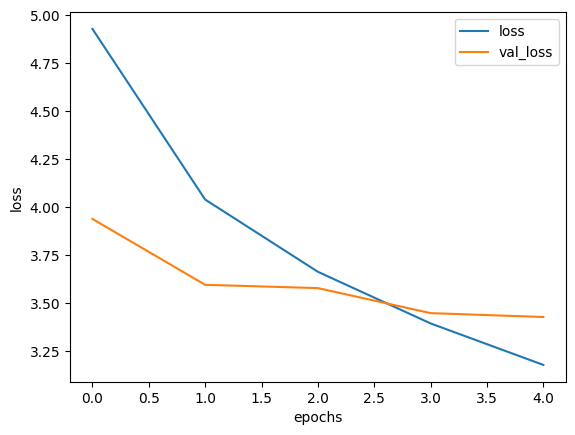

In [25]:
for label in ["loss", "val_loss"]:
    plt.plot(modelTraining.history[label], label = label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [26]:
# SAVING FILES AND MODELS
rnnModel.save("Model/RNN_Model.h5")
cnnModel.save("Model/CNN_Model.h5")
dump(tokenizer, open('Flickr8K_Tokenizer.p', 'wb'))

In [35]:
# PREDICTION & PERFORMANCE ANALYSIS
def generateCaption(filename):
    img = load_img(filename, target_size = (299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = preprocess_input(img)
    features = cnnModel.predict(img)
    inText = 'startseq'
    for i in range(maxLen):
        sequence = tokenizer.texts_to_sequences([inText])[0]
        sequence = pad_sequences([sequence], maxlen=maxLen)
        pred = rnnModel.predict([features,sequence], verbose=0)
        pred = np.argmax(pred)
        word = indexToWord[pred]
        if word is None:
            break
        inText += ' ' + word
        if word == 'endseq':
            break
    return inText

In [48]:
def generateCaptionBeamSearch(filename, maxLength, beamIndex):
    img = load_img(filename, target_size = (299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = preprocess_input(img)
    features = cnnModel.predict(img)
    inText = [[tokenizer.texts_to_sequences(['startseq'])[0], 0.0]]
    while len(inText[0][0]) < maxLength:
        tempList = []
        for seq in inText:
            paddedSeq = pad_sequences([seq[0]], maxlen=maxLength)
            preds = rnnModel.predict([features,paddedSeq], verbose=0)
            topPreds = np.argsort(preds[0])[-beamIndex:]
            for word in topPreds:
                nextSeq, prob = seq[0][:], seq[1]
                nextSeq.append(word)
                prob += preds[0][word]
                tempList.append([nextSeq, prob])
        inText = tempList
        inText = sorted(inText, reverse=False, key=lambda l: l[1])
        inText = inText[-beamIndex:]
    inText = inText[-1][0]
    finalCaptionRaw = [indexToWord[i] for i in inText]
    finalCaption = []
    for word in finalCaptionRaw:
        if word == 'endseq':
            break
        else:
            finalCaption.append(word)
    finalCaption.append('endseq')
    return ' '.join(finalCaption)

1/1 [==============================] - 0s 47ms/step


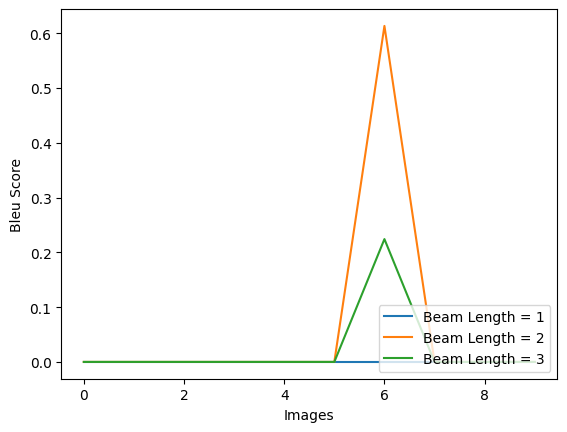

In [49]:
scores, beam2_scores, beam3_scores = [], [], []
for img, caption in zip(testImages, testCaptions):
    hypothesis = generateCaption(inputDir + "Images/" + img + ".jpg")
    scores.append(sentence_bleu([caption.split()], hypothesis.split()))
    hypothesis = generateCaptionBeamSearch(inputDir + "Images/" + img + ".jpg", maxLen, 2)
    beam2_scores.append(sentence_bleu([caption.split()], hypothesis.split()))
    hypothesis = generateCaptionBeamSearch(inputDir + "Images/" + img + ".jpg", maxLen, 3)
    beam3_scores.append(sentence_bleu([caption.split()], hypothesis.split()))
    
for i, score in enumerate([scores, beam2_scores, beam3_scores]):
    plt.plot(score, label = 'Beam Length = ' + str(i+1))
plt.legend(loc = 'lower right')
plt.xlabel('Images')
plt.ylabel('Bleu Score')
plt.show()

1/1 [==============================] - 0s 46ms/step


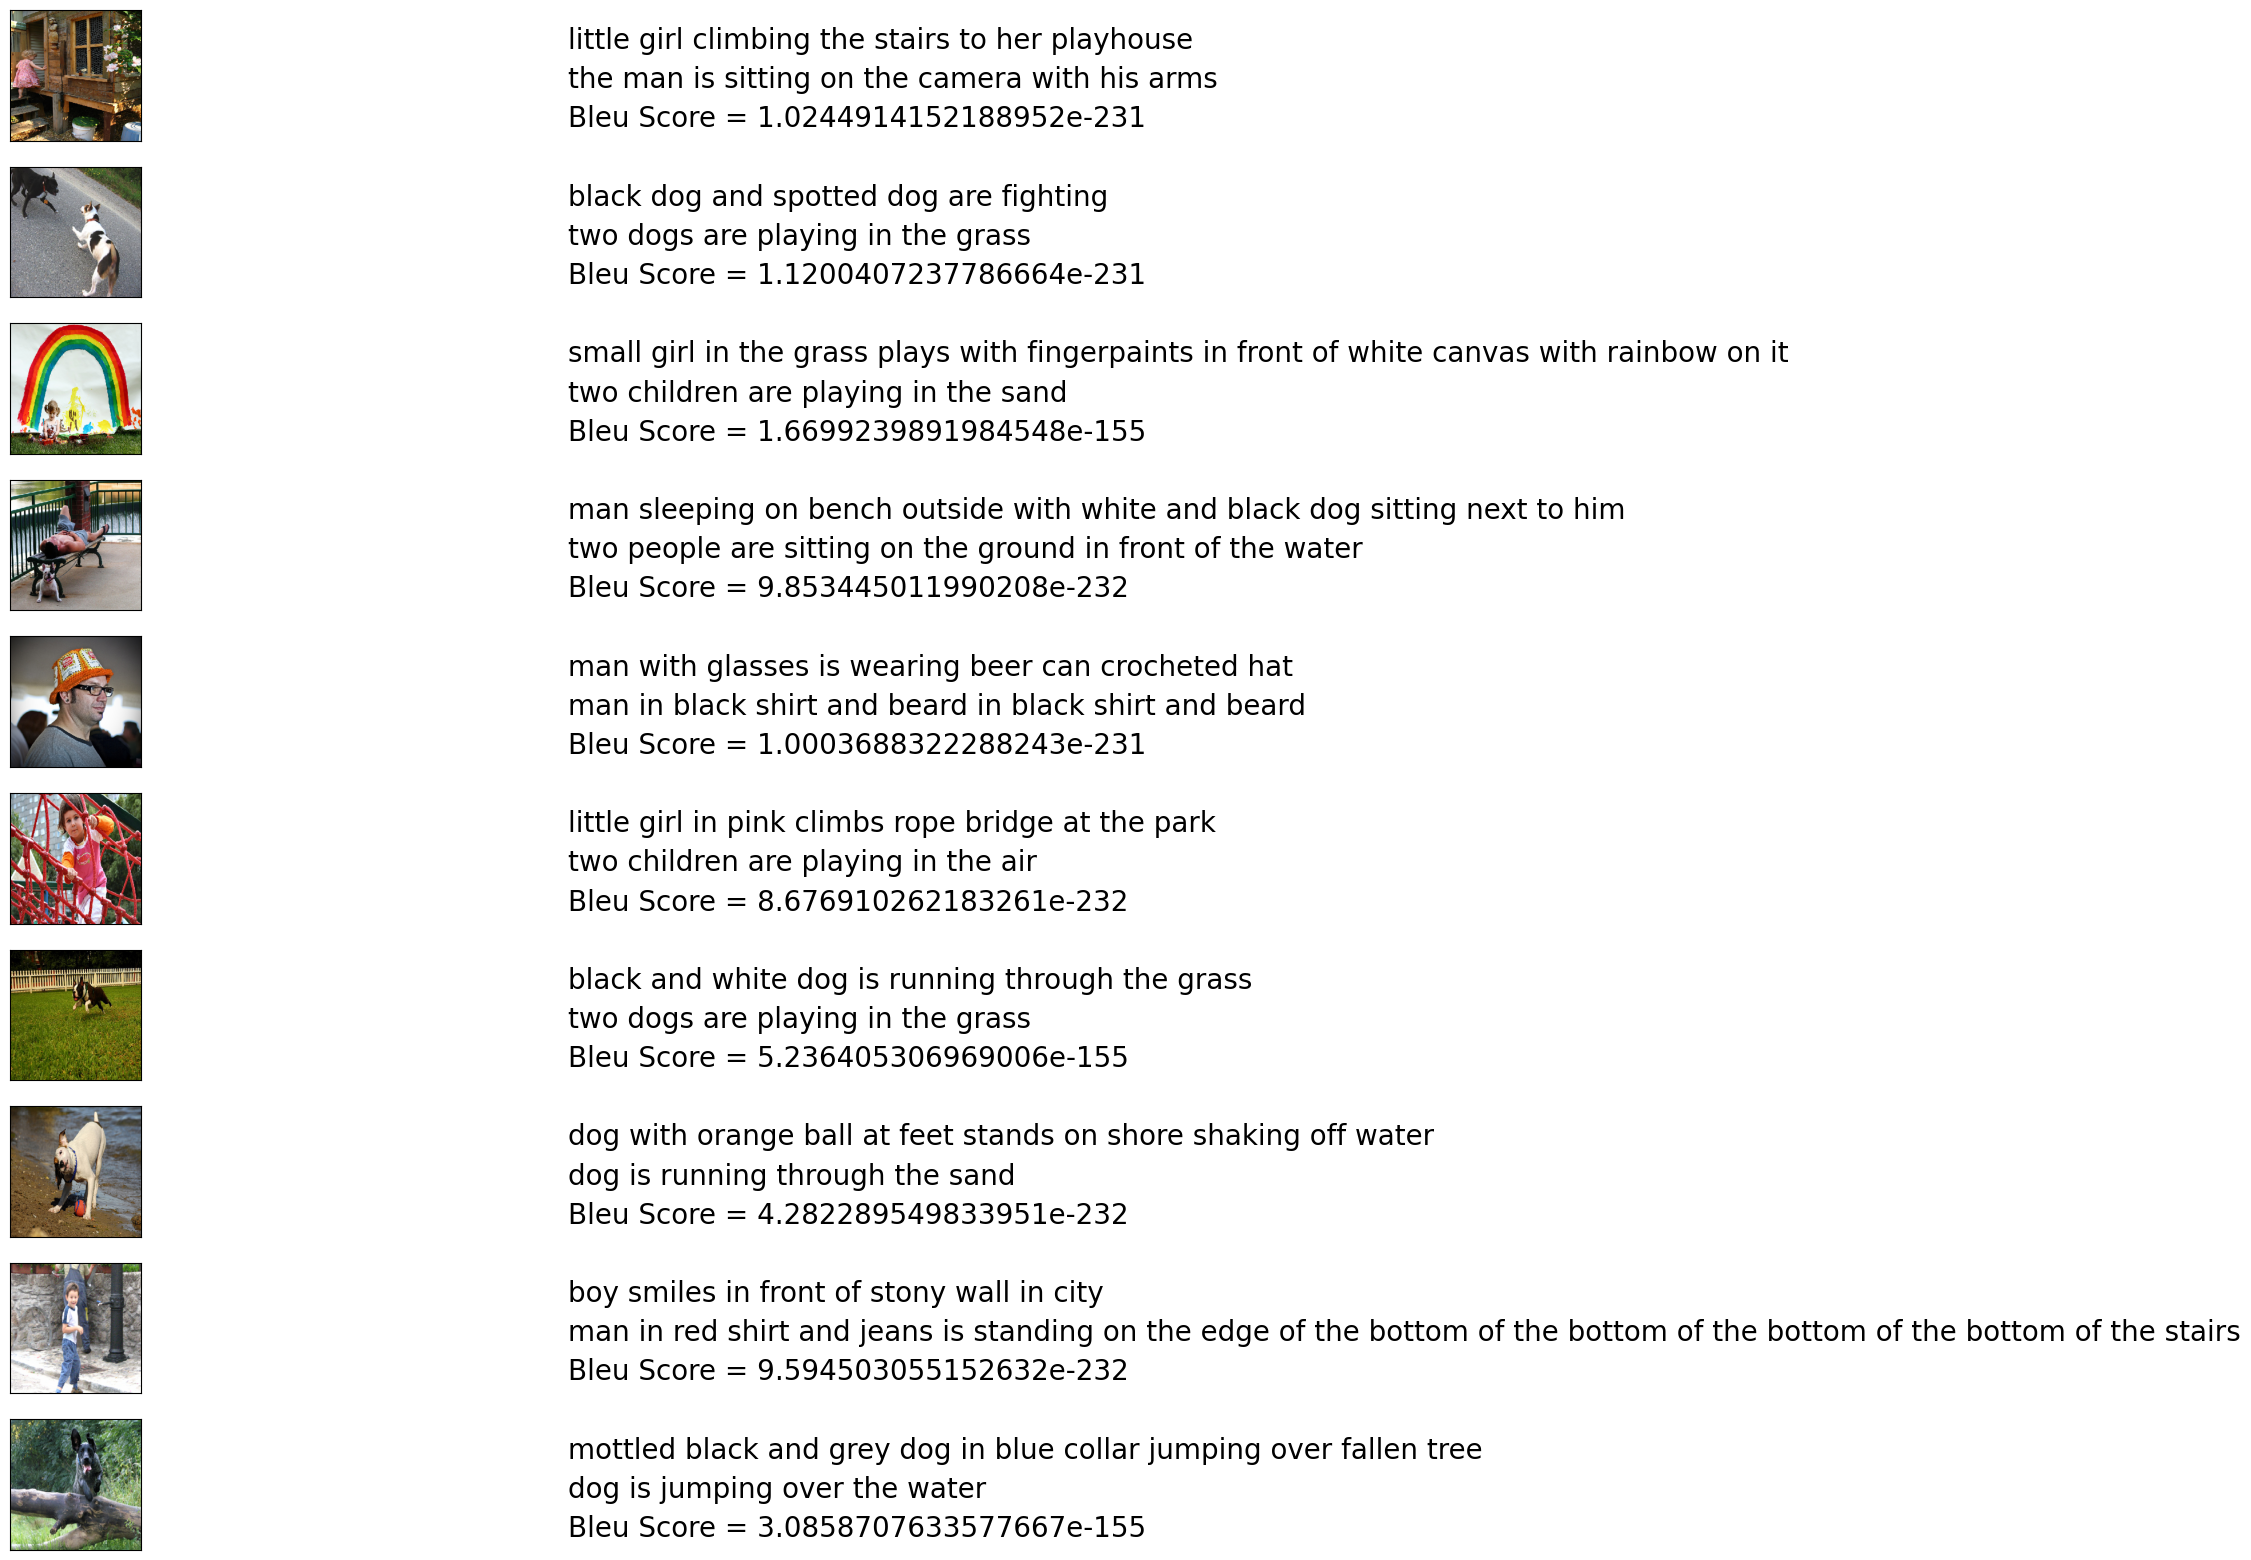

In [50]:
npic = 10
npix = 299
targetSize = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(20,20))
for img, trueCaption in zip(testImages, testCaptions):
     
    filename = inputDir + 'Images/' + img + ".jpg"
    imageLoad = load_img(filename, target_size = targetSize)
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    trueCaption = ' '.join(trueCaption.split()[1: -1])
    ax.imshow(imageLoad)
    count += 1

    caption = generateCaption(filename)
    caption = ' '.join(caption.split()[1: -1])
    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0, 0.7, trueCaption, fontsize = 20)
    ax.text(0, 0.4, caption, fontsize = 20)
    ax.text(0, 0.1, 'Bleu Score = {}'.format(sentence_bleu([trueCaption.split()], caption.split())), fontsize = 20)
    count += 1

plt.show()